Authors: José Raúl Romero (jrromero@uco.es), Aurora Ramírez (aurora.ramirez@uma.es), Francisco Javier Alcaide (f52almef@uco.es)

**Multiclass classification problem notebook for UML data set**

- The "dummies" and "unknown" cases will be ignored.

- SVC, RF and KNN have been used

- For the metrics we consider the "macro" approach with the aim that the metrics are not affected by their number.

- It has been verified that after 10 classes there is a higher decrease in performance.

- It has been proven that working with the 10 most frequent classes and deleting the rest results in better performance than grouping the rest into a single class.

- Explainability, the 5 classes with the best performance in F1-score. The instances that have obtained the highest probability for that class were studied.

- Local explainability: 10 features with the greatest contribution in each technique have been considered. And for the coincidence metrics between techniques, the TOP5 has been considered.

# Installation:

It is important to define the path to the folder that contains the Modelset files, in this notebook using the variable "MODELSET_HOME".

In [ ]:
MODELSET_HOME="/content/drive/MyDrive/modelset"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install modelset-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b180787c75dbec00c508ecbb45778f35a3515da82aebf483b5dc3b2f2c361157
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2


In [ ]:
!pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042470 sha256=7d2ec22523c933399e00aa67d3cfa4441855c48f7310c7e21d95552f0406575d
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ed19ab7090e05252acfef9bdd9f31b6be4a94bc57639e3f315b53fc99b1ac0f9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import sys
import pandas as pd
import re
import plotly
import kaleido
import pickle
import numpy as np
import dalex as dx
import os
import modelset.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.inspection import permutation_importance

## Functions:

In [ ]:
# Function to evaluate the sign of values
def evaluate_value(value):
    if value >= 0:
        return "Positive"
    else:
        return "Negative"

In [ ]:
# Create the MultiIndex columns
columns_multi = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Sign'),
    ('Shap', 'Ranking'), ('Shap', 'Sign'),
    ('Lime', 'Ranking'), ('Lime', 'Sign')
])

In [ ]:
# Function to evaluate the top 5 features
def top5_features(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = set(df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])].index)
        set_expl[tech] = inst_top5

    result_case = {
        f'TOP5 {tech}': ', '.join(set_expl[tech]) for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'
                result_case[col_name] = len(inst_top5_1.intersection(inst_top5_2)) / 5

    df_top5_case = pd.DataFrame(result_case, index=[case])

    return df_top5_case

In [ ]:
# Function to evaluate the top 5 ranking
def top5_rank(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{ranking}:{inst}' for ranking, inst in zip(inst_top5[(tech, 'Ranking')], inst_top5.index)])

        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ') and inst.split(':')[1] == inst.split(':')[1]]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 5

    df_top5_rank = pd.DataFrame(result_case, index=[case])

    return df_top5_rank

In [ ]:
# Function to evaluate the top 5 sign
def top5_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{inst}:{sign}' for inst, sign in zip(inst_top5.index, inst_top5[(tech, 'Sign')])])

        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ')]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 5

    df_top5_sign = pd.DataFrame(result_case, index=[case])

    return df_top5_sign

In [ ]:
# Function to evaluate the top 5 sign and ranking
def top5_rank_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{ranking}:{inst}:{sign}' for ranking, inst, sign in zip(inst_top5[(tech, 'Ranking')], inst_top5.index, inst_top5[(tech, 'Sign')])])
        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ') and inst.split(':')[1] == inst.split(':')[1] and inst.split(':')[2] == inst.split(':')[2]]
                num_coincidence = len(coincidence)
                result_case[col_name] = num_coincidence / 5

    df_top5_rank_sign = pd.DataFrame(result_case, index=[case])

    return df_top5_rank_sign

In [ ]:
# Function to obtain the dataframes of the tech Breakdown, SHAP, and LIME.
def preprocess_dfs(breakdown_df, shap_df, lime_df, n, m):

    pattern = re.compile(r'(?:<=|<|>=|>)\s*(\w+)\s*(?:<=|<|>=|>)')

    breakdown_df = breakdown_df.loc[:, ['variable_name', 'contribution', 'sign']]
    breakdown_df = breakdown_df.drop(index=[0, n+1])
    breakdown_df['sign'] = breakdown_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    breakdown_df = breakdown_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    shap_df = shap_df.loc[:, ['variable_name', 'contribution', 'sign']]
    shap_df = shap_df.tail(n)
    shap_df['sign'] = shap_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    shap_df = shap_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    lime_list = []
    for feature in lime_df['variable']:
      if pattern.findall(feature):
        match = pattern.search(feature)
        if match:
          lime_list.append(match.group(1))
      else:
        splits = feature.split(" ")
        lime_list.append(splits[0])

    lime_df["Feature"] = lime_list
    lime_df["Sign"] = lime_df["effect"].apply(evaluate_value)
    lime_df = lime_df.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
    lime_df = lime_df.drop(columns=['variable'])

    breakdown_df['Ranking'] = breakdown_df['contribution'].abs().rank(ascending=False).astype(int)
    breakdown_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    breakdown_df = breakdown_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    shap_df['Ranking'] = shap_df['contribution'].abs().rank(ascending=False).astype(int)
    shap_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    shap_df = shap_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    lime_df['Ranking'] = lime_df['effect'].abs().rank(ascending=False).astype(int)
    lime_df = lime_df.head(m)
    lime_df = lime_df[['Feature', 'Ranking', 'effect', 'Sign']]

    breakdown_df = breakdown_df.drop(columns=['contribution'])
    shap_df = shap_df.drop(columns=['contribution'])
    lime_df = lime_df.drop(columns=['effect'])

    breakdown_df = breakdown_df.head(m)
    breakdown_df = breakdown_df.reset_index(drop=True)

    shap_df= shap_df.head(m)
    shap_df = shap_df.reset_index(drop=True)

    lime_df = lime_df.reset_index(drop=True)

    breakdown_features = list(breakdown_df['Feature'])
    shap_features = list(shap_df['Feature'])
    lime_features = list(lime_df['Feature'])
    all_features = list(set(breakdown_features + shap_features + lime_features))
    all_features = all_features[::-1]

    df_final = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
    df_final['Feature'] = list(all_features)
    df_final = df_final[['Feature', 'Breakdown', 'Shap', 'Lime']]

    #print(breakdown_features)
    #print(shap_features)
    #print(lime_features)
    print(all_features)

    for feature in df_final['Feature']:

        breakdown_row = breakdown_df[breakdown_df['Feature'] == feature]
        if not breakdown_row.empty:

            ranking_breakdown = breakdown_row.iloc[0]['Ranking']
            sign_breakdown = breakdown_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = sign_breakdown
        else:

            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


        shap_row = shap_df[shap_df['Feature'] == feature]
        if not shap_row.empty:
            ranking_shap = shap_row.iloc[0]['Ranking']
            sign_shap = shap_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = sign_shap
        else:
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = '-'


        lime_row = lime_df[lime_df['Feature'] == feature]
        if not lime_row.empty:
            ranking_lime = lime_row.iloc[0]['Ranking']
            sign_lime = lime_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = sign_lime
        else:
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = '-'


    ranking_breakdown = df_final[('Breakdown', 'Ranking')]
    values_valid = ranking_breakdown[ranking_breakdown != '-']
    cases_invalid = ranking_breakdown[ranking_breakdown == '-'].index
    cases_valid = []
    cases_invalid_restantes = list(cases_invalid)
    cases_valid.extend(values_valid.sort_values().index.tolist())

    for cas in cases_invalid:
        value_shap = df_final.at[cas, ('Shap', 'Ranking')]
        if value_shap != '-':
            cases_valid.extend([cas])
            cases_invalid_restantes.remove(cas)

    for cas in cases_invalid_restantes:
        value_lime = df_final.at[cas, ('Lime', 'Ranking')]
        if value_lime != '-':
            cases_valid.extend([cas])

    df_final = df_final.loc[cases_valid]
    df_final.set_index('Feature', inplace=True)
    return breakdown_df, shap_df, lime_df, df_final


In [ ]:
# Function to create final dataframes with all the disagreement metrics and calculate the means of disagreement metrics for each pair of techniques.
def calculate_metrics(df_list):
    df_final = pd.concat(df_list)

    mean_bd_shap = df_final['Breakdown-Shap'].mean()
    mean_bd_lime = df_final['Breakdown-Lime'].mean()
    mean_lime_shap = df_final['Lime-Shap'].mean()

    return df_final, mean_bd_shap, mean_bd_lime, mean_lime_shap

In [ ]:
# Function to create dictionaries containing the disagreement metrics dataframes
def create_metrics_dfs(metrics_dict, metric_type):
    dfs = {'Model_comparison': {}, 'Class_comparison': {}}
    columns_model = ['Class', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    columns_class = ['Model', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    metric_names = [f'Mean_{metric_type}_BD_Shap', f'Mean_{metric_type}_BD_Lime', f'Mean_{metric_type}_Lime_Shap']

    for model_name, indexes_dict in metrics_dict.items():
        for index_name, metrics in indexes_dict.items():
            if model_name not in dfs['Class_comparison']:
                dfs['Class_comparison'][model_name] = pd.DataFrame(columns=columns_model)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            class_data = [index_name] + get_metrics
            dfs['Class_comparison'][model_name] = pd.concat([dfs['Class_comparison'][model_name], pd.Series(class_data, index=columns_model).to_frame().T], ignore_index=True)

            if index_name not in dfs['Model_comparison']:
                dfs['Model_comparison'][index_name] = pd.DataFrame(columns=columns_class)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            model_data = [model_name] + get_metrics
            dfs['Model_comparison'][index_name] = pd.concat([dfs['Model_comparison'][index_name], pd.Series(model_data, index=columns_class).to_frame().T], ignore_index=True)

    return dfs

In [ ]:
# Function to obtain dataframes of explanations, disagreement metrics, and each of the disagreement metrics dataframes
def calculate_metrics_for_indices(models_dict, indexes_dict, X_test, X_train, y_train, num_features, top_num_features):
    results_dict = {}
    metrics_dict = {}

    for model_name, model in models_dict.items():
        results_dict[model_name] = {}
        metrics_dict[model_name] = {}

        exp = dx.Explainer(model, X_train, y_train)

        for index_name, indices in indexes_dict.items():
          results_dict[model_name][index_name] = {}
          metrics_dict[model_name][index_name] = {}
          model_results = results_dict[model_name][index_name]
          df_list_top = []
          df_list_rank = []
          df_list_sign = []
          df_list_rank_sign = []

          for i in indices:
            instance = X_test.loc[i]

            breakdown = exp.predict_parts(instance, type="break_down", random_state=42)
            shap = exp.predict_parts(instance, type="shap", random_state=42)
            lime = exp.predict_surrogate(instance, random_state=42)
            breakdown_df = breakdown.result
            shap_df = shap.result
            lime_df = lime.result

            breakdown_df, shap_df, lime_df, df_final = preprocess_dfs(breakdown_df, shap_df, lime_df, num_features, top_num_features)

            model_results[f"breakdown_df_{i}"] = breakdown_df
            model_results[f"shap_df_{i}"] = shap_df
            model_results[f"lime_df_{i}"] = lime_df
            model_results[f"df_final_{i}"] = df_final

            metrics_dict[model_name][index_name][f"df_top_metric_{i}"] = top3_features(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            metrics_dict[model_name][index_name][f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            #model_results[f"df_top_metric_{i}"] = top3_features(df_final, i)
            #model_results[f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            #model_results[f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            #model_results[f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            df_list_top.append(metrics_dict[model_name][index_name][f'df_top_metric_{i}'])
            df_list_rank.append(metrics_dict[model_name][index_name][f'df_rank_metric_{i}'])
            df_list_sign.append(metrics_dict[model_name][index_name][f'df_sign_metric_{i}'])
            df_list_rank_sign.append(metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'])

          df_top_metric_final, mean_top_bd_shap, mean_top_bd_lime, mean_top_lime_shap = calculate_metrics(df_list_top)
          df_rank_metric_final, mean_rank_bd_shap, mean_rank_bd_lime, mean_rank_lime_shap = calculate_metrics(df_list_rank)
          df_sign_metric_final, mean_sign_bd_shap, mean_sign_bd_lime, mean_sign_lime_shap = calculate_metrics(df_list_sign)
          df_rank_sign_metric_final, mean_rank_sign_bd_shap, mean_rank_sign_bd_lime, mean_rank_sign_lime_shap = calculate_metrics(df_list_rank_sign)

          metrics_dict[model_name][index_name][f'Mean_top_BD_Shap'] = mean_top_bd_shap
          metrics_dict[model_name][index_name][f'Mean_top_BD_Lime'] = mean_top_bd_lime
          metrics_dict[model_name][index_name][f'Mean_top_Lime_Shap'] = mean_top_lime_shap
          metrics_dict[model_name][index_name][f'df_top_metric_final'] = df_top_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_BD_Shap'] = mean_rank_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_BD_Lime'] = mean_rank_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_Lime_Shap'] = mean_rank_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_metric_final'] = df_rank_metric_final

          metrics_dict[model_name][index_name][f'Mean_sign_BD_Shap'] = mean_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_sign_BD_Lime'] = mean_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_sign_Lime_Shap'] = mean_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_sign_metric_final'] = df_sign_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Shap'] = mean_rank_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Lime'] = mean_rank_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_sign_Lime_Shap'] = mean_rank_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_sign_metric_final'] = df_rank_sign_metric_final

    top_metric_df = create_metrics_dfs(metrics_dict, 'top')
    rank_metric_df = create_metrics_dfs(metrics_dict, 'rank')
    sign_metric_df = create_metrics_dfs(metrics_dict, 'sign')
    rank_sign_metric_df = create_metrics_dfs(metrics_dict, 'rank_sign')

    return metrics_dict, results_dict, top_metric_df, rank_metric_df, sign_metric_df, rank_sign_metric_df


# Load y Preprocess:

In this section, we will perform data loading, cleaning, preprocessing, and an initial data analysis.

In [ ]:
dataset = ds.load(MODELSET_HOME,modeltype = 'uml', selected_analysis = ['stats']) # load dataset
modelset_df = dataset._Dataset__to_df()

In [ ]:
duplicates = modelset_df.duplicated(subset='id', keep=False)
inst_dup = modelset_df[duplicates]
inst_dup

Empty DataFrame
Columns: [id, category, tags, language, type_Generalization, type_Class, type_Interaction, type_Relationship, type_Package, type_Actor, diagram_ad, type_DataType, diagram_cd, type_Operation, type_Transition, type_State, type_Property, type_UseCase, diagram_usecase, elements, type_Component, type_Enumeration, type_Association, type_Activity, diagram_comp, diagram_interaction, diagram_sm]
Index: []

[0 rows x 27 columns]

In [ ]:
modelset_df

id             category  \
0     repo-genmymodel-uml/data/_WJKFoOBcEeeAyLDAJ12_...          computer-ui   
1     repo-genmymodel-uml/data/_grOBAOs7EeiJfugOH9Y5...  computer-videogames   
2     repo-genmymodel-uml/data/_3e5Z4BBDEeqa8dopbpYH...              unknown   
3     repo-genmymodel-uml/data/_zRSRMDEsEemjcq-iJCnV...              unknown   
4     repo-genmymodel-uml/data/_1vnlQNqPEeiJYbNjsZ3w...                dummy   
...                                                 ...                  ...   
5115  repo-genmymodel-uml/data/f60ea665-be9c-4b7d-b0...             shopping   
5116  repo-genmymodel-uml/data/_XUNZYJuFEeexEbmG8xrw...             shopping   
5117  repo-genmymodel-uml/data/1fd45148-722f-4b60-93...            realstate   
5118  repo-genmymodel-uml/data/bc00e7fa-4d5b-4f96-8c...  computer-videogames   
5119  repo-genmymodel-uml/data/4c7db8c8-0898-4b56-be...             shopping   

            tags language  type_Generalization  type_Class  type_Interaction  \
0            NaN  english                    0           5                 0   
1       videgame  english                    0           8                 0   
2            NaN   rusian                    0          33                 0   
3            NaN  unknown                    0           3                 0   
4            NaN  english                    0           0                 0   
...          ...      ...                  ...         ...               ...   
5115         NaN  english                    0           8                 0   
5116         NaN  english                    0           0                 0   
5117  real-state  english                    0          13                 0   
5118   card-game  english                    0           6                 0   
5119         NaN  english                    0           8                 0   

      type_Relationship  type_Package  type_Actor  ...  type_UseCase  \
0                     6             1           1  ...             0   
1                     3             1           0  ...             0   
2                   106             1          17  ...            47   
3                     3             1           0  ...             0   
4                     5             1           2  ...             3   
...                 ...           ...         ...  ...           ...   
5115                 20             1           3  ...             4   
5116                  1             1           0  ...             0   
5117                 15             1           0  ...             0   
5118                  8             1           0  ...             0   
5119                 12             1           0  ...             0   

      diagram_usecase  elements  type_Component  type_Enumeration  \
0                 1.0       123               0                 0   
1                 NaN        56               0                 1   
2                17.0       726               0                 0   
3                 NaN        32               0                 0   
4                 2.0        53               1                 0   
...               ...       ...             ...               ...   
5115              3.0       270               0                 2   
5116              NaN       112               0                 0   
5117              NaN       202               0                 0   
5118              NaN        84               0                 2   
5119              NaN       231               0                 2   

      type_Association  type_Activity  diagram_comp  diagram_interaction  \
0                    0              1           NaN                  NaN   
1                    0              0           NaN                  NaN   
2                    0              0           NaN                  NaN   
3                    0              0           NaN                  NaN   
4                    0              1           1.0      

In [ ]:
modelset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5120 entries, 0 to 5119
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5120 non-null   object 
 1   category             5120 non-null   object 
 2   tags                 1943 non-null   object 
 3   language             5120 non-null   object 
 4   type_Generalization  5120 non-null   int64  
 5   type_Class           5120 non-null   int64  
 6   type_Interaction     5120 non-null   int64  
 7   type_Relationship    5120 non-null   int64  
 8   type_Package         5120 non-null   int64  
 9   type_Actor           5120 non-null   int64  
 10  diagram_ad           1542 non-null   float64
 11  type_DataType        5120 non-null   int64  
 12  diagram_cd           3110 non-null   float64
 13  type_Operation       5120 non-null   int64  
 14  type_Transition      5120 non-null   int64  
 15  type_State           5120 non-null   int64 

In [ ]:
# Reset index
modelset_df = modelset_df.reset_index(drop=True)

# Remove useless features
modelset_df = modelset_df.drop(['diagram_ad'], axis=1)
modelset_df = modelset_df.drop(['diagram_cd'], axis=1)
modelset_df = modelset_df.drop(['diagram_usecase'], axis=1)
modelset_df = modelset_df.drop(['diagram_comp'], axis=1)
modelset_df = modelset_df.drop(['diagram_interaction'], axis=1)
modelset_df = modelset_df.drop(['diagram_sm'], axis=1)
modelset_df = modelset_df.drop(['elements'], axis=1)
modelset_df = modelset_df.drop(['tags'], axis=1)
modelset_df = modelset_df.drop(['language'], axis=1)
modelset_df = modelset_df.drop(['id'], axis=1)

In [ ]:
modelset_df.head()

category  type_Generalization  type_Class  type_Interaction  \
0          computer-ui                    0           5                 0   
1  computer-videogames                    0           8                 0   
2              unknown                    0          33                 0   
3              unknown                    0           3                 0   
4                dummy                    0           0                 0   

   type_Relationship  type_Package  type_Actor  type_DataType  type_Operation  \
0                  6             1           1             11              21   
1                  3             1           0              7               6   
2                106             1          17              1               0   
3                  3             1           0              2               0   
4                  5             1           2              0               0   

   type_Transition  type_State  type_Property  type_UseCase  type_Component  \
0                0           0             22             0               0   
1                0           0             20             0               0   
2                0           0            203            47               0   
3                0           0             15             0               0   
4                0           0              4             3               1   

   type_Enumeration  type_Association  type_Activity  
0                 0                 0              1  
1                 1                 0              0  
2                 0                 0              0  
3                 0                 0              0  
4                 0                 0              1

In [ ]:
modelset_df['category'].value_counts()

shopping                695
dummy                   606
unknown                 445
restaurant              265
computer-videogames     242
                       ... 
productmanagement         1
collectionmanagement      1
machine-coffee            1
dashboard                 1
procedure-car             1
Name: category, Length: 127, dtype: int64

In [ ]:
modelset_df.describe()

type_Generalization   type_Class  type_Interaction  type_Relationship  \
count               5120.0  5120.000000            5120.0        5120.000000   
mean                   0.0     6.631641               0.0          14.125586   
std                    0.0     7.552115               0.0          13.943627   
min                    0.0     0.000000               0.0           1.000000   
25%                    0.0     0.000000               0.0           7.000000   
50%                    0.0     6.000000               0.0          11.000000   
75%                    0.0    10.000000               0.0          19.000000   
max                    0.0   121.000000               0.0         285.000000   

       type_Package   type_Actor  type_DataType  type_Operation  \
count   5120.000000  5120.000000    5120.000000     5120.000000   
mean       1.270508     1.389844       0.699219        8.068555   
std        1.083390     2.611075       2.756469       16.131922   
min        1.000000     0.000000       0.000000        0.000000   
25%        1.000000     0.000000       0.000000        0.000000   
50%        1.000000     0.000000       0.000000        0.000000   
75%        1.000000     2.000000       0.000000       12.000000   
max       42.000000    42.000000      52.000000      370.000000   

       type_Transition   type_State  type_Property  type_UseCase  \
count      5120.000000  5120.000000    5120.000000   5120.000000   
mean          0.177930     0.123438      25.379883      5.143359   
std           2.266349     1.580304      25.204381      9.717104   
min           0.000000     0.000000       0.000000      0.000000   
25%           0.000000     0.000000      10.000000      0.000000   
50%           0.000000     0.000000      20.000000      0.000000   
75%           0.000000     0.000000      38.000000     10.000000   
max          46.000000    36.000000     628.000000    190.000000   

       type_Component  type_Enumeration  type_Association  type_Activity  
count     5120.000000       5120.000000            5120.0    5120.000000  
mean         0.228516          0.245898               0.0       0.487891  
std          0.756380          0.716427               0.0       1.446935  
min          0.000000          0.000000               0.0       0.000000  
25%          0.000000          0.000000               0.0       0.000000  
50%          0.000000          0.000000               0.0       0.000000  
75%          0.000000          0.000000               0.0       1.000000  
max         21.000000          8.000000               0.0      30.000000

In [ ]:
# Remove constant features
modelset_df = modelset_df.drop(['type_Interaction'], axis=1)
modelset_df = modelset_df.drop(['type_Generalization'], axis=1)
modelset_df = modelset_df.drop(['type_Association'], axis=1)

col = modelset_df.columns
col = col.drop('category')
col

Index(['type_Class', 'type_Relationship', 'type_Package', 'type_Actor',
       'type_DataType', 'type_Operation', 'type_Transition', 'type_State',
       'type_Property', 'type_UseCase', 'type_Component', 'type_Enumeration',
       'type_Activity'],
      dtype='object')

In [ ]:
modelset_df.describe()

type_Class  type_Relationship  type_Package   type_Actor  \
count  5120.000000        5120.000000   5120.000000  5120.000000   
mean      6.631641          14.125586      1.270508     1.389844   
std       7.552115          13.943627      1.083390     2.611075   
min       0.000000           1.000000      1.000000     0.000000   
25%       0.000000           7.000000      1.000000     0.000000   
50%       6.000000          11.000000      1.000000     0.000000   
75%      10.000000          19.000000      1.000000     2.000000   
max     121.000000         285.000000     42.000000    42.000000   

       type_DataType  type_Operation  type_Transition   type_State  \
count    5120.000000     5120.000000      5120.000000  5120.000000   
mean        0.699219        8.068555         0.177930     0.123438   
std         2.756469       16.131922         2.266349     1.580304   
min         0.000000        0.000000         0.000000     0.000000   
25%         0.000000        0.000000         0.000000     0.000000   
50%         0.000000        0.000000         0.000000     0.000000   
75%         0.000000       12.000000         0.000000     0.000000   
max        52.000000      370.000000        46.000000    36.000000   

       type_Property  type_UseCase  type_Component  type_Enumeration  \
count    5120.000000   5120.000000     5120.000000       5120.000000   
mean       25.379883      5.143359        0.228516          0.245898   
std        25.204381      9.717104        0.756380          0.716427   
min         0.000000      0.000000        0.000000          0.000000   
25%        10.000000      0.000000        0.000000          0.000000   
50%        20.000000      0.000000        0.000000          0.000000   
75%        38.000000     10.000000        0.000000          0.000000   
max       628.000000    190.000000       21.000000          8.000000   

       type_Activity  
count    5120.000000  
mean        0.487891  
std         1.446935  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max        30.000000

In [ ]:
modelset_df_filt = modelset_df.loc[(modelset_df['category'] != 'dummy') & (modelset_df['category'] != 'unknown')] # delete dummy and unknown cases
modelset_df_filt

category  type_Class  type_Relationship  type_Package  \
0             computer-ui           5                  6             1   
1     computer-videogames           8                  3             1   
5                employee           0                 37             1   
6                  course           9                  7             1   
7     computer-videogames           8                  7             1   
...                   ...         ...                ...           ...   
5115             shopping           8                 20             1   
5116             shopping           0                  1             1   
5117            realstate          13                 15             1   
5118  computer-videogames           6                  8             1   
5119             shopping           8                 12             1   

      type_Actor  type_DataType  type_Operation  type_Transition  type_State  \
0              1             11              21                0           0   
1              0              7               6                0           0   
5              2              0               0                0           0   
6              0              1               0                0           0   
7              0              0               0                0           0   
...          ...            ...             ...              ...         ...   
5115           3              0               1                0           0   
5116           0              0               0                0           0   
5117           0              6              36                0           0   
5118           0              0               5                0           0   
5119           0              0               1                0           0   

      type_Property  type_UseCase  type_Component  type_Enumeration  \
0                22             0               0                 0   
1                20             0               0                 1   
5                38            15               1                 0   
6                45             0               0                 0   
7                12             0               0                 0   
...             ...           ...             ...               ...   
5115             52             4               0                 2   
5116              0             0               0                 0   
5117             53             0               0                 0   
5118             16             0               0                 2   
5119             44             0               0                 2   

      type_Activity  
0                 1  
1                 0  
5                 0  
6                 0  
7                 0  
...             ...  
5115              1  
5116              1  
5117              0  
5118              0  
5119              1  

[4069 rows x 14 columns]

In [ ]:
modelset_df_filt.isnull().any()

category             False
type_Class           False
type_Relationship    False
type_Package         False
type_Actor           False
type_DataType        False
type_Operation       False
type_Transition      False
type_State           False
type_Property        False
type_UseCase         False
type_Component       False
type_Enumeration     False
type_Activity        False
dtype: bool

In [ ]:
modelset_df_filt['category'].value_counts()

shopping                695
restaurant              265
computer-videogames     242
smarthouse              234
library                 222
                       ... 
alarm                     1
collectionmanagement      1
machine-coffee            1
registration              1
procedure-car             1
Name: category, Length: 125, dtype: int64

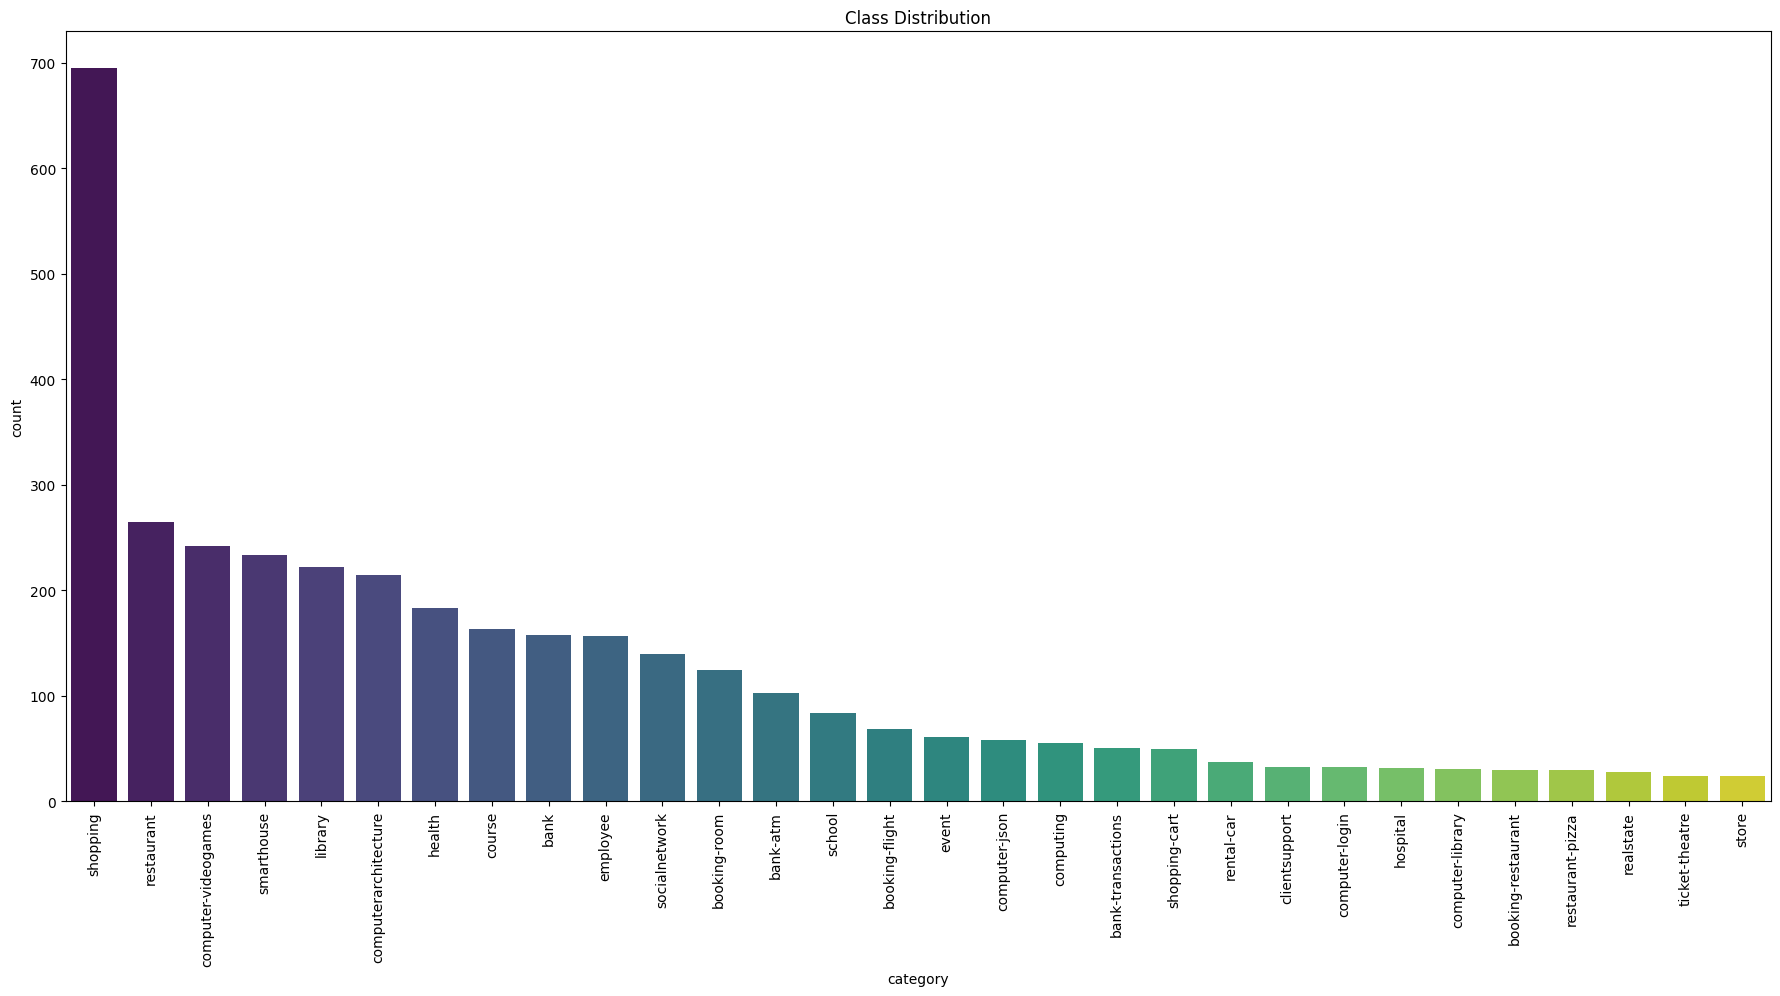

In [ ]:
# Class distribution
class_counts = modelset_df_filt['category'].value_counts().sort_values(ascending=False).head(30)
plt.figure(figsize=(22, 10))
sns.countplot(x='category', data=modelset_df_filt, order=class_counts.index, palette='viridis')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

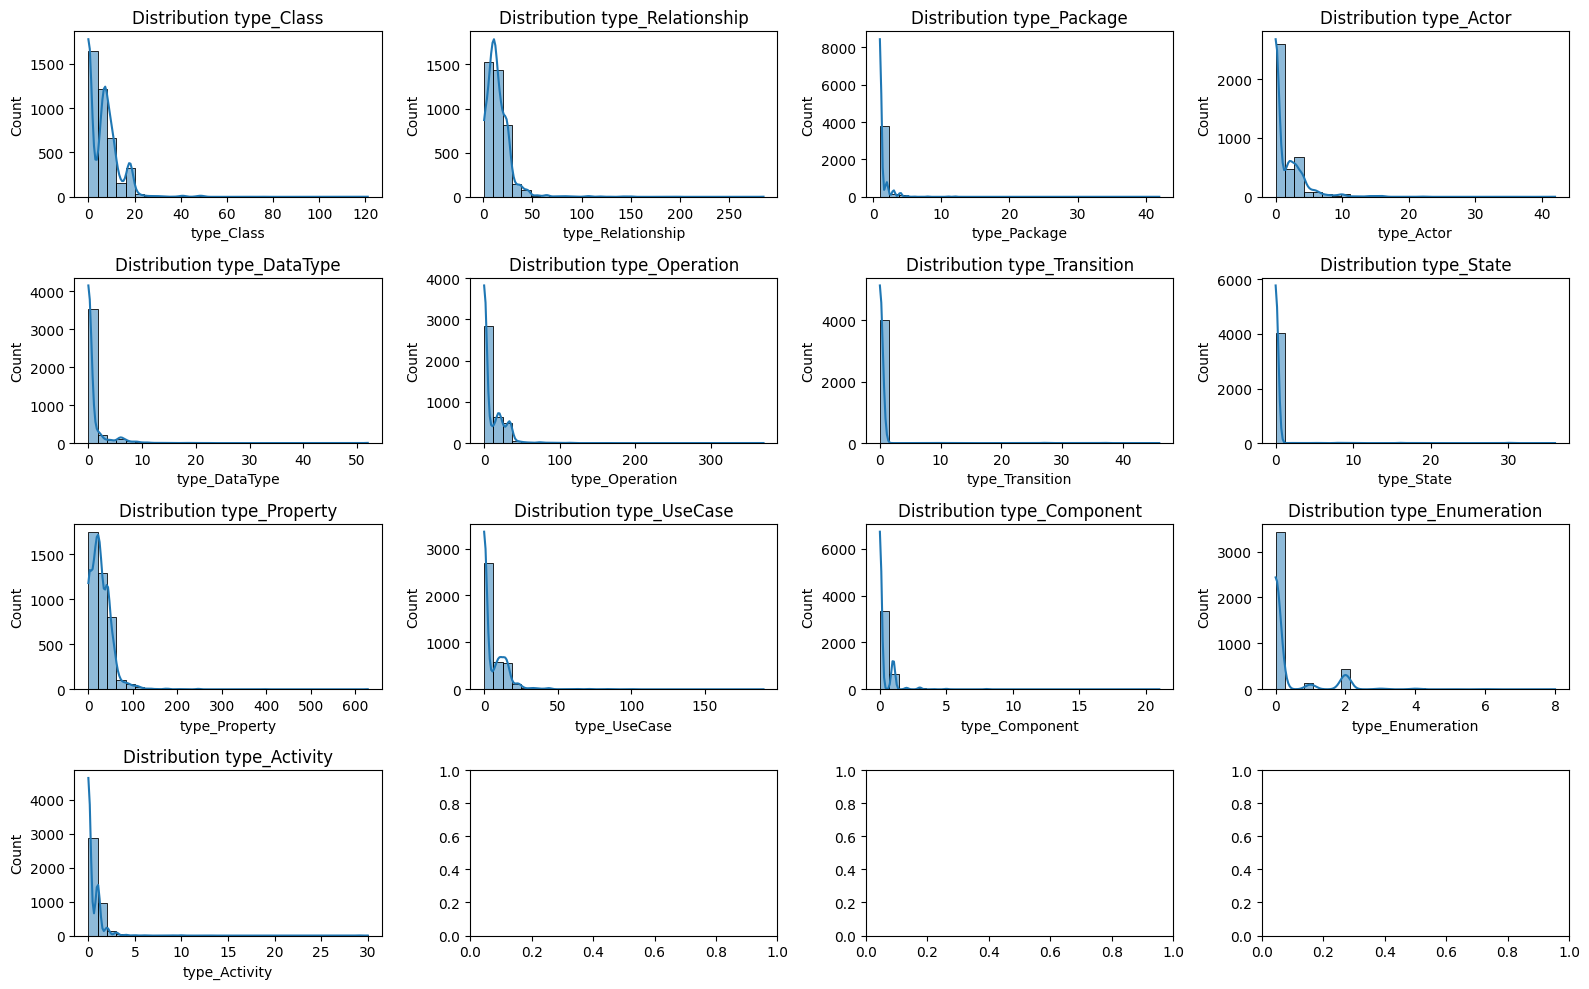

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(col):
    sns.histplot(modelset_df_filt[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

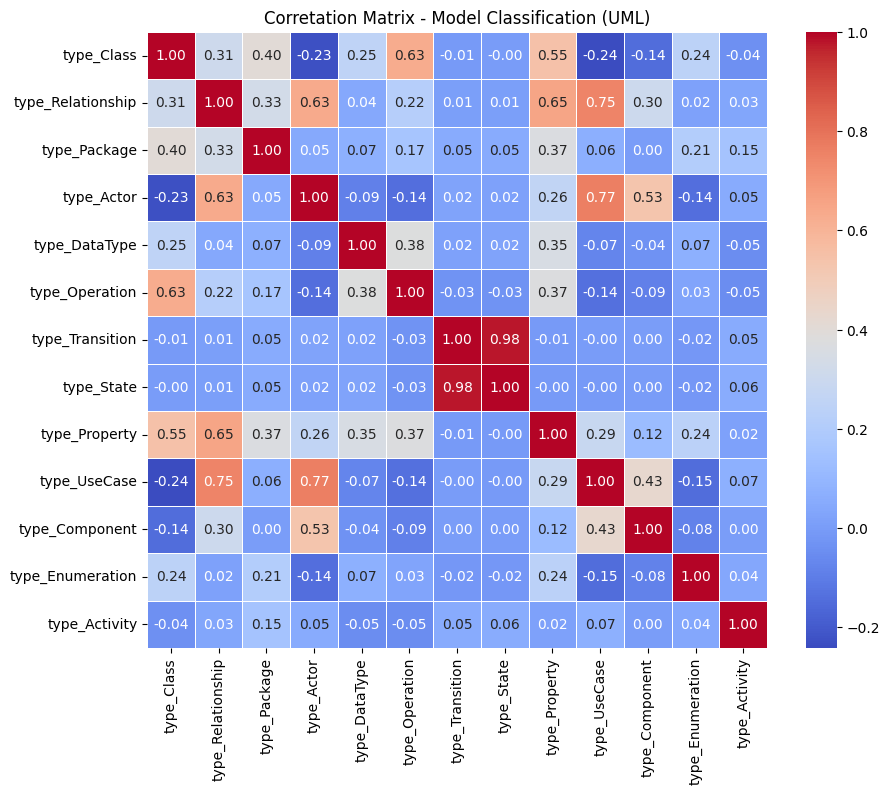

In [ ]:
# Correlation
correlation_matrix = modelset_df_filt.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Corretation Matrix - Model Classification (UML)')
plt.show()



---

❗❗ **No features with a correlation value greater than 0.8, so we are going to keep them all.**


---



# Performance No. Class:

We search for the best number of classes to consider through a performance evaluation

In [ ]:
modelset_df_label = modelset_df_filt.copy()

# transform classes into numbers
label_encoder_nclasses = LabelEncoder()
modelset_df_label['label'] = label_encoder_nclasses.fit_transform(modelset_df_label['category'])

In [ ]:
modelset_df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 5119
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           4069 non-null   object
 1   type_Class         4069 non-null   int64 
 2   type_Relationship  4069 non-null   int64 
 3   type_Package       4069 non-null   int64 
 4   type_Actor         4069 non-null   int64 
 5   type_DataType      4069 non-null   int64 
 6   type_Operation     4069 non-null   int64 
 7   type_Transition    4069 non-null   int64 
 8   type_State         4069 non-null   int64 
 9   type_Property      4069 non-null   int64 
 10  type_UseCase       4069 non-null   int64 
 11  type_Component     4069 non-null   int64 
 12  type_Enumeration   4069 non-null   int64 
 13  type_Activity      4069 non-null   int64 
 14  label              4069 non-null   int64 
dtypes: int64(14), object(1)
memory usage: 508.6+ KB


In [ ]:
modelset_df_label.head()

category  type_Class  type_Relationship  type_Package  \
0          computer-ui           5                  6             1   
1  computer-videogames           8                  3             1   
5             employee           0                 37             1   
6               course           9                  7             1   
7  computer-videogames           8                  7             1   

   type_Actor  type_DataType  type_Operation  type_Transition  type_State  \
0           1             11              21                0           0   
1           0              7               6                0           0   
5           2              0               0                0           0   
6           0              1               0                0           0   
7           0              0               0                0           0   

   type_Property  type_UseCase  type_Component  type_Enumeration  \
0             22             0               0                 0   
1             20             0               0                 1   
5             38            15               1                 0   
6             45             0               0                 0   
7             12             0               0                 0   

   type_Activity  label  
0              1     34  
1              0     35  
5              0     49  
6              0     42  
7              0     35

In [ ]:
modelset_df_label = modelset_df_label.drop(['category'], axis=1)

In [ ]:
X_label = modelset_df_label[col]
y_label = modelset_df_label['label']

In [ ]:
nclasses = [10, 20, 30, 40, 50, 60, 70, 80]
results_df = pd.DataFrame(columns=['No. Classes', 'Acc (SVC)', 'Prec (SVC)', 'Rec (SVC)', 'F1 (SVC)',
                                      'Acc (RF)', 'Prec (RF)', 'Rec (RF)', 'F1 (RF)',
                                      'Acc (KNN)', 'Prec (KNN)', 'Rec (KNN)', 'F1 (KNN)'])

for num_classes in nclasses:
    classes_frec_label = y_label.value_counts().nlargest(num_classes).index
    datos_filt = modelset_df_label[modelset_df_label['label'].isin(classes_frec_label)]

    X_filt = datos_filt[col]
    y_filt = datos_filt['label']
    X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.3, random_state=42, stratify=y_filt)

    svc_model = SVC(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    knn_model = KNeighborsClassifier()

    svc_model.fit(X_train_filt, y_train_filt)
    rf_model.fit(X_train_filt, y_train_filt)
    knn_model.fit(X_train_filt, y_train_filt)

    y_pred_svc = svc_model.predict(X_test_filt)
    y_pred_rf = rf_model.predict(X_test_filt)
    y_pred_knn = knn_model.predict(X_test_filt)

    acc_svc = balanced_accuracy_score(y_test_filt, y_pred_svc)
    precision_svc = precision_score(y_test_filt, y_pred_svc, average='macro')
    recall_svc = recall_score(y_test_filt, y_pred_svc, average='macro')
    f1_svc = f1_score(y_test_filt, y_pred_svc, average='macro')

    acc_rf = balanced_accuracy_score(y_test_filt, y_pred_rf)
    precision_rf = precision_score(y_test_filt, y_pred_rf, average='macro')
    recall_rf = recall_score(y_test_filt, y_pred_rf, average='macro')
    f1_rf = f1_score(y_test_filt, y_pred_rf, average='macro')

    acc_knn = balanced_accuracy_score(y_test_filt, y_pred_knn)
    precision_knn = precision_score(y_test_filt, y_pred_knn, average='macro')
    recall_knn = recall_score(y_test_filt, y_pred_knn, average='macro')
    f1_knn = f1_score(y_test_filt, y_pred_knn, average='macro')

    results_df = results_df.append({
        'No. Classes': num_classes,
        'Acc (SVC)': acc_svc, 'Prec (SVC)': precision_svc, 'Rec (SVC)': recall_svc, 'F1 (SVC)': f1_svc,
        'Acc (RF)': acc_rf, 'Prec (RF)': precision_rf, 'Rec (RF)': recall_rf, 'F1 (RF)': f1_rf,
        'Acc (KNN)': acc_knn, 'Prec (KNN)': precision_knn, 'Rec (KNN)': recall_knn, 'F1 (KNN)': f1_knn}, ignore_index=True)

In [ ]:
results_df

No. Classes  Acc (SVC)  Prec (SVC)  Rec (SVC)  F1 (SVC)  Acc (RF)  \
0         10.0   0.599259    0.662711   0.599259  0.611288  0.773780   
1         20.0   0.442127    0.454852   0.442127  0.426732  0.749063   
2         30.0   0.347236    0.410402   0.347236  0.352786  0.699072   
3         40.0   0.252934    0.303403   0.252934  0.248265  0.614965   
4         50.0   0.223463    0.283078   0.223463  0.221361  0.629688   
5         60.0   0.172414    0.205752   0.172414  0.167820  0.615871   
6         70.0   0.160986    0.188426   0.160986  0.157960  0.587516   
7         80.0   0.139192    0.162237   0.139192  0.135427  0.540707   

   Prec (RF)  Rec (RF)   F1 (RF)  Acc (KNN)  Prec (KNN)  Rec (KNN)  F1 (KNN)  
0   0.818013  0.773780  0.792076   0.714027    0.744460   0.714027  0.727321  
1   0.815040  0.749063  0.770959   0.696175    0.717794   0.696175  0.700719  
2   0.827678  0.699072  0.731402   0.637082    0.669005   0.637082  0.641071  
3   0.717184  0.614965  0.638021   0.526407    0.543508   0.526407  0.524075  
4   0.716486  0.629688  0.658056   0.545755    0.588048   0.545755  0.554019  
5   0.709293  0.615871  0.647669   0.509165    0.520985   0.509165  0.501320  
6   0.656351  0.587516  0.601222   0.457579    0.452193   0.457579  0.437433  
7   0.579888  0.540707  0.544429   0.402584    0.399348   0.402584  0.382664


---

❗❗ **We verify that the greatest difference in performance occurs between the cases with 10 and 20 most frequent classes. Therefore, we are going to consider that the best choice is 10 classes.**

---



# Performance Deleting VS Grouping:


Once we have determined the optimal number of classes to consider, we will explore which approach is better for handling the remaining classes: eliminating or grouping.

In [ ]:
num_classes = 10 # optimal number

In [ ]:
modelset_df_group = modelset_df_filt.copy()
X_group = modelset_df_group[col]
y_group = modelset_df_group['category']
classes_frec_group = y_group.value_counts().nlargest(num_classes).index

label_encoder_group = LabelEncoder()
modelset_df_group['category_group'] = modelset_df_group['category'].apply(lambda x: x if x in classes_frec_group else 'Others')
modelset_df_group['label'] = label_encoder_group.fit_transform(modelset_df_group['category_group'])

In [ ]:
classes_frec_group

Index(['shopping', 'restaurant', 'computer-videogames', 'smarthouse',
       'library', 'computerarchitecture', 'health', 'course', 'bank',
       'employee'],
      dtype='object')

In [ ]:
modelset_df_group['category_group'].value_counts()

Others                  1535
shopping                 695
restaurant               265
computer-videogames      242
smarthouse               234
library                  222
computerarchitecture     215
health                   183
course                   163
bank                     158
employee                 157
Name: category_group, dtype: int64

In [ ]:
modelset_df_group

category  type_Class  type_Relationship  type_Package  \
0             computer-ui           5                  6             1   
1     computer-videogames           8                  3             1   
5                employee           0                 37             1   
6                  course           9                  7             1   
7     computer-videogames           8                  7             1   
...                   ...         ...                ...           ...   
5115             shopping           8                 20             1   
5116             shopping           0                  1             1   
5117            realstate          13                 15             1   
5118  computer-videogames           6                  8             1   
5119             shopping           8                 12             1   

      type_Actor  type_DataType  type_Operation  type_Transition  type_State  \
0              1             11              21                0           0   
1              0              7               6                0           0   
5              2              0               0                0           0   
6              0              1               0                0           0   
7              0              0               0                0           0   
...          ...            ...             ...              ...         ...   
5115           3              0               1                0           0   
5116           0              0               0                0           0   
5117           0              6              36                0           0   
5118           0              0               5                0           0   
5119           0              0               1                0           0   

      type_Property  type_UseCase  type_Component  type_Enumeration  \
0                22             0               0                 0   
1                20             0               0                 1   
5                38            15               1                 0   
6                45             0               0                 0   
7                12             0               0                 0   
...             ...           ...             ...               ...   
5115             52             4               0                 2   
5116              0             0               0                 0   
5117             53             0               0                 0   
5118             16             0               0                 2   
5119             44             0               0                 2   

      type_Activity       category_group  label  
0                 1               Others      0  
1                 0  computer-videogames      2  
5                 0             employee      5  
6                 0               course      4  
7                 0  computer-videogames      2  
...             ...                  ...    ...  
5115              1             shopping      9  
5116              1             shopping      9  
5117              0               Others      0  
5118              0  computer-videogames      2  
5119              1             shopping      9  

[4069 rows x 16 columns]

In [ ]:
modelset_df_group = modelset_df_group.drop(['category'], axis=1)
modelset_df_group = modelset_df_group.drop(['category_grouped'], axis=1)

In [ ]:
classes_frec_label = y_label.value_counts().nlargest(num_classes).index
datos_filt_del = modelset_df_label[modelset_df_label['label'].isin(classes_frec_label)]

In [ ]:
results_df_10 = pd.DataFrame(columns=['Approach', 'Acc (SVC)', 'Prec (SVC)', 'Rec (SVC)', 'F1 (SVC)',
                                      'Acc (RF)', 'Prec (RF)', 'Rec (RF)', 'F1 (RF)',
                                      'Acc (KNN)', 'Prec (KNN)', 'Rec (KNN)', 'F1 (KNN)'])

In [ ]:
X_filt = datos_filt_del[col]
y_filt = datos_filt_del['label']
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.3, random_state=42, stratify=y_filt)

svc_model = SVC(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

svc_model.fit(X_train_filt, y_train_filt)
rf_model.fit(X_train_filt, y_train_filt)
knn_model.fit(X_train_filt, y_train_filt)

y_pred_svc_filt = svc_model.predict(X_test_filt)
y_pred_rf_filt = rf_model.predict(X_test_filt)
y_pred_knn_filt = knn_model.predict(X_test_filt)

acc_svc_del = balanced_accuracy_score(y_test_filt, y_pred_svc_filt)
precision_svc_del = precision_score(y_test_filt, y_pred_svc_filt, average='macro')
recall_svc_del = recall_score(y_test_filt, y_pred_svc_filt, average='macro')
f1_svc_del = f1_score(y_test_filt, y_pred_svc_filt, average='macro')

acc_rf_del = balanced_accuracy_score(y_test_filt, y_pred_rf_filt)
precision_rf_del = precision_score(y_test_filt, y_pred_rf_filt, average='macro')
recall_rf_del = recall_score(y_test_filt, y_pred_rf_filt, average='macro')
f1_rf_del = f1_score(y_test_filt, y_pred_rf_filt, average='macro')

acc_knn_del = balanced_accuracy_score(y_test_filt, y_pred_knn_filt)
precision_knn_del = precision_score(y_test_filt, y_pred_knn_filt, average='macro')
recall_knn_del = recall_score(y_test_filt, y_pred_knn_filt, average='macro')
f1_knn_del = f1_score(y_test_filt, y_pred_knn_filt, average='macro')

results_df_10 = results_df_10.append({
    'Approach': 'Deleting',
    'Acc (SVC)': acc_svc_del, 'Prec (SVC)': precision_svc_del, 'Rec (SVC)': recall_svc_del, 'F1 (SVC)': f1_svc_del,
    'Acc (RF)': acc_rf_del, 'Prec (RF)': precision_rf_del, 'Rec (RF)': recall_rf_del, 'F1 (RF)': f1_rf_del,
    'Acc (KNN)': acc_knn_del, 'Prec (KNN)': precision_knn_del, 'Rec (KNN)': recall_knn_del, 'F1 (KNN)': f1_knn_del}, ignore_index=True)

In [ ]:
X_group = modelset_df_group[col]
y_group = modelset_df_group['label']
X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y_group, test_size=0.3, random_state=42, stratify=y_group)

svc_model_group = SVC(random_state=42)
rf_model_group = RandomForestClassifier(random_state=42)
knn_model_group = KNeighborsClassifier()

svc_model_group.fit(X_train_group, y_train_group)
rf_model_group.fit(X_train_group, y_train_group)
knn_model_group.fit(X_train_group, y_train_group)

y_pred_svc_group = svc_model_group.predict(X_test_group)
y_pred_rf_group = rf_model_group.predict(X_test_group)
y_pred_knn_group = knn_model_group.predict(X_test_group)

acc_svc_group = balanced_accuracy_score(y_test_group, y_pred_svc_group)
precision_svc_group = precision_score(y_test_group, y_pred_svc_group, average='macro')
recall_svc_group = recall_score(y_test_group, y_pred_svc_group, average='macro')
f1_svc_group = f1_score(y_test_group, y_pred_svc_group, average='macro')

acc_rf_group = balanced_accuracy_score(y_test_group, y_pred_rf_group)
precision_rf_group = precision_score(y_test_group, y_pred_rf_group, average='macro')
recall_rf_group = recall_score(y_test_group, y_pred_rf_group, average='macro')
f1_rf_group = f1_score(y_test_group, y_pred_rf_group, average='macro')

acc_knn_group = balanced_accuracy_score(y_test_group, y_pred_knn_group)
precision_knn_group = precision_score(y_test_group, y_pred_knn_group, average='macro')
recall_knn_group = recall_score(y_test_group, y_pred_knn_group, average='macro')
f1_knn_group = f1_score(y_test_group, y_pred_knn_group, average='macro')

results_df_10 = results_df_10.append({
    'Approach': 'Grouping',
    'Acc (SVC)': acc_svc_group, 'Prec (SVC)': precision_svc_group, 'Rec (SVC)': recall_svc_group, 'F1 (SVC)': f1_svc_group,
    'Acc (RF)': acc_rf_group, 'Prec (RF)': precision_rf_group, 'Rec (RF)': recall_rf_group, 'F1 (RF)': f1_rf_group,
    'Acc (KNN)': acc_knn_group, 'Prec (KNN)': precision_knn_group, 'Rec (KNN)': recall_knn_group, 'F1 (KNN)': f1_knn_group}, ignore_index=True)

In [ ]:
results_df_10

Approach  Acc (SVC)  Prec (SVC)  Rec (SVC)  F1 (SVC)  Acc (RF)  Prec (RF)  \
0  Deleting   0.599259    0.662711   0.599259  0.611288  0.773780   0.818013   
1  Grouping   0.266146    0.433011   0.266146  0.265463  0.760816   0.881868   

   Rec (RF)   F1 (RF)  Acc (KNN)  Prec (KNN)  Rec (KNN)  F1 (KNN)  
0  0.773780  0.792076   0.714027    0.744460   0.714027  0.727321  
1  0.760816  0.808503   0.689049    0.801979   0.689049  0.734540



---

❗❗ **Performance is greater by eliminating the rest of the classes than by grouping them into a single class**

---

# Models:

In this section, we perform the dataset splitting and data scaling. Afterward, we conduct a search for the best hyperparameters for our algorithms and define them with the best configuration found. Finally, we evaluate the performance.

In [ ]:
X = datos_filt_del[col]
Y = datos_filt_del['label']

X_train_split, X_test_split, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
X_train_split

type_Class  type_Relationship  type_Package  type_Actor  type_DataType  \
5097          11                 25             1           4              0   
3230          10                 11             3           0              0   
4638           1                  5             3           1              0   
4137           7                  9             1           0              0   
3015           8                 12             1           0              0   
...          ...                ...           ...         ...            ...   
2526           8                 12             1           0              0   
2595           0                 17             1           2              0   
800            7                 13             1           0              0   
3215          10                 18             1           0              2   
1474           6                  6             2           0              0   

      type_Operation  type_Transition  type_State  type_Property  \
5097              26                0           0             64   
3230               0                0           0             29   
4638               0                0           0              8   
4137              11                0           0             29   
3015               1                0           0             44   
...              ...              ...         ...            ...   
2526               1                0           0             44   
2595               0                0           0             16   
800               13                0           0             29   
3215              21                0           0             31   
1474               0                0           0             16   

      type_UseCase  type_Component  type_Enumeration  type_Activity  
5097            10               0                 0              2  
3230             0               0                 2              0  
4638             6               0                 0              3  
4137             0               0                 0              0  
3015             0               0                 2              1  
...            ...             ...               ...            ...  
2526             0               0                 2              1  
2595             7               1                 0              0  
800              0               0                 0              0  
3215             0               0                 0              0  
1474             0               0                 0              0  

[1773 rows x 13 columns]

In [ ]:
X_test_split

type_Class  type_Relationship  type_Package  type_Actor  type_DataType  \
2981          11                 40             2           6              3   
684            0                  1             1           0              0   
3572           6                  8             5           0              2   
2467           8                 12             1           0              0   
1945           0                  1             1           0              0   
...          ...                ...           ...         ...            ...   
3482          10                 22             1           3              0   
2831           1                 19             3           3              0   
194           17                 28             1           3              0   
1907           0                  1             1           0              0   
1212           7                  7             1           0              0   

      type_Operation  type_Transition  type_State  type_Property  \
2981              21                0           0             74   
684                0                0           0              0   
3572               0                0           0             25   
2467               1                0           0             44   
1945               0                0           0              0   
...              ...              ...         ...            ...   
3482              19                0           0             56   
2831               0                0           0             24   
194               19                0           0             48   
1907               0                0           0              0   
1212               0                0           0              5   

      type_UseCase  type_Component  type_Enumeration  type_Activity  
2981            22               0                 0              0  
684              0               0                 0              1  
3572             0               0                 0              0  
2467             0               0                 2              1  
1945             0               0                 0              1  
...            ...             ...               ...            ...  
3482             9               0                 0              2  
2831            13               0                 0              3  
194             17               0                 1              0  
1907             0               0                 0              1  
1212             0               0                 0              0  

[761 rows x 13 columns]

In [ ]:
X_train_index = X_train_split.index
X_test_index = X_test_split.index

scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train_split)
X_train = pd.DataFrame(X_train_scal, columns=X_train_split.columns, index=X_train_index)

X_test_scal = scaler.transform(X_test_split)
X_test = pd.DataFrame(X_test_scal, columns=X_test_split.columns, index=X_test_index)

In [ ]:
X_train

type_Class  type_Relationship  type_Package  type_Actor  type_DataType  \
5097    0.502087           0.991117     -0.301137    1.220200      -0.245780   
3230    0.364264          -0.367857      1.626358   -0.558924      -0.245780   
4638   -0.876146          -0.950275      1.626358   -0.114143      -0.245780   
4137   -0.049206          -0.561996     -0.301137   -0.558924      -0.245780   
3015    0.088617          -0.270787     -0.301137   -0.558924      -0.245780   
...          ...                ...           ...         ...            ...   
2526    0.088617          -0.270787     -0.301137   -0.558924      -0.245780   
2595   -1.013969           0.214560     -0.301137    0.330638      -0.245780   
800    -0.049206          -0.173718     -0.301137   -0.558924      -0.245780   
3215    0.364264           0.311630     -0.301137   -0.558924       0.457638   
1474   -0.187029          -0.853205      0.662611   -0.558924      -0.245780   

      type_Operation  type_Transition  type_State  type_Property  \
5097        0.901606        -0.071115   -0.071935       1.435258   
3230       -0.574955        -0.071115   -0.071935       0.007661   
4638       -0.574955        -0.071115   -0.071935      -0.848897   
4137        0.049744        -0.071115   -0.071935       0.007661   
3015       -0.518164        -0.071115   -0.071935       0.619488   
...              ...              ...         ...            ...   
2526       -0.518164        -0.071115   -0.071935       0.619488   
2595       -0.574955        -0.071115   -0.071935      -0.522590   
800         0.163326        -0.071115   -0.071935       0.007661   
3215        0.617652        -0.071115   -0.071935       0.089238   
1474       -0.574955        -0.071115   -0.071935      -0.522590   

      type_UseCase  type_Component  type_Enumeration  type_Activity  
5097      0.784599       -0.363755         -0.464982       2.404849  
3230     -0.616160       -0.363755          1.984983      -0.441478  
4638      0.224295       -0.363755         -0.464982       3.828013  
4137     -0.616160       -0.363755         -0.464982      -0.441478  
3015     -0.616160       -0.363755          1.984983       0.981686  
...            ...             ...               ...            ...  
2526     -0.616160       -0.363755          1.984983       0.981686  
2595      0.364371        1.240566         -0.464982      -0.441478  
800      -0.616160       -0.363755         -0.464982      -0.441478  
3215     -0.616160       -0.363755         -0.464982      -0.441478  
1474     -0.616160       -0.363755         -0.464982      -0.441478  

[1773 rows x 13 columns]

In [ ]:
X_test

type_Class  type_Relationship  type_Package  type_Actor  type_DataType  \
2981    0.502087           2.447161      0.662611    2.109762       0.809347   
684    -1.013969          -1.338553     -0.301137   -0.558924      -0.245780   
3572   -0.187029          -0.659066      3.553854   -0.558924       0.457638   
2467    0.088617          -0.270787     -0.301137   -0.558924      -0.245780   
1945   -1.013969          -1.338553     -0.301137   -0.558924      -0.245780   
...          ...                ...           ...         ...            ...   
3482    0.364264           0.699908     -0.301137    0.775419      -0.245780   
2831   -0.876146           0.408700      1.626358    0.775419      -0.245780   
194     1.329027           1.282326     -0.301137    0.775419      -0.245780   
1907   -1.013969          -1.338553     -0.301137   -0.558924      -0.245780   
1212   -0.049206          -0.756135     -0.301137   -0.558924      -0.245780   

      type_Operation  type_Transition  type_State  type_Property  \
2981        0.617652        -0.071115   -0.071935       1.843143   
684        -0.574955        -0.071115   -0.071935      -1.175205   
3572       -0.574955        -0.071115   -0.071935      -0.155493   
2467       -0.518164        -0.071115   -0.071935       0.619488   
1945       -0.574955        -0.071115   -0.071935      -1.175205   
...              ...              ...         ...            ...   
3482        0.504070        -0.071115   -0.071935       1.108950   
2831       -0.574955        -0.071115   -0.071935      -0.196282   
194         0.504070        -0.071115   -0.071935       0.782642   
1907       -0.574955        -0.071115   -0.071935      -1.175205   
1212       -0.574955        -0.071115   -0.071935      -0.971263   

      type_UseCase  type_Component  type_Enumeration  type_Activity  
2981      2.465511       -0.363755         -0.464982      -0.441478  
684      -0.616160       -0.363755         -0.464982       0.981686  
3572     -0.616160       -0.363755         -0.464982      -0.441478  
2467     -0.616160       -0.363755          1.984983       0.981686  
1945     -0.616160       -0.363755         -0.464982       0.981686  
...            ...             ...               ...            ...  
3482      0.644523       -0.363755         -0.464982       2.404849  
2831      1.204827       -0.363755         -0.464982       3.828013  
194       1.765131       -0.363755          0.760001      -0.441478  
1907     -0.616160       -0.363755         -0.464982       0.981686  
1212     -0.616160       -0.363755         -0.464982      -0.441478  

[761 rows x 13 columns]

In [ ]:
#X_train.to_csv('uml_multiclass_x_train.csv')
#X_test.to_csv('uml_multiclass_x_test.csv')
#y_train.to_csv('uml_multiclass_y_train.csv')
#y_test.to_csv('uml_multiclass_y_test.csv')

In [ ]:
score_result = pd.DataFrame(columns=['Model', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-score'])

In [ ]:
classes_frec_label # most frequent Classes

Int64Index([91, 83, 35, 98, 61, 37, 58, 42, 4, 49], dtype='int64')

In [ ]:
class_labels = [4, 35, 37, 42, 49, 58, 61, 83, 91, 98]
classes_interes_transf = label_encoder_nclasses.inverse_transform(class_labels)
mapeo_classes_interes = {class_label: number for class_label, number in zip(classes_interes_transf, class_labels)}
print("Mapping classes to numbers:")
for class_label, number in mapeo_classes_interes.items():
    print(f"{class_label}: {number}")

Mapping classes to numbers:
bank: 4
computer-videogames: 35
computerarchitecture: 37
course: 42
employee: 49
health: 58
library: 61
restaurant: 83
shopping: 91
smarthouse: 98


## **SVC**:

In [ ]:
model = SVC(random_state=42, probability=True)
params={'C':[0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],'kernel':['linear','rbf','sigmoid'],'gamma':['scale','auto', 0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0], 'class_weight':[None, 'balanced']}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
svc = SVC(C=500.0, gamma=0.1, probability=True, random_state=42)

In [ ]:
model_svc = svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = model_svc.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_svc.squeeze()})
print(df_pred)

      Actual  Predicted
2981      91         91
684       49         91
3572      58         35
2467      91         91
1945       4         91
...      ...        ...
3482      91         91
2831       4          4
194       49         49
1907      35         91
1212      83         83

[761 rows x 2 columns]


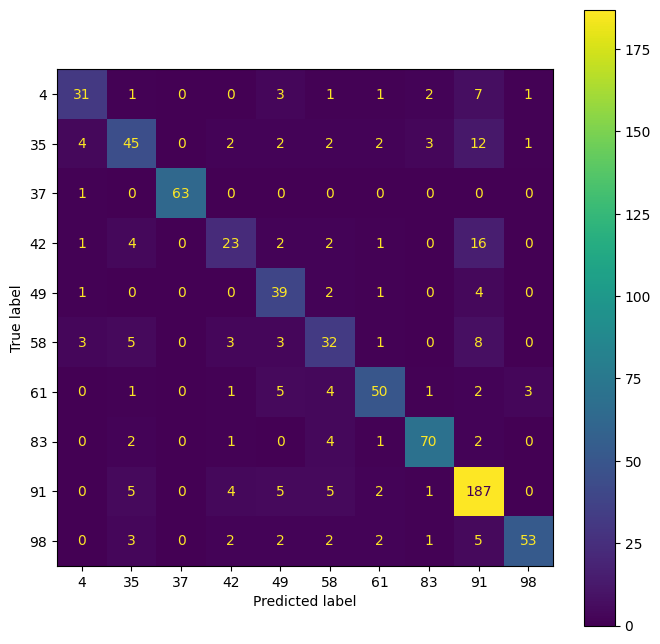

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_display_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_svc.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:

accuracy = balanced_accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc, average='macro')
precision = precision_score(y_test, y_pred_svc, average = 'macro')
f1 = f1_score(y_test, y_pred_svc, average = 'macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7414529351176803
Recall: 0.7414529351176803
Precision: 0.770918994370495
F1-score: 0.7517592686984795


In [ ]:
print("Accuracy test: ", model_svc.score(X_test, y_test))
print("Accuracy train: ", model_svc.score(X_train, y_train))

Accuracy test:  0.7792378449408672
Accuracy train:  0.9379582628313593


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(svc, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.74654651 0.69056804 0.6900623  0.68470058 0.68806317] 
 Mean:  0.6999881189271434
Precision:
 [0.794812   0.71342895 0.75589744 0.68419584 0.75447541] 
 Mean:  0.7405619280100705
Recall:
 [0.74654651 0.69056804 0.6900623  0.68470058 0.68806317] 
 Mean:  0.6999881189271434
F1-score:
 [0.7565591  0.69699372 0.71299078 0.67819326 0.71120344] 
 Mean:  0.7111880607595228


In [ ]:
score_result= score_result.append({"Model":"SVC","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **RandomForest:**

In [ ]:
model = RandomForestClassifier(random_state=42)
params = {'n_estimators':[50,100,200,300,500],'min_samples_split':[2,3,5,10],'min_samples_leaf':[1,3,5,10],'max_depth':[1,3,5,10,None], 'class_weight':['balanced', None]}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 10, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='f1_macro', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(n_estimators=200, random_state=42)
0.806456854777859


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
model_rf = rf.fit(X_train,y_train)

In [ ]:
y_pred_rf = model_rf.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_rf.squeeze()})
print(df_pred)

      Actual  Predicted
2981      91         91
684       49         91
3572      58         35
2467      91         91
1945       4         91
...      ...        ...
3482      91         91
2831       4          4
194       49         49
1907      35         91
1212      83         83

[761 rows x 2 columns]


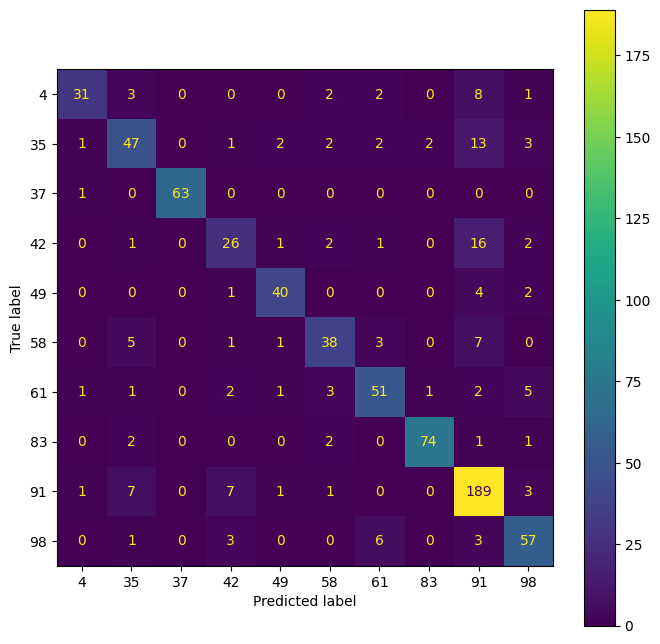

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_rf.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7765156214349901
Recall: 0.7765156214349901
Precision: 0.8144620775584832
F1-score: 0.792480675647721


In [ ]:
print("Accuracy test: ", model_rf.score(X_test, y_test))
print("Accuracy train: ", model_rf.score(X_train, y_train))

Accuracy test:  0.80946123521682
Accuracy train:  0.9639029892837


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(rf, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.78790182 0.72997641 0.70198329 0.75314394 0.68244303] 
 Mean:  0.7310896989189672
Precision:
 [0.83571809 0.77171325 0.75339688 0.74384921 0.76142993] 
 Mean:  0.7732214710047369
Recall:
 [0.78790182 0.72997641 0.70198329 0.75314394 0.68244303] 
 Mean:  0.7310896989189672
F1-score:
 [0.80212072 0.74364878 0.72092143 0.7429825  0.70583516] 
 Mean:  0.743101718437272


In [ ]:
score_result= score_result.append({"Model":"RF","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **KNN:**

In [ ]:
model = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,7,10,20],'weights':['uniform','distance'],'leaf_size':[5,10,30,50,100],'p':[1,2,3]}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 30, 50, 100],
                         'n_neighbors': [2, 3, 4, 5, 7, 10, 20], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'leaf_size': 50, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=50, n_neighbors=3, p=1, weights='distance')
0.7873848455598284


In [ ]:
knn = KNeighborsClassifier(leaf_size=50, n_neighbors=3, p=1, weights='distance')

In [ ]:
model_knn = knn.fit(X_train,y_train)

In [ ]:
y_pred_knn = model_knn.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_knn.squeeze()})
print(df_pred)

      Actual  Predicted
2981      91         91
684       49          4
3572      58         35
2467      91         91
1945       4          4
...      ...        ...
3482      91         91
2831       4          4
194       49         49
1907      35          4
1212      83         83

[761 rows x 2 columns]


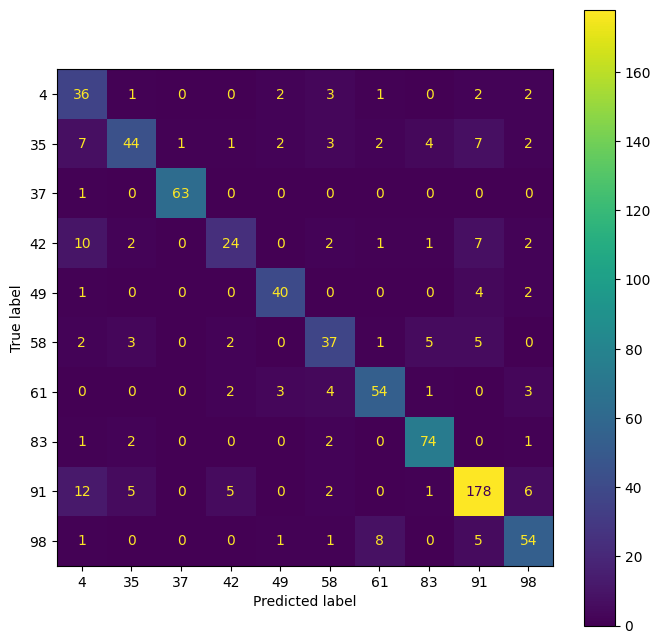

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_knn.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn, average='macro')
precision = precision_score(y_test, y_pred_knn, average='macro')
f1 = f1_score(y_test, y_pred_knn, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.772073255554839
Recall: 0.772073255554839
Precision: 0.7759952445844257
F1-score: 0.768260198816181


In [ ]:
print("Accuracy test: ", model_knn.score(X_test, y_test))
print("Accuracy train: ", model_knn.score(X_train, y_train))

Accuracy test:  0.7936925098554534
Accuracy train:  0.949238578680203


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(knn, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.76893967 0.69681804 0.68864996 0.71595779 0.70371868] 
 Mean:  0.7148168288351215
Precision:
 [0.76262363 0.74230825 0.69222222 0.68917971 0.70672088] 
 Mean:  0.7186109382344941
Recall:
 [0.76893967 0.69681804 0.68864996 0.71595779 0.70371868] 
 Mean:  0.7148168288351215
F1-score:
 [0.75473628 0.70892006 0.67860527 0.69718597 0.69174128] 
 Mean:  0.706237771379603


In [ ]:
score_result= score_result.append({"Model":"KNN","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **Results:**

In [ ]:
score_result

Model  Balanced Accuracy  Precision    Recall  F1-score
0   SVC           0.699988   0.740562  0.699988  0.711188
1    RF           0.731090   0.773221  0.731090  0.743102
2   KNN           0.714817   0.718611  0.714817  0.706238

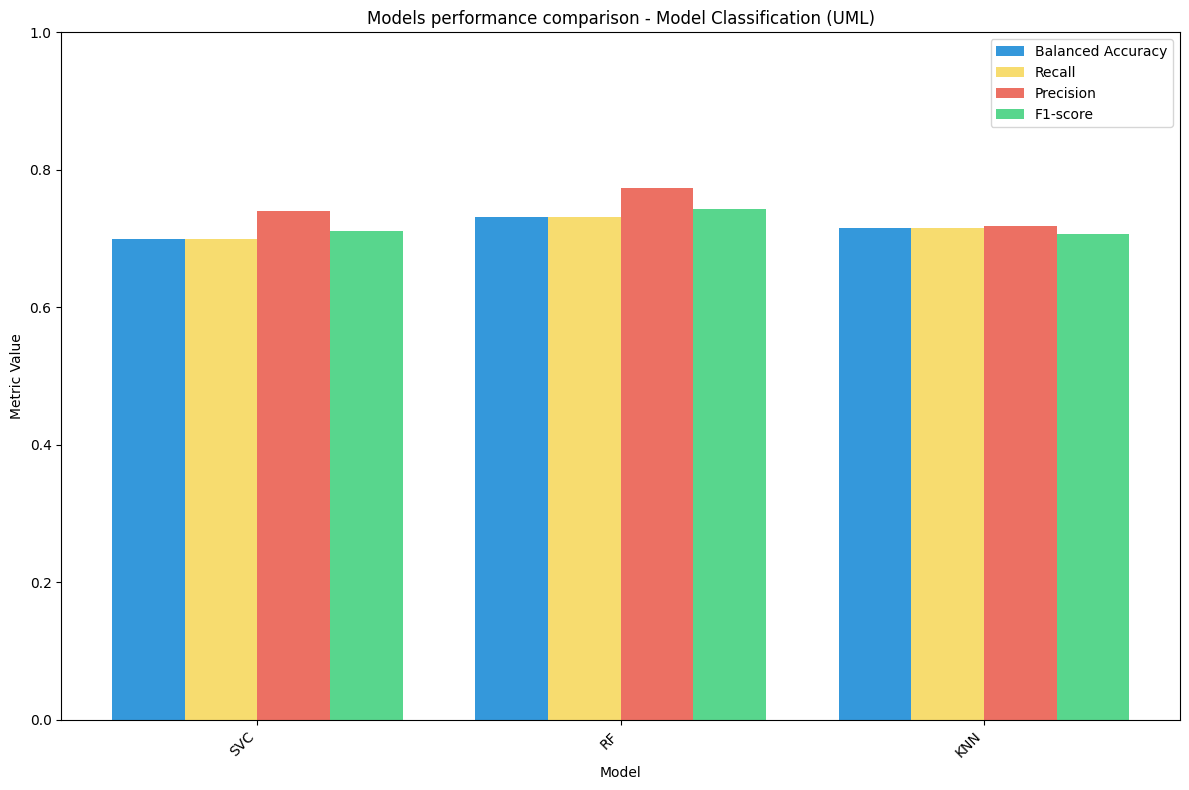

In [ ]:
# plot results
metrics = ['Balanced Accuracy', 'Recall', 'Precision', 'F1-score']
colors = ['#3498DB', '#F7DC6F','#EC7063', '#58D68D']

num_models = len(score_result)
width_bar = 0.20
x = range(num_models)

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    pos_x = [pos + i * width_bar for pos in x]
    values_metric = score_result[metric]

    plt.bar(
        pos_x,
        values_metric,
        width=width_bar,
        label=metric,
        color=colors[i],
    )

plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Models performance comparison - Model Classification (UML)')
plt.xticks([pos + (len(metrics) - 1) * width_bar / 2 for pos in x], score_result['Model'], rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0,1)
plt.show()

In [ ]:
y_test.value_counts()

91    209
83     80
35     73
98     70
61     67
37     64
58     55
42     49
49     47
4      47
Name: label, dtype: int64

In [ ]:
classes_interes_transf = label_encoder_nclasses.inverse_transform(class_labels)
mapeo_classes_interes = {class_label: number for class_label, number in zip(classes_interes_transf, class_labels)}
print("Mapping classes to numbers:")
for class_label, number in mapeo_classes_interes.items():
    print(f"{class_label}: {number}")

Mapping classes to numbers:
bank: 4
computer-videogames: 35
computerarchitecture: 37
course: 42
employee: 49
health: 58
library: 61
restaurant: 83
shopping: 91
smarthouse: 98


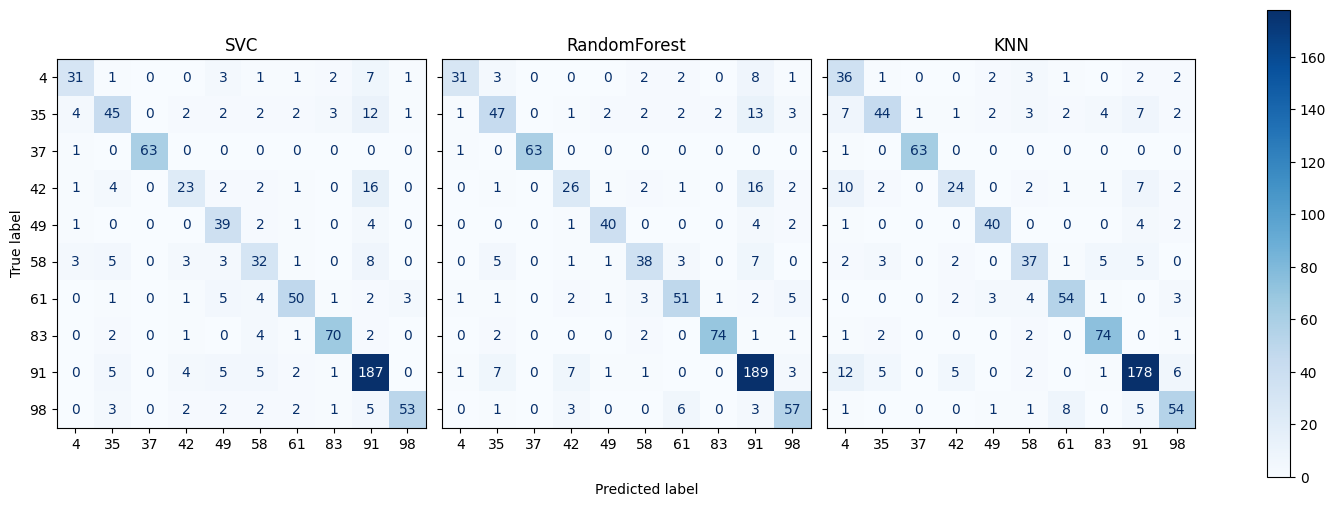

In [ ]:
classifiers = ["SVC", "RandomForest", "KNN"]
matrices_confusion = [cm_svc, cm_rf, cm_knn]
class_names = ["4", "35", "37", "42", "49", "58", "61", "83", "91", "98"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey="row")

for i, (cm, classifier_name) in enumerate(zip(matrices_confusion, classifiers)):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(classifier_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.tight_layout()
fig.text(0.4, 0.0, "Predicted label", ha="left")
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
report_svc = classification_report(y_test, y_pred_svc, target_names=classes_interes_transf)
print(report_svc)

                      precision    recall  f1-score   support

                bank       0.76      0.66      0.70        47
 computer-videogames       0.68      0.62      0.65        73
computerarchitecture       1.00      0.98      0.99        64
              course       0.64      0.47      0.54        49
            employee       0.64      0.83      0.72        47
              health       0.59      0.58      0.59        55
             library       0.82      0.75      0.78        67
          restaurant       0.90      0.88      0.89        80
            shopping       0.77      0.89      0.83       209
          smarthouse       0.91      0.76      0.83        70

            accuracy                           0.78       761
           macro avg       0.77      0.74      0.75       761
        weighted avg       0.78      0.78      0.78       761



In [ ]:
report_rf = classification_report(y_test, y_pred_rf, target_names=classes_interes_transf)
print(report_rf)

                      precision    recall  f1-score   support

                bank       0.89      0.66      0.76        47
 computer-videogames       0.70      0.64      0.67        73
computerarchitecture       1.00      0.98      0.99        64
              course       0.63      0.53      0.58        49
            employee       0.87      0.85      0.86        47
              health       0.76      0.69      0.72        55
             library       0.78      0.76      0.77        67
          restaurant       0.96      0.93      0.94        80
            shopping       0.78      0.90      0.84       209
          smarthouse       0.77      0.81      0.79        70

            accuracy                           0.81       761
           macro avg       0.81      0.78      0.79       761
        weighted avg       0.81      0.81      0.81       761



In [ ]:
report_knn = classification_report(y_test, y_pred_knn, target_names=classes_interes_transf)
print(report_knn)

                      precision    recall  f1-score   support

                bank       0.51      0.77      0.61        47
 computer-videogames       0.77      0.60      0.68        73
computerarchitecture       0.98      0.98      0.98        64
              course       0.71      0.49      0.58        49
            employee       0.83      0.85      0.84        47
              health       0.69      0.67      0.68        55
             library       0.81      0.81      0.81        67
          restaurant       0.86      0.93      0.89        80
            shopping       0.86      0.85      0.85       209
          smarthouse       0.75      0.77      0.76        70

            accuracy                           0.79       761
           macro avg       0.78      0.77      0.77       761
        weighted avg       0.80      0.79      0.79       761





---

Las clases que mejor se predicen segun F1-score son:
- computerarchitecture ---> 37
- restaurant ---> 83
- shopping ---> 91
- employee ---> 49
- smarthouse ---> 98

---



# Instance Selection:

In this section, we perform the selection of instances to be studied in local explainability. The selected instances must meet the condition of being classified in the same class by all three models.

In [ ]:
df_preds = pd.DataFrame({'Real': y_test, 'Pred_SVC': y_pred_svc, 'Pred_RF': y_pred_rf, 'Pred_KNN': y_pred_knn})
df_preds = df_preds[(df_preds['Real'] == df_preds['Pred_SVC']) & (df_preds['Real'] == df_preds['Pred_RF']) & (df_preds['Real'] == df_preds['Pred_KNN'])]

In [ ]:
df_preds

Real  Pred_SVC  Pred_RF  Pred_KNN
2981    91        91       91        91
2467    91        91       91        91
1253    91        91       91        91
4911    83        83       83        83
4572    61        61       61        61
...    ...       ...      ...       ...
278     49        49       49        49
3482    91        91       91        91
2831     4         4        4         4
194     49        49       49        49
1212    83        83       83        83

[556 rows x 4 columns]

In [ ]:
df_class_comp = df_preds[df_preds['Real'] == 37]
df_class_rest = df_preds[df_preds['Real'] == 83]
df_class_shop = df_preds[df_preds['Real'] == 91]
df_class_emp = df_preds[df_preds['Real'] == 49]
df_class_smart = df_preds[df_preds['Real'] == 98]

In [ ]:
print(f"Number of instances for the class Computerarchitecture: {len(df_class_comp)}")
print(f"Number of instances for the class Restaurant: {len(df_class_rest)}")
print(f"Number of instances for the class Shopping: {len(df_class_shop)}")
print(f"Number of instances for the class Employee: {len(df_class_emp)}")
print(f"Number of instances for the class Smarthouse: {len(df_class_smart)}")

Number of instances for the class Computerarchitecture: 63
Number of instances for the class Restaurant: 68
Number of instances for the class Shopping: 171
Number of instances for the class Employee: 39
Number of instances for the class Smarthouse: 47


In [ ]:
df_class_comp.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
2796    37        37       37        37
2428    37        37       37        37
1383    37        37       37        37
3567    37        37       37        37
2990    37        37       37        37

In [ ]:
X_preds = X_test.loc[df_preds[df_preds['Real'] == 37].index]
X_preds.head()

type_Class  type_Relationship  type_Package  type_Actor  type_DataType  \
2796    1.604674           0.894048     -0.301137   -0.558924       -0.24578   
2428    1.466851           0.894048     -0.301137   -0.558924       -0.24578   
1383    1.466851           0.894048     -0.301137   -0.558924       -0.24578   
3567    1.466851           0.894048     -0.301137   -0.558924       -0.24578   
2990    1.466851           0.894048     -0.301137   -0.558924       -0.24578   

      type_Operation  type_Transition  type_State  type_Property  \
2796        1.355932        -0.071115   -0.071935      -0.196282   
2428        1.355932        -0.071115   -0.071935      -0.196282   
1383        1.355932        -0.071115   -0.071935      -0.196282   
3567        1.355932        -0.071115   -0.071935      -0.196282   
2990        1.355932        -0.071115   -0.071935      -0.196282   

      type_UseCase  type_Component  type_Enumeration  type_Activity  
2796      -0.61616       -0.363755         -0.464982      -0.441478  
2428      -0.61616       -0.363755         -0.464982      -0.441478  
1383      -0.61616       -0.363755         -0.464982      -0.441478  
3567      -0.61616       -0.363755         -0.464982       0.981686  
2990      -0.61616       -0.363755         -0.464982      -0.441478

In [ ]:
instances_class = df_preds[df_preds['Real'] == 37]
instances_class.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
2796    37        37       37        37
2428    37        37       37        37
1383    37        37       37        37
3567    37        37       37        37
2990    37        37       37        37

In [ ]:
df_class_rest.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
4911    83        83       83        83
2063    83        83       83        83
1227    83        83       83        83
709     83        83       83        83
1145    83        83       83        83

In [ ]:
df_class_shop.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
2981    91        91       91        91
2467    91        91       91        91
1253    91        91       91        91
4056    91        91       91        91
3070    91        91       91        91

In [ ]:
df_class_emp.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
1013    49        49       49        49
2135    49        49       49        49
1141    49        49       49        49
4926    49        49       49        49
2696    49        49       49        49

In [ ]:
df_class_smart.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
1278    98        98       98        98
1586    98        98       98        98
273     98        98       98        98
4084    98        98       98        98
78      98        98       98        98

In [ ]:
dfs_select = ["df_class_comp", "df_class_rest", "df_class_shop", "df_class_emp", "df_class_smart"]
inst_select_indexes = {}

for df_select in dfs_select:
    df = globals()[df_select]
    if len(df) > 100:
        indexes_inst = df.sample(n=100, random_state=42).index
    else:
        indexes_inst = df.index
    indexes_inst = list(indexes_inst)
    inst_select_indexes[df_select] = indexes_inst

In [ ]:
with open('uml_multiclass_indexes.pickle', 'wb') as f:
    pickle.dump(inst_select_indexes, f)

In [ ]:
classes_selected = [37, 83, 91, 49, 98]

for class_label in classes_selected:
    instances_class = df_preds[df_preds['Real'] == class_label]
    X_preds = X_test.loc[df_preds[df_preds['Real'] == class_label].index]

    probab_pred_svc = svc.predict_proba(X_preds)
    probab_pred_rf = rf.predict_proba(X_preds)
    probab_pred_knn = knn.predict_proba(X_preds)

    index_class = np.where(classes_interes_transf ==  label_encoder_nclasses.inverse_transform([class_label]))[0][0]

    prob_svc = probab_pred_svc[:, index_class]
    prob_rf = probab_pred_rf[:, index_class]
    prob_knn = probab_pred_knn[:, index_class]

    index_max_prob_svc = prob_svc.argmax()
    index_max_prob_rf = prob_rf.argmax()
    index_max_prob_knn = prob_knn.argmax()

    instance_max_prob_svc = instances_class.iloc[index_max_prob_svc]
    instance_max_prob_rf = instances_class.iloc[index_max_prob_rf]
    instance_max_prob_knn = instances_class.iloc[index_max_prob_knn]

    if class_label == 37:
      inst_comp_svc = instance_max_prob_svc.name
      inst_comp_rf = instance_max_prob_rf.name
      inst_comp_knn = instance_max_prob_knn.name
    elif class_label == 83:
      inst_rest_svc = instance_max_prob_svc.name
      inst_rest_rf = instance_max_prob_rf.name
      inst_rest_knn = instance_max_prob_knn.name
    elif class_label == 91:
      inst_shop_svc = instance_max_prob_svc.name
      inst_shop_rf = instance_max_prob_rf.name
      inst_shop_knn = instance_max_prob_knn.name
    elif class_label == 49:
      inst_emp_svc = instance_max_prob_svc.name
      inst_emp_rf = instance_max_prob_rf.name
      inst_emp_knn = instance_max_prob_knn.name
    elif class_label == 98:
      inst_smart_svc = instance_max_prob_svc.name
      inst_smart_rf = instance_max_prob_rf.name
      inst_smart_knn = instance_max_prob_knn.name

    print(f"For class {class_label} ({label_encoder_nclasses.inverse_transform([class_label])[0]})")
    print(f"Instance with higher predict_proba SVC: {instance_max_prob_svc.name}")
    print(f"Instance with higher predict_proba RF: {instance_max_prob_rf.name}")
    print(f"Instance with higher predict_proba KNN: {instance_max_prob_knn.name}")
    print("------------------------------------------------------------------------")

For class 37 (computerarchitecture)
Instance with higher predict_proba SVC: 2796
Instance with higher predict_proba RF: 2796
Instance with higher predict_proba KNN: 2796
------------------------------------------------------------------------
For class 83 (restaurant)
Instance with higher predict_proba SVC: 4911
Instance with higher predict_proba RF: 4911
Instance with higher predict_proba KNN: 4911
------------------------------------------------------------------------
For class 91 (shopping)
Instance with higher predict_proba SVC: 3332
Instance with higher predict_proba RF: 2467
Instance with higher predict_proba KNN: 2467
------------------------------------------------------------------------
For class 49 (employee)
Instance with higher predict_proba SVC: 1668
Instance with higher predict_proba RF: 1013
Instance with higher predict_proba KNN: 1013
------------------------------------------------------------------------
For class 98 (smarthouse)
Instance with higher predict_proba S

# Explainability:

# Global Explainability:

We conduct the study of global explainability using permutation importance.

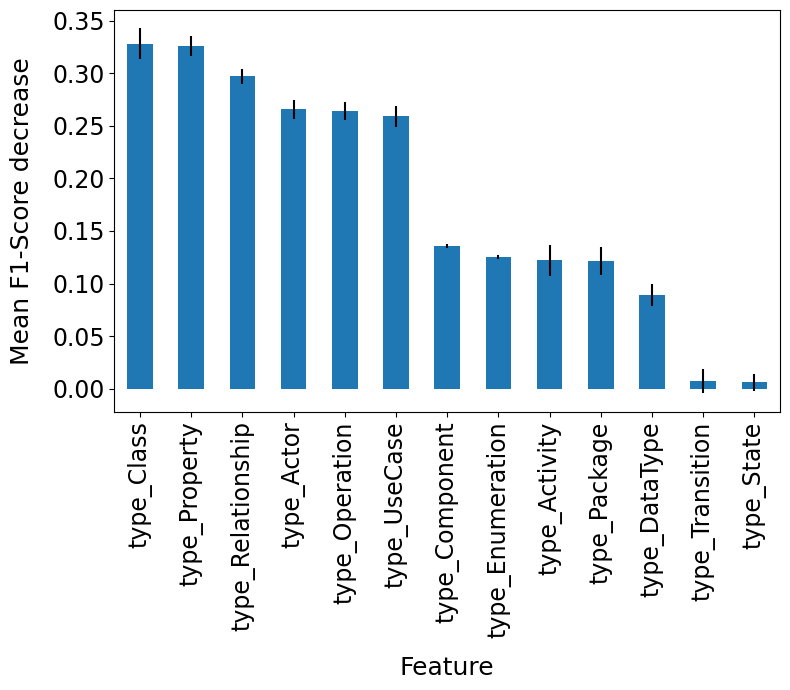

In [ ]:
permu = permutation_importance(model_svc, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_multiclass_globSVC.pdf')
plt.show()

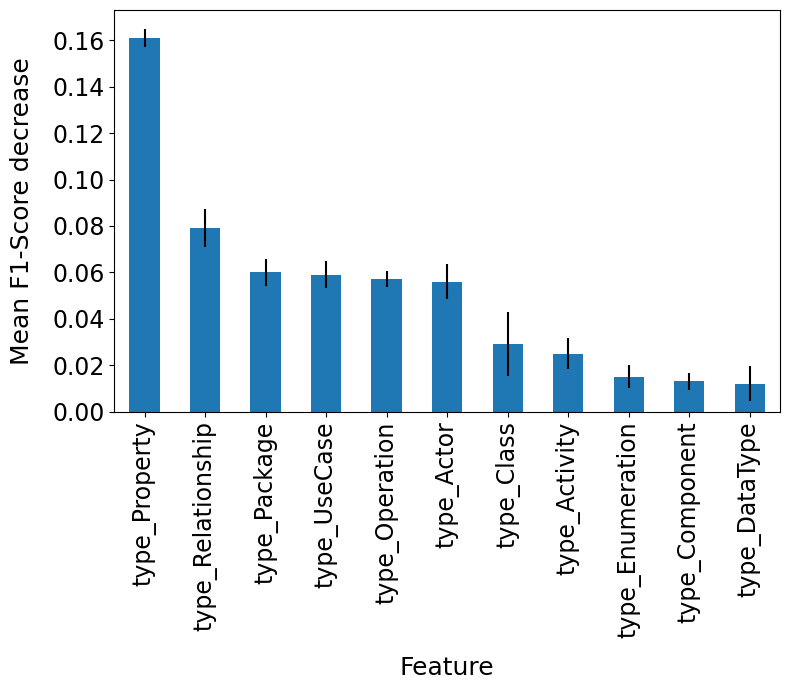

In [ ]:
permu = permutation_importance(model_rf, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_multiclass_globRF.pdf')
plt.show()

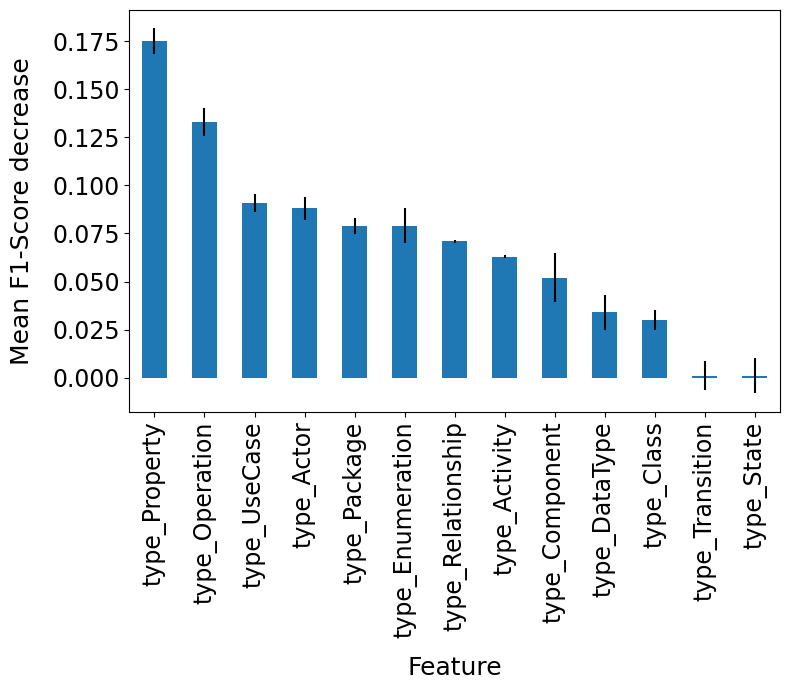

In [ ]:
permu = permutation_importance(model_knn, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_multiclass_globKNN.pdf')
plt.show()

# Local Explainability:

Finally, we obtain explanations for the selected instances and calculate the disagreement metrics.

In [ ]:
num_features = len(col)
top_num_features = 10

In [ ]:
unique_values = np.unique(y_train)
inst_names = ["computerarchitecture", "restaurant", "shopping", "employee", "smarthouse"]
class_index = [2, 4, 7, 8, 9]

## SVC:

In [ ]:
exp_list_svc = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_svc, X_train,
        y_train,
        predict_function=pf,
        label=f'SVC: class {class_value}',
        verbose=False
    )
    exp_list_svc += [e]

exp_list_svc

In [ ]:
inst_computervideogames = X_test.loc[inst_comp_svc]
inst_course = X_test.loc[inst_rest_svc]
inst_library = X_test.loc[inst_shop_svc]
inst_bank = X_test.loc[inst_emp_svc]
inst_employee = X_test.loc[inst_smart_svc]

In [ ]:
svc_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_svc]
    svc_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_svc]
    svc_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_svc)]
    svc_exp_results[f"lime_{instance}"] = lime_exp

### **Computer-Videogames:**

In [ ]:
breakdown_df_computervideogames_ban = svc_exp_results['breakdown_computervideogames'][0].result
shap_df_computervideogames_ban = svc_exp_results['shap_computervideogames'][0].result
lime_df_computervideogames_ban = svc_exp_results['lime_computervideogames'][0].result

In [ ]:
breakdown_df_computervideogames_vid = svc_exp_results['breakdown_computervideogames'][1].result
shap_df_computervideogames_vid = svc_exp_results['shap_computervideogames'][1].result
lime_df_computervideogames_vid = svc_exp_results['lime_computervideogames'][1].result

In [ ]:
breakdown_df_computervideogames_cou = svc_exp_results['breakdown_computervideogames'][3].result
shap_df_computervideogames_cou = svc_exp_results['shap_computervideogames'][3].result
lime_df_computervideogames_cou = svc_exp_results['lime_computervideogames'][3].result

In [ ]:
breakdown_df_computervideogames_emp = svc_exp_results['breakdown_computervideogames'][4].result
shap_df_computervideogames_emp = svc_exp_results['shap_computervideogames'][4].result
lime_df_computervideogames_emp = svc_exp_results['lime_computervideogames'][4].result

In [ ]:
breakdown_df_computervideogames_lib = svc_exp_results['breakdown_computervideogames'][6].result
shap_df_computervideogames_lib = svc_exp_results['shap_computervideogames'][6].result
lime_df_computervideogames_lib = svc_exp_results['lime_computervideogames'][6].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_computervideogames'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_computervideogames'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

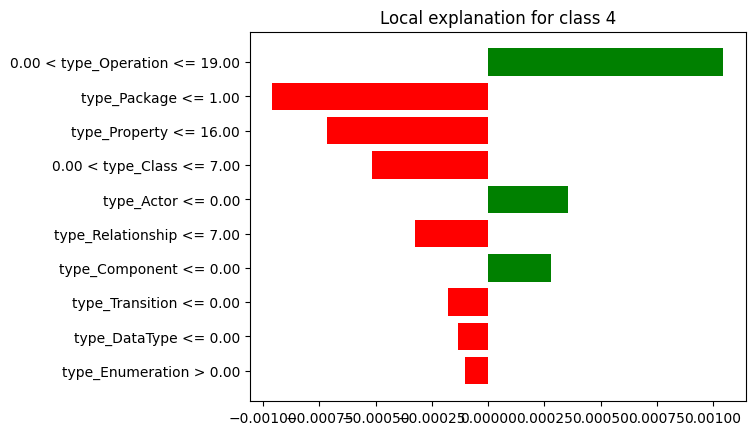

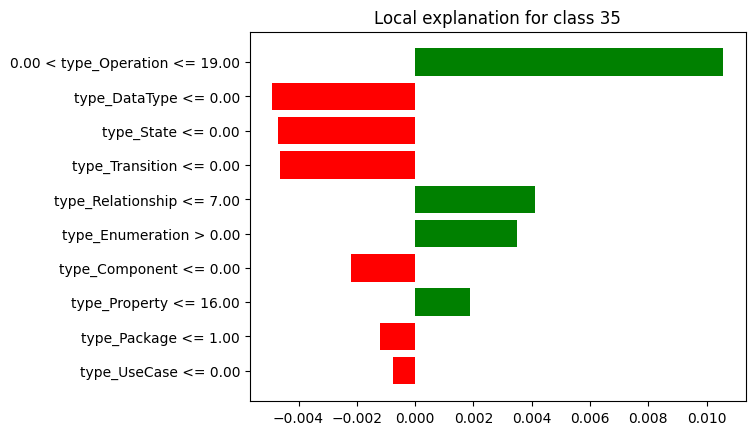

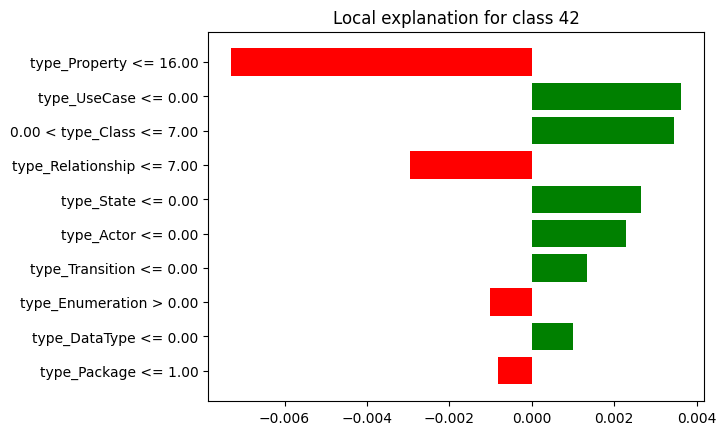

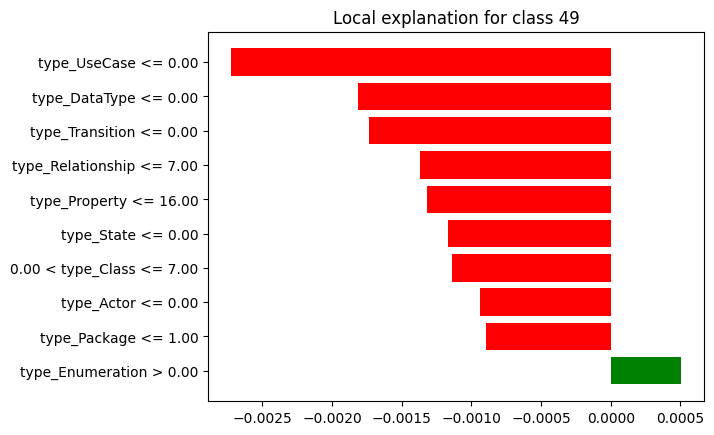

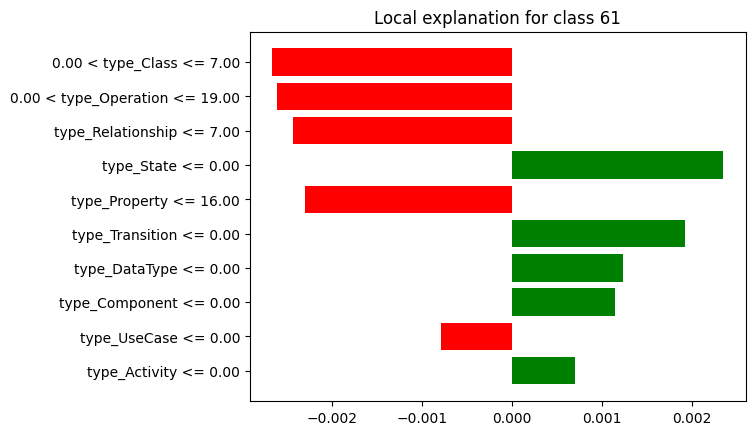

In [ ]:
for i in class_index:
  svc_exp_results['lime_computervideogames'][i].plot()

In [ ]:
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(index=[0, 14])
breakdown_df_computervideogames_ban['sign'] = breakdown_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_ban = shap_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_ban = shap_df_computervideogames_ban.tail(13)
shap_df_computervideogames_ban['sign'] = shap_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_ban = shap_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_ban["Feature"] = lime_df_computervideogames_ban["variable"].str.split(" ").str[0]
lime_df_computervideogames_ban["Sign"] = lime_df_computervideogames_ban["effect"].apply(evaluate_value)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['variable'])

breakdown_df_computervideogames_ban['Ranking'] = breakdown_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_ban['Ranking'] = shap_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_ban = shap_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_ban['Ranking'] = lime_df_computervideogames_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.head(10)
lime_df_computervideogames_ban = lime_df_computervideogames_ban[['Feature', 'Ranking', 'effect', 'Sign']]

breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(columns=['contribution'])
shap_df_computervideogames_ban = shap_df_computervideogames_ban.drop(columns=['contribution'])
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['effect'])

breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.head(10)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.reset_index(drop=True)

shap_df_computervideogames_ban= shap_df_computervideogames_ban.head(10)
shap_df_computervideogames_ban = shap_df_computervideogames_ban.reset_index(drop=True)

lime_df_computervideogames_ban = lime_df_computervideogames_ban.reset_index(drop=True)
lime_df_computervideogames_ban.at[0, "Feature"] = "type_Operation"
lime_df_computervideogames_ban.at[3, "Feature"] = "type_Class"

print(breakdown_df_computervideogames_ban)
print("---------------------------------")
print(shap_df_computervideogames_ban)
print("---------------------------------")
print(lime_df_computervideogames_ban)

             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1       type_Package        2  Negative
2      type_Property        3  Negative
3     type_Operation        4  Negative
4         type_Actor        5  Positive
5       type_UseCase        6  Negative
6         type_Class        7  Negative
7      type_DataType        8  Positive
8   type_Enumeration        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1     type_Operation        2  Negative
2  type_Relationship        3  Negative
3         type_Class        4  Negative
4       type_Package        5  Negative
5       type_UseCase        6  Negative
6   type_Enumeration        7  Positive
7      type_DataType        8  Positive
8         type_Actor        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_ban['Feature'])
shap_features = list(shap_df_computervideogames_ban['Feature'])
lime_features = list(lime_df_computervideogames_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_ban['Feature'] = list(all_features)
df_final_vid_ban= df_final_vid_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_ban['Feature']:

    breakdown_row = breakdown_df_computervideogames_ban[breakdown_df_computervideogames_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_ban[shap_df_computervideogames_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_ban[lime_df_computervideogames_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_ban = df_final_vid_ban.loc[casos_validos]
df_final_vid_ban.set_index('Feature', inplace=True)
df_final_vid_ban

['type_Relationship', 'type_Package', 'type_Property', 'type_Operation', 'type_Actor', 'type_UseCase', 'type_Class', 'type_DataType', 'type_Enumeration', 'type_Activity']
['type_Property', 'type_Operation', 'type_Relationship', 'type_Class', 'type_Package', 'type_UseCase', 'type_Enumeration', 'type_DataType', 'type_Actor', 'type_Activity']
['type_Operation', 'type_Package', 'type_Property', 'type_Class', 'type_Actor', 'type_Relationship', 'type_Component', 'type_Transition', 'type_DataType', 'type_Enumeration']
['type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       3  Negative       6  Negative
type_Package              2  Negative       5  Negative       2  Negative
type_Property             3  Negative       1  Negative       3  Negative
type_Operation            4  Negative       2  Negative       1  Positive
type_Actor                5  Positive       9  Negative       5  Positive
type_UseCase              6  Negative       6  Negative       -         -
type_Class                7  Negative       4  Negative       4  Negative
type_DataType             8  Positive       8  Positive       9  Negative
type_Enumeration          9  Negative       7  Positive      10  Negative
type_Activity            10  Positive      10  Negative       -         -
type_Component            -         -       -         -       7  Positive
type_Transition           -         -       -         -       8  Negative

In [ ]:
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(index=[0, 14])
breakdown_df_computervideogames_vid['sign'] = breakdown_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_vid = shap_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_vid = shap_df_computervideogames_vid.tail(13)
shap_df_computervideogames_vid['sign'] = shap_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_vid = shap_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_vid["Feature"] = lime_df_computervideogames_vid["variable"].str.split(" ").str[0]
lime_df_computervideogames_vid["Sign"] = lime_df_computervideogames_vid["effect"].apply(evaluate_value)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['variable'])


breakdown_df_computervideogames_vid['Ranking'] = breakdown_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_vid['Ranking'] = shap_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_vid = shap_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_vid['Ranking'] = lime_df_computervideogames_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.head(10)
lime_df_computervideogames_vid = lime_df_computervideogames_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(columns=['contribution'])
shap_df_computervideogames_vid = shap_df_computervideogames_vid.drop(columns=['contribution'])
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['effect'])


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.head(10)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.reset_index(drop=True)

shap_df_computervideogames_vid= shap_df_computervideogames_vid.head(10)
shap_df_computervideogames_vid = shap_df_computervideogames_vid.reset_index(drop=True)

lime_df_computervideogames_vid = lime_df_computervideogames_vid.reset_index(drop=True)
lime_df_computervideogames_vid.at[0, "Feature"] = "type_Operation"

print(breakdown_df_computervideogames_vid)
print("---------------------------------")
print(shap_df_computervideogames_vid)
print("---------------------------------")
print(lime_df_computervideogames_vid)

             Feature  Ranking      Sign
0   type_Enumeration        1  Positive
1     type_Operation        2  Positive
2      type_Property        3  Positive
3         type_Class        4  Positive
4  type_Relationship        5  Positive
5      type_DataType        6  Positive
6       type_UseCase        7  Positive
7         type_Actor        8  Positive
8      type_Activity        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1      type_Property        2  Positive
2  type_Relationship        3  Positive
3   type_Enumeration        4  Positive
4         type_Class        5  Positive
5       type_UseCase        6  Positive
6         type_Actor        7  Positive
7       type_Package        8  Positive
8      type_Activity        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_vid['Feature'])
shap_features = list(shap_df_computervideogames_vid['Feature'])
lime_features = list(lime_df_computervideogames_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_vid['Feature'] = list(all_features)
df_final_vid_vid= df_final_vid_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_vid['Feature']:

    breakdown_row = breakdown_df_computervideogames_vid[breakdown_df_computervideogames_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_vid[shap_df_computervideogames_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_vid[lime_df_computervideogames_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_vid = df_final_vid_vid.loc[casos_validos]
df_final_vid_vid.set_index('Feature', inplace=True)
df_final_vid_vid

['type_Enumeration', 'type_Operation', 'type_Property', 'type_Class', 'type_Relationship', 'type_DataType', 'type_UseCase', 'type_Actor', 'type_Activity', 'type_Package']
['type_Operation', 'type_Property', 'type_Relationship', 'type_Enumeration', 'type_Class', 'type_UseCase', 'type_Actor', 'type_Package', 'type_Activity', 'type_DataType']
['type_Operation', 'type_DataType', 'type_State', 'type_Transition', 'type_Relationship', 'type_Enumeration', 'type_Component', 'type_Property', 'type_Package', 'type_UseCase']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Enumeration          1  Positive       4  Positive       6  Positive
type_Operation            2  Positive       1  Positive       1  Positive
type_Property             3  Positive       2  Positive       8  Positive
type_Class                4  Positive       5  Positive       -         -
type_Relationship         5  Positive       3  Positive       5  Positive
type_DataType             6  Positive      10  Positive       2  Negative
type_UseCase              7  Positive       6  Positive      10  Negative
type_Actor                8  Positive       7  Positive       -         -
type_Activity             9  Positive       9  Positive       -         -
type_Package             10  Positive       8  Positive       9  Negative
type_State                -         -       -         -       3  Negative
type_Component            -         -       -         -       7  Negative
type_Transition           -         -       -         -       4  Negative

In [ ]:
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(index=[0, 14])
breakdown_df_computervideogames_cou['sign'] = breakdown_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_cou = shap_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_cou = shap_df_computervideogames_cou.tail(13)
shap_df_computervideogames_cou['sign'] = shap_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_cou = shap_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_cou["Feature"] = lime_df_computervideogames_cou["variable"].str.split(" ").str[0]
lime_df_computervideogames_cou["Sign"] = lime_df_computervideogames_cou["effect"].apply(evaluate_value)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['variable'])


breakdown_df_computervideogames_cou['Ranking'] = breakdown_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_cou['Ranking'] = shap_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_cou = shap_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_cou['Ranking'] = lime_df_computervideogames_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.head(10)
lime_df_computervideogames_cou = lime_df_computervideogames_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(columns=['contribution'])
shap_df_computervideogames_cou = shap_df_computervideogames_cou.drop(columns=['contribution'])
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['effect'])


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.head(10)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.reset_index(drop=True)

shap_df_computervideogames_cou= shap_df_computervideogames_cou.head(10)
shap_df_computervideogames_cou = shap_df_computervideogames_cou.reset_index(drop=True)

lime_df_computervideogames_cou = lime_df_computervideogames_cou.reset_index(drop=True)
lime_df_computervideogames_cou.at[2, "Feature"] = "type_Class"

print(breakdown_df_computervideogames_cou)
print("---------------------------------")
print(shap_df_computervideogames_cou)
print("---------------------------------")
print(lime_df_computervideogames_cou)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1     type_Operation        2  Positive
2         type_Class        3  Negative
3      type_DataType        4  Negative
4   type_Enumeration        5  Positive
5         type_Actor        6  Negative
6  type_Relationship        7  Negative
7       type_UseCase        8  Negative
8      type_Activity        9  Negative
9     type_Component       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Negative
2     type_Operation        3  Negative
3   type_Enumeration        4  Positive
4         type_Actor        5  Negative
5      type_DataType        6  Negative
6  type_Relationship        7  Negative
7       type_UseCase        8  Negative
8       type_Package        9  Positive
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_cou['Feature'])
shap_features = list(shap_df_computervideogames_cou['Feature'])
lime_features = list(lime_df_computervideogames_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_cou['Feature'] = list(all_features)
df_final_vid_cou= df_final_vid_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_cou['Feature']:

    breakdown_row = breakdown_df_computervideogames_cou[breakdown_df_computervideogames_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_cou[shap_df_computervideogames_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_cou[lime_df_computervideogames_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_cou = df_final_vid_cou.loc[casos_validos]
df_final_vid_cou.set_index('Feature', inplace=True)
df_final_vid_cou

['type_Property', 'type_Operation', 'type_Class', 'type_DataType', 'type_Enumeration', 'type_Actor', 'type_Relationship', 'type_UseCase', 'type_Activity', 'type_Component']
['type_Property', 'type_Class', 'type_Operation', 'type_Enumeration', 'type_Actor', 'type_DataType', 'type_Relationship', 'type_UseCase', 'type_Package', 'type_Activity']
['type_Property', 'type_UseCase', 'type_Class', 'type_Relationship', 'type_State', 'type_Actor', 'type_Transition', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       1  Negative       1  Negative
type_Operation            2  Positive       3  Negative       -         -
type_Class                3  Negative       2  Negative       3  Positive
type_DataType             4  Negative       6  Negative       9  Positive
type_Enumeration          5  Positive       4  Positive       8  Negative
type_Actor                6  Negative       5  Negative       6  Positive
type_Relationship         7  Negative       7  Negative       4  Negative
type_UseCase              8  Negative       8  Negative       2  Positive
type_Activity             9  Negative      10  Negative       -         -
type_Component           10  Negative       -         -       -         -
type_Package              -         -       9  Positive      10  Negative
type_State                -         -       -         -       5  Positive
type_Transition           -         -       -         -       7  Positive

In [ ]:
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(index=[0, 14])
breakdown_df_computervideogames_emp['sign'] = breakdown_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_emp = shap_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_emp = shap_df_computervideogames_emp.tail(13)
shap_df_computervideogames_emp['sign'] = shap_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_emp = shap_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_emp["Feature"] = lime_df_computervideogames_emp["variable"].str.split(" ").str[0]
lime_df_computervideogames_emp["Sign"] = lime_df_computervideogames_emp["effect"].apply(evaluate_value)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['variable'])


breakdown_df_computervideogames_emp['Ranking'] = breakdown_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_emp['Ranking'] = shap_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_emp = shap_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_emp['Ranking'] = lime_df_computervideogames_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.head(10)
lime_df_computervideogames_emp = lime_df_computervideogames_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(columns=['contribution'])
shap_df_computervideogames_emp = shap_df_computervideogames_emp.drop(columns=['contribution'])
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['effect'])


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.head(10)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.reset_index(drop=True)

shap_df_computervideogames_emp= shap_df_computervideogames_emp.head(10)
shap_df_computervideogames_emp = shap_df_computervideogames_emp.reset_index(drop=True)

lime_df_computervideogames_emp = lime_df_computervideogames_emp.reset_index(drop=True)
lime_df_computervideogames_emp.at[6, "Feature"] = "type_Class"

print(breakdown_df_computervideogames_emp)
print("---------------------------------")
print(shap_df_computervideogames_emp)
print("---------------------------------")
print(lime_df_computervideogames_emp)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1     type_Operation        2  Positive
2       type_UseCase        3  Negative
3  type_Relationship        4  Negative
4         type_Class        5  Negative
5   type_Enumeration        6  Negative
6     type_Component        7  Negative
7      type_DataType        8  Negative
8      type_Activity        9  Positive
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1      type_Property        2  Negative
2         type_Class        3  Negative
3  type_Relationship        4  Negative
4         type_Actor        5  Negative
5     type_Operation        6  Negative
6   type_Enumeration        7  Positive
7     type_Component        8  Negative
8       type_Package        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_emp['Feature'])
shap_features = list(shap_df_computervideogames_emp['Feature'])
lime_features = list(lime_df_computervideogames_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_emp['Feature'] = list(all_features)
df_final_vid_emp= df_final_vid_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_emp['Feature']:

    breakdown_row = breakdown_df_computervideogames_emp[breakdown_df_computervideogames_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_emp[shap_df_computervideogames_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_emp[lime_df_computervideogames_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_emp = df_final_vid_emp.loc[casos_validos]
df_final_vid_emp.set_index('Feature', inplace=True)
df_final_vid_emp

['type_Property', 'type_Operation', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Enumeration', 'type_Component', 'type_DataType', 'type_Activity', 'type_Package']
['type_UseCase', 'type_Property', 'type_Class', 'type_Relationship', 'type_Actor', 'type_Operation', 'type_Enumeration', 'type_Component', 'type_Package', 'type_Activity']
['type_UseCase', 'type_DataType', 'type_Transition', 'type_Relationship', 'type_Property', 'type_State', 'type_Class', 'type_Actor', 'type_Package', 'type_Enumeration']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       5  Negative
type_Operation            2  Positive       6  Negative       -         -
type_UseCase              3  Negative       1  Negative       1  Negative
type_Relationship         4  Negative       4  Negative       4  Negative
type_Class                5  Negative       3  Negative       7  Negative
type_Enumeration          6  Negative       7  Positive      10  Positive
type_Component            7  Negative       8  Negative       -         -
type_DataType             8  Negative       -         -       2  Negative
type_Activity             9  Positive      10  Negative       -         -
type_Package             10  Negative       9  Negative       9  Negative
type_Actor                -         -       5  Negative       8  Negative
type_State                -         -       -         -       6  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(index=[0, 14])
breakdown_df_computervideogames_lib['sign'] = breakdown_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_lib = shap_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_lib = shap_df_computervideogames_lib.tail(13)
shap_df_computervideogames_lib['sign'] = shap_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_lib = shap_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_lib["Feature"] = lime_df_computervideogames_lib["variable"].str.split(" ").str[0]
lime_df_computervideogames_lib["Sign"] = lime_df_computervideogames_lib["effect"].apply(evaluate_value)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['variable'])


breakdown_df_computervideogames_lib['Ranking'] = breakdown_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_lib['Ranking'] = shap_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_lib = shap_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_lib['Ranking'] = lime_df_computervideogames_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.head(10)
lime_df_computervideogames_lib = lime_df_computervideogames_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(columns=['contribution'])
shap_df_computervideogames_lib = shap_df_computervideogames_lib.drop(columns=['contribution'])
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['effect'])


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.head(10)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.reset_index(drop=True)

shap_df_computervideogames_lib= shap_df_computervideogames_lib.head(10)
shap_df_computervideogames_lib = shap_df_computervideogames_lib.reset_index(drop=True)

lime_df_computervideogames_lib = lime_df_computervideogames_lib.reset_index(drop=True)
lime_df_computervideogames_lib.at[1, "Feature"] = "type_Operation"
lime_df_computervideogames_lib.at[0, "Feature"] = "type_Class"

print(breakdown_df_computervideogames_lib)
print("---------------------------------")
print(shap_df_computervideogames_lib)
print("---------------------------------")
print(lime_df_computervideogames_lib)

             Feature  Ranking      Sign
0         type_Actor        1  Negative
1  type_Relationship        2  Negative
2     type_Operation        3  Negative
3   type_Enumeration        4  Negative
4       type_UseCase        5  Negative
5     type_Component        6  Negative
6      type_Property        7  Positive
7      type_Activity        8  Positive
8       type_Package        9  Positive
9         type_Class       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1  type_Relationship        2  Negative
2     type_Operation        3  Negative
3         type_Class        4  Negative
4      type_Property        5  Negative
5   type_Enumeration        6  Negative
6         type_Actor        7  Negative
7     type_Component        8  Negative
8      type_DataType        9  Positive
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_lib['Feature'])
shap_features = list(shap_df_computervideogames_lib['Feature'])
lime_features = list(lime_df_computervideogames_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_lib['Feature'] = list(all_features)
df_final_vid_lib= df_final_vid_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_lib['Feature']:

    breakdown_row = breakdown_df_computervideogames_lib[breakdown_df_computervideogames_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_lib[shap_df_computervideogames_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_lib[lime_df_computervideogames_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_lib = df_final_vid_lib.loc[casos_validos]
df_final_vid_lib.set_index('Feature', inplace=True)
df_final_vid_lib

['type_Actor', 'type_Relationship', 'type_Operation', 'type_Enumeration', 'type_UseCase', 'type_Component', 'type_Property', 'type_Activity', 'type_Package', 'type_Class']
['type_UseCase', 'type_Relationship', 'type_Operation', 'type_Class', 'type_Property', 'type_Enumeration', 'type_Actor', 'type_Component', 'type_DataType', 'type_Activity']
['type_Class', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_Transition', 'type_DataType', 'type_Component', 'type_UseCase', 'type_Activity']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_Operation', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       7  Negative       -         -
type_Relationship         2  Negative       2  Negative       3  Negative
type_Operation            3  Negative       3  Negative       2  Negative
type_Enumeration          4  Negative       6  Negative       -         -
type_UseCase              5  Negative       1  Negative       9  Negative
type_Component            6  Negative       8  Negative       8  Positive
type_Property             7  Positive       5  Negative       5  Negative
type_Activity             8  Positive      10  Negative      10  Positive
type_Package              9  Positive       -         -       -         -
type_Class               10  Negative       4  Negative       1  Negative
type_DataType             -         -       9  Positive       7  Positive
type_State                -         -       -         -       4  Positive
type_Transition           -         -       -         -       6  Positive

### **Results Computer-Videogames:**

In [ ]:
df_topfeatures_vid_ban = top5_features(df_final_vid_ban, 'ComputerVideogames - Class: Bank')
df_topfeatures_vid_vid = top5_features(df_final_vid_vid, 'ComputerVideogames - Class: ComputerVideogames')
df_topfeatures_vid_cou = top5_features(df_final_vid_cou, 'ComputerVideogames - Class: Course')
df_topfeatures_vid_emp = top5_features(df_final_vid_emp, 'ComputerVideogames - Class: Employee')
df_topfeatures_vid_lib = top5_features(df_final_vid_lib, 'ComputerVideogames - Class: Library')

df_topfeatures_computervideogames = pd.concat([df_topfeatures_vid_ban, df_topfeatures_vid_vid, df_topfeatures_vid_cou, df_topfeatures_vid_emp, df_topfeatures_vid_lib])
df_topfeatures_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class: Bank                type_Package, type_Property, type_Operation, t...   
ComputerVideogames - Class: ComputerVideogames  type_Enumeration, type_Operation, type_Propert...   
ComputerVideogames - Class: Course              type_Enumeration, type_Operation, type_Propert...   
ComputerVideogames - Class: Employee            type_Operation, type_Property, type_UseCase, t...   
ComputerVideogames - Class: Library             type_Enumeration, type_UseCase, type_Operation...   

                                                                                        TOP5 Shap  \
ComputerVideogames - Class: Bank                type_Package, type_Property, type_Operation, t...   
ComputerVideogames - Class: ComputerVideogames  type_Enumeration, type_Operation, type_Propert...   
ComputerVideogames - Class: Course              type_Enumeration, type_Operation, type_Propert...   
ComputerVideogames - Class: Employee            type_UseCase, type_Property, type_Relationship...   
ComputerVideogames - Class: Library             type_Property, type_Operation, type_UseCase, t...   

                                                                                        TOP5 Lime  \
ComputerVideogames - Class: Bank                type_Package, type_Operation, type_Property, t...   
ComputerVideogames - Class: ComputerVideogames  type_Operation, type_Transition, type_DataType...   
ComputerVideogames - Class: Course              type_Property, type_UseCase, type_Relationship...   
ComputerVideogames - Class: Employee            type_UseCase, type_Property, type_Transition, ...   
ComputerVideogames - Class: Library             type_Operation, type_Property, type_Relationsh...   

                                                Breakdown-Shap  \
ComputerVideogames - Class: Bank                           0.8   
ComputerVideogames - Class: ComputerVideogames             1.0   
ComputerVideogames - Class: Course                         0.8   
ComputerVideogames - Class: Employee                       0.8   
ComputerVideogames - Class: Library                        0.6   

                                                Breakdown-Lime  Lime-Shap  
ComputerVideogames - Class: Bank                           0.8        0.8  
ComputerVideogames - Class: ComputerVideogames             0.4        0.4  
ComputerVideogames - Class: Course                         0.4        0.4  
ComputerVideogames - Class: Employee                       0.6        0.6  
ComputerVideogames - Class: Library                        0.4        0.8

In [ ]:
df_topfeatures_vid_ban_rank = top5_rank(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank = top5_rank(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank = top5_rank(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank = top5_rank(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank = top5_rank(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_computervideogames = pd.concat([df_topfeatures_vid_ban_rank, df_topfeatures_vid_vid_rank, df_topfeatures_vid_cou_rank, df_topfeatures_vid_emp_rank, df_topfeatures_vid_lib_rank])
df_topfeatures_rank_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Relationship, 2:type_Package, 3:type_Pr...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration, 2:type_Operation, 3:type_P...   
ComputerVideogames - Class Course              1:type_Property, 2:type_Operation, 3:type_Clas...   
ComputerVideogames - Class Employee            1:type_Property, 2:type_Operation, 3:type_UseC...   
ComputerVideogames - Class Library             1:type_Actor, 2:type_Relationship, 3:type_Oper...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                3:type_Relationship, 5:type_Package, 1:type_Pr...   
ComputerVideogames - Class ComputerVideogames  4:type_Enumeration, 1:type_Operation, 2:type_P...   
ComputerVideogames - Class Course              1:type_Property, 3:type_Operation, 2:type_Clas...   
ComputerVideogames - Class Employee            2:type_Property, 1:type_UseCase, 4:type_Relati...   
ComputerVideogames - Class Library             2:type_Relationship, 3:type_Operation, 1:type_...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                2:type_Package, 3:type_Property, 1:type_Operat...   
ComputerVideogames - Class ComputerVideogames  1:type_Operation, 5:type_Relationship, 2:type_...   
ComputerVideogames - Class Course              1:type_Property, 3:type_Class, 4:type_Relation...   
ComputerVideogames - Class Employee            5:type_Property, 1:type_UseCase, 4:type_Relati...   
ComputerVideogames - Class Library             3:type_Relationship, 2:type_Operation, 5:type_...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.0             0.6   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.2             0.4   
ComputerVideogames - Class Employee                       0.2             0.2   
ComputerVideogames - Class Library                        0.4             0.0   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.2  
ComputerVideogames - Class ComputerVideogames        0.2  
ComputerVideogames - Class Course                    0.2  
ComputerVideogames - Class Employee                  0.4  
ComputerVideogames - Class Library                   0.2

In [ ]:
df_topfeatures_vid_ban_sign = top5_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_sign = top5_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_sign = top5_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_sign = top5_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_sign = top5_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_sign, df_topfeatures_vid_vid_sign, df_topfeatures_vid_cou_sign, df_topfeatures_vid_emp_sign, df_topfeatures_vid_lib_sign])
df_topfeatures_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                type_Relationship:Negative, type_Package:Negat...   
ComputerVideogames - Class ComputerVideogames  type_Enumeration:Positive, type_Operation:Posi...   
ComputerVideogames - Class Course              type_Property:Negative, type_Operation:Positiv...   
ComputerVideogames - Class Employee            type_Property:Negative, type_Operation:Positiv...   
ComputerVideogames - Class Library             type_Actor:Negative, type_Relationship:Negativ...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                type_Relationship:Negative, type_Package:Negat...   
ComputerVideogames - Class ComputerVideogames  type_Enumeration:Positive, type_Operation:Posi...   
ComputerVideogames - Class Course              type_Property:Negative, type_Operation:Negativ...   
ComputerVideogames - Class Employee            type_Property:Negative, type_UseCase:Negative,...   
ComputerVideogames - Class Library             type_Relationship:Negative, type_Operation:Neg...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                type_Package:Negative, type_Property:Negative,...   
ComputerVideogames - Class ComputerVideogames  type_Operation:Positive, type_Relationship:Pos...   
ComputerVideogames - Class Course              type_Property:Negative, type_Class:Positive, t...   
ComputerVideogames - Class Employee            type_Property:Negative, type_UseCase:Negative,...   
ComputerVideogames - Class Library             type_Relationship:Negative, type_Operation:Neg...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.8             0.6   
ComputerVideogames - Class ComputerVideogames             1.0             0.4   
ComputerVideogames - Class Course                         0.6             0.2   
ComputerVideogames - Class Employee                       0.8             0.6   
ComputerVideogames - Class Library                        0.6             0.4   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.6  
ComputerVideogames - Class ComputerVideogames        0.4  
ComputerVideogames - Class Course                    0.2  
ComputerVideogames - Class Employee                  0.6  
ComputerVideogames - Class Library                   0.8

In [ ]:
df_topfeatures_vid_ban_rank_sign = top5_rank_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank_sign = top5_rank_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank_sign = top5_rank_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank_sign = top5_rank_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank_sign = top5_rank_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_rank_sign, df_topfeatures_vid_vid_rank_sign, df_topfeatures_vid_cou_rank_sign, df_topfeatures_vid_emp_rank_sign, df_topfeatures_vid_lib_rank_sign])
df_topfeatures_rank_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Relationship:Negative, 2:type_Package:N...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration:Positive, 2:type_Operation:...   
ComputerVideogames - Class Course              1:type_Property:Negative, 2:type_Operation:Pos...   
ComputerVideogames - Class Employee            1:type_Property:Negative, 2:type_Operation:Pos...   
ComputerVideogames - Class Library             1:type_Actor:Negative, 2:type_Relationship:Neg...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                3:type_Relationship:Negative, 5:type_Package:N...   
ComputerVideogames - Class ComputerVideogames  4:type_Enumeration:Positive, 1:type_Operation:...   
ComputerVideogames - Class Course              1:type_Property:Negative, 3:type_Operation:Neg...   
ComputerVideogames - Class Employee            2:type_Property:Negative, 1:type_UseCase:Negat...   
ComputerVideogames - Class Library             2:type_Relationship:Negative, 3:type_Operation...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                2:type_Package:Negative, 3:type_Property:Negat...   
ComputerVideogames - Class ComputerVideogames  1:type_Operation:Positive, 5:type_Relationship...   
ComputerVideogames - Class Course              1:type_Property:Negative, 3:type_Class:Positiv...   
ComputerVideogames - Class Employee            5:type_Property:Negative, 1:type_UseCase:Negat...   
ComputerVideogames - Class Library             3:type_Relationship:Negative, 2:type_Operation...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.0             0.6   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.2             0.2   
ComputerVideogames - Class Employee                       0.2             0.2   
ComputerVideogames - Class Library                        0.4             0.0   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.2  
ComputerVideogames - Class ComputerVideogames        0.2  
ComputerVideogames - Class Course                    0.2  
ComputerVideogames - Class Employee                  0.4  
ComputerVideogames - Class Library                   0.2

### **Course:**

In [ ]:
breakdown_df_course_ban = svc_exp_results['breakdown_course'][0].result
shap_df_course_ban = svc_exp_results['shap_course'][0].result
lime_df_course_ban = svc_exp_results['lime_course'][0].result

In [ ]:
breakdown_df_course_vid = svc_exp_results['breakdown_course'][1].result
shap_df_course_vid = svc_exp_results['shap_course'][1].result
lime_df_course_vid = svc_exp_results['lime_course'][1].result

In [ ]:
breakdown_df_course_cou = svc_exp_results['breakdown_course'][3].result
shap_df_course_cou = svc_exp_results['shap_course'][3].result
lime_df_course_cou = svc_exp_results['lime_course'][3].result

In [ ]:
breakdown_df_course_emp = svc_exp_results['breakdown_course'][4].result
shap_df_course_emp = svc_exp_results['shap_course'][4].result
lime_df_course_emp = svc_exp_results['lime_course'][4].result

In [ ]:
breakdown_df_course_lib = svc_exp_results['breakdown_course'][6].result
shap_df_course_lib = svc_exp_results['shap_course'][6].result
lime_df_course_lib = svc_exp_results['lime_course'][6].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_course'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_course'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

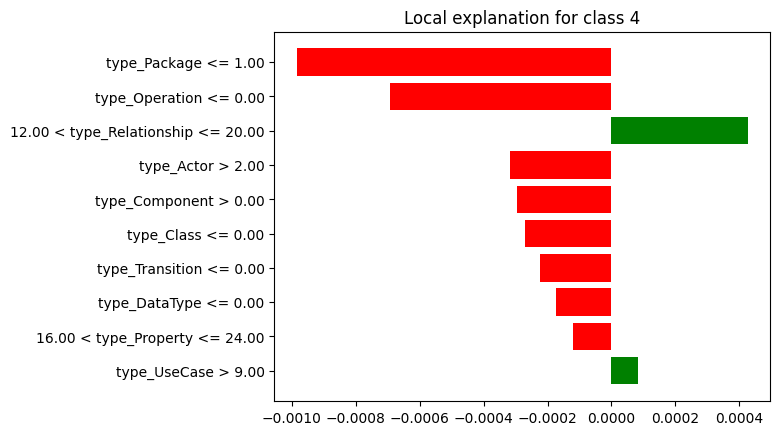

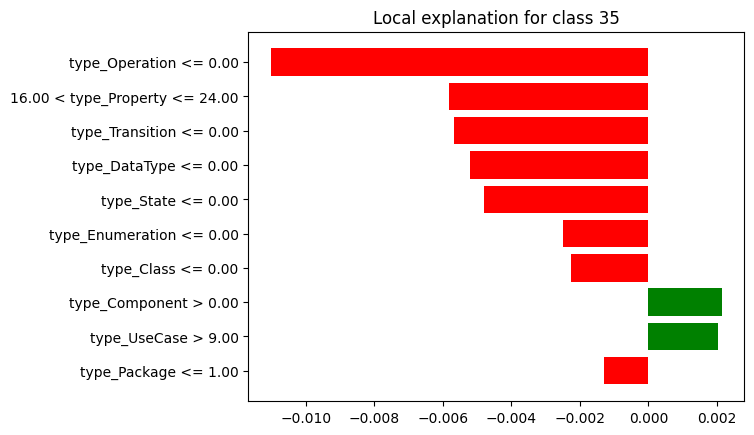

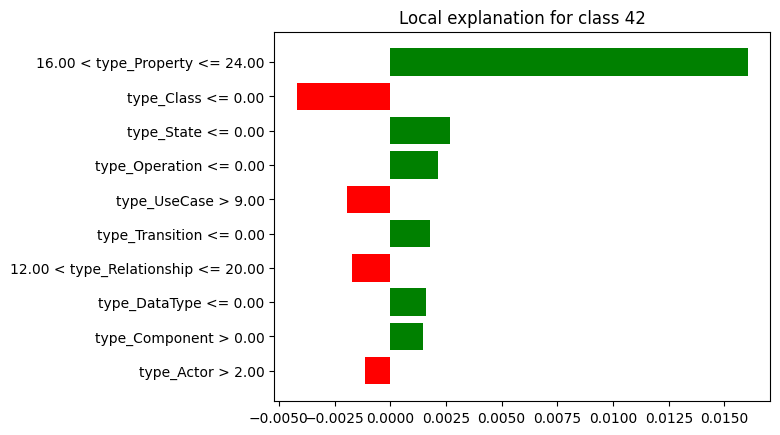

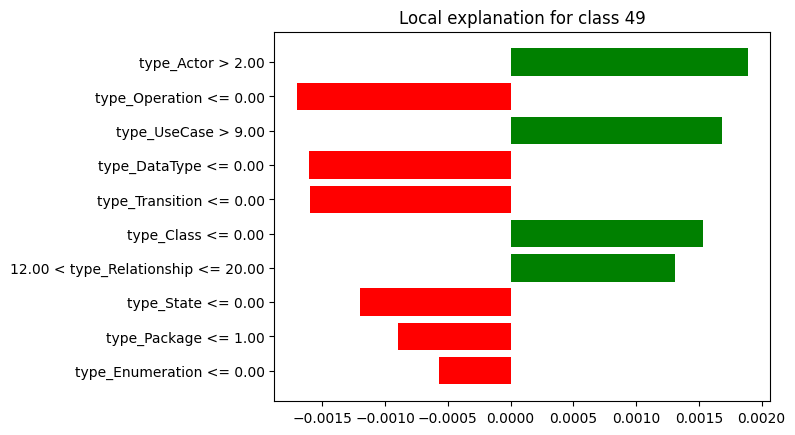

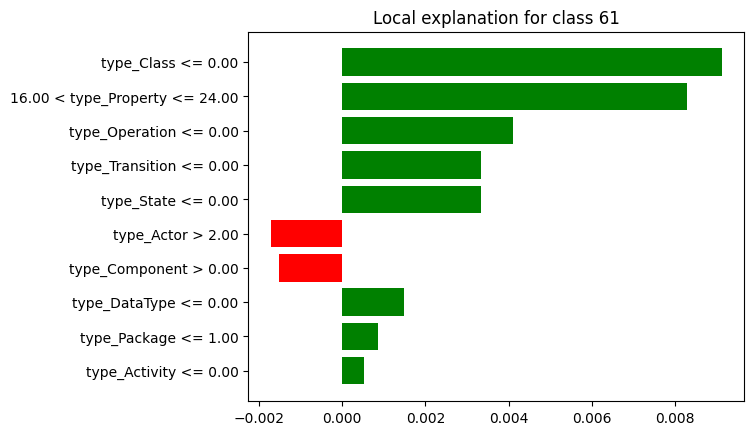

In [ ]:
for i in class_index:
  svc_exp_results['lime_course'][i].plot()

In [ ]:
breakdown_df_course_ban = breakdown_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_ban = breakdown_df_course_ban.drop(index=[0, 14])
breakdown_df_course_ban['sign'] = breakdown_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_ban = breakdown_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_ban = shap_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_ban = shap_df_course_ban.tail(13)
shap_df_course_ban['sign'] = shap_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_ban = shap_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_ban["Feature"] = lime_df_course_ban["variable"].str.split(" ").str[0]
lime_df_course_ban["Sign"] = lime_df_course_ban["effect"].apply(evaluate_value)
lime_df_course_ban = lime_df_course_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_ban = lime_df_course_ban.drop(columns=['variable'])


breakdown_df_course_ban['Ranking'] = breakdown_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_ban = breakdown_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_ban['Ranking'] = shap_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_ban = shap_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_ban['Ranking'] = lime_df_course_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_ban = lime_df_course_ban.head(10)
lime_df_course_ban = lime_df_course_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_ban = breakdown_df_course_ban.drop(columns=['contribution'])
shap_df_course_ban = shap_df_course_ban.drop(columns=['contribution'])
lime_df_course_ban = lime_df_course_ban.drop(columns=['effect'])


breakdown_df_course_ban = breakdown_df_course_ban.head(10)
breakdown_df_course_ban = breakdown_df_course_ban.reset_index(drop=True)

shap_df_course_ban= shap_df_course_ban.head(10)
shap_df_course_ban = shap_df_course_ban.reset_index(drop=True)

lime_df_course_ban = lime_df_course_ban.reset_index(drop=True)
lime_df_course_ban.at[2, "Feature"] = "type_Relationship"
lime_df_course_ban.at[8, "Feature"] = "type_Property"

print(breakdown_df_course_ban)
print("---------------------------------")
print(shap_df_course_ban)
print("---------------------------------")
print(lime_df_course_ban)

             Feature  Ranking      Sign
0         type_Actor        1  Negative
1         type_Class        2  Positive
2       type_Package        3  Negative
3  type_Relationship        4  Positive
4   type_Enumeration        5  Negative
5     type_Operation        6  Negative
6      type_DataType        7  Positive
7       type_UseCase        8  Positive
8     type_Component        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1       type_UseCase        2  Negative
2      type_Property        3  Positive
3         type_Class        4  Negative
4  type_Relationship        5  Negative
5   type_Enumeration        6  Negative
6       type_Package        7  Negative
7     type_Component        8  Negative
8     type_Operation        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_course_ban['Feature'])
shap_features = list(shap_df_course_ban['Feature'])
lime_features = list(lime_df_course_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_ban['Feature'] = list(all_features)
df_final_cou_ban= df_final_cou_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_ban['Feature']:

    breakdown_row = breakdown_df_course_ban[breakdown_df_course_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_ban[shap_df_course_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_ban[lime_df_course_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_ban = df_final_cou_ban.loc[casos_validos]
df_final_cou_ban.set_index('Feature', inplace=True)
df_final_cou_ban

['type_Actor', 'type_Class', 'type_Package', 'type_Relationship', 'type_Enumeration', 'type_Operation', 'type_DataType', 'type_UseCase', 'type_Component', 'type_Activity']
['type_Actor', 'type_UseCase', 'type_Property', 'type_Class', 'type_Relationship', 'type_Enumeration', 'type_Package', 'type_Component', 'type_Operation', 'type_DataType']
['type_Package', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Class', 'type_Transition', 'type_DataType', 'type_Property', 'type_UseCase']
['type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       1  Negative       4  Negative
type_Class                2  Positive       4  Negative       6  Negative
type_Package              3  Negative       7  Negative       1  Negative
type_Relationship         4  Positive       5  Negative       3  Positive
type_Enumeration          5  Negative       6  Negative       -         -
type_Operation            6  Negative       9  Positive       2  Negative
type_DataType             7  Positive      10  Positive       8  Negative
type_UseCase              8  Positive       2  Negative      10  Positive
type_Component            9  Negative       8  Negative       5  Negative
type_Activity            10  Negative       -         -       -         -
type_Property             -         -       3  Positive       9  Negative
type_Transition           -         -       -         -       7  Negative

In [ ]:
breakdown_df_course_vid = breakdown_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_vid = breakdown_df_course_vid.drop(index=[0, 14])
breakdown_df_course_vid['sign'] = breakdown_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_vid = breakdown_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_vid = shap_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_vid = shap_df_course_vid.tail(13)
shap_df_course_vid['sign'] = shap_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_vid = shap_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_vid["Feature"] = lime_df_course_vid["variable"].str.split(" ").str[0]
lime_df_course_vid["Sign"] = lime_df_course_vid["effect"].apply(evaluate_value)
lime_df_course_vid = lime_df_course_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_vid = lime_df_course_vid.drop(columns=['variable'])


breakdown_df_course_vid['Ranking'] = breakdown_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_vid = breakdown_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_vid['Ranking'] = shap_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_vid = shap_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_vid['Ranking'] = lime_df_course_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_vid = lime_df_course_vid.head(10)
lime_df_course_vid = lime_df_course_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_vid = breakdown_df_course_vid.drop(columns=['contribution'])
shap_df_course_vid = shap_df_course_vid.drop(columns=['contribution'])
lime_df_course_vid = lime_df_course_vid.drop(columns=['effect'])


breakdown_df_course_vid = breakdown_df_course_vid.head(10)
breakdown_df_course_vid = breakdown_df_course_vid.reset_index(drop=True)

shap_df_course_vid= shap_df_course_vid.head(10)
shap_df_course_vid = shap_df_course_vid.reset_index(drop=True)

lime_df_course_vid = lime_df_course_vid.reset_index(drop=True)
lime_df_course_vid.at[1, "Feature"] = "type_Property"

print(breakdown_df_course_vid)
print("---------------------------------")
print(shap_df_course_vid)
print("---------------------------------")
print(lime_df_course_vid)

             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1     type_Operation        2  Negative
2      type_Property        3  Negative
3  type_Relationship        4  Negative
4      type_DataType        5  Negative
5   type_Enumeration        6  Negative
6     type_Component        7  Negative
7      type_Activity        8  Negative
8       type_Package        9  Negative
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1     type_Operation        2  Negative
2         type_Actor        3  Negative
3  type_Relationship        4  Positive
4       type_UseCase        5  Negative
5      type_DataType        6  Negative
6       type_Package        7  Negative
7   type_Enumeration        8  Negative
8      type_Property        9  Negative
9      type_Activity       10  Negative
---------------------------------
            Feature  Ranking      Sign
0    type_Ope

In [ ]:

breakdown_features = list(breakdown_df_course_vid['Feature'])
shap_features = list(shap_df_course_vid['Feature'])
lime_features = list(lime_df_course_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_vid['Feature'] = list(all_features)
df_final_cou_vid= df_final_cou_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_vid['Feature']:

    breakdown_row = breakdown_df_course_vid[breakdown_df_course_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_vid[shap_df_course_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_vid[lime_df_course_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_vid = df_final_cou_vid.loc[casos_validos]
df_final_cou_vid.set_index('Feature', inplace=True)
df_final_cou_vid

['type_UseCase', 'type_Operation', 'type_Property', 'type_Relationship', 'type_DataType', 'type_Enumeration', 'type_Component', 'type_Activity', 'type_Package', 'type_Actor']
['type_Class', 'type_Operation', 'type_Actor', 'type_Relationship', 'type_UseCase', 'type_DataType', 'type_Package', 'type_Enumeration', 'type_Property', 'type_Activity']
['type_Operation', 'type_Property', 'type_Transition', 'type_DataType', 'type_State', 'type_Enumeration', 'type_Class', 'type_Component', 'type_UseCase', 'type_Package']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       5  Negative       9  Positive
type_Operation            2  Negative       2  Negative       1  Negative
type_Property             3  Negative       9  Negative       2  Negative
type_Relationship         4  Negative       4  Positive       -         -
type_DataType             5  Negative       6  Negative       4  Negative
type_Enumeration          6  Negative       8  Negative       6  Negative
type_Component            7  Negative       -         -       8  Positive
type_Activity             8  Negative      10  Negative       -         -
type_Package              9  Negative       7  Negative      10  Negative
type_Actor               10  Positive       3  Negative       -         -
type_Class                -         -       1  Negative       7  Negative
type_State                -         -       -         -       5  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_course_cou = breakdown_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_cou = breakdown_df_course_cou.drop(index=[0, 14])
breakdown_df_course_cou['sign'] = breakdown_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_cou = breakdown_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_cou = shap_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_cou = shap_df_course_cou.tail(13)
shap_df_course_cou['sign'] = shap_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_cou = shap_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_cou["Feature"] = lime_df_course_cou["variable"].str.split(" ").str[0]
lime_df_course_cou["Sign"] = lime_df_course_cou["effect"].apply(evaluate_value)
lime_df_course_cou = lime_df_course_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_cou = lime_df_course_cou.drop(columns=['variable'])


breakdown_df_course_cou['Ranking'] = breakdown_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_cou = breakdown_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_cou['Ranking'] = shap_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_cou = shap_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_cou['Ranking'] = lime_df_course_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_cou = lime_df_course_cou.head(10)
lime_df_course_cou = lime_df_course_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_cou = breakdown_df_course_cou.drop(columns=['contribution'])
shap_df_course_cou = shap_df_course_cou.drop(columns=['contribution'])
lime_df_course_cou = lime_df_course_cou.drop(columns=['effect'])


breakdown_df_course_cou = breakdown_df_course_cou.head(10)
breakdown_df_course_cou = breakdown_df_course_cou.reset_index(drop=True)

shap_df_course_cou= shap_df_course_cou.head(10)
shap_df_course_cou = shap_df_course_cou.reset_index(drop=True)

lime_df_course_cou = lime_df_course_cou.reset_index(drop=True)
lime_df_course_cou.at[0, "Feature"] = "type_Property"
lime_df_course_cou.at[6, "Feature"] = "type_Relationship"

print(breakdown_df_course_cou)
print("---------------------------------")
print(shap_df_course_cou)
print("---------------------------------")
print(lime_df_course_cou)

            Feature  Ranking      Sign
0    type_Operation        1  Positive
1        type_Class        2  Positive
2      type_UseCase        3  Positive
3     type_DataType        4  Positive
4    type_Component        5  Positive
5        type_Actor        6  Positive
6     type_Property        7  Positive
7  type_Enumeration        8  Positive
8     type_Activity        9  Positive
9      type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Positive
1       type_UseCase        2  Positive
2         type_Class        3  Positive
3      type_Property        4  Positive
4  type_Relationship        5  Positive
5     type_Operation        6  Positive
6       type_Package        7  Positive
7     type_Component        8  Positive
8   type_Enumeration        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property   

In [ ]:

breakdown_features = list(breakdown_df_course_cou['Feature'])
shap_features = list(shap_df_course_cou['Feature'])
lime_features = list(lime_df_course_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_cou['Feature'] = list(all_features)
df_final_cou_cou= df_final_cou_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_cou['Feature']:

    breakdown_row = breakdown_df_course_cou[breakdown_df_course_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_cou[shap_df_course_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_cou[lime_df_course_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_cou = df_final_cou_cou.loc[casos_validos]
df_final_cou_cou.set_index('Feature', inplace=True)
df_final_cou_cou

['type_Operation', 'type_Class', 'type_UseCase', 'type_DataType', 'type_Component', 'type_Actor', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']
['type_Actor', 'type_UseCase', 'type_Class', 'type_Property', 'type_Relationship', 'type_Operation', 'type_Package', 'type_Component', 'type_Enumeration', 'type_Activity']
['type_Property', 'type_Class', 'type_State', 'type_Operation', 'type_UseCase', 'type_Transition', 'type_Relationship', 'type_DataType', 'type_Component', 'type_Actor']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       6  Positive       4  Positive
type_Class                2  Positive       3  Positive       2  Negative
type_UseCase              3  Positive       2  Positive       5  Negative
type_DataType             4  Positive       -         -       8  Positive
type_Component            5  Positive       8  Positive       9  Positive
type_Actor                6  Positive       1  Positive      10  Negative
type_Property             7  Positive       4  Positive       1  Positive
type_Enumeration          8  Positive       9  Positive       -         -
type_Activity             9  Positive      10  Positive       -         -
type_Package             10  Positive       7  Positive       -         -
type_Relationship         -         -       5  Positive       7  Negative
type_State                -         -       -         -       3  Positive
type_Transition           -         -       -         -       6  Positive

In [ ]:
breakdown_df_course_emp = breakdown_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_emp = breakdown_df_course_emp.drop(index=[0, 14])
breakdown_df_course_emp['sign'] = breakdown_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_emp = breakdown_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_emp = shap_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_emp = shap_df_course_emp.tail(13)
shap_df_course_emp['sign'] = shap_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_emp = shap_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_emp["Feature"] = lime_df_course_emp["variable"].str.split(" ").str[0]
lime_df_course_emp["Sign"] = lime_df_course_emp["effect"].apply(evaluate_value)
lime_df_course_emp = lime_df_course_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_emp = lime_df_course_emp.drop(columns=['variable'])


breakdown_df_course_emp['Ranking'] = breakdown_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_emp = breakdown_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_emp['Ranking'] = shap_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_emp = shap_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_emp['Ranking'] = lime_df_course_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_emp = lime_df_course_emp.head(10)
lime_df_course_emp = lime_df_course_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_emp = breakdown_df_course_emp.drop(columns=['contribution'])
shap_df_course_emp = shap_df_course_emp.drop(columns=['contribution'])
lime_df_course_emp = lime_df_course_emp.drop(columns=['effect'])


breakdown_df_course_emp = breakdown_df_course_emp.head(10)
breakdown_df_course_emp = breakdown_df_course_emp.reset_index(drop=True)

shap_df_course_emp= shap_df_course_emp.head(10)
shap_df_course_emp = shap_df_course_emp.reset_index(drop=True)

lime_df_course_emp = lime_df_course_emp.reset_index(drop=True)
lime_df_course_emp.at[6, "Feature"] = "type_Relationship"

print(breakdown_df_course_emp)
print("---------------------------------")
print(shap_df_course_emp)
print("---------------------------------")
print(lime_df_course_emp)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Negative
2         type_Actor        3  Positive
3       type_UseCase        4  Negative
4  type_Relationship        5  Negative
5         type_Class        6  Negative
6       type_Package        7  Negative
7   type_Enumeration        8  Negative
8      type_Activity        9  Negative
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1     type_Operation        2  Negative
2         type_Class        3  Negative
3      type_Property        4  Negative
4         type_Actor        5  Positive
5  type_Relationship        6  Negative
6       type_Package        7  Negative
7   type_Enumeration        8  Negative
8      type_Activity        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_course_emp['Feature'])
shap_features = list(shap_df_course_emp['Feature'])
lime_features = list(lime_df_course_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_emp['Feature'] = list(all_features)
df_final_cou_emp= df_final_cou_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_emp['Feature']:

    breakdown_row = breakdown_df_course_emp[breakdown_df_course_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_emp[shap_df_course_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_emp[lime_df_course_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_emp = df_final_cou_emp.loc[casos_validos]
df_final_cou_emp.set_index('Feature', inplace=True)
df_final_cou_emp

['type_Operation', 'type_Property', 'type_Actor', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Package', 'type_Enumeration', 'type_Activity', 'type_Component']
['type_UseCase', 'type_Operation', 'type_Class', 'type_Property', 'type_Actor', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_Activity', 'type_DataType']
['type_Actor', 'type_Operation', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Relationship', 'type_State', 'type_Package', 'type_Enumeration']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_Operation', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       2  Negative       2  Negative
type_Property             2  Negative       4  Negative       -         -
type_Actor                3  Positive       5  Positive       1  Positive
type_UseCase              4  Negative       1  Negative       3  Positive
type_Relationship         5  Negative       6  Negative       7  Positive
type_Class                6  Negative       3  Negative       6  Positive
type_Package              7  Negative       7  Negative       9  Negative
type_Enumeration          8  Negative       8  Negative      10  Negative
type_Activity             9  Negative       9  Negative       -         -
type_Component           10  Positive       -         -       -         -
type_DataType             -         -      10  Negative       4  Negative
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -       5  Negative

In [ ]:
breakdown_df_course_lib = breakdown_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_lib = breakdown_df_course_lib.drop(index=[0, 14])
breakdown_df_course_lib['sign'] = breakdown_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_lib = breakdown_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_lib = shap_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_lib = shap_df_course_lib.tail(13)
shap_df_course_lib['sign'] = shap_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_lib = shap_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_lib["Feature"] = lime_df_course_lib["variable"].str.split(" ").str[0]
lime_df_course_lib["Sign"] = lime_df_course_lib["effect"].apply(evaluate_value)
lime_df_course_lib = lime_df_course_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_lib = lime_df_course_lib.drop(columns=['variable'])


breakdown_df_course_lib['Ranking'] = breakdown_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_lib = breakdown_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_lib['Ranking'] = shap_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_lib = shap_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_lib['Ranking'] = lime_df_course_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_lib = lime_df_course_lib.head(10)
lime_df_course_lib = lime_df_course_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_lib = breakdown_df_course_lib.drop(columns=['contribution'])
shap_df_course_lib = shap_df_course_lib.drop(columns=['contribution'])
lime_df_course_lib = lime_df_course_lib.drop(columns=['effect'])


breakdown_df_course_lib = breakdown_df_course_lib.head(10)
breakdown_df_course_lib = breakdown_df_course_lib.reset_index(drop=True)

shap_df_course_lib= shap_df_course_lib.head(10)
shap_df_course_lib = shap_df_course_lib.reset_index(drop=True)

lime_df_course_lib = lime_df_course_lib.reset_index(drop=True)
lime_df_course_lib.at[1, "Feature"] = "type_Property"

print(breakdown_df_course_lib)
print("---------------------------------")
print(shap_df_course_lib)
print("---------------------------------")
print(lime_df_course_lib)

            Feature  Ranking      Sign
0        type_Actor        1  Negative
1     type_Property        2  Positive
2      type_UseCase        3  Positive
3    type_Operation        4  Positive
4        type_Class        5  Positive
5    type_Component        6  Positive
6      type_Package        7  Positive
7     type_DataType        8  Positive
8  type_Enumeration        9  Positive
9     type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1  type_Relationship        2  Positive
2     type_Operation        3  Positive
3       type_UseCase        4  Positive
4         type_Class        5  Positive
5     type_Component        6  Positive
6      type_Property        7  Negative
7      type_DataType        8  Positive
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
           Feature  Ranking      Sign
0       type_Class       

In [ ]:

breakdown_features = list(breakdown_df_course_lib['Feature'])
shap_features = list(shap_df_course_lib['Feature'])
lime_features = list(lime_df_course_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_lib['Feature'] = list(all_features)
df_final_cou_lib= df_final_cou_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_lib['Feature']:

    breakdown_row = breakdown_df_course_lib[breakdown_df_course_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_lib[shap_df_course_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_lib[lime_df_course_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_lib = df_final_cou_lib.loc[casos_validos]
df_final_cou_lib.set_index('Feature', inplace=True)
df_final_cou_lib

['type_Actor', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Class', 'type_Component', 'type_Package', 'type_DataType', 'type_Enumeration', 'type_Activity']
['type_Actor', 'type_Relationship', 'type_Operation', 'type_UseCase', 'type_Class', 'type_Component', 'type_Property', 'type_DataType', 'type_Package', 'type_Enumeration']
['type_Class', 'type_Property', 'type_Operation', 'type_Transition', 'type_State', 'type_Actor', 'type_Component', 'type_DataType', 'type_Package', 'type_Activity']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_Property', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       1  Negative       6  Negative
type_Property             2  Positive       7  Negative       2  Positive
type_UseCase              3  Positive       4  Positive       -         -
type_Operation            4  Positive       3  Positive       3  Positive
type_Class                5  Positive       5  Positive       1  Positive
type_Component            6  Positive       6  Positive       7  Negative
type_Package              7  Positive       9  Positive       9  Positive
type_DataType             8  Positive       8  Positive       8  Positive
type_Enumeration          9  Positive      10  Positive       -         -
type_Activity            10  Positive       -         -      10  Positive
type_Relationship         -         -       2  Positive       -         -
type_State                -         -       -         -       5  Positive
type_Transition           -         -       -         -       4  Positive

### **Results Course:**

In [ ]:
df_topfeatures_cou_ban = top5_features(df_final_cou_ban, 'Course - Class: Bank')
df_topfeatures_cou_vid = top5_features(df_final_cou_vid, 'Course - Class: ComputerVideogames')
df_topfeatures_cou_cou = top5_features(df_final_cou_cou, 'Course - Class: Course')
df_topfeatures_cou_emp = top5_features(df_final_cou_emp, 'Course - Class: Employee')
df_topfeatures_cou_lib = top5_features(df_final_cou_lib, 'Course - Class: Library')

df_topfeatures_course = pd.concat([df_topfeatures_cou_ban, df_topfeatures_cou_vid, df_topfeatures_cou_cou, df_topfeatures_cou_emp, df_topfeatures_cou_lib])
df_topfeatures_course

TOP5 Breakdown  \
Course - Class: Bank                type_Package, type_Enumeration, type_Class, ty...   
Course - Class: ComputerVideogames  type_Operation, type_UseCase, type_Property, t...   
Course - Class: Course              type_Operation, type_UseCase, type_DataType, t...   
Course - Class: Employee            type_UseCase, type_Operation, type_Property, t...   
Course - Class: Library             type_UseCase, type_Property, type_Operation, t...   

                                                                            TOP5 Shap  \
Course - Class: Bank                type_Property, type_UseCase, type_Relationship...   
Course - Class: ComputerVideogames  type_Operation, type_UseCase, type_Relationshi...   
Course - Class: Course              type_Property, type_UseCase, type_Relationship...   
Course - Class: Employee            type_UseCase, type_Operation, type_Property, t...   
Course - Class: Library             type_UseCase, type_Operation, type_Relationshi...   

                                                                            TOP5 Lime  \
Course - Class: Bank                type_Package, type_Operation, type_Component, ...   
Course - Class: ComputerVideogames  type_Operation, type_Property, type_Transition...   
Course - Class: Course              type_Property, type_Operation, type_UseCase, t...   
Course - Class: Employee            type_UseCase, type_Operation, type_Transition,...   
Course - Class: Library             type_Operation, type_Property, type_Transition...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class: Bank                           0.6             0.6        0.4  
Course - Class: ComputerVideogames             0.6             0.6        0.2  
Course - Class: Course                         0.4             0.6        0.6  
Course - Class: Employee                       0.8             0.6        0.6  
Course - Class: Library                        0.8             0.6        0.4

In [ ]:
df_topfeatures_cou_ban_rank = top5_rank(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank = top5_rank(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank = top5_rank(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank = top5_rank(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank = top5_rank(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_course = pd.concat([df_topfeatures_cou_ban_rank, df_topfeatures_cou_vid_rank, df_topfeatures_cou_cou_rank, df_topfeatures_cou_emp_rank, df_topfeatures_cou_lib_rank])
df_topfeatures_rank_course

TOP5 Breakdown  \
Course - Class Bank                1:type_Actor, 2:type_Class, 3:type_Package, 4:...   
Course - Class ComputerVideogames  1:type_UseCase, 2:type_Operation, 3:type_Prope...   
Course - Class Course              1:type_Operation, 2:type_Class, 3:type_UseCase...   
Course - Class Employee            1:type_Operation, 2:type_Property, 3:type_Acto...   
Course - Class Library             1:type_Actor, 2:type_Property, 3:type_UseCase,...   

                                                                           TOP5 Shap  \
Course - Class Bank                1:type_Actor, 4:type_Class, 5:type_Relationshi...   
Course - Class ComputerVideogames  5:type_UseCase, 2:type_Operation, 4:type_Relat...   
Course - Class Course              3:type_Class, 2:type_UseCase, 1:type_Actor, 4:...   
Course - Class Employee            2:type_Operation, 4:type_Property, 5:type_Acto...   
Course - Class Library             1:type_Actor, 4:type_UseCase, 3:type_Operation...   

                                                                           TOP5 Lime  \
Course - Class Bank                4:type_Actor, 1:type_Package, 3:type_Relations...   
Course - Class ComputerVideogames  1:type_Operation, 2:type_Property, 4:type_Data...   
Course - Class Course              4:type_Operation, 2:type_Class, 5:type_UseCase...   
Course - Class Employee            2:type_Operation, 1:type_Actor, 3:type_UseCase...   
Course - Class Library             2:type_Property, 3:type_Operation, 1:type_Clas...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.2             0.0        0.0  
Course - Class ComputerVideogames             0.4             0.0        0.0  
Course - Class Course                         0.0             0.2        0.0  
Course - Class Employee                       0.0             0.0        0.2  
Course - Class Library                        0.4             0.2        0.2

In [ ]:
df_topfeatures_cou_ban_sign = top5_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_sign = top5_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_sign = top5_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_sign = top5_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_sign = top5_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_sign_course = pd.concat([df_topfeatures_cou_ban_sign, df_topfeatures_cou_vid_sign, df_topfeatures_cou_cou_sign, df_topfeatures_cou_emp_sign, df_topfeatures_cou_lib_sign])
df_topfeatures_sign_course

TOP5 Breakdown  \
Course - Class Bank                type_Actor:Negative, type_Class:Positive, type...   
Course - Class ComputerVideogames  type_UseCase:Positive, type_Operation:Negative...   
Course - Class Course              type_Operation:Positive, type_Class:Positive, ...   
Course - Class Employee            type_Operation:Negative, type_Property:Negativ...   
Course - Class Library             type_Actor:Negative, type_Property:Positive, t...   

                                                                           TOP5 Shap  \
Course - Class Bank                type_Actor:Negative, type_Class:Negative, type...   
Course - Class ComputerVideogames  type_UseCase:Negative, type_Operation:Negative...   
Course - Class Course              type_Class:Positive, type_UseCase:Positive, ty...   
Course - Class Employee            type_Operation:Negative, type_Property:Negativ...   
Course - Class Library             type_Actor:Negative, type_UseCase:Positive, ty...   

                                                                           TOP5 Lime  \
Course - Class Bank                type_Actor:Negative, type_Package:Negative, ty...   
Course - Class ComputerVideogames  type_Operation:Negative, type_Property:Negativ...   
Course - Class Course              type_Operation:Positive, type_Class:Negative, ...   
Course - Class Employee            type_Operation:Negative, type_Actor:Positive, ...   
Course - Class Library             type_Property:Positive, type_Operation:Positiv...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.2             0.6        0.2  
Course - Class ComputerVideogames             0.2             0.6        0.2  
Course - Class Course                         0.4             0.2        0.2  
Course - Class Employee                       0.8             0.4        0.4  
Course - Class Library                        0.8             0.6        0.4

In [ ]:
df_topfeatures_cou_ban_rank_sign = top5_rank_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank_sign = top5_rank_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank_sign = top5_rank_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank_sign = top5_rank_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank_sign = top5_rank_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_sign_course = pd.concat([df_topfeatures_cou_ban_rank_sign, df_topfeatures_cou_vid_rank_sign, df_topfeatures_cou_cou_rank_sign, df_topfeatures_cou_emp_rank_sign, df_topfeatures_cou_lib_rank_sign])
df_topfeatures_rank_sign_course

TOP5 Breakdown  \
Course - Class Bank                1:type_Actor:Negative, 2:type_Class:Positive, ...   
Course - Class ComputerVideogames  1:type_UseCase:Positive, 2:type_Operation:Nega...   
Course - Class Course              1:type_Operation:Positive, 2:type_Class:Positi...   
Course - Class Employee            1:type_Operation:Negative, 2:type_Property:Neg...   
Course - Class Library             1:type_Actor:Negative, 2:type_Property:Positiv...   

                                                                           TOP5 Shap  \
Course - Class Bank                1:type_Actor:Negative, 4:type_Class:Negative, ...   
Course - Class ComputerVideogames  5:type_UseCase:Negative, 2:type_Operation:Nega...   
Course - Class Course              3:type_Class:Positive, 2:type_UseCase:Positive...   
Course - Class Employee            2:type_Operation:Negative, 4:type_Property:Neg...   
Course - Class Library             1:type_Actor:Negative, 4:type_UseCase:Positive...   

                                                                           TOP5 Lime  \
Course - Class Bank                4:type_Actor:Negative, 1:type_Package:Negative...   
Course - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Property:Neg...   
Course - Class Course              4:type_Operation:Positive, 2:type_Class:Negati...   
Course - Class Employee            2:type_Operation:Negative, 1:type_Actor:Positi...   
Course - Class Library             2:type_Property:Positive, 3:type_Operation:Pos...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.2             0.0        0.0  
Course - Class ComputerVideogames             0.2             0.0        0.0  
Course - Class Course                         0.0             0.0        0.0  
Course - Class Employee                       0.0             0.0        0.2  
Course - Class Library                        0.4             0.2        0.2

### **Library:**

In [ ]:
breakdown_df_library_ban = svc_exp_results['breakdown_library'][0].result
shap_df_library_ban = svc_exp_results['shap_library'][0].result
lime_df_library_ban = svc_exp_results['lime_library'][0].result

In [ ]:
breakdown_df_library_vid = svc_exp_results['breakdown_library'][1].result
shap_df_library_vid = svc_exp_results['shap_library'][1].result
lime_df_library_vid = svc_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_cou = svc_exp_results['breakdown_library'][3].result
shap_df_library_cou = svc_exp_results['shap_library'][3].result
lime_df_library_cou = svc_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_emp = svc_exp_results['breakdown_library'][4].result
shap_df_library_emp = svc_exp_results['shap_library'][4].result
lime_df_library_emp = svc_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_lib = svc_exp_results['breakdown_library'][6].result
shap_df_library_lib = svc_exp_results['shap_library'][6].result
lime_df_library_lib = svc_exp_results['lime_library'][6].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

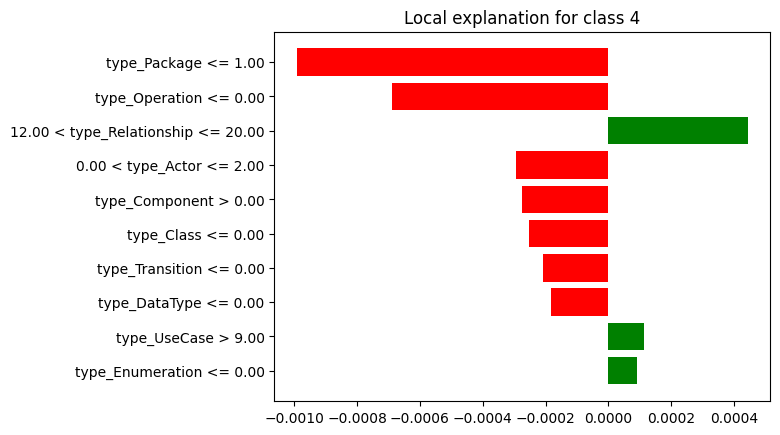

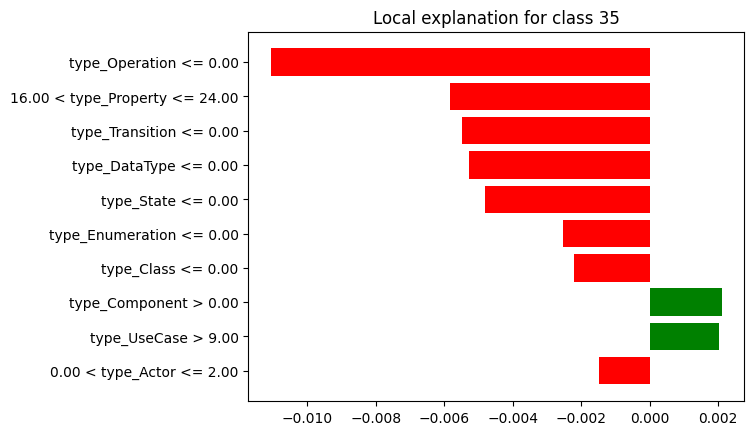

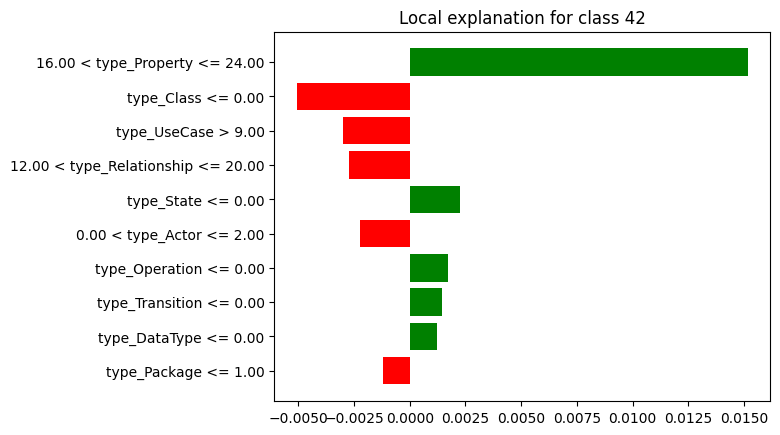

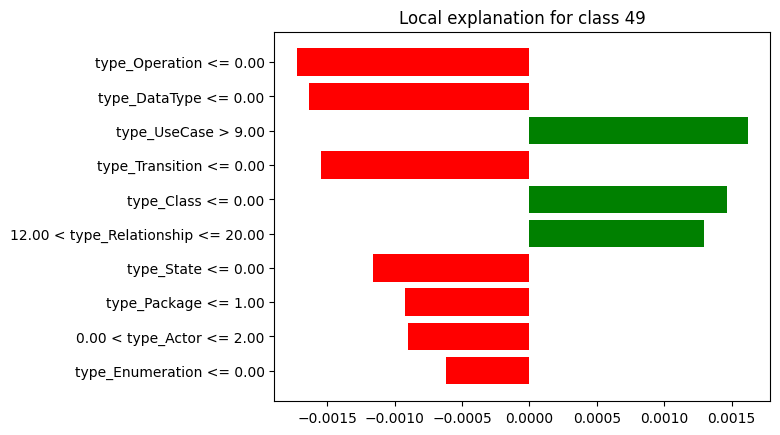

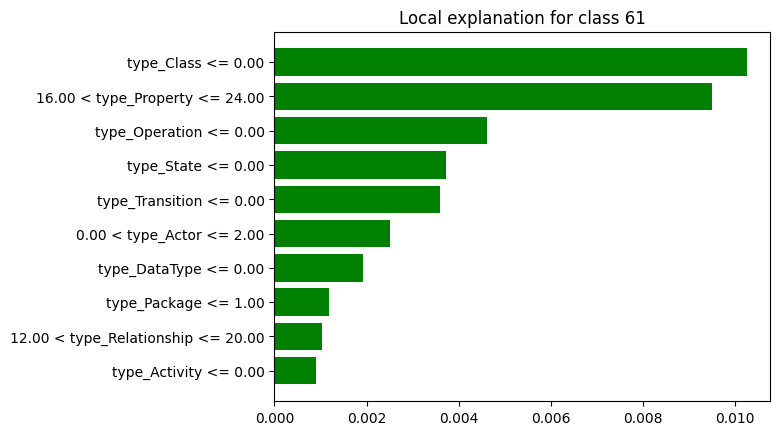

In [ ]:
for i in class_index:
  svc_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_ban = breakdown_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_ban = breakdown_df_library_ban.drop(index=[0, 14])
breakdown_df_library_ban['sign'] = breakdown_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_ban = breakdown_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_ban = shap_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_ban = shap_df_library_ban.tail(13)
shap_df_library_ban['sign'] = shap_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_ban = shap_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_ban["Feature"] = lime_df_library_ban["variable"].str.split(" ").str[0]
lime_df_library_ban["Sign"] = lime_df_library_ban["effect"].apply(evaluate_value)
lime_df_library_ban = lime_df_library_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_ban = lime_df_library_ban.drop(columns=['variable'])


breakdown_df_library_ban['Ranking'] = breakdown_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_ban = breakdown_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_ban['Ranking'] = shap_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_ban = shap_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_ban['Ranking'] = lime_df_library_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_ban = lime_df_library_ban.head(10)
lime_df_library_ban = lime_df_library_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_ban = breakdown_df_library_ban.drop(columns=['contribution'])
shap_df_library_ban = shap_df_library_ban.drop(columns=['contribution'])
lime_df_library_ban = lime_df_library_ban.drop(columns=['effect'])


breakdown_df_library_ban = breakdown_df_library_ban.head(10)
breakdown_df_library_ban = breakdown_df_library_ban.reset_index(drop=True)

shap_df_library_ban= shap_df_library_ban.head(10)
shap_df_library_ban = shap_df_library_ban.reset_index(drop=True)

lime_df_library_ban = lime_df_library_ban.reset_index(drop=True)
lime_df_library_ban.at[2, "Feature"] = "type_Relationship"
lime_df_library_ban.at[3, "Feature"] = "type_Actor"

print(breakdown_df_library_ban)
print("---------------------------------")
print(shap_df_library_ban)
print("---------------------------------")
print(lime_df_library_ban)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Positive
2       type_Package        3  Negative
3         type_Actor        4  Negative
4   type_Enumeration        5  Negative
5       type_UseCase        6  Positive
6     type_Operation        7  Negative
7      type_DataType        8  Positive
8     type_Component        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1      type_Property        2  Negative
2  type_Relationship        3  Negative
3   type_Enumeration        4  Negative
4       type_Package        5  Negative
5     type_Component        6  Negative
6       type_UseCase        7  Negative
7     type_Operation        8  Positive
8      type_Activity        9  Negative
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_library_ban['Feature'])
shap_features = list(shap_df_library_ban['Feature'])
lime_features = list(lime_df_library_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_ban['Feature'] = list(all_features)
df_final_lib_ban= df_final_lib_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_ban['Feature']:

    breakdown_row = breakdown_df_library_ban[breakdown_df_library_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_ban[shap_df_library_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_ban[lime_df_library_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_ban = df_final_lib_ban.loc[casos_validos]
df_final_lib_ban.set_index('Feature', inplace=True)
df_final_lib_ban

['type_Property', 'type_Relationship', 'type_Package', 'type_Actor', 'type_Enumeration', 'type_UseCase', 'type_Operation', 'type_DataType', 'type_Component', 'type_Activity']
['type_Actor', 'type_Property', 'type_Relationship', 'type_Enumeration', 'type_Package', 'type_Component', 'type_UseCase', 'type_Operation', 'type_Activity', 'type_DataType']
['type_Package', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Class', 'type_Transition', 'type_DataType', 'type_UseCase', 'type_Enumeration']
['type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_UseCase', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       -         -
type_Relationship         2  Positive       3  Negative       3  Positive
type_Package              3  Negative       5  Negative       1  Negative
type_Actor                4  Negative       1  Negative       4  Negative
type_Enumeration          5  Negative       4  Negative      10  Positive
type_UseCase              6  Positive       7  Negative       9  Positive
type_Operation            7  Negative       8  Positive       2  Negative
type_DataType             8  Positive      10  Positive       8  Negative
type_Component            9  Negative       6  Negative       5  Negative
type_Activity            10  Negative       9  Negative       -         -
type_Class                -         -       -         -       6  Negative
type_Transition           -         -       -         -       7  Negative

In [ ]:
breakdown_df_library_vid = breakdown_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_vid = breakdown_df_library_vid.drop(index=[0, 14])
breakdown_df_library_vid['sign'] = breakdown_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_vid = breakdown_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_vid = shap_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_vid = shap_df_library_vid.tail(13)
shap_df_library_vid['sign'] = shap_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_vid = shap_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_vid["Feature"] = lime_df_library_vid["variable"].str.split(" ").str[0]
lime_df_library_vid["Sign"] = lime_df_library_vid["effect"].apply(evaluate_value)
lime_df_library_vid = lime_df_library_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_vid = lime_df_library_vid.drop(columns=['variable'])


breakdown_df_library_vid['Ranking'] = breakdown_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_vid = breakdown_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_vid['Ranking'] = shap_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_vid = shap_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_vid['Ranking'] = lime_df_library_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_vid = lime_df_library_vid.head(10)
lime_df_library_vid = lime_df_library_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_vid = breakdown_df_library_vid.drop(columns=['contribution'])
shap_df_library_vid = shap_df_library_vid.drop(columns=['contribution'])
lime_df_library_vid = lime_df_library_vid.drop(columns=['effect'])


breakdown_df_library_vid = breakdown_df_library_vid.head(10)
breakdown_df_library_vid = breakdown_df_library_vid.reset_index(drop=True)

shap_df_library_vid= shap_df_library_vid.head(10)
shap_df_library_vid = shap_df_library_vid.reset_index(drop=True)

lime_df_library_vid = lime_df_library_vid.reset_index(drop=True)
lime_df_library_vid.at[1, "Feature"] = "type_Property"
lime_df_library_vid.at[9, "Feature"] = "type_Actor"

print(breakdown_df_library_vid)
print("---------------------------------")
print(shap_df_library_vid)
print("---------------------------------")
print(lime_df_library_vid)

            Feature  Ranking      Sign
0      type_UseCase        1  Positive
1    type_Operation        2  Negative
2     type_Property        3  Negative
3        type_Actor        4  Negative
4        type_Class        5  Negative
5     type_DataType        6  Negative
6  type_Enumeration        7  Negative
7     type_Activity        8  Negative
8    type_Component        9  Negative
9      type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1     type_Operation        2  Negative
2  type_Relationship        3  Positive
3      type_Property        4  Negative
4       type_UseCase        5  Negative
5         type_Actor        6  Negative
6      type_DataType        7  Negative
7   type_Enumeration        8  Negative
8       type_Package        9  Negative
9     type_Component       10  Positive
---------------------------------
            Feature  Ranking      Sign
0    type_Operation     

In [ ]:

breakdown_features = list(breakdown_df_library_vid['Feature'])
shap_features = list(shap_df_library_vid['Feature'])
lime_features = list(lime_df_library_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_vid['Feature'] = list(all_features)
df_final_lib_vid= df_final_lib_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_vid['Feature']:

    breakdown_row = breakdown_df_library_vid[breakdown_df_library_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_vid[shap_df_library_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_vid[lime_df_library_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_vid = df_final_lib_vid.loc[casos_validos]
df_final_lib_vid.set_index('Feature', inplace=True)
df_final_lib_vid

['type_UseCase', 'type_Operation', 'type_Property', 'type_Actor', 'type_Class', 'type_DataType', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package']
['type_Class', 'type_Operation', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_Actor', 'type_DataType', 'type_Enumeration', 'type_Package', 'type_Component']
['type_Operation', 'type_Property', 'type_Transition', 'type_DataType', 'type_State', 'type_Enumeration', 'type_Class', 'type_Component', 'type_UseCase', 'type_Actor']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       5  Negative       9  Positive
type_Operation            2  Negative       2  Negative       1  Negative
type_Property             3  Negative       4  Negative       2  Negative
type_Actor                4  Negative       6  Negative      10  Negative
type_Class                5  Negative       1  Negative       7  Negative
type_DataType             6  Negative       7  Negative       4  Negative
type_Enumeration          7  Negative       8  Negative       6  Negative
type_Activity             8  Negative       -         -       -         -
type_Component            9  Negative      10  Positive       8  Positive
type_Package             10  Negative       9  Negative       -         -
type_Relationship         -         -       3  Positive       -         -
type_State                -         -       -         -       5  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_library_cou = breakdown_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_cou = breakdown_df_library_cou.drop(index=[0, 14])
breakdown_df_library_cou['sign'] = breakdown_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_cou = breakdown_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_cou = shap_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_cou = shap_df_library_cou.tail(13)
shap_df_library_cou['sign'] = shap_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_cou = shap_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_cou["Feature"] = lime_df_library_cou["variable"].str.split(" ").str[0]
lime_df_library_cou["Sign"] = lime_df_library_cou["effect"].apply(evaluate_value)
lime_df_library_cou = lime_df_library_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_cou = lime_df_library_cou.drop(columns=['variable'])


breakdown_df_library_cou['Ranking'] = breakdown_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_cou = breakdown_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_cou['Ranking'] = shap_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_cou = shap_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_cou['Ranking'] = lime_df_library_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_cou = lime_df_library_cou.head(10)
lime_df_library_cou = lime_df_library_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_cou = breakdown_df_library_cou.drop(columns=['contribution'])
shap_df_library_cou = shap_df_library_cou.drop(columns=['contribution'])
lime_df_library_cou = lime_df_library_cou.drop(columns=['effect'])


breakdown_df_library_cou = breakdown_df_library_cou.head(10)
breakdown_df_library_cou = breakdown_df_library_cou.reset_index(drop=True)

shap_df_library_cou= shap_df_library_cou.head(10)
shap_df_library_cou = shap_df_library_cou.reset_index(drop=True)

lime_df_library_cou = lime_df_library_cou.reset_index(drop=True)
lime_df_library_cou.at[0, "Feature"] = "type_Property"
lime_df_library_cou.at[3, "Feature"] = "type_Relationship"
lime_df_library_cou.at[5, "Feature"] = "type_Actor"

print(breakdown_df_library_cou)
print("---------------------------------")
print(shap_df_library_cou)
print("---------------------------------")
print(lime_df_library_cou)

             Feature  Ranking      Sign
0      type_Property        1  Positive
1  type_Relationship        2  Negative
2     type_Operation        3  Negative
3         type_Class        4  Negative
4         type_Actor        5  Negative
5       type_UseCase        6  Negative
6      type_DataType        7  Negative
7   type_Enumeration        8  Negative
8      type_Activity        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_UseCase        2  Negative
2     type_Operation        3  Negative
3         type_Actor        4  Negative
4  type_Relationship        5  Negative
5      type_DataType        6  Negative
6     type_Component        7  Negative
7      type_Property        8  Negative
8   type_Enumeration        9  Positive
9    type_Transition       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_library_cou['Feature'])
shap_features = list(shap_df_library_cou['Feature'])
lime_features = list(lime_df_library_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_cou['Feature'] = list(all_features)
df_final_lib_cou= df_final_lib_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_cou['Feature']:

    breakdown_row = breakdown_df_library_cou[breakdown_df_library_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_cou[shap_df_library_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_cou[lime_df_library_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_cou = df_final_lib_cou.loc[casos_validos]
df_final_lib_cou.set_index('Feature', inplace=True)
df_final_lib_cou

['type_Property', 'type_Relationship', 'type_Operation', 'type_Class', 'type_Actor', 'type_UseCase', 'type_DataType', 'type_Enumeration', 'type_Activity', 'type_Package']
['type_Class', 'type_UseCase', 'type_Operation', 'type_Actor', 'type_Relationship', 'type_DataType', 'type_Component', 'type_Property', 'type_Enumeration', 'type_Transition']
['type_Property', 'type_Class', 'type_UseCase', 'type_Relationship', 'type_State', 'type_Actor', 'type_Operation', 'type_Transition', 'type_DataType', 'type_Package']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Positive       8  Negative       1  Positive
type_Relationship         2  Negative       5  Negative       4  Negative
type_Operation            3  Negative       3  Negative       7  Positive
type_Class                4  Negative       1  Negative       2  Negative
type_Actor                5  Negative       4  Negative       6  Negative
type_UseCase              6  Negative       2  Negative       3  Negative
type_DataType             7  Negative       6  Negative       9  Positive
type_Enumeration          8  Negative       9  Positive       -         -
type_Activity             9  Negative       -         -       -         -
type_Package             10  Negative       -         -      10  Negative
type_Component            -         -       7  Negative       -         -
type_Transition           -         -      10  Negative       8  Positive
type_State                -         -       -         -       5  Positive

In [ ]:
breakdown_df_library_emp = breakdown_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_emp = breakdown_df_library_emp.drop(index=[0, 14])
breakdown_df_library_emp['sign'] = breakdown_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_emp = breakdown_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_emp = shap_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_emp = shap_df_library_emp.tail(13)
shap_df_library_emp['sign'] = shap_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_emp = shap_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_emp["Feature"] = lime_df_library_emp["variable"].str.split(" ").str[0]
lime_df_library_emp["Sign"] = lime_df_library_emp["effect"].apply(evaluate_value)
lime_df_library_emp = lime_df_library_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_emp = lime_df_library_emp.drop(columns=['variable'])


breakdown_df_library_emp['Ranking'] = breakdown_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_emp = breakdown_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_emp['Ranking'] = shap_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_emp = shap_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_emp['Ranking'] = lime_df_library_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_emp = lime_df_library_emp.head(10)
lime_df_library_emp = lime_df_library_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_emp = breakdown_df_library_emp.drop(columns=['contribution'])
shap_df_library_emp = shap_df_library_emp.drop(columns=['contribution'])
lime_df_library_emp = lime_df_library_emp.drop(columns=['effect'])


breakdown_df_library_emp = breakdown_df_library_emp.head(10)
breakdown_df_library_emp = breakdown_df_library_emp.reset_index(drop=True)

shap_df_library_emp= shap_df_library_emp.head(10)
shap_df_library_emp = shap_df_library_emp.reset_index(drop=True)

lime_df_library_emp = lime_df_library_emp.reset_index(drop=True)
lime_df_library_emp.at[5, "Feature"] = "type_Relationship"
lime_df_library_emp.at[8, "Feature"] = "type_Actor"

print(breakdown_df_library_emp)
print("---------------------------------")
print(shap_df_library_emp)
print("---------------------------------")
print(lime_df_library_emp)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Negative
2       type_UseCase        3  Positive
3         type_Class        4  Negative
4     type_Operation        5  Negative
5       type_Package        6  Negative
6         type_Actor        7  Positive
7     type_Component        8  Negative
8   type_Enumeration        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_Property        2  Negative
2     type_Operation        3  Negative
3       type_UseCase        4  Negative
4         type_Class        5  Negative
5         type_Actor        6  Negative
6   type_Enumeration        7  Negative
7      type_DataType        8  Negative
8     type_Component        9  Positive
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_library_emp['Feature'])
shap_features = list(shap_df_library_emp['Feature'])
lime_features = list(lime_df_library_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_emp['Feature'] = list(all_features)
df_final_lib_emp= df_final_lib_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_emp['Feature']:

    breakdown_row = breakdown_df_library_emp[breakdown_df_library_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_emp[shap_df_library_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_emp[lime_df_library_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_emp = df_final_lib_emp.loc[casos_validos]
df_final_lib_emp.set_index('Feature', inplace=True)
df_final_lib_emp

['type_Property', 'type_Relationship', 'type_UseCase', 'type_Class', 'type_Operation', 'type_Package', 'type_Actor', 'type_Component', 'type_Enumeration', 'type_Activity']
['type_Relationship', 'type_Property', 'type_Operation', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Enumeration', 'type_DataType', 'type_Component', 'type_Activity']
['type_Operation', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Relationship', 'type_State', 'type_Package', 'type_Actor', 'type_Enumeration']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_UseCase', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       -         -
type_Relationship         2  Negative       1  Negative       6  Positive
type_UseCase              3  Positive       4  Negative       3  Positive
type_Class                4  Negative       5  Negative       5  Positive
type_Operation            5  Negative       3  Negative       1  Negative
type_Package              6  Negative       -         -       8  Negative
type_Actor                7  Positive       6  Negative       9  Negative
type_Component            8  Negative       9  Positive       -         -
type_Enumeration          9  Negative       7  Negative      10  Negative
type_Activity            10  Negative      10  Negative       -         -
type_DataType             -         -       8  Negative       2  Negative
type_State                -         -       -         -       7  Negative
type_Transition           -         -       -         -       4  Negative

In [ ]:
breakdown_df_library_lib = breakdown_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_lib = breakdown_df_library_lib.drop(index=[0, 14])
breakdown_df_library_lib['sign'] = breakdown_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_lib = breakdown_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_lib = shap_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_lib = shap_df_library_lib.tail(13)
shap_df_library_lib['sign'] = shap_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_lib = shap_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_lib["Feature"] = lime_df_library_lib["variable"].str.split(" ").str[0]
lime_df_library_lib["Sign"] = lime_df_library_lib["effect"].apply(evaluate_value)
lime_df_library_lib = lime_df_library_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_lib = lime_df_library_lib.drop(columns=['variable'])


breakdown_df_library_lib['Ranking'] = breakdown_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_lib = breakdown_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_lib['Ranking'] = shap_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_lib = shap_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_lib['Ranking'] = lime_df_library_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_lib = lime_df_library_lib.head(10)
lime_df_library_lib = lime_df_library_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_lib = breakdown_df_library_lib.drop(columns=['contribution'])
shap_df_library_lib = shap_df_library_lib.drop(columns=['contribution'])
lime_df_library_lib = lime_df_library_lib.drop(columns=['effect'])


breakdown_df_library_lib = breakdown_df_library_lib.head(10)
breakdown_df_library_lib = breakdown_df_library_lib.reset_index(drop=True)

shap_df_library_lib= shap_df_library_lib.head(10)
shap_df_library_lib = shap_df_library_lib.reset_index(drop=True)

lime_df_library_lib = lime_df_library_lib.reset_index(drop=True)
lime_df_library_lib.at[1, "Feature"] = "type_Property"
lime_df_library_lib.at[5, "Feature"] = "type_Actor"
lime_df_library_lib.at[8, "Feature"] = "type_Relationship"

print(breakdown_df_library_lib)
print("---------------------------------")
print(shap_df_library_lib)
print("---------------------------------")
print(lime_df_library_lib)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1  type_Relationship        2  Positive
2         type_Actor        3  Positive
3      type_DataType        4  Positive
4     type_Component        5  Positive
5   type_Enumeration        6  Positive
6      type_Property        7  Positive
7       type_UseCase        8  Positive
8      type_Activity        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1         type_Class        2  Positive
2      type_Property        3  Positive
3  type_Relationship        4  Positive
4     type_Operation        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Positive
7   type_Enumeration        8  Positive
8      type_DataType        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_library_lib['Feature'])
shap_features = list(shap_df_library_lib['Feature'])
lime_features = list(lime_df_library_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_lib['Feature'] = list(all_features)
df_final_lib_lib= df_final_lib_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_lib['Feature']:

    breakdown_row = breakdown_df_library_lib[breakdown_df_library_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_lib[shap_df_library_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_lib[lime_df_library_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_lib = df_final_lib_lib.loc[casos_validos]
df_final_lib_lib.set_index('Feature', inplace=True)
df_final_lib_lib

['type_Operation', 'type_Relationship', 'type_Actor', 'type_DataType', 'type_Component', 'type_Enumeration', 'type_Property', 'type_UseCase', 'type_Activity', 'type_Package']
['type_UseCase', 'type_Class', 'type_Property', 'type_Relationship', 'type_Operation', 'type_Actor', 'type_Component', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Class', 'type_Property', 'type_Operation', 'type_State', 'type_Transition', 'type_Actor', 'type_DataType', 'type_Package', 'type_Relationship', 'type_Activity']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       5  Positive       3  Positive
type_Relationship         2  Positive       4  Positive       9  Positive
type_Actor                3  Positive       6  Positive       6  Positive
type_DataType             4  Positive       9  Positive       7  Positive
type_Component            5  Positive       7  Positive       -         -
type_Enumeration          6  Positive       8  Positive       -         -
type_Property             7  Positive       3  Positive       2  Positive
type_UseCase              8  Positive       1  Positive       -         -
type_Activity             9  Positive       -         -      10  Positive
type_Package             10  Positive      10  Positive       8  Positive
type_Class                -         -       2  Positive       1  Positive
type_State                -         -       -         -       4  Positive
type_Transition           -         -       -         -       5  Positive

### **Results Library:**

In [ ]:
df_topfeatures_lib_ban = top5_features(df_final_lib_ban, 'Library - Class: Bank')
df_topfeatures_lib_vid = top5_features(df_final_lib_vid, 'Library - Class: ComputerVideogames')
df_topfeatures_lib_cou = top5_features(df_final_lib_cou, 'Library - Class: Course')
df_topfeatures_lib_emp = top5_features(df_final_lib_emp, 'Library - Class: Employee')
df_topfeatures_lib_lib = top5_features(df_final_lib_lib, 'Library - Class: Library')

df_topfeatures_library = pd.concat([df_topfeatures_lib_ban, df_topfeatures_lib_vid, df_topfeatures_lib_cou, df_topfeatures_lib_emp, df_topfeatures_lib_lib])
df_topfeatures_library

TOP5 Breakdown  \
Library - Class: Bank                type_Package, type_Enumeration, type_Property,...   
Library - Class: ComputerVideogames  type_Operation, type_UseCase, type_Property, t...   
Library - Class: Course              type_Property, type_Operation, type_Relationsh...   
Library - Class: Employee            type_Property, type_UseCase, type_Operation, t...   
Library - Class: Library             type_Operation, type_DataType, type_Component,...   

                                                                             TOP5 Shap  \
Library - Class: Bank                type_Package, type_Enumeration, type_Property,...   
Library - Class: ComputerVideogames  type_Operation, type_UseCase, type_Property, t...   
Library - Class: Course              type_Operation, type_UseCase, type_Relationshi...   
Library - Class: Employee            type_Property, type_UseCase, type_Operation, t...   
Library - Class: Library             type_Operation, type_Property, type_UseCase, t...   

                                                                             TOP5 Lime  \
Library - Class: Bank                type_Package, type_Operation, type_Component, ...   
Library - Class: ComputerVideogames  type_Operation, type_Property, type_Transition...   
Library - Class: Course              type_Property, type_UseCase, type_Relationship...   
Library - Class: Employee            type_UseCase, type_Operation, type_Transition,...   
Library - Class: Library             type_Operation, type_Property, type_Transition...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: Bank                           1.0             0.6        0.6  
Library - Class: ComputerVideogames             0.8             0.4        0.4  
Library - Class: Course                         0.8             0.6        0.6  
Library - Class: Employee                       1.0             0.6        0.6  
Library - Class: Library                        0.4             0.2        0.6

In [ ]:
df_topfeatures_lib_ban_rank = top5_rank(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank = top5_rank(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank = top5_rank(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank = top5_rank(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank = top5_rank(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_library = pd.concat([df_topfeatures_lib_ban_rank, df_topfeatures_lib_vid_rank, df_topfeatures_lib_cou_rank, df_topfeatures_lib_emp_rank, df_topfeatures_lib_lib_rank])
df_topfeatures_rank_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Property, 2:type_Relationship, 3:type_P...   
Library - Class ComputerVideogames  1:type_UseCase, 2:type_Operation, 3:type_Prope...   
Library - Class Course              1:type_Property, 2:type_Relationship, 3:type_O...   
Library - Class Employee            1:type_Property, 2:type_Relationship, 3:type_U...   
Library - Class Library             1:type_Operation, 2:type_Relationship, 3:type_...   

                                                                            TOP5 Shap  \
Library - Class Bank                2:type_Property, 3:type_Relationship, 5:type_P...   
Library - Class ComputerVideogames  5:type_UseCase, 2:type_Operation, 4:type_Prope...   
Library - Class Course              5:type_Relationship, 3:type_Operation, 1:type_...   
Library - Class Employee            2:type_Property, 1:type_Relationship, 4:type_U...   
Library - Class Library             5:type_Operation, 4:type_Relationship, 3:type_...   

                                                                            TOP5 Lime  \
Library - Class Bank                3:type_Relationship, 1:type_Package, 4:type_Ac...   
Library - Class ComputerVideogames  1:type_Operation, 2:type_Property, 4:type_Data...   
Library - Class Course              1:type_Property, 4:type_Relationship, 2:type_C...   
Library - Class Employee            3:type_UseCase, 5:type_Class, 1:type_Operation...   
Library - Class Library             3:type_Operation, 2:type_Property, 1:type_Clas...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.0             0.2        0.2  
Library - Class ComputerVideogames             0.2             0.0        0.0  
Library - Class Course                         0.2             0.2        0.0  
Library - Class Employee                       0.0             0.2        0.2  
Library - Class Library                        0.0             0.0        0.0

In [ ]:
df_topfeatures_lib_ban_sign = top5_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_sign = top5_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_sign = top5_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_sign = top5_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_sign = top5_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_sign_library = pd.concat([df_topfeatures_lib_ban_sign, df_topfeatures_lib_vid_sign, df_topfeatures_lib_cou_sign, df_topfeatures_lib_emp_sign, df_topfeatures_lib_lib_sign])
df_topfeatures_sign_library

TOP5 Breakdown  \
Library - Class Bank                type_Property:Negative, type_Relationship:Posi...   
Library - Class ComputerVideogames  type_UseCase:Positive, type_Operation:Negative...   
Library - Class Course              type_Property:Positive, type_Relationship:Nega...   
Library - Class Employee            type_Property:Negative, type_Relationship:Nega...   
Library - Class Library             type_Operation:Positive, type_Relationship:Pos...   

                                                                            TOP5 Shap  \
Library - Class Bank                type_Property:Negative, type_Relationship:Nega...   
Library - Class ComputerVideogames  type_UseCase:Negative, type_Operation:Negative...   
Library - Class Course              type_Relationship:Negative, type_Operation:Neg...   
Library - Class Employee            type_Property:Negative, type_Relationship:Nega...   
Library - Class Library             type_Operation:Positive, type_Relationship:Pos...   

                                                                            TOP5 Lime  \
Library - Class Bank                type_Relationship:Positive, type_Package:Negat...   
Library - Class ComputerVideogames  type_Operation:Negative, type_Property:Negativ...   
Library - Class Course              type_Property:Positive, type_Relationship:Nega...   
Library - Class Employee            type_UseCase:Positive, type_Class:Positive, ty...   
Library - Class Library             type_Operation:Positive, type_Property:Positiv...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.8             0.6        0.4  
Library - Class ComputerVideogames             0.6             0.4        0.4  
Library - Class Course                         0.8             0.6        0.6  
Library - Class Employee                       0.8             0.4        0.2  
Library - Class Library                        0.4             0.2        0.6

In [ ]:
df_topfeatures_lib_ban_rank_sign = top5_rank_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank_sign = top5_rank_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank_sign = top5_rank_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank_sign = top5_rank_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank_sign = top5_rank_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_sign_library = pd.concat([df_topfeatures_lib_ban_rank_sign, df_topfeatures_lib_vid_rank_sign, df_topfeatures_lib_cou_rank_sign, df_topfeatures_lib_emp_rank_sign, df_topfeatures_lib_lib_rank_sign])
df_topfeatures_rank_sign_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Property:Negative, 2:type_Relationship:...   
Library - Class ComputerVideogames  1:type_UseCase:Positive, 2:type_Operation:Nega...   
Library - Class Course              1:type_Property:Positive, 2:type_Relationship:...   
Library - Class Employee            1:type_Property:Negative, 2:type_Relationship:...   
Library - Class Library             1:type_Operation:Positive, 2:type_Relationship...   

                                                                            TOP5 Shap  \
Library - Class Bank                2:type_Property:Negative, 3:type_Relationship:...   
Library - Class ComputerVideogames  5:type_UseCase:Negative, 2:type_Operation:Nega...   
Library - Class Course              5:type_Relationship:Negative, 3:type_Operation...   
Library - Class Employee            2:type_Property:Negative, 1:type_Relationship:...   
Library - Class Library             5:type_Operation:Positive, 4:type_Relationship...   

                                                                            TOP5 Lime  \
Library - Class Bank                3:type_Relationship:Positive, 1:type_Package:N...   
Library - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Property:Neg...   
Library - Class Course              1:type_Property:Positive, 4:type_Relationship:...   
Library - Class Employee            3:type_UseCase:Positive, 5:type_Class:Positive...   
Library - Class Library             3:type_Operation:Positive, 2:type_Property:Pos...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.0             0.2        0.0  
Library - Class ComputerVideogames             0.2             0.0        0.0  
Library - Class Course                         0.2             0.2        0.0  
Library - Class Employee                       0.0             0.2        0.0  
Library - Class Library                        0.0             0.0        0.0

### **Bank:**

In [ ]:
breakdown_df_bank_ban = svc_exp_results['breakdown_bank'][0].result
shap_df_bank_ban = svc_exp_results['shap_bank'][0].result
lime_df_bank_ban = svc_exp_results['lime_bank'][0].result

In [ ]:
breakdown_df_bank_vid = svc_exp_results['breakdown_bank'][1].result
shap_df_bank_vid = svc_exp_results['shap_bank'][1].result
lime_df_bank_vid = svc_exp_results['lime_bank'][1].result

In [ ]:
breakdown_df_bank_cou = svc_exp_results['breakdown_bank'][3].result
shap_df_bank_cou = svc_exp_results['shap_bank'][3].result
lime_df_bank_cou = svc_exp_results['lime_bank'][3].result

In [ ]:
breakdown_df_bank_emp = svc_exp_results['breakdown_bank'][4].result
shap_df_bank_emp = svc_exp_results['shap_bank'][4].result
lime_df_bank_emp = svc_exp_results['lime_bank'][4].result

In [ ]:
breakdown_df_bank_lib = svc_exp_results['breakdown_bank'][6].result
shap_df_bank_lib = svc_exp_results['shap_bank'][6].result
lime_df_bank_lib = svc_exp_results['lime_bank'][6].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_bank'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_bank'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

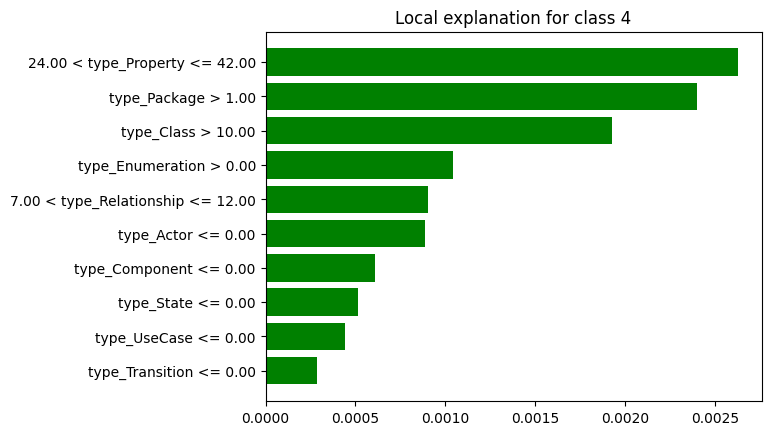

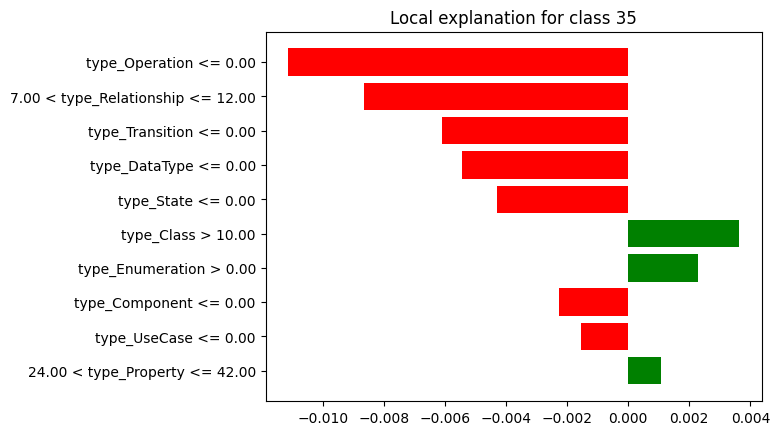

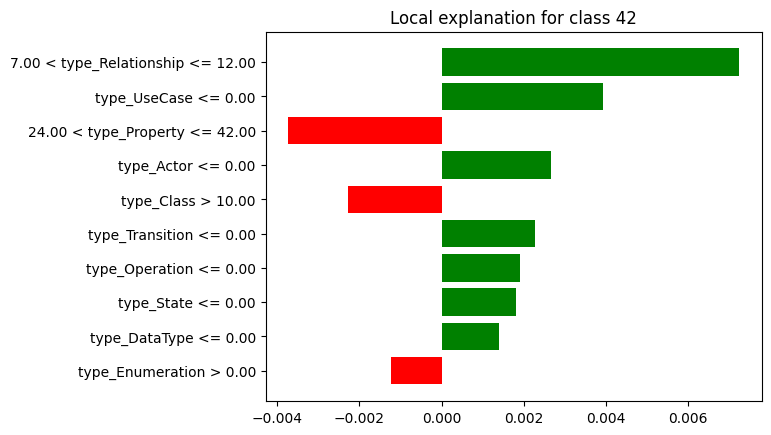

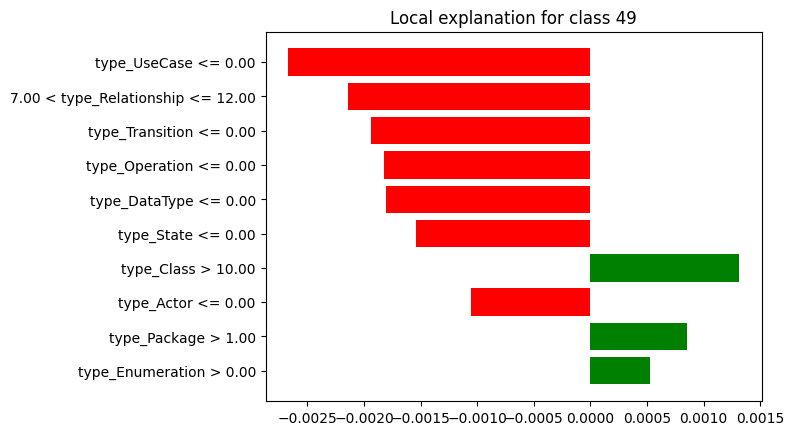

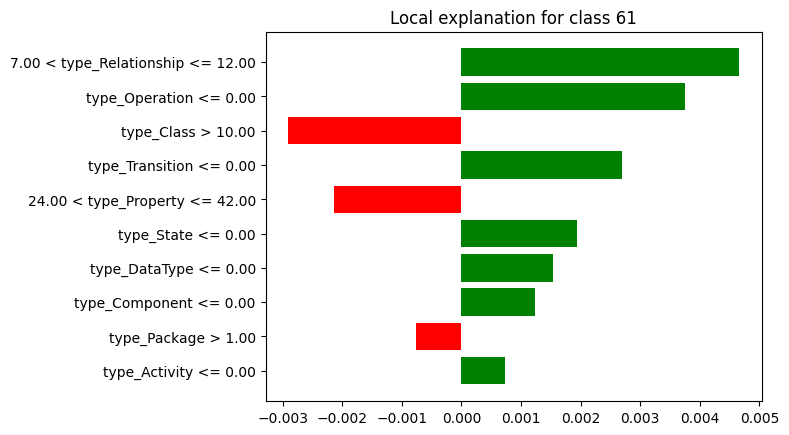

In [ ]:
for i in class_index:
  svc_exp_results['lime_bank'][i].plot()

In [ ]:
breakdown_df_bank_ban = breakdown_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_ban = breakdown_df_bank_ban.drop(index=[0, 14])
breakdown_df_bank_ban['sign'] = breakdown_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_ban = breakdown_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_ban = shap_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_ban = shap_df_bank_ban.tail(13)
shap_df_bank_ban['sign'] = shap_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_ban = shap_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_ban["Feature"] = lime_df_bank_ban["variable"].str.split(" ").str[0]
lime_df_bank_ban["Sign"] = lime_df_bank_ban["effect"].apply(evaluate_value)
lime_df_bank_ban = lime_df_bank_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['variable'])


breakdown_df_bank_ban['Ranking'] = breakdown_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_ban = breakdown_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_ban['Ranking'] = shap_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_ban = shap_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_ban['Ranking'] = lime_df_bank_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_ban = lime_df_bank_ban.head(10)
lime_df_bank_ban = lime_df_bank_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_ban = breakdown_df_bank_ban.drop(columns=['contribution'])
shap_df_bank_ban = shap_df_bank_ban.drop(columns=['contribution'])
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['effect'])


breakdown_df_bank_ban = breakdown_df_bank_ban.head(10)
breakdown_df_bank_ban = breakdown_df_bank_ban.reset_index(drop=True)

shap_df_bank_ban= shap_df_bank_ban.head(10)
shap_df_bank_ban = shap_df_bank_ban.reset_index(drop=True)

lime_df_bank_ban = lime_df_bank_ban.reset_index(drop=True)
lime_df_bank_ban.at[0, "Feature"] = "type_Property"
lime_df_bank_ban.at[4, "Feature"] = "type_Relationship"

print(breakdown_df_bank_ban)
print("---------------------------------")
print(shap_df_bank_ban)
print("---------------------------------")
print(lime_df_bank_ban)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1       type_UseCase        2  Positive
2  type_Relationship        3  Positive
3       type_Package        4  Positive
4   type_Enumeration        5  Positive
5         type_Class        6  Positive
6      type_Property        7  Positive
7      type_Activity        8  Positive
8     type_Component        9  Positive
9    type_Transition       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Positive
1         type_Class        2  Positive
2     type_Operation        3  Positive
3  type_Relationship        4  Positive
4       type_Package        5  Positive
5   type_Enumeration        6  Positive
6       type_UseCase        7  Positive
7         type_Actor        8  Positive
8      type_DataType        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_bank_ban['Feature'])
shap_features = list(shap_df_bank_ban['Feature'])
lime_features = list(lime_df_bank_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_ban['Feature'] = list(all_features)
df_final_ban_ban= df_final_ban_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_ban['Feature']:

    breakdown_row = breakdown_df_bank_ban[breakdown_df_bank_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_ban[shap_df_bank_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_ban[lime_df_bank_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_ban = df_final_ban_ban.loc[casos_validos]
df_final_ban_ban.set_index('Feature', inplace=True)
df_final_ban_ban

['type_Operation', 'type_UseCase', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_Class', 'type_Property', 'type_Activity', 'type_Component', 'type_Transition']
['type_Property', 'type_Class', 'type_Operation', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_UseCase', 'type_Actor', 'type_DataType', 'type_Activity']
['type_Property', 'type_Package', 'type_Class', 'type_Enumeration', 'type_Relationship', 'type_Actor', 'type_Component', 'type_State', 'type_UseCase', 'type_Transition']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Property', 'type_Operation', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       3  Positive       -         -
type_UseCase              2  Positive       7  Positive       9  Positive
type_Relationship         3  Positive       4  Positive       5  Positive
type_Package              4  Positive       5  Positive       2  Positive
type_Enumeration          5  Positive       6  Positive       4  Positive
type_Class                6  Positive       2  Positive       3  Positive
type_Property             7  Positive       1  Positive       1  Positive
type_Activity             8  Positive      10  Positive       -         -
type_Component            9  Positive       -         -       7  Positive
type_Transition          10  Positive       -         -      10  Positive
type_Actor                -         -       8  Positive       6  Positive
type_DataType             -         -       9  Positive       -         -
type_State                -         -       -         -       8  Positive

In [ ]:
breakdown_df_bank_vid = breakdown_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_vid = breakdown_df_bank_vid.drop(index=[0, 14])
breakdown_df_bank_vid['sign'] = breakdown_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_vid = breakdown_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_vid = shap_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_vid = shap_df_bank_vid.tail(13)
shap_df_bank_vid['sign'] = shap_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_vid = shap_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_vid["Feature"] = lime_df_bank_vid["variable"].str.split(" ").str[0]
lime_df_bank_vid["Sign"] = lime_df_bank_vid["effect"].apply(evaluate_value)
lime_df_bank_vid = lime_df_bank_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['variable'])


breakdown_df_bank_vid['Ranking'] = breakdown_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_vid = breakdown_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_vid['Ranking'] = shap_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_vid = shap_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_vid['Ranking'] = lime_df_bank_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_vid = lime_df_bank_vid.head(10)
lime_df_bank_vid = lime_df_bank_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_vid = breakdown_df_bank_vid.drop(columns=['contribution'])
shap_df_bank_vid = shap_df_bank_vid.drop(columns=['contribution'])
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['effect'])


breakdown_df_bank_vid = breakdown_df_bank_vid.head(10)
breakdown_df_bank_vid = breakdown_df_bank_vid.reset_index(drop=True)

shap_df_bank_vid= shap_df_bank_vid.head(10)
shap_df_bank_vid = shap_df_bank_vid.reset_index(drop=True)

lime_df_bank_vid = lime_df_bank_vid.reset_index(drop=True)
lime_df_bank_vid.at[1, "Feature"] = "type_Relationship"
lime_df_bank_vid.at[9, "Feature"] = "type_Property"

print(breakdown_df_bank_vid)
print("---------------------------------")
print(shap_df_bank_vid)
print("---------------------------------")
print(lime_df_bank_vid)

             Feature  Ranking      Sign
0         type_Class        1  Positive
1      type_Property        2  Negative
2     type_Operation        3  Negative
3  type_Relationship        4  Positive
4         type_Actor        5  Negative
5       type_UseCase        6  Negative
6       type_Package        7  Negative
7   type_Enumeration        8  Negative
8      type_DataType        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Negative
2         type_Class        3  Negative
3  type_Relationship        4  Positive
4         type_Actor        5  Negative
5       type_Package        6  Negative
6   type_Enumeration        7  Positive
7      type_DataType        8  Negative
8       type_UseCase        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_bank_vid['Feature'])
shap_features = list(shap_df_bank_vid['Feature'])
lime_features = list(lime_df_bank_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_vid['Feature'] = list(all_features)
df_final_ban_vid= df_final_ban_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_vid['Feature']:

    breakdown_row = breakdown_df_bank_vid[breakdown_df_bank_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_vid[shap_df_bank_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_vid[lime_df_bank_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_vid = df_final_ban_vid.loc[casos_validos]
df_final_ban_vid.set_index('Feature', inplace=True)
df_final_ban_vid

['type_Class', 'type_Property', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_UseCase', 'type_Package', 'type_Enumeration', 'type_DataType', 'type_Activity']
['type_Operation', 'type_Property', 'type_Class', 'type_Relationship', 'type_Actor', 'type_Package', 'type_Enumeration', 'type_DataType', 'type_UseCase', 'type_Activity']
['type_Operation', 'type_Relationship', 'type_Transition', 'type_DataType', 'type_State', 'type_Class', 'type_Enumeration', 'type_Component', 'type_UseCase', 'type_Property']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive       3  Negative       6  Positive
type_Property             2  Negative       2  Negative      10  Positive
type_Operation            3  Negative       1  Negative       1  Negative
type_Relationship         4  Positive       4  Positive       2  Negative
type_Actor                5  Negative       5  Negative       -         -
type_UseCase              6  Negative       9  Negative       9  Negative
type_Package              7  Negative       6  Negative       -         -
type_Enumeration          8  Negative       7  Positive       7  Positive
type_DataType             9  Negative       8  Negative       4  Negative
type_Activity            10  Negative      10  Negative       -         -
type_State                -         -       -         -       5  Negative
type_Component            -         -       -         -       8  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_bank_cou = breakdown_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_cou = breakdown_df_bank_cou.drop(index=[0, 14])
breakdown_df_bank_cou['sign'] = breakdown_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_cou = breakdown_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_cou = shap_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_cou = shap_df_bank_cou.tail(13)
shap_df_bank_cou['sign'] = shap_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_cou = shap_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_cou["Feature"] = lime_df_bank_cou["variable"].str.split(" ").str[0]
lime_df_bank_cou["Sign"] = lime_df_bank_cou["effect"].apply(evaluate_value)
lime_df_bank_cou = lime_df_bank_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['variable'])


breakdown_df_bank_cou['Ranking'] = breakdown_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_cou = breakdown_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_cou['Ranking'] = shap_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_cou = shap_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_cou['Ranking'] = lime_df_bank_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_cou = lime_df_bank_cou.head(10)
lime_df_bank_cou = lime_df_bank_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_cou = breakdown_df_bank_cou.drop(columns=['contribution'])
shap_df_bank_cou = shap_df_bank_cou.drop(columns=['contribution'])
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['effect'])


breakdown_df_bank_cou = breakdown_df_bank_cou.head(10)
breakdown_df_bank_cou = breakdown_df_bank_cou.reset_index(drop=True)

shap_df_bank_cou= shap_df_bank_cou.head(10)
shap_df_bank_cou = shap_df_bank_cou.reset_index(drop=True)

lime_df_bank_cou = lime_df_bank_cou.reset_index(drop=True)
lime_df_bank_cou.at[0, "Feature"] = "type_Relationship"
lime_df_bank_cou.at[2, "Feature"] = "type_Property"

print(breakdown_df_bank_cou)
print("---------------------------------")
print(shap_df_bank_cou)
print("---------------------------------")
print(lime_df_bank_cou)

             Feature  Ranking      Sign
0      type_Property        1  Positive
1     type_Operation        2  Negative
2  type_Relationship        3  Negative
3   type_Enumeration        4  Negative
4       type_Package        5  Negative
5         type_Actor        6  Negative
6         type_Class        7  Negative
7      type_DataType        8  Negative
8       type_UseCase        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1         type_Class        2  Negative
2      type_Property        3  Negative
3       type_Package        4  Negative
4   type_Enumeration        5  Negative
5         type_Actor        6  Negative
6       type_UseCase        7  Negative
7      type_DataType        8  Negative
8  type_Relationship        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Rela

In [ ]:

breakdown_features = list(breakdown_df_bank_cou['Feature'])
shap_features = list(shap_df_bank_cou['Feature'])
lime_features = list(lime_df_bank_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_cou['Feature'] = list(all_features)
df_final_ban_cou= df_final_ban_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_cou['Feature']:

    breakdown_row = breakdown_df_bank_cou[breakdown_df_bank_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_cou[shap_df_bank_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_cou[lime_df_bank_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_cou = df_final_ban_cou.loc[casos_validos]
df_final_ban_cou.set_index('Feature', inplace=True)
df_final_ban_cou

['type_Property', 'type_Operation', 'type_Relationship', 'type_Enumeration', 'type_Package', 'type_Actor', 'type_Class', 'type_DataType', 'type_UseCase', 'type_Activity']
['type_Operation', 'type_Class', 'type_Property', 'type_Package', 'type_Enumeration', 'type_Actor', 'type_UseCase', 'type_DataType', 'type_Relationship', 'type_Activity']
['type_Relationship', 'type_UseCase', 'type_Property', 'type_Actor', 'type_Class', 'type_Transition', 'type_Operation', 'type_State', 'type_DataType', 'type_Enumeration']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Positive       3  Negative       3  Negative
type_Operation            2  Negative       1  Negative       7  Positive
type_Relationship         3  Negative       9  Negative       1  Positive
type_Enumeration          4  Negative       5  Negative      10  Negative
type_Package              5  Negative       4  Negative       -         -
type_Actor                6  Negative       6  Negative       4  Positive
type_Class                7  Negative       2  Negative       5  Negative
type_DataType             8  Negative       8  Negative       9  Positive
type_UseCase              9  Negative       7  Negative       2  Positive
type_Activity            10  Negative      10  Negative       -         -
type_State                -         -       -         -       8  Positive
type_Transition           -         -       -         -       6  Positive

In [ ]:
breakdown_df_bank_emp = breakdown_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_emp = breakdown_df_bank_emp.drop(index=[0, 14])
breakdown_df_bank_emp['sign'] = breakdown_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_emp = breakdown_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_emp = shap_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_emp = shap_df_bank_emp.tail(13)
shap_df_bank_emp['sign'] = shap_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_emp = shap_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_emp["Feature"] = lime_df_bank_emp["variable"].str.split(" ").str[0]
lime_df_bank_emp["Sign"] = lime_df_bank_emp["effect"].apply(evaluate_value)
lime_df_bank_emp = lime_df_bank_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['variable'])


breakdown_df_bank_emp['Ranking'] = breakdown_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_emp = breakdown_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_emp['Ranking'] = shap_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_emp = shap_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_emp['Ranking'] = lime_df_bank_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_emp = lime_df_bank_emp.head(10)
lime_df_bank_emp = lime_df_bank_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_emp = breakdown_df_bank_emp.drop(columns=['contribution'])
shap_df_bank_emp = shap_df_bank_emp.drop(columns=['contribution'])
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['effect'])


breakdown_df_bank_emp = breakdown_df_bank_emp.head(10)
breakdown_df_bank_emp = breakdown_df_bank_emp.reset_index(drop=True)

shap_df_bank_emp= shap_df_bank_emp.head(10)
shap_df_bank_emp = shap_df_bank_emp.reset_index(drop=True)

lime_df_bank_emp = lime_df_bank_emp.reset_index(drop=True)
lime_df_bank_emp.at[1, "Feature"] = "type_Relationship"

print(breakdown_df_bank_emp)
print("---------------------------------")
print(shap_df_bank_emp)
print("---------------------------------")
print(lime_df_bank_emp)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1       type_UseCase        2  Negative
2     type_Operation        3  Negative
3  type_Relationship        4  Negative
4         type_Class        5  Positive
5      type_Activity        6  Positive
6     type_Component        7  Negative
7   type_Enumeration        8  Positive
8       type_Package        9  Negative
9         type_Actor       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_UseCase        2  Negative
2       type_Package        3  Negative
3  type_Relationship        4  Negative
4     type_Operation        5  Negative
5      type_Property        6  Negative
6         type_Actor        7  Negative
7   type_Enumeration        8  Negative
8      type_DataType        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_bank_emp['Feature'])
shap_features = list(shap_df_bank_emp['Feature'])
lime_features = list(lime_df_bank_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_emp['Feature'] = list(all_features)
df_final_ban_emp= df_final_ban_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_emp['Feature']:

    breakdown_row = breakdown_df_bank_emp[breakdown_df_bank_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_emp[shap_df_bank_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_emp[lime_df_bank_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_emp = df_final_ban_emp.loc[casos_validos]
df_final_ban_emp.set_index('Feature', inplace=True)
df_final_ban_emp

['type_Property', 'type_UseCase', 'type_Operation', 'type_Relationship', 'type_Class', 'type_Activity', 'type_Component', 'type_Enumeration', 'type_Package', 'type_Actor']
['type_Class', 'type_UseCase', 'type_Package', 'type_Relationship', 'type_Operation', 'type_Property', 'type_Actor', 'type_Enumeration', 'type_DataType', 'type_Activity']
['type_UseCase', 'type_Relationship', 'type_Transition', 'type_Operation', 'type_DataType', 'type_State', 'type_Class', 'type_Actor', 'type_Package', 'type_Enumeration']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_Property', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       6  Negative       -         -
type_UseCase              2  Negative       2  Negative       1  Negative
type_Operation            3  Negative       5  Negative       4  Negative
type_Relationship         4  Negative       4  Negative       2  Negative
type_Class                5  Positive       1  Negative       7  Positive
type_Activity             6  Positive      10  Negative       -         -
type_Component            7  Negative       -         -       -         -
type_Enumeration          8  Positive       8  Negative      10  Positive
type_Package              9  Negative       3  Negative       9  Positive
type_Actor               10  Negative       7  Negative       8  Negative
type_DataType             -         -       9  Negative       5  Negative
type_State                -         -       -         -       6  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_bank_lib = breakdown_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_lib = breakdown_df_bank_lib.drop(index=[0, 14])
breakdown_df_bank_lib['sign'] = breakdown_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_lib = breakdown_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_lib = shap_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_lib = shap_df_bank_lib.tail(13)
shap_df_bank_lib['sign'] = shap_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_lib = shap_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_lib["Feature"] = lime_df_bank_lib["variable"].str.split(" ").str[0]
lime_df_bank_lib["Sign"] = lime_df_bank_lib["effect"].apply(evaluate_value)
lime_df_bank_lib = lime_df_bank_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['variable'])


breakdown_df_bank_lib['Ranking'] = breakdown_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_lib = breakdown_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_lib['Ranking'] = shap_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_lib = shap_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_lib['Ranking'] = lime_df_bank_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_lib = lime_df_bank_lib.head(10)
lime_df_bank_lib = lime_df_bank_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_lib = breakdown_df_bank_lib.drop(columns=['contribution'])
shap_df_bank_lib = shap_df_bank_lib.drop(columns=['contribution'])
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['effect'])


breakdown_df_bank_lib = breakdown_df_bank_lib.head(10)
breakdown_df_bank_lib = breakdown_df_bank_lib.reset_index(drop=True)

shap_df_bank_lib= shap_df_bank_lib.head(10)
shap_df_bank_lib = shap_df_bank_lib.reset_index(drop=True)

lime_df_bank_lib = lime_df_bank_lib.reset_index(drop=True)
lime_df_bank_lib.at[0, "Feature"] = "type_Relationship"
lime_df_bank_lib.at[4, "Feature"] = "type_Property"

print(breakdown_df_bank_lib)
print("---------------------------------")
print(shap_df_bank_lib)
print("---------------------------------")
print(lime_df_bank_lib)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Negative
2   type_Enumeration        3  Negative
3       type_UseCase        4  Negative
4       type_Package        5  Negative
5     type_Operation        6  Positive
6  type_Relationship        7  Negative
7         type_Actor        8  Negative
8     type_Component        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1         type_Class        2  Negative
2  type_Relationship        3  Negative
3      type_Property        4  Negative
4   type_Enumeration        5  Negative
5       type_Package        6  Negative
6         type_Actor        7  Negative
7     type_Operation        8  Negative
8     type_Component        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Rela

In [ ]:

breakdown_features = list(breakdown_df_bank_lib['Feature'])
shap_features = list(shap_df_bank_lib['Feature'])
lime_features = list(lime_df_bank_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_lib['Feature'] = list(all_features)
df_final_ban_lib= df_final_ban_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_lib['Feature']:

    breakdown_row = breakdown_df_bank_lib[breakdown_df_bank_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_lib[shap_df_bank_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_lib[lime_df_bank_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_lib = df_final_ban_lib.loc[casos_validos]
df_final_ban_lib.set_index('Feature', inplace=True)
df_final_ban_lib

['type_Property', 'type_Class', 'type_Enumeration', 'type_UseCase', 'type_Package', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Activity']
['type_UseCase', 'type_Class', 'type_Relationship', 'type_Property', 'type_Enumeration', 'type_Package', 'type_Actor', 'type_Operation', 'type_Component', 'type_DataType']
['type_Relationship', 'type_Operation', 'type_Class', 'type_Transition', 'type_Property', 'type_State', 'type_DataType', 'type_Component', 'type_Package', 'type_Activity']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_UseCase', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       4  Negative       5  Negative
type_Class                2  Negative       2  Negative       3  Negative
type_Enumeration          3  Negative       5  Negative       -         -
type_UseCase              4  Negative       1  Negative       -         -
type_Package              5  Negative       6  Negative       9  Negative
type_Operation            6  Positive       8  Negative       2  Positive
type_Relationship         7  Negative       3  Negative       1  Positive
type_Actor                8  Negative       7  Negative       -         -
type_Component            9  Negative       9  Negative       8  Positive
type_Activity            10  Positive       -         -      10  Positive
type_DataType             -         -      10  Negative       7  Positive
type_State                -         -       -         -       6  Positive
type_Transition           -         -       -         -       4  Positive

### **Results Bank:**

In [ ]:
df_topfeatures_ban_ban = top5_features(df_final_ban_ban, 'Bank - Class: Bank')
df_topfeatures_ban_vid = top5_features(df_final_ban_vid, 'Bank - Class: ComputerVideogames')
df_topfeatures_ban_cou = top5_features(df_final_ban_cou, 'Bank - Class: Course')
df_topfeatures_ban_emp = top5_features(df_final_ban_emp, 'Bank - Class: Employee')
df_topfeatures_ban_lib = top5_features(df_final_ban_lib, 'Bank - Class: Library')

df_topfeatures_bank = pd.concat([df_topfeatures_ban_ban, df_topfeatures_ban_vid, df_topfeatures_ban_cou, df_topfeatures_ban_emp, df_topfeatures_ban_lib])
df_topfeatures_bank

TOP5 Breakdown  \
Bank - Class: Bank                type_Package, type_Enumeration, type_UseCase, ...   
Bank - Class: ComputerVideogames  type_Property, type_Operation, type_Relationsh...   
Bank - Class: Course              type_Package, type_Enumeration, type_Operation...   
Bank - Class: Employee            type_UseCase, type_Property, type_Operation, t...   
Bank - Class: Library             type_Package, type_Enumeration, type_Property,...   

                                                                          TOP5 Shap  \
Bank - Class: Bank                type_Package, type_Operation, type_Property, t...   
Bank - Class: ComputerVideogames  type_Property, type_Operation, type_Relationsh...   
Bank - Class: Course              type_Package, type_Enumeration, type_Operation...   
Bank - Class: Employee            type_Package, type_Operation, type_UseCase, ty...   
Bank - Class: Library             type_Enumeration, type_Property, type_UseCase,...   

                                                                          TOP5 Lime  \
Bank - Class: Bank                type_Package, type_Enumeration, type_Property,...   
Bank - Class: ComputerVideogames  type_Operation, type_Transition, type_DataType...   
Bank - Class: Course              type_Property, type_UseCase, type_Relationship...   
Bank - Class: Employee            type_Operation, type_UseCase, type_Transition,...   
Bank - Class: Library             type_Property, type_Operation, type_Transition...   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class: Bank                           0.6             0.6        0.8  
Bank - Class: ComputerVideogames             1.0             0.4        0.4  
Bank - Class: Course                         0.8             0.4        0.4  
Bank - Class: Employee                       0.8             0.6        0.6  
Bank - Class: Library                        0.8             0.4        0.6

In [ ]:
df_topfeatures_ban_ban_rank = top5_rank(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank = top5_rank(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank = top5_rank(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank = top5_rank(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank = top5_rank(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_bank = pd.concat([df_topfeatures_ban_ban_rank, df_topfeatures_ban_vid_rank, df_topfeatures_ban_cou_rank, df_topfeatures_ban_emp_rank, df_topfeatures_ban_lib_rank])
df_topfeatures_rank_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_Operation, 2:type_UseCase, 3:type_Relat...   
Bank - Class ComputerVideogames  1:type_Class, 2:type_Property, 3:type_Operatio...   
Bank - Class Course              1:type_Property, 2:type_Operation, 3:type_Rela...   
Bank - Class Employee            1:type_Property, 2:type_UseCase, 3:type_Operat...   
Bank - Class Library             1:type_Property, 2:type_Class, 3:type_Enumerat...   

                                                                         TOP5 Shap  \
Bank - Class Bank                3:type_Operation, 4:type_Relationship, 5:type_...   
Bank - Class ComputerVideogames  3:type_Class, 2:type_Property, 1:type_Operatio...   
Bank - Class Course              3:type_Property, 1:type_Operation, 5:type_Enum...   
Bank - Class Employee            2:type_UseCase, 5:type_Operation, 4:type_Relat...   
Bank - Class Library             4:type_Property, 2:type_Class, 5:type_Enumerat...   

                                                                         TOP5 Lime  \
Bank - Class Bank                5:type_Relationship, 2:type_Package, 4:type_En...   
Bank - Class ComputerVideogames  1:type_Operation, 2:type_Relationship, 4:type_...   
Bank - Class Course              3:type_Property, 1:type_Relationship, 4:type_A...   
Bank - Class Employee            1:type_UseCase, 4:type_Operation, 2:type_Relat...   
Bank - Class Library             5:type_Property, 3:type_Class, 2:type_Operatio...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.0             0.0        0.2  
Bank - Class ComputerVideogames             0.6             0.0        0.2  
Bank - Class Course                         0.0             0.0        0.2  
Bank - Class Employee                       0.4             0.0        0.0  
Bank - Class Library                        0.2             0.0        0.0

In [ ]:
df_topfeatures_ban_ban_sign = top5_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_sign = top5_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_sign = top5_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_sign = top5_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_sign = top5_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_sign_bank = pd.concat([df_topfeatures_ban_ban_sign, df_topfeatures_ban_vid_sign, df_topfeatures_ban_cou_sign, df_topfeatures_ban_emp_sign, df_topfeatures_ban_lib_sign])
df_topfeatures_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                type_Operation:Positive, type_UseCase:Positive...   
Bank - Class ComputerVideogames  type_Class:Positive, type_Property:Negative, t...   
Bank - Class Course              type_Property:Positive, type_Operation:Negativ...   
Bank - Class Employee            type_Property:Negative, type_UseCase:Negative,...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                         TOP5 Shap  \
Bank - Class Bank                type_Operation:Positive, type_Relationship:Pos...   
Bank - Class ComputerVideogames  type_Class:Negative, type_Property:Negative, t...   
Bank - Class Course              type_Property:Negative, type_Operation:Negativ...   
Bank - Class Employee            type_UseCase:Negative, type_Operation:Negative...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                         TOP5 Lime  \
Bank - Class Bank                type_Relationship:Positive, type_Package:Posit...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Relationship:Neg...   
Bank - Class Course              type_Property:Negative, type_Relationship:Posi...   
Bank - Class Employee            type_UseCase:Negative, type_Operation:Negative...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.6             0.6        0.8  
Bank - Class ComputerVideogames             0.8             0.2        0.2  
Bank - Class Course                         0.6             0.0        0.4  
Bank - Class Employee                       0.6             0.6        0.6  
Bank - Class Library                        0.8             0.4        0.4

In [ ]:
df_topfeatures_ban_ban_rank_sign = top5_rank_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank_sign = top5_rank_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank_sign = top5_rank_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank_sign = top5_rank_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank_sign = top5_rank_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_sign_bank = pd.concat([df_topfeatures_ban_ban_rank_sign, df_topfeatures_ban_vid_rank_sign, df_topfeatures_ban_cou_rank_sign, df_topfeatures_ban_emp_rank_sign, df_topfeatures_ban_lib_rank_sign])
df_topfeatures_rank_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_Operation:Positive, 2:type_UseCase:Posi...   
Bank - Class ComputerVideogames  1:type_Class:Positive, 2:type_Property:Negativ...   
Bank - Class Course              1:type_Property:Positive, 2:type_Operation:Neg...   
Bank - Class Employee            1:type_Property:Negative, 2:type_UseCase:Negat...   
Bank - Class Library             1:type_Property:Negative, 2:type_Class:Negativ...   

                                                                         TOP5 Shap  \
Bank - Class Bank                3:type_Operation:Positive, 4:type_Relationship...   
Bank - Class ComputerVideogames  3:type_Class:Negative, 2:type_Property:Negativ...   
Bank - Class Course              3:type_Property:Negative, 1:type_Operation:Neg...   
Bank - Class Employee            2:type_UseCase:Negative, 5:type_Operation:Nega...   
Bank - Class Library             4:type_Property:Negative, 2:type_Class:Negativ...   

                                                                         TOP5 Lime  \
Bank - Class Bank                5:type_Relationship:Positive, 2:type_Package:P...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Relationship...   
Bank - Class Course              3:type_Property:Negative, 1:type_Relationship:...   
Bank - Class Employee            1:type_UseCase:Negative, 4:type_Operation:Nega...   
Bank - Class Library             5:type_Property:Negative, 3:type_Class:Negativ...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.0             0.0        0.2  
Bank - Class ComputerVideogames             0.6             0.0        0.2  
Bank - Class Course                         0.0             0.0        0.2  
Bank - Class Employee                       0.4             0.0        0.0  
Bank - Class Library                        0.2             0.0        0.0

### **Employee:**

In [ ]:
breakdown_df_employee_ban = svc_exp_results['breakdown_employee'][0].result
shap_df_employee_ban = svc_exp_results['shap_employee'][0].result
lime_df_employee_ban = svc_exp_results['lime_employee'][0].result

In [ ]:
breakdown_df_employee_vid = svc_exp_results['breakdown_employee'][1].result
shap_df_employee_vid = svc_exp_results['shap_employee'][1].result
lime_df_employee_vid = svc_exp_results['lime_employee'][1].result

In [ ]:
breakdown_df_employee_cou = svc_exp_results['breakdown_employee'][3].result
shap_df_employee_cou = svc_exp_results['shap_employee'][3].result
lime_df_employee_cou = svc_exp_results['lime_employee'][3].result

In [ ]:
breakdown_df_employee_emp = svc_exp_results['breakdown_employee'][4].result
shap_df_employee_emp = svc_exp_results['shap_employee'][4].result
lime_df_employee_emp = svc_exp_results['lime_employee'][4].result

In [ ]:
breakdown_df_employee_lib = svc_exp_results['breakdown_employee'][6].result
shap_df_employee_lib = svc_exp_results['shap_employee'][6].result
lime_df_employee_lib = svc_exp_results['lime_employee'][6].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_employee'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_employee'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

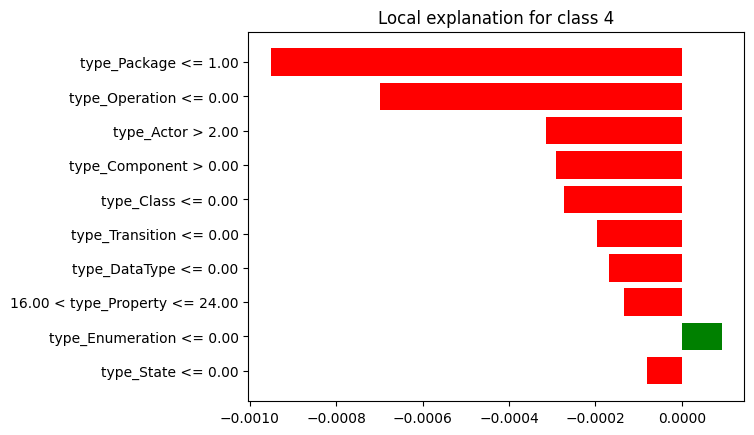

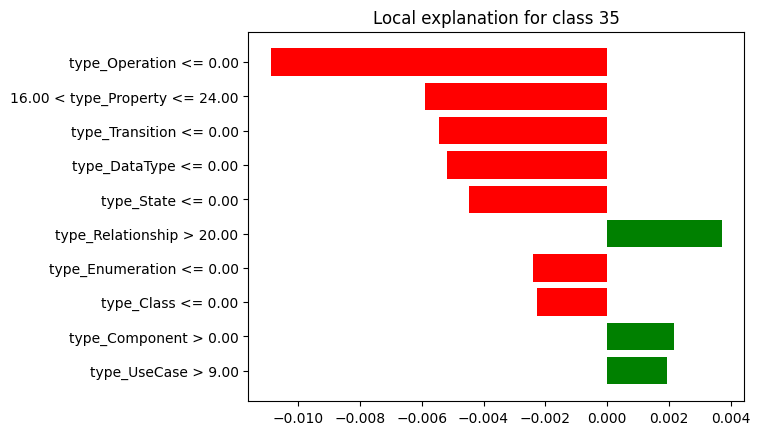

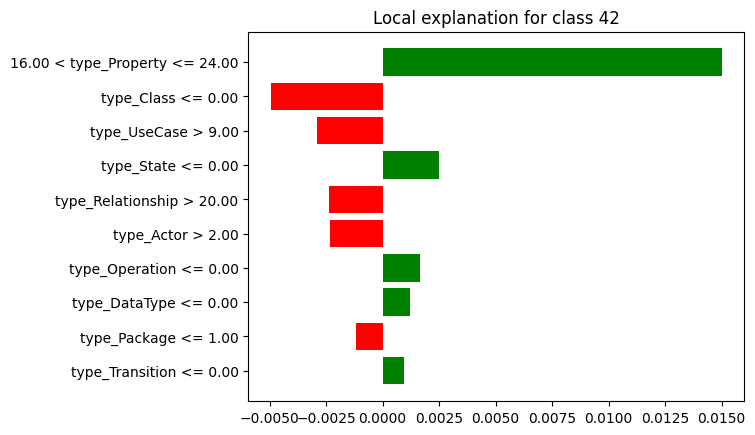

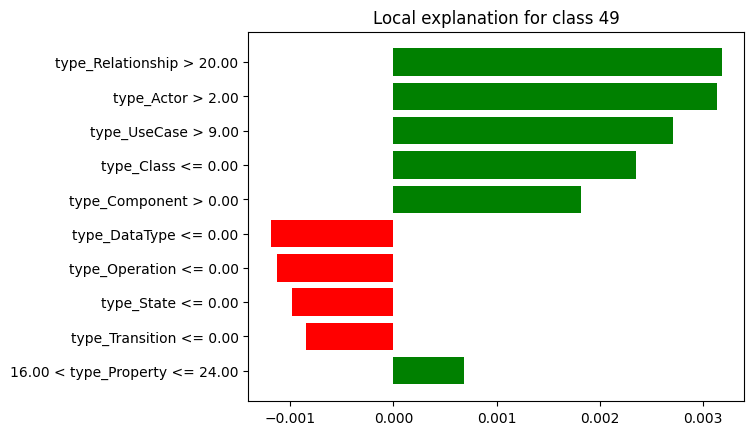

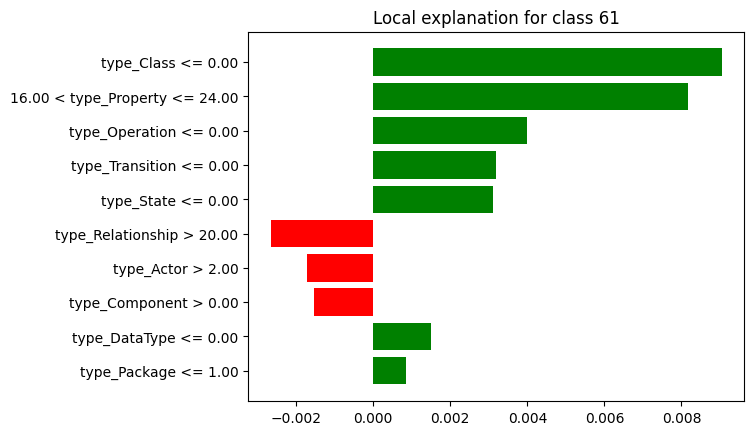

In [ ]:
for i in class_index:
  svc_exp_results['lime_employee'][i].plot()

In [ ]:
breakdown_df_employee_ban = breakdown_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_ban = breakdown_df_employee_ban.drop(index=[0, 14])
breakdown_df_employee_ban['sign'] = breakdown_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_ban = breakdown_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_ban = shap_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_ban = shap_df_employee_ban.tail(13)
shap_df_employee_ban['sign'] = shap_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_ban = shap_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_ban["Feature"] = lime_df_employee_ban["variable"].str.split(" ").str[0]
lime_df_employee_ban["Sign"] = lime_df_employee_ban["effect"].apply(evaluate_value)
lime_df_employee_ban = lime_df_employee_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['variable'])


breakdown_df_employee_ban['Ranking'] = breakdown_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_ban = breakdown_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_ban['Ranking'] = shap_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_ban = shap_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_ban['Ranking'] = lime_df_employee_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_ban = lime_df_employee_ban.head(10)
lime_df_employee_ban = lime_df_employee_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_ban = breakdown_df_employee_ban.drop(columns=['contribution'])
shap_df_employee_ban = shap_df_employee_ban.drop(columns=['contribution'])
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['effect'])


breakdown_df_employee_ban = breakdown_df_employee_ban.head(10)
breakdown_df_employee_ban = breakdown_df_employee_ban.reset_index(drop=True)

shap_df_employee_ban= shap_df_employee_ban.head(10)
shap_df_employee_ban = shap_df_employee_ban.reset_index(drop=True)

lime_df_employee_ban = lime_df_employee_ban.reset_index(drop=True)
lime_df_employee_ban.at[7, "Feature"] = "type_Property"

print(breakdown_df_employee_ban)
print("---------------------------------")
print(shap_df_employee_ban)
print("---------------------------------")
print(lime_df_employee_ban)

             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1       type_Package        2  Negative
2   type_Enumeration        3  Negative
3         type_Actor        4  Negative
4      type_Property        5  Positive
5       type_UseCase        6  Positive
6     type_Operation        7  Negative
7      type_DataType        8  Positive
8         type_Class        9  Negative
9     type_Component       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1       type_UseCase        2  Negative
2      type_Property        3  Negative
3         type_Class        4  Negative
4         type_Actor        5  Negative
5   type_Enumeration        6  Negative
6     type_Operation        7  Negative
7       type_Package        8  Negative
8     type_Component        9  Negative
9      type_Activity       10  Negative
---------------------------------
            Feature  Ranking      Sign
0      type_P

In [ ]:

breakdown_features = list(breakdown_df_employee_ban['Feature'])
shap_features = list(shap_df_employee_ban['Feature'])
lime_features = list(lime_df_employee_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_ban['Feature'] = list(all_features)
df_final_emp_ban= df_final_emp_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_ban['Feature']:

    breakdown_row = breakdown_df_employee_ban[breakdown_df_employee_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_ban[shap_df_employee_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_ban[lime_df_employee_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_ban = df_final_emp_ban.loc[casos_validos]
df_final_emp_ban.set_index('Feature', inplace=True)
df_final_emp_ban

['type_Relationship', 'type_Package', 'type_Enumeration', 'type_Actor', 'type_Property', 'type_UseCase', 'type_Operation', 'type_DataType', 'type_Class', 'type_Component']
['type_Relationship', 'type_UseCase', 'type_Property', 'type_Class', 'type_Actor', 'type_Enumeration', 'type_Operation', 'type_Package', 'type_Component', 'type_Activity']
['type_Package', 'type_Operation', 'type_Actor', 'type_Component', 'type_Class', 'type_Transition', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_State']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_UseCase', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       1  Negative       -         -
type_Package              2  Negative       8  Negative       1  Negative
type_Enumeration          3  Negative       6  Negative       9  Positive
type_Actor                4  Negative       5  Negative       3  Negative
type_Property             5  Positive       3  Negative       8  Negative
type_UseCase              6  Positive       2  Negative       -         -
type_Operation            7  Negative       7  Negative       2  Negative
type_DataType             8  Positive       -         -       7  Negative
type_Class                9  Negative       4  Negative       5  Negative
type_Component           10  Negative       9  Negative       4  Negative
type_Activity             -         -      10  Negative       -         -
type_State                -         -       -         -      10  Negative
type_Transition           -         -       -         -       6  Negative

In [ ]:
breakdown_df_employee_vid = breakdown_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_vid = breakdown_df_employee_vid.drop(index=[0, 14])
breakdown_df_employee_vid['sign'] = breakdown_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_vid = breakdown_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_vid = shap_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_vid = shap_df_employee_vid.tail(13)
shap_df_employee_vid['sign'] = shap_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_vid = shap_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_vid["Feature"] = lime_df_employee_vid["variable"].str.split(" ").str[0]
lime_df_employee_vid["Sign"] = lime_df_employee_vid["effect"].apply(evaluate_value)
lime_df_employee_vid = lime_df_employee_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['variable'])


breakdown_df_employee_vid['Ranking'] = breakdown_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_vid = breakdown_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_vid['Ranking'] = shap_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_vid = shap_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_vid['Ranking'] = lime_df_employee_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_vid = lime_df_employee_vid.head(10)
lime_df_employee_vid = lime_df_employee_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_vid = breakdown_df_employee_vid.drop(columns=['contribution'])
shap_df_employee_vid = shap_df_employee_vid.drop(columns=['contribution'])
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['effect'])


breakdown_df_employee_vid = breakdown_df_employee_vid.head(10)
breakdown_df_employee_vid = breakdown_df_employee_vid.reset_index(drop=True)

shap_df_employee_vid= shap_df_employee_vid.head(10)
shap_df_employee_vid = shap_df_employee_vid.reset_index(drop=True)

lime_df_employee_vid = lime_df_employee_vid.reset_index(drop=True)
lime_df_employee_vid.at[1, "Feature"] = "type_Property"

print(breakdown_df_employee_vid)
print("---------------------------------")
print(shap_df_employee_vid)
print("---------------------------------")
print(lime_df_employee_vid)

             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1     type_Operation        2  Negative
2         type_Actor        3  Negative
3      type_Property        4  Negative
4         type_Class        5  Negative
5      type_DataType        6  Negative
6  type_Relationship        7  Positive
7   type_Enumeration        8  Negative
8     type_Component        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1         type_Class        2  Negative
2     type_Operation        3  Negative
3      type_Property        4  Negative
4         type_Actor        5  Negative
5       type_UseCase        6  Negative
6      type_DataType        7  Negative
7       type_Package        8  Negative
8   type_Enumeration        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_employee_vid['Feature'])
shap_features = list(shap_df_employee_vid['Feature'])
lime_features = list(lime_df_employee_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_vid['Feature'] = list(all_features)
df_final_emp_vid= df_final_emp_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_vid['Feature']:

    breakdown_row = breakdown_df_employee_vid[breakdown_df_employee_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_vid[shap_df_employee_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_vid[lime_df_employee_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_vid = df_final_emp_vid.loc[casos_validos]
df_final_emp_vid.set_index('Feature', inplace=True)
df_final_emp_vid

['type_UseCase', 'type_Operation', 'type_Actor', 'type_Property', 'type_Class', 'type_DataType', 'type_Relationship', 'type_Enumeration', 'type_Component', 'type_Package']
['type_Relationship', 'type_Class', 'type_Operation', 'type_Property', 'type_Actor', 'type_UseCase', 'type_DataType', 'type_Package', 'type_Enumeration', 'type_Activity']
['type_Operation', 'type_Property', 'type_Transition', 'type_DataType', 'type_State', 'type_Relationship', 'type_Enumeration', 'type_Class', 'type_Component', 'type_UseCase']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       6  Negative      10  Positive
type_Operation            2  Negative       3  Negative       1  Negative
type_Actor                3  Negative       5  Negative       -         -
type_Property             4  Negative       4  Negative       2  Negative
type_Class                5  Negative       2  Negative       8  Negative
type_DataType             6  Negative       7  Negative       4  Negative
type_Relationship         7  Positive       1  Positive       6  Positive
type_Enumeration          8  Negative       9  Negative       7  Negative
type_Component            9  Negative       -         -       9  Positive
type_Package             10  Negative       8  Negative       -         -
type_Activity             -         -      10  Negative       -         -
type_State                -         -       -         -       5  Negative
type_Transition           -         -       -         -       3  Negative

In [ ]:
breakdown_df_employee_cou = breakdown_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_cou = breakdown_df_employee_cou.drop(index=[0, 14])
breakdown_df_employee_cou['sign'] = breakdown_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_cou = breakdown_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_cou = shap_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_cou = shap_df_employee_cou.tail(13)
shap_df_employee_cou['sign'] = shap_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_cou = shap_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_cou["Feature"] = lime_df_employee_cou["variable"].str.split(" ").str[0]
lime_df_employee_cou["Sign"] = lime_df_employee_cou["effect"].apply(evaluate_value)
lime_df_employee_cou = lime_df_employee_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['variable'])


breakdown_df_employee_cou['Ranking'] = breakdown_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_cou = breakdown_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_cou['Ranking'] = shap_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_cou = shap_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_cou['Ranking'] = lime_df_employee_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_cou = lime_df_employee_cou.head(10)
lime_df_employee_cou = lime_df_employee_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_cou = breakdown_df_employee_cou.drop(columns=['contribution'])
shap_df_employee_cou = shap_df_employee_cou.drop(columns=['contribution'])
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['effect'])


breakdown_df_employee_cou = breakdown_df_employee_cou.head(10)
breakdown_df_employee_cou = breakdown_df_employee_cou.reset_index(drop=True)

shap_df_employee_cou= shap_df_employee_cou.head(10)
shap_df_employee_cou = shap_df_employee_cou.reset_index(drop=True)

lime_df_employee_cou = lime_df_employee_cou.reset_index(drop=True)
lime_df_employee_cou.at[0, "Feature"] = "type_Property"

print(breakdown_df_employee_cou)
print("---------------------------------")
print(shap_df_employee_cou)
print("---------------------------------")
print(lime_df_employee_cou)

             Feature  Ranking      Sign
0      type_Property        1  Positive
1       type_UseCase        2  Negative
2         type_Actor        3  Negative
3     type_Operation        4  Negative
4         type_Class        5  Negative
5      type_DataType        6  Negative
6  type_Relationship        7  Negative
7   type_Enumeration        8  Negative
8     type_Component        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1      type_Property        2  Negative
2         type_Actor        3  Negative
3       type_UseCase        4  Negative
4     type_Operation        5  Negative
5     type_Component        6  Negative
6      type_DataType        7  Negative
7  type_Relationship        8  Negative
8   type_Enumeration        9  Positive
9    type_Transition       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_employee_cou['Feature'])
shap_features = list(shap_df_employee_cou['Feature'])
lime_features = list(lime_df_employee_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_cou['Feature'] = list(all_features)
df_final_emp_cou= df_final_emp_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_cou['Feature']:

    breakdown_row = breakdown_df_employee_cou[breakdown_df_employee_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_cou[shap_df_employee_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_cou[lime_df_employee_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_cou = df_final_emp_cou.loc[casos_validos]
df_final_emp_cou.set_index('Feature', inplace=True)
df_final_emp_cou

['type_Property', 'type_UseCase', 'type_Actor', 'type_Operation', 'type_Class', 'type_DataType', 'type_Relationship', 'type_Enumeration', 'type_Component', 'type_Activity']
['type_Class', 'type_Property', 'type_Actor', 'type_UseCase', 'type_Operation', 'type_Component', 'type_DataType', 'type_Relationship', 'type_Enumeration', 'type_Transition']
['type_Property', 'type_Class', 'type_UseCase', 'type_State', 'type_Relationship', 'type_Actor', 'type_Operation', 'type_DataType', 'type_Package', 'type_Transition']
['type_State', 'type_Actor', 'type_Relationship', 'type_Class', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_Property', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Positive       2  Negative       1  Positive
type_UseCase              2  Negative       4  Negative       3  Negative
type_Actor                3  Negative       3  Negative       6  Negative
type_Operation            4  Negative       5  Negative       7  Positive
type_Class                5  Negative       1  Negative       2  Negative
type_DataType             6  Negative       7  Negative       8  Positive
type_Relationship         7  Negative       8  Negative       5  Negative
type_Enumeration          8  Negative       9  Positive       -         -
type_Component            9  Negative       6  Negative       -         -
type_Activity            10  Negative       -         -       -         -
type_Transition           -         -      10  Negative      10  Positive
type_State                -         -       -         -       4  Positive
type_Package              -         -       -         -       9  Negative

In [ ]:
breakdown_df_employee_emp = breakdown_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_emp = breakdown_df_employee_emp.drop(index=[0, 14])
breakdown_df_employee_emp['sign'] = breakdown_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_emp = breakdown_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_emp = shap_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_emp = shap_df_employee_emp.tail(13)
shap_df_employee_emp['sign'] = shap_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_emp = shap_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_emp["Feature"] = lime_df_employee_emp["variable"].str.split(" ").str[0]
lime_df_employee_emp["Sign"] = lime_df_employee_emp["effect"].apply(evaluate_value)
lime_df_employee_emp = lime_df_employee_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['variable'])


breakdown_df_employee_emp['Ranking'] = breakdown_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_emp = breakdown_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_emp['Ranking'] = shap_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_emp = shap_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_emp['Ranking'] = lime_df_employee_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_emp = lime_df_employee_emp.head(10)
lime_df_employee_emp = lime_df_employee_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_emp = breakdown_df_employee_emp.drop(columns=['contribution'])
shap_df_employee_emp = shap_df_employee_emp.drop(columns=['contribution'])
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['effect'])


breakdown_df_employee_emp = breakdown_df_employee_emp.head(10)
breakdown_df_employee_emp = breakdown_df_employee_emp.reset_index(drop=True)

shap_df_employee_emp= shap_df_employee_emp.head(10)
shap_df_employee_emp = shap_df_employee_emp.reset_index(drop=True)

lime_df_employee_emp = lime_df_employee_emp.reset_index(drop=True)
lime_df_employee_emp.at[9, "Feature"] = "type_Property"

print(breakdown_df_employee_emp)
print("---------------------------------")
print(shap_df_employee_emp)
print("---------------------------------")
print(lime_df_employee_emp)

             Feature  Ranking      Sign
0      type_Property        1  Positive
1     type_Operation        2  Positive
2         type_Class        3  Positive
3  type_Relationship        4  Positive
4       type_UseCase        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Positive
7      type_Activity        8  Positive
8   type_Enumeration        9  Negative
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1         type_Class        2  Positive
2  type_Relationship        3  Positive
3      type_Property        4  Positive
4         type_Actor        5  Positive
5     type_Operation        6  Positive
6     type_Component        7  Positive
7       type_Package        8  Positive
8   type_Enumeration        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0  type_Rela

In [ ]:

breakdown_features = list(breakdown_df_employee_emp['Feature'])
shap_features = list(shap_df_employee_emp['Feature'])
lime_features = list(lime_df_employee_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_emp['Feature'] = list(all_features)
df_final_emp_emp= df_final_emp_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_emp['Feature']:

    breakdown_row = breakdown_df_employee_emp[breakdown_df_employee_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_emp[shap_df_employee_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_emp[lime_df_employee_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_emp = df_final_emp_emp.loc[casos_validos]
df_final_emp_emp.set_index('Feature', inplace=True)
df_final_emp_emp

['type_Property', 'type_Operation', 'type_Class', 'type_Relationship', 'type_UseCase', 'type_Actor', 'type_Component', 'type_Activity', 'type_Enumeration', 'type_DataType']
['type_UseCase', 'type_Class', 'type_Relationship', 'type_Property', 'type_Actor', 'type_Operation', 'type_Component', 'type_Package', 'type_Enumeration', 'type_DataType']
['type_Relationship', 'type_Actor', 'type_UseCase', 'type_Class', 'type_Component', 'type_DataType', 'type_Operation', 'type_State', 'type_Transition', 'type_Property']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Positive       4  Positive      10  Positive
type_Operation            2  Positive       6  Positive       7  Negative
type_Class                3  Positive       2  Positive       4  Positive
type_Relationship         4  Positive       3  Positive       1  Positive
type_UseCase              5  Positive       1  Positive       3  Positive
type_Actor                6  Positive       5  Positive       2  Positive
type_Component            7  Positive       7  Positive       5  Positive
type_Activity             8  Positive       -         -       -         -
type_Enumeration          9  Negative       9  Positive       -         -
type_DataType            10  Positive      10  Positive       6  Negative
type_Package              -         -       8  Positive       -         -
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -       9  Negative

In [ ]:
breakdown_df_employee_lib = breakdown_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_lib = breakdown_df_employee_lib.drop(index=[0, 14])
breakdown_df_employee_lib['sign'] = breakdown_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_lib = breakdown_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_lib = shap_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_lib = shap_df_employee_lib.tail(13)
shap_df_employee_lib['sign'] = shap_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_lib = shap_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_lib["Feature"] = lime_df_employee_lib["variable"].str.split(" ").str[0]
lime_df_employee_lib["Sign"] = lime_df_employee_lib["effect"].apply(evaluate_value)
lime_df_employee_lib = lime_df_employee_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['variable'])


breakdown_df_employee_lib['Ranking'] = breakdown_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_lib = breakdown_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_lib['Ranking'] = shap_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_lib = shap_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_lib['Ranking'] = lime_df_employee_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_lib = lime_df_employee_lib.head(10)
lime_df_employee_lib = lime_df_employee_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_lib = breakdown_df_employee_lib.drop(columns=['contribution'])
shap_df_employee_lib = shap_df_employee_lib.drop(columns=['contribution'])
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['effect'])


breakdown_df_employee_lib = breakdown_df_employee_lib.head(10)
breakdown_df_employee_lib = breakdown_df_employee_lib.reset_index(drop=True)

shap_df_employee_lib= shap_df_employee_lib.head(10)
shap_df_employee_lib = shap_df_employee_lib.reset_index(drop=True)

lime_df_employee_lib = lime_df_employee_lib.reset_index(drop=True)
lime_df_employee_lib.at[1, "Feature"] = "type_Property"

print(breakdown_df_employee_lib)
print("---------------------------------")
print(shap_df_employee_lib)
print("---------------------------------")
print(lime_df_employee_lib)

             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_Property        2  Positive
2       type_UseCase        3  Positive
3      type_DataType        4  Positive
4         type_Actor        5  Positive
5     type_Component        6  Positive
6   type_Enumeration        7  Positive
7         type_Class        8  Positive
8      type_Activity        9  Positive
9     type_Operation       10  Positive
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_Property        2  Negative
2       type_UseCase        3  Positive
3         type_Actor        4  Negative
4         type_Class        5  Positive
5     type_Component        6  Positive
6   type_Enumeration        7  Positive
7    type_Transition        8  Negative
8      type_DataType        9  Positive
9     type_Operation       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_employee_lib['Feature'])
shap_features = list(shap_df_employee_lib['Feature'])
lime_features = list(lime_df_employee_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_lib['Feature'] = list(all_features)
df_final_emp_lib= df_final_emp_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_lib['Feature']:

    breakdown_row = breakdown_df_employee_lib[breakdown_df_employee_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_lib[shap_df_employee_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_lib[lime_df_employee_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_lib = df_final_emp_lib.loc[casos_validos]
df_final_emp_lib.set_index('Feature', inplace=True)
df_final_emp_lib

['type_Relationship', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Actor', 'type_Component', 'type_Enumeration', 'type_Class', 'type_Activity', 'type_Operation']
['type_Relationship', 'type_Property', 'type_UseCase', 'type_Actor', 'type_Class', 'type_Component', 'type_Enumeration', 'type_Transition', 'type_DataType', 'type_Operation']
['type_Class', 'type_Property', 'type_Operation', 'type_Transition', 'type_State', 'type_Relationship', 'type_Actor', 'type_Component', 'type_DataType', 'type_Package']
['type_State', 'type_Actor', 'type_Class', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Transition', 'type_Operation', 'type_UseCase', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       1  Negative       6  Negative
type_Property             2  Positive       2  Negative       2  Positive
type_UseCase              3  Positive       3  Positive       -         -
type_DataType             4  Positive       9  Positive       9  Positive
type_Actor                5  Positive       4  Negative       7  Negative
type_Component            6  Positive       6  Positive       8  Negative
type_Enumeration          7  Positive       7  Positive       -         -
type_Class                8  Positive       5  Positive       1  Positive
type_Activity             9  Positive       -         -       -         -
type_Operation           10  Positive      10  Negative       3  Positive
type_Transition           -         -       8  Negative       4  Positive
type_State                -         -       -         -       5  Positive
type_Package              -         -       -         -      10  Positive

### **Results Employee:**

In [ ]:
df_topfeatures_emp_ban = top5_features(df_final_emp_ban, 'Employee - Class: Bank')
df_topfeatures_emp_vid = top5_features(df_final_emp_vid, 'Employee - Class: ComputerVideogames')
df_topfeatures_emp_cou = top5_features(df_final_emp_cou, 'Employee - Class: Course')
df_topfeatures_emp_emp = top5_features(df_final_emp_emp, 'Employee - Class: Employee')
df_topfeatures_emp_lib = top5_features(df_final_emp_lib, 'Employee - Class: Library')

df_topfeatures_employee = pd.concat([df_topfeatures_emp_ban, df_topfeatures_emp_vid, df_topfeatures_emp_cou, df_topfeatures_emp_emp, df_topfeatures_emp_lib])
df_topfeatures_employee

TOP5 Breakdown  \
Employee - Class: Bank                type_Package, type_Enumeration, type_Property,...   
Employee - Class: ComputerVideogames  type_Property, type_Operation, type_UseCase, t...   
Employee - Class: Course              type_UseCase, type_Property, type_Operation, t...   
Employee - Class: Employee            type_Operation, type_Property, type_UseCase, t...   
Employee - Class: Library             type_Property, type_UseCase, type_DataType, ty...   

                                                                              TOP5 Shap  \
Employee - Class: Bank                type_Property, type_UseCase, type_Relationship...   
Employee - Class: ComputerVideogames  type_Property, type_Operation, type_Relationsh...   
Employee - Class: Course              type_UseCase, type_Property, type_Operation, t...   
Employee - Class: Employee            type_Property, type_UseCase, type_Relationship...   
Employee - Class: Library             type_Property, type_UseCase, type_Relationship...   

                                                                              TOP5 Lime  \
Employee - Class: Bank                type_Package, type_Operation, type_Component, ...   
Employee - Class: ComputerVideogames  type_Operation, type_Property, type_Transition...   
Employee - Class: Course              type_UseCase, type_Property, type_Relationship...   
Employee - Class: Employee            type_UseCase, type_Component, type_Class, type...   
Employee - Class: Library             type_Property, type_Operation, type_Transition...   

                                      Breakdown-Shap  Breakdown-Lime  \
Employee - Class: Bank                           0.6             0.4   
Employee - Class: ComputerVideogames             0.8             0.4   
Employee - Class: Course                         1.0             0.6   
Employee - Class: Employee                       0.8             0.6   
Employee - Class: Library                        0.8             0.2   

                                      Lime-Shap  
Employee - Class: Bank                      0.4  
Employee - Class: ComputerVideogames        0.4  
Employee - Class: Course                    0.6  
Employee - Class: Employee                  0.8  
Employee - Class: Library                   0.4

In [ ]:
df_topfeatures_emp_ban_rank = top5_rank(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank = top5_rank(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank = top5_rank(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank = top5_rank(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank = top5_rank(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_employee = pd.concat([df_topfeatures_emp_ban_rank, df_topfeatures_emp_vid_rank, df_topfeatures_emp_cou_rank, df_topfeatures_emp_emp_rank, df_topfeatures_emp_lib_rank])
df_topfeatures_rank_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Relationship, 2:type_Package, 3:type_En...   
Employee - Class ComputerVideogames  1:type_UseCase, 2:type_Operation, 3:type_Actor...   
Employee - Class Course              1:type_Property, 2:type_UseCase, 3:type_Actor,...   
Employee - Class Employee            1:type_Property, 2:type_Operation, 3:type_Clas...   
Employee - Class Library             1:type_Relationship, 2:type_Property, 3:type_U...   

                                                                             TOP5 Shap  \
Employee - Class Bank                1:type_Relationship, 5:type_Actor, 3:type_Prop...   
Employee - Class ComputerVideogames  3:type_Operation, 5:type_Actor, 4:type_Propert...   
Employee - Class Course              2:type_Property, 4:type_UseCase, 3:type_Actor,...   
Employee - Class Employee            4:type_Property, 2:type_Class, 3:type_Relation...   
Employee - Class Library             1:type_Relationship, 2:type_Property, 3:type_U...   

                                                                             TOP5 Lime  \
Employee - Class Bank                1:type_Package, 3:type_Actor, 2:type_Operation...   
Employee - Class ComputerVideogames  1:type_Operation, 2:type_Property, 4:type_Data...   
Employee - Class Course              1:type_Property, 3:type_UseCase, 2:type_Class,...   
Employee - Class Employee            4:type_Class, 1:type_Relationship, 3:type_UseC...   
Employee - Class Library             2:type_Property, 1:type_Class, 3:type_Operatio...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.2             0.0        0.0  
Employee - Class ComputerVideogames             0.2             0.0        0.0  
Employee - Class Course                         0.2             0.2        0.0  
Employee - Class Employee                       0.0             0.0        0.0  
Employee - Class Library                        0.6             0.2        0.2

In [ ]:
df_topfeatures_emp_ban_sign = top5_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_sign = top5_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_sign = top5_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_sign = top5_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_sign = top5_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_sign_employee = pd.concat([df_topfeatures_emp_ban_sign, df_topfeatures_emp_vid_sign, df_topfeatures_emp_cou_sign, df_topfeatures_emp_emp_sign, df_topfeatures_emp_lib_sign])
df_topfeatures_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                type_Relationship:Negative, type_Package:Negat...   
Employee - Class ComputerVideogames  type_UseCase:Positive, type_Operation:Negative...   
Employee - Class Course              type_Property:Positive, type_UseCase:Negative,...   
Employee - Class Employee            type_Property:Positive, type_Operation:Positiv...   
Employee - Class Library             type_Relationship:Negative, type_Property:Posi...   

                                                                             TOP5 Shap  \
Employee - Class Bank                type_Relationship:Negative, type_Actor:Negativ...   
Employee - Class ComputerVideogames  type_Operation:Negative, type_Actor:Negative, ...   
Employee - Class Course              type_Property:Negative, type_UseCase:Negative,...   
Employee - Class Employee            type_Property:Positive, type_Class:Positive, t...   
Employee - Class Library             type_Relationship:Negative, type_Property:Nega...   

                                                                             TOP5 Lime  \
Employee - Class Bank                type_Package:Negative, type_Actor:Negative, ty...   
Employee - Class ComputerVideogames  type_Operation:Negative, type_Property:Negativ...   
Employee - Class Course              type_Property:Positive, type_UseCase:Negative,...   
Employee - Class Employee            type_Class:Positive, type_Relationship:Positiv...   
Employee - Class Library             type_Property:Positive, type_Class:Positive, t...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.4             0.4        0.4  
Employee - Class ComputerVideogames             0.8             0.4        0.4  
Employee - Class Course                         0.8             0.6        0.4  
Employee - Class Employee                       0.8             0.6        0.8  
Employee - Class Library                        0.4             0.2        0.2

In [ ]:
df_topfeatures_emp_ban_rank_sign = top5_rank_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank_sign = top5_rank_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank_sign = top5_rank_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank_sign = top5_rank_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank_sign = top5_rank_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_sign_employee = pd.concat([df_topfeatures_emp_ban_rank_sign, df_topfeatures_emp_vid_rank_sign, df_topfeatures_emp_cou_rank_sign, df_topfeatures_emp_emp_rank_sign, df_topfeatures_emp_lib_rank_sign])
df_topfeatures_rank_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Relationship:Negative, 2:type_Package:N...   
Employee - Class ComputerVideogames  1:type_UseCase:Positive, 2:type_Operation:Nega...   
Employee - Class Course              1:type_Property:Positive, 2:type_UseCase:Negat...   
Employee - Class Employee            1:type_Property:Positive, 2:type_Operation:Pos...   
Employee - Class Library             1:type_Relationship:Negative, 2:type_Property:...   

                                                                             TOP5 Shap  \
Employee - Class Bank                1:type_Relationship:Negative, 5:type_Actor:Neg...   
Employee - Class ComputerVideogames  3:type_Operation:Negative, 5:type_Actor:Negati...   
Employee - Class Course              2:type_Property:Negative, 4:type_UseCase:Negat...   
Employee - Class Employee            4:type_Property:Positive, 2:type_Class:Positiv...   
Employee - Class Library             1:type_Relationship:Negative, 2:type_Property:...   

                                                                             TOP5 Lime  \
Employee - Class Bank                1:type_Package:Negative, 3:type_Actor:Negative...   
Employee - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Property:Neg...   
Employee - Class Course              1:type_Property:Positive, 3:type_UseCase:Negat...   
Employee - Class Employee            4:type_Class:Positive, 1:type_Relationship:Pos...   
Employee - Class Library             2:type_Property:Positive, 1:type_Class:Positiv...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.2             0.0        0.0  
Employee - Class ComputerVideogames             0.2             0.0        0.0  
Employee - Class Course                         0.2             0.2        0.0  
Employee - Class Employee                       0.0             0.0        0.0  
Employee - Class Library                        0.4             0.2        0.0

## RF:

In [ ]:
exp_list_rf = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_rf, X_train,
        y_train,
        predict_function=pf,
        label=f'RFClassifier: class {class_value}',
        verbose=False
    )
    exp_list_rf += [e]

exp_list_rf

In [ ]:
inst_computervideogames = X_test.loc[inst_vid_rf]
inst_course = X_test.loc[inst_cou_rf]
inst_library = X_test.loc[inst_lib_rf]
inst_bank = X_test.loc[inst_ban_rf]
inst_employee = X_test.loc[inst_emp_rf]

In [ ]:
rf_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_rf]
    rf_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_rf]
    rf_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_rf)]
    rf_exp_results[f"lime_{instance}"] = lime_exp

### **Computer-Videogames:**

In [ ]:
breakdown_df_computervideogames_ban = rf_exp_results['breakdown_computervideogames'][0].result
shap_df_computervideogames_ban = rf_exp_results['shap_computervideogames'][0].result
lime_df_computervideogames_ban = rf_exp_results['lime_computervideogames'][0].result

In [ ]:
breakdown_df_computervideogames_vid = rf_exp_results['breakdown_computervideogames'][1].result
shap_df_computervideogames_vid = rf_exp_results['shap_computervideogames'][1].result
lime_df_computervideogames_vid = rf_exp_results['lime_computervideogames'][1].result

In [ ]:
breakdown_df_computervideogames_cou = rf_exp_results['breakdown_computervideogames'][3].result
shap_df_computervideogames_cou = rf_exp_results['shap_computervideogames'][3].result
lime_df_computervideogames_cou = rf_exp_results['lime_computervideogames'][3].result

In [ ]:
breakdown_df_computervideogames_emp = rf_exp_results['breakdown_computervideogames'][4].result
shap_df_computervideogames_emp = rf_exp_results['shap_computervideogames'][4].result
lime_df_computervideogames_emp = rf_exp_results['lime_computervideogames'][4].result

In [ ]:
breakdown_df_computervideogames_lib = rf_exp_results['breakdown_computervideogames'][6].result
shap_df_computervideogames_lib = rf_exp_results['shap_computervideogames'][6].result
lime_df_computervideogames_lib = rf_exp_results['lime_computervideogames'][6].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_computervideogames'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_computervideogames'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

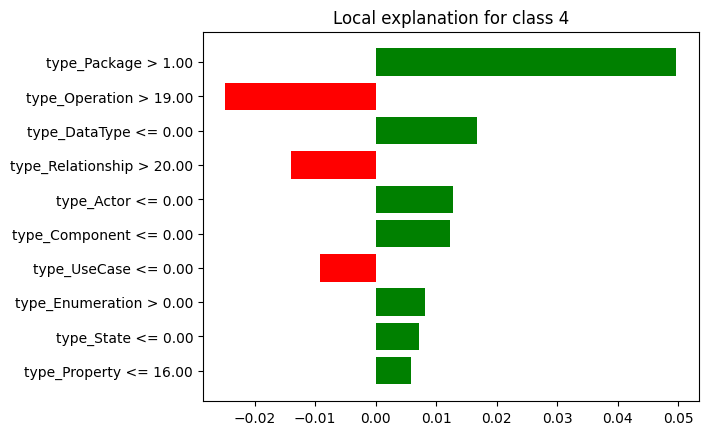

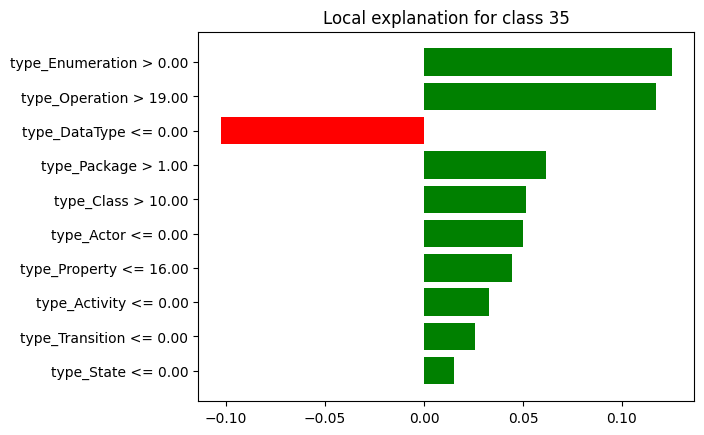

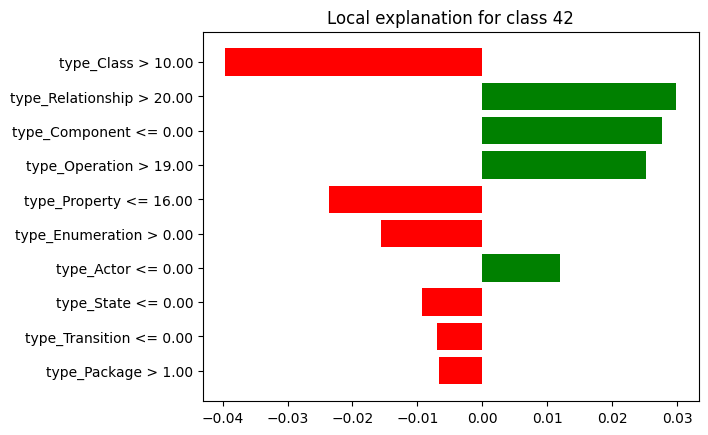

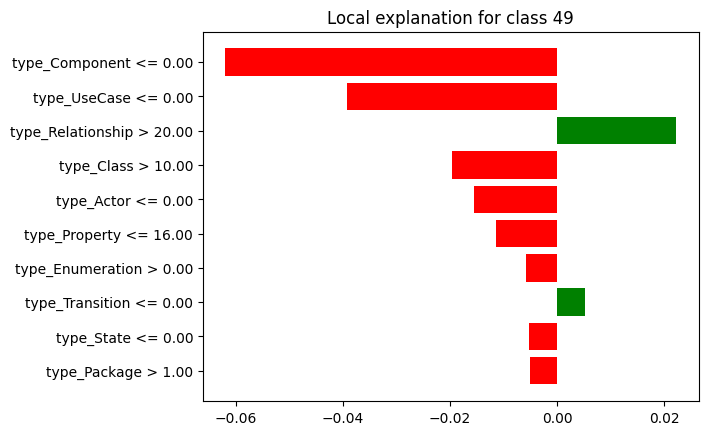

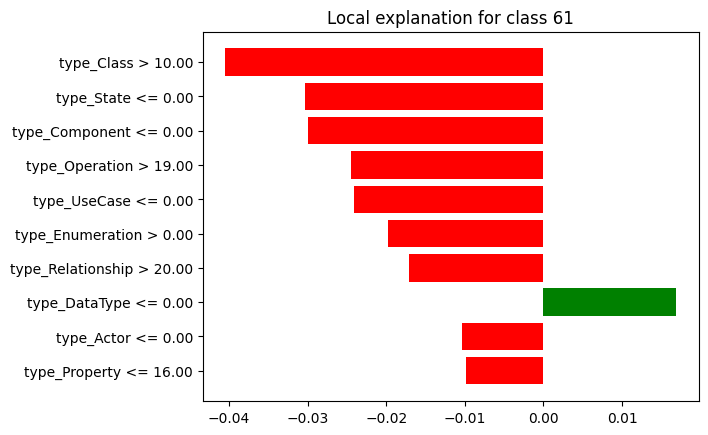

In [ ]:
for i in class_index:
  rf_exp_results['lime_computervideogames'][i].plot()

In [ ]:
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(index=[0, 14])
breakdown_df_computervideogames_ban['sign'] = breakdown_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_ban = shap_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_ban = shap_df_computervideogames_ban.tail(13)
shap_df_computervideogames_ban['sign'] = shap_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_ban = shap_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_ban["Feature"] = lime_df_computervideogames_ban["variable"].str.split(" ").str[0]
lime_df_computervideogames_ban["Sign"] = lime_df_computervideogames_ban["effect"].apply(evaluate_value)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['variable'])


breakdown_df_computervideogames_ban['Ranking'] = breakdown_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_ban['Ranking'] = shap_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_ban = shap_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_ban['Ranking'] = lime_df_computervideogames_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.head(10)
lime_df_computervideogames_ban = lime_df_computervideogames_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(columns=['contribution'])
shap_df_computervideogames_ban = shap_df_computervideogames_ban.drop(columns=['contribution'])
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['effect'])


breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.head(10)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.reset_index(drop=True)

shap_df_computervideogames_ban= shap_df_computervideogames_ban.head(10)
shap_df_computervideogames_ban = shap_df_computervideogames_ban.reset_index(drop=True)

lime_df_computervideogames_ban = lime_df_computervideogames_ban.reset_index(drop=True)

print(breakdown_df_computervideogames_ban)
print("---------------------------------")
print(shap_df_computervideogames_ban)
print("---------------------------------")
print(lime_df_computervideogames_ban)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1         type_Class        2  Negative
2   type_Enumeration        3  Positive
3  type_Relationship        4  Negative
4      type_Property        5  Positive
5       type_Package        6  Positive
6      type_Activity        7  Positive
7     type_Component        8  Positive
8         type_Actor        9  Positive
9       type_UseCase       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1       type_Package        2  Positive
2         type_Class        3  Negative
3  type_Relationship        4  Negative
4   type_Enumeration        5  Positive
5         type_Actor        6  Positive
6      type_Property        7  Negative
7      type_DataType        8  Positive
8      type_Activity        9  Positive
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_ban['Feature'])
shap_features = list(shap_df_computervideogames_ban['Feature'])
lime_features = list(lime_df_computervideogames_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_ban['Feature'] = list(all_features)
df_final_vid_ban= df_final_vid_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_ban['Feature']:

    breakdown_row = breakdown_df_computervideogames_ban[breakdown_df_computervideogames_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_ban[shap_df_computervideogames_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_ban[lime_df_computervideogames_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_ban = df_final_vid_ban.loc[casos_validos]
df_final_vid_ban.set_index('Feature', inplace=True)
df_final_vid_ban

['type_Operation', 'type_Class', 'type_Enumeration', 'type_Relationship', 'type_Property', 'type_Package', 'type_Activity', 'type_Component', 'type_Actor', 'type_UseCase']
['type_Operation', 'type_Package', 'type_Class', 'type_Relationship', 'type_Enumeration', 'type_Actor', 'type_Property', 'type_DataType', 'type_Activity', 'type_Component']
['type_Package', 'type_Operation', 'type_DataType', 'type_Relationship', 'type_Actor', 'type_Component', 'type_UseCase', 'type_Enumeration', 'type_State', 'type_Property']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       1  Negative       2  Negative
type_Class                2  Negative       3  Negative       -         -
type_Enumeration          3  Positive       5  Positive       8  Positive
type_Relationship         4  Negative       4  Negative       4  Negative
type_Property             5  Positive       7  Negative      10  Positive
type_Package              6  Positive       2  Positive       1  Positive
type_Activity             7  Positive       9  Positive       -         -
type_Component            8  Positive      10  Positive       6  Positive
type_Actor                9  Positive       6  Positive       5  Positive
type_UseCase             10  Positive       -         -       7  Negative
type_DataType             -         -       8  Positive       3  Positive
type_State                -         -       -         -       9  Positive

In [ ]:
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(index=[0, 14])
breakdown_df_computervideogames_vid['sign'] = breakdown_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_vid = shap_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_vid = shap_df_computervideogames_vid.tail(13)
shap_df_computervideogames_vid['sign'] = shap_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_vid = shap_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_vid["Feature"] = lime_df_computervideogames_vid["variable"].str.split(" ").str[0]
lime_df_computervideogames_vid["Sign"] = lime_df_computervideogames_vid["effect"].apply(evaluate_value)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['variable'])


breakdown_df_computervideogames_vid['Ranking'] = breakdown_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_vid['Ranking'] = shap_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_vid = shap_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_vid['Ranking'] = lime_df_computervideogames_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.head(10)
lime_df_computervideogames_vid = lime_df_computervideogames_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(columns=['contribution'])
shap_df_computervideogames_vid = shap_df_computervideogames_vid.drop(columns=['contribution'])
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['effect'])


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.head(10)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.reset_index(drop=True)

shap_df_computervideogames_vid= shap_df_computervideogames_vid.head(10)
shap_df_computervideogames_vid = shap_df_computervideogames_vid.reset_index(drop=True)

lime_df_computervideogames_vid = lime_df_computervideogames_vid.reset_index(drop=True)

print(breakdown_df_computervideogames_vid)
print("---------------------------------")
print(shap_df_computervideogames_vid)
print("---------------------------------")
print(lime_df_computervideogames_vid)

             Feature  Ranking      Sign
0   type_Enumeration        1  Positive
1         type_Class        2  Positive
2     type_Operation        3  Positive
3  type_Relationship        4  Positive
4       type_Package        5  Positive
5      type_Property        6  Positive
6         type_Actor        7  Positive
7      type_Activity        8  Positive
8       type_UseCase        9  Positive
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1   type_Enumeration        2  Positive
2       type_Package        3  Positive
3         type_Class        4  Positive
4      type_Property        5  Positive
5  type_Relationship        6  Positive
6         type_Actor        7  Positive
7       type_UseCase        8  Positive
8      type_Activity        9  Positive
9      type_DataType       10  Negative
---------------------------------
            Feature  Ranking      Sign
0  type_Enume

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_vid['Feature'])
shap_features = list(shap_df_computervideogames_vid['Feature'])
lime_features = list(lime_df_computervideogames_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_vid['Feature'] = list(all_features)
df_final_vid_vid= df_final_vid_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_vid['Feature']:

    breakdown_row = breakdown_df_computervideogames_vid[breakdown_df_computervideogames_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_vid[shap_df_computervideogames_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_vid[lime_df_computervideogames_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_vid = df_final_vid_vid.loc[casos_validos]
df_final_vid_vid.set_index('Feature', inplace=True)
df_final_vid_vid

['type_Enumeration', 'type_Class', 'type_Operation', 'type_Relationship', 'type_Package', 'type_Property', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Component']
['type_Operation', 'type_Enumeration', 'type_Package', 'type_Class', 'type_Property', 'type_Relationship', 'type_Actor', 'type_UseCase', 'type_Activity', 'type_DataType']
['type_Enumeration', 'type_Operation', 'type_DataType', 'type_Package', 'type_Class', 'type_Actor', 'type_Property', 'type_Activity', 'type_Transition', 'type_State']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Enumeration          1  Positive       2  Positive       1  Positive
type_Class                2  Positive       4  Positive       5  Positive
type_Operation            3  Positive       1  Positive       2  Positive
type_Relationship         4  Positive       6  Positive       -         -
type_Package              5  Positive       3  Positive       4  Positive
type_Property             6  Positive       5  Positive       7  Positive
type_Actor                7  Positive       7  Positive       6  Positive
type_Activity             8  Positive       9  Positive       8  Positive
type_UseCase              9  Positive       8  Positive       -         -
type_Component           10  Positive       -         -       -         -
type_DataType             -         -      10  Negative       3  Negative
type_State                -         -       -         -      10  Positive
type_Transition           -         -       -         -       9  Positive

In [ ]:
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(index=[0, 14])
breakdown_df_computervideogames_cou['sign'] = breakdown_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_cou = shap_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_cou = shap_df_computervideogames_cou.tail(13)
shap_df_computervideogames_cou['sign'] = shap_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_cou = shap_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_cou["Feature"] = lime_df_computervideogames_cou["variable"].str.split(" ").str[0]
lime_df_computervideogames_cou["Sign"] = lime_df_computervideogames_cou["effect"].apply(evaluate_value)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['variable'])


breakdown_df_computervideogames_cou['Ranking'] = breakdown_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_cou['Ranking'] = shap_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_cou = shap_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_cou['Ranking'] = lime_df_computervideogames_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.head(10)
lime_df_computervideogames_cou = lime_df_computervideogames_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(columns=['contribution'])
shap_df_computervideogames_cou = shap_df_computervideogames_cou.drop(columns=['contribution'])
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['effect'])


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.head(10)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.reset_index(drop=True)

shap_df_computervideogames_cou= shap_df_computervideogames_cou.head(10)
shap_df_computervideogames_cou = shap_df_computervideogames_cou.reset_index(drop=True)

lime_df_computervideogames_cou = lime_df_computervideogames_cou.reset_index(drop=True)

print(breakdown_df_computervideogames_cou)
print("---------------------------------")
print(shap_df_computervideogames_cou)
print("---------------------------------")
print(lime_df_computervideogames_cou)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1         type_Class        2  Negative
2       type_Package        3  Negative
3   type_Enumeration        4  Negative
4  type_Relationship        5  Positive
5      type_Property        6  Negative
6     type_Component        7  Positive
7      type_Activity        8  Positive
8       type_UseCase        9  Negative
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1     type_Operation        2  Positive
2       type_Package        3  Negative
3   type_Enumeration        4  Negative
4  type_Relationship        5  Positive
5      type_Property        6  Negative
6       type_UseCase        7  Negative
7     type_Component        8  Positive
8         type_Actor        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_cou['Feature'])
shap_features = list(shap_df_computervideogames_cou['Feature'])
lime_features = list(lime_df_computervideogames_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_cou['Feature'] = list(all_features)
df_final_vid_cou= df_final_vid_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_cou['Feature']:

    breakdown_row = breakdown_df_computervideogames_cou[breakdown_df_computervideogames_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_cou[shap_df_computervideogames_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_cou[lime_df_computervideogames_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_cou = df_final_vid_cou.loc[casos_validos]
df_final_vid_cou.set_index('Feature', inplace=True)
df_final_vid_cou

['type_Operation', 'type_Class', 'type_Package', 'type_Enumeration', 'type_Relationship', 'type_Property', 'type_Component', 'type_Activity', 'type_UseCase', 'type_Actor']
['type_Class', 'type_Operation', 'type_Package', 'type_Enumeration', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_Component', 'type_Actor', 'type_DataType']
['type_Class', 'type_Relationship', 'type_Component', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Actor', 'type_State', 'type_Transition', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       2  Positive       4  Positive
type_Class                2  Negative       1  Negative       1  Negative
type_Package              3  Negative       3  Negative      10  Negative
type_Enumeration          4  Negative       4  Negative       6  Negative
type_Relationship         5  Positive       5  Positive       2  Positive
type_Property             6  Negative       6  Negative       5  Negative
type_Component            7  Positive       8  Positive       3  Positive
type_Activity             8  Positive       -         -       -         -
type_UseCase              9  Negative       7  Negative       -         -
type_Actor               10  Positive       9  Negative       7  Positive
type_DataType             -         -      10  Negative       -         -
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -       9  Negative

In [ ]:
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(index=[0, 14])
breakdown_df_computervideogames_emp['sign'] = breakdown_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_emp = shap_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_emp = shap_df_computervideogames_emp.tail(13)
shap_df_computervideogames_emp['sign'] = shap_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_emp = shap_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_emp["Feature"] = lime_df_computervideogames_emp["variable"].str.split(" ").str[0]
lime_df_computervideogames_emp["Sign"] = lime_df_computervideogames_emp["effect"].apply(evaluate_value)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['variable'])


breakdown_df_computervideogames_emp['Ranking'] = breakdown_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_emp['Ranking'] = shap_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_emp = shap_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_emp['Ranking'] = lime_df_computervideogames_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.head(10)
lime_df_computervideogames_emp = lime_df_computervideogames_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(columns=['contribution'])
shap_df_computervideogames_emp = shap_df_computervideogames_emp.drop(columns=['contribution'])
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['effect'])


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.head(10)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.reset_index(drop=True)

shap_df_computervideogames_emp= shap_df_computervideogames_emp.head(10)
shap_df_computervideogames_emp = shap_df_computervideogames_emp.reset_index(drop=True)

lime_df_computervideogames_emp = lime_df_computervideogames_emp.reset_index(drop=True)

print(breakdown_df_computervideogames_emp)
print("---------------------------------")
print(shap_df_computervideogames_emp)
print("---------------------------------")
print(lime_df_computervideogames_emp)

             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1  type_Relationship        2  Positive
2     type_Operation        3  Negative
3         type_Actor        4  Negative
4     type_Component        5  Negative
5   type_Enumeration        6  Negative
6         type_Class        7  Negative
7      type_Activity        8  Positive
8       type_Package        9  Negative
9      type_Property       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_UseCase        2  Negative
2     type_Operation        3  Negative
3     type_Component        4  Negative
4  type_Relationship        5  Positive
5         type_Actor        6  Negative
6      type_Property        7  Negative
7       type_Package        8  Negative
8   type_Enumeration        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_emp['Feature'])
shap_features = list(shap_df_computervideogames_emp['Feature'])
lime_features = list(lime_df_computervideogames_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_emp['Feature'] = list(all_features)
df_final_vid_emp= df_final_vid_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_emp['Feature']:

    breakdown_row = breakdown_df_computervideogames_emp[breakdown_df_computervideogames_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_emp[shap_df_computervideogames_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_emp[lime_df_computervideogames_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_emp = df_final_vid_emp.loc[casos_validos]
df_final_vid_emp.set_index('Feature', inplace=True)
df_final_vid_emp

['type_UseCase', 'type_Relationship', 'type_Operation', 'type_Actor', 'type_Component', 'type_Enumeration', 'type_Class', 'type_Activity', 'type_Package', 'type_Property']
['type_Class', 'type_UseCase', 'type_Operation', 'type_Component', 'type_Relationship', 'type_Actor', 'type_Property', 'type_Package', 'type_Enumeration', 'type_Activity']
['type_Component', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Actor', 'type_Property', 'type_Enumeration', 'type_Transition', 'type_State', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Negative       2  Negative       2  Negative
type_Relationship         2  Positive       5  Positive       3  Positive
type_Operation            3  Negative       3  Negative       -         -
type_Actor                4  Negative       6  Negative       5  Negative
type_Component            5  Negative       4  Negative       1  Negative
type_Enumeration          6  Negative       9  Negative       7  Negative
type_Class                7  Negative       1  Negative       4  Negative
type_Activity             8  Positive      10  Positive       -         -
type_Package              9  Negative       8  Negative      10  Negative
type_Property            10  Positive       7  Negative       6  Negative
type_State                -         -       -         -       9  Negative
type_Transition           -         -       -         -       8  Positive

In [ ]:
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(index=[0, 14])
breakdown_df_computervideogames_lib['sign'] = breakdown_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_lib = shap_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_lib = shap_df_computervideogames_lib.tail(13)
shap_df_computervideogames_lib['sign'] = shap_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_lib = shap_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_lib["Feature"] = lime_df_computervideogames_lib["variable"].str.split(" ").str[0]
lime_df_computervideogames_lib["Sign"] = lime_df_computervideogames_lib["effect"].apply(evaluate_value)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['variable'])


breakdown_df_computervideogames_lib['Ranking'] = breakdown_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_lib['Ranking'] = shap_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_lib = shap_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_lib['Ranking'] = lime_df_computervideogames_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.head(10)
lime_df_computervideogames_lib = lime_df_computervideogames_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(columns=['contribution'])
shap_df_computervideogames_lib = shap_df_computervideogames_lib.drop(columns=['contribution'])
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['effect'])


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.head(10)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.reset_index(drop=True)

shap_df_computervideogames_lib= shap_df_computervideogames_lib.head(10)
shap_df_computervideogames_lib = shap_df_computervideogames_lib.reset_index(drop=True)

lime_df_computervideogames_lib = lime_df_computervideogames_lib.reset_index(drop=True)

print(breakdown_df_computervideogames_lib)
print("---------------------------------")
print(shap_df_computervideogames_lib)
print("---------------------------------")
print(lime_df_computervideogames_lib)

             Feature  Ranking      Sign
0     type_Component        1  Negative
1       type_Package        2  Negative
2     type_Operation        3  Negative
3   type_Enumeration        4  Negative
4         type_Actor        5  Negative
5         type_Class        6  Negative
6      type_Activity        7  Positive
7      type_Property        8  Positive
8  type_Relationship        9  Negative
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_UseCase        2  Negative
2  type_Relationship        3  Negative
3     type_Operation        4  Negative
4     type_Component        5  Negative
5   type_Enumeration        6  Negative
6       type_Package        7  Negative
7         type_Actor        8  Negative
8      type_Property        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_lib['Feature'])
shap_features = list(shap_df_computervideogames_lib['Feature'])
lime_features = list(lime_df_computervideogames_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_lib['Feature'] = list(all_features)
df_final_vid_lib= df_final_vid_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_lib['Feature']:

    breakdown_row = breakdown_df_computervideogames_lib[breakdown_df_computervideogames_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_lib[shap_df_computervideogames_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_lib[lime_df_computervideogames_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_lib = df_final_vid_lib.loc[casos_validos]
df_final_vid_lib.set_index('Feature', inplace=True)
df_final_vid_lib

['type_Component', 'type_Package', 'type_Operation', 'type_Enumeration', 'type_Actor', 'type_Class', 'type_Activity', 'type_Property', 'type_Relationship', 'type_DataType']
['type_Class', 'type_UseCase', 'type_Relationship', 'type_Operation', 'type_Component', 'type_Enumeration', 'type_Package', 'type_Actor', 'type_Property', 'type_DataType']
['type_Class', 'type_State', 'type_Component', 'type_Operation', 'type_UseCase', 'type_Enumeration', 'type_Relationship', 'type_DataType', 'type_Actor', 'type_Property']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Component            1  Negative       5  Negative       3  Negative
type_Package              2  Negative       7  Negative       -         -
type_Operation            3  Negative       4  Negative       4  Negative
type_Enumeration          4  Negative       6  Negative       6  Negative
type_Actor                5  Negative       8  Negative       9  Negative
type_Class                6  Negative       1  Negative       1  Negative
type_Activity             7  Positive       -         -       -         -
type_Property             8  Positive       9  Positive      10  Negative
type_Relationship         9  Negative       3  Negative       7  Negative
type_DataType            10  Positive      10  Positive       8  Positive
type_UseCase              -         -       2  Negative       5  Negative
type_State                -         -       -         -       2  Negative

### **Results Computer-Videogames:**

In [ ]:
df_topfeatures_vid_ban = top5_features(df_final_vid_ban, 'ComputerVideogames - Class: Bank')
df_topfeatures_vid_vid = top5_features(df_final_vid_vid, 'ComputerVideogames - Class: ComputerVideogames')
df_topfeatures_vid_cou = top5_features(df_final_vid_cou, 'ComputerVideogames - Class: Course')
df_topfeatures_vid_emp = top5_features(df_final_vid_emp, 'ComputerVideogames - Class: Employee')
df_topfeatures_vid_lib = top5_features(df_final_vid_lib, 'ComputerVideogames - Class: Library')

df_topfeatures_computervideogames = pd.concat([df_topfeatures_vid_ban, df_topfeatures_vid_vid, df_topfeatures_vid_cou, df_topfeatures_vid_emp, df_topfeatures_vid_lib])
df_topfeatures_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class: Bank                type_Class, type_Property, type_Relationship, ...   
ComputerVideogames - Class: ComputerVideogames  type_Package, type_Class, type_Relationship, t...   
ComputerVideogames - Class: Course              type_Package, type_Class, type_Relationship, t...   
ComputerVideogames - Class: Employee            type_Component, type_Actor, type_UseCase, type...   
ComputerVideogames - Class: Library             type_Component, type_Package, type_Actor, type...   

                                                                                        TOP5 Shap  \
ComputerVideogames - Class: Bank                type_Package, type_Class, type_Relationship, t...   
ComputerVideogames - Class: ComputerVideogames  type_Package, type_Class, type_Property, type_...   
ComputerVideogames - Class: Course              type_Package, type_Class, type_Relationship, t...   
ComputerVideogames - Class: Employee            type_Component, type_Class, type_UseCase, type...   
ComputerVideogames - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                                                                        TOP5 Lime  \
ComputerVideogames - Class: Bank                type_Package, type_Actor, type_DataType, type_...   
ComputerVideogames - Class: ComputerVideogames  type_Package, type_Class, type_DataType, type_...   
ComputerVideogames - Class: Course              type_Component, type_Class, type_Property, typ...   
ComputerVideogames - Class: Employee            type_Component, type_Actor, type_Class, type_U...   
ComputerVideogames - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                                Breakdown-Shap  \
ComputerVideogames - Class: Bank                           0.8   
ComputerVideogames - Class: ComputerVideogames             0.8   
ComputerVideogames - Class: Course                         1.0   
ComputerVideogames - Class: Employee                       0.8   
ComputerVideogames - Class: Library                        0.4   

                                                Breakdown-Lime  Lime-Shap  
ComputerVideogames - Class: Bank                           0.4        0.6  
ComputerVideogames - Class: ComputerVideogames             0.8        0.8  
ComputerVideogames - Class: Course                         0.6        0.6  
ComputerVideogames - Class: Employee                       0.8        0.8  
ComputerVideogames - Class: Library                        0.4        0.8

In [ ]:
df_topfeatures_vid_ban_rank = top5_rank(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank = top5_rank(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank = top5_rank(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank = top5_rank(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank = top5_rank(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_computervideogames = pd.concat([df_topfeatures_vid_ban_rank, df_topfeatures_vid_vid_rank, df_topfeatures_vid_cou_rank, df_topfeatures_vid_emp_rank, df_topfeatures_vid_lib_rank])
df_topfeatures_rank_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Operation, 2:type_Class, 3:type_Enumera...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration, 2:type_Class, 3:type_Opera...   
ComputerVideogames - Class Course              1:type_Operation, 2:type_Class, 3:type_Package...   
ComputerVideogames - Class Employee            1:type_UseCase, 2:type_Relationship, 3:type_Op...   
ComputerVideogames - Class Library             1:type_Component, 2:type_Package, 3:type_Opera...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                1:type_Operation, 3:type_Class, 5:type_Enumera...   
ComputerVideogames - Class ComputerVideogames  2:type_Enumeration, 4:type_Class, 1:type_Opera...   
ComputerVideogames - Class Course              2:type_Operation, 1:type_Class, 3:type_Package...   
ComputerVideogames - Class Employee            2:type_UseCase, 5:type_Relationship, 3:type_Op...   
ComputerVideogames - Class Library             5:type_Component, 4:type_Operation, 1:type_Cla...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                2:type_Operation, 4:type_Relationship, 1:type_...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration, 5:type_Class, 2:type_Opera...   
ComputerVideogames - Class Course              4:type_Operation, 1:type_Class, 2:type_Relatio...   
ComputerVideogames - Class Employee            2:type_UseCase, 3:type_Relationship, 5:type_Ac...   
ComputerVideogames - Class Library             3:type_Component, 4:type_Operation, 1:type_Cla...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.4             0.2   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.6             0.0   
ComputerVideogames - Class Employee                       0.2             0.0   
ComputerVideogames - Class Library                        0.0             0.0   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.2  
ComputerVideogames - Class ComputerVideogames        0.0  
ComputerVideogames - Class Course                    0.2  
ComputerVideogames - Class Employee                  0.2  
ComputerVideogames - Class Library                   0.4

In [ ]:
df_topfeatures_vid_ban_sign = top5_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_sign = top5_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_sign = top5_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_sign = top5_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_sign = top5_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_sign, df_topfeatures_vid_vid_sign, df_topfeatures_vid_cou_sign, df_topfeatures_vid_emp_sign, df_topfeatures_vid_lib_sign])
df_topfeatures_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                type_Operation:Negative, type_Class:Negative, ...   
ComputerVideogames - Class ComputerVideogames  type_Enumeration:Positive, type_Class:Positive...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Class:Negative, ...   
ComputerVideogames - Class Employee            type_UseCase:Negative, type_Relationship:Posit...   
ComputerVideogames - Class Library             type_Component:Negative, type_Package:Negative...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                type_Operation:Negative, type_Class:Negative, ...   
ComputerVideogames - Class ComputerVideogames  type_Enumeration:Positive, type_Class:Positive...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Class:Negative, ...   
ComputerVideogames - Class Employee            type_UseCase:Negative, type_Relationship:Posit...   
ComputerVideogames - Class Library             type_Component:Negative, type_Operation:Negati...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                type_Operation:Negative, type_Relationship:Neg...   
ComputerVideogames - Class ComputerVideogames  type_Enumeration:Positive, type_Class:Positive...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Class:Negative, ...   
ComputerVideogames - Class Employee            type_UseCase:Negative, type_Relationship:Posit...   
ComputerVideogames - Class Library             type_Component:Negative, type_Operation:Negati...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.8             0.4   
ComputerVideogames - Class ComputerVideogames             0.8             0.8   
ComputerVideogames - Class Course                         1.0             0.6   
ComputerVideogames - Class Employee                       0.8             0.8   
ComputerVideogames - Class Library                        0.4             0.4   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.6  
ComputerVideogames - Class ComputerVideogames        0.8  
ComputerVideogames - Class Course                    0.6  
ComputerVideogames - Class Employee                  0.8  
ComputerVideogames - Class Library                   0.8

In [ ]:
df_topfeatures_vid_ban_rank_sign = top5_rank_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank_sign = top5_rank_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank_sign = top5_rank_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank_sign = top5_rank_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank_sign = top5_rank_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_rank_sign, df_topfeatures_vid_vid_rank_sign, df_topfeatures_vid_cou_rank_sign, df_topfeatures_vid_emp_rank_sign, df_topfeatures_vid_lib_rank_sign])
df_topfeatures_rank_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Operation:Negative, 2:type_Class:Negati...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration:Positive, 2:type_Class:Posi...   
ComputerVideogames - Class Course              1:type_Operation:Positive, 2:type_Class:Negati...   
ComputerVideogames - Class Employee            1:type_UseCase:Negative, 2:type_Relationship:P...   
ComputerVideogames - Class Library             1:type_Component:Negative, 2:type_Package:Nega...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                1:type_Operation:Negative, 3:type_Class:Negati...   
ComputerVideogames - Class ComputerVideogames  2:type_Enumeration:Positive, 4:type_Class:Posi...   
ComputerVideogames - Class Course              2:type_Operation:Positive, 1:type_Class:Negati...   
ComputerVideogames - Class Employee            2:type_UseCase:Negative, 5:type_Relationship:P...   
ComputerVideogames - Class Library             5:type_Component:Negative, 4:type_Operation:Ne...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                2:type_Operation:Negative, 4:type_Relationship...   
ComputerVideogames - Class ComputerVideogames  1:type_Enumeration:Positive, 5:type_Class:Posi...   
ComputerVideogames - Class Course              4:type_Operation:Positive, 1:type_Class:Negati...   
ComputerVideogames - Class Employee            2:type_UseCase:Negative, 3:type_Relationship:P...   
ComputerVideogames - Class Library             3:type_Component:Negative, 4:type_Operation:Ne...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.4             0.2   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.6             0.0   
ComputerVideogames - Class Employee                       0.2             0.0   
ComputerVideogames - Class Library                        0.0             0.0   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.2  
ComputerVideogames - Class ComputerVideogames        0.0  
ComputerVideogames - Class Course                    0.2  
ComputerVideogames - Class Employee                  0.2  
ComputerVideogames - Class Library                   0.4

### **Course:**

In [ ]:
breakdown_df_course_ban = rf_exp_results['breakdown_course'][0].result
shap_df_course_ban = rf_exp_results['shap_course'][0].result
lime_df_course_ban = rf_exp_results['lime_course'][0].result

In [ ]:
breakdown_df_course_vid = rf_exp_results['breakdown_course'][1].result
shap_df_course_vid = rf_exp_results['shap_course'][1].result
lime_df_course_vid = rf_exp_results['lime_course'][1].result

In [ ]:
breakdown_df_course_cou = rf_exp_results['breakdown_course'][3].result
shap_df_course_cou = rf_exp_results['shap_course'][3].result
lime_df_course_cou = rf_exp_results['lime_course'][3].result

In [ ]:
breakdown_df_course_emp = rf_exp_results['breakdown_course'][4].result
shap_df_course_emp = rf_exp_results['shap_course'][4].result
lime_df_course_emp = rf_exp_results['lime_course'][4].result

In [ ]:
breakdown_df_course_lib = rf_exp_results['breakdown_course'][6].result
shap_df_course_lib = rf_exp_results['shap_course'][6].result
lime_df_course_lib = rf_exp_results['lime_course'][6].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_course'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_course'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

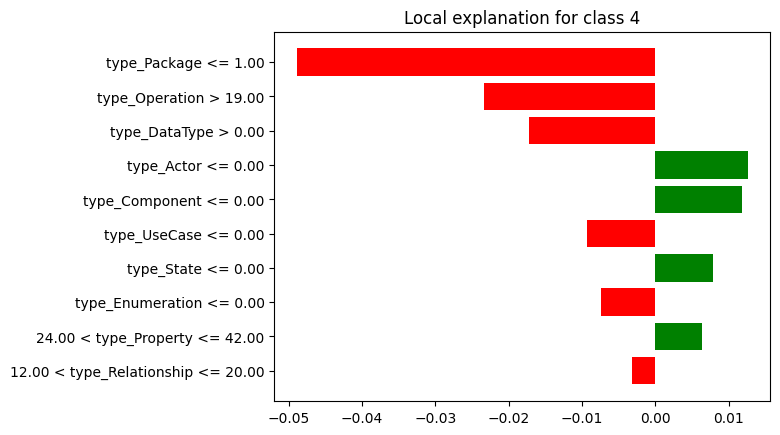

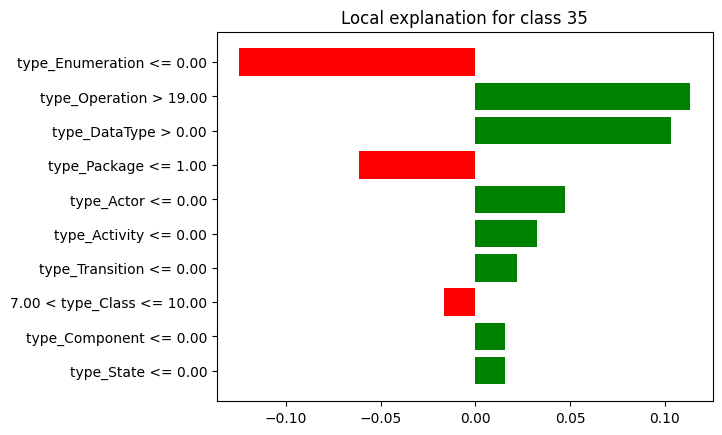

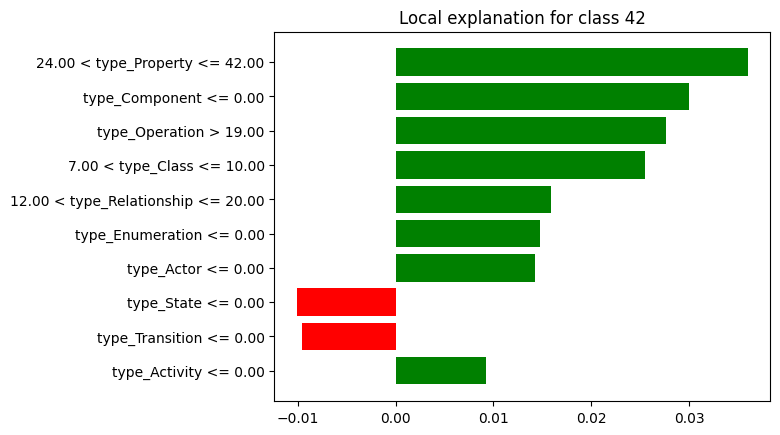

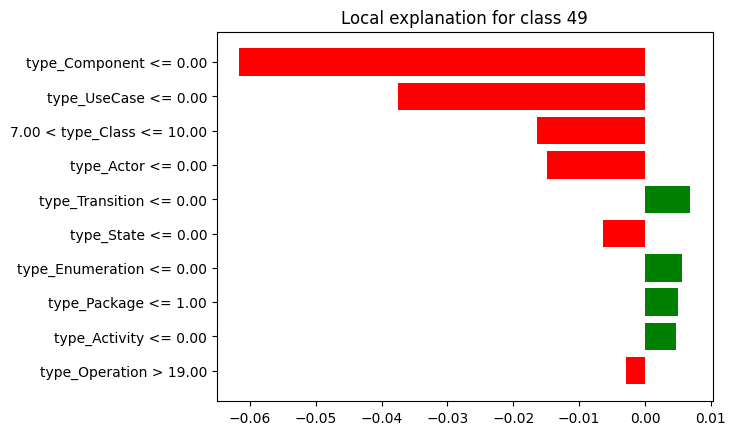

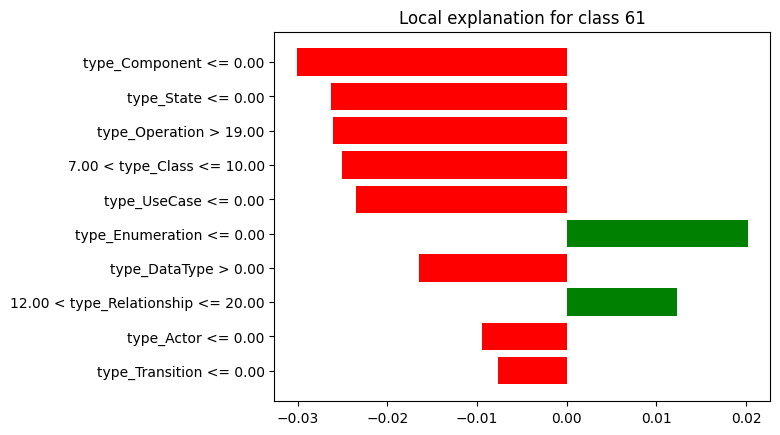

In [ ]:
for i in class_index:
  rf_exp_results['lime_course'][i].plot()

In [ ]:
breakdown_df_course_ban = breakdown_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_ban = breakdown_df_course_ban.drop(index=[0, 14])
breakdown_df_course_ban['sign'] = breakdown_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_ban = breakdown_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_ban = shap_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_ban = shap_df_course_ban.tail(13)
shap_df_course_ban['sign'] = shap_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_ban = shap_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_ban["Feature"] = lime_df_course_ban["variable"].str.split(" ").str[0]
lime_df_course_ban["Sign"] = lime_df_course_ban["effect"].apply(evaluate_value)
lime_df_course_ban = lime_df_course_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_ban = lime_df_course_ban.drop(columns=['variable'])


breakdown_df_course_ban['Ranking'] = breakdown_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_ban = breakdown_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_ban['Ranking'] = shap_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_ban = shap_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_ban['Ranking'] = lime_df_course_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_ban = lime_df_course_ban.head(10)
lime_df_course_ban = lime_df_course_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_ban = breakdown_df_course_ban.drop(columns=['contribution'])
shap_df_course_ban = shap_df_course_ban.drop(columns=['contribution'])
lime_df_course_ban = lime_df_course_ban.drop(columns=['effect'])


breakdown_df_course_ban = breakdown_df_course_ban.head(10)
breakdown_df_course_ban = breakdown_df_course_ban.reset_index(drop=True)

shap_df_course_ban= shap_df_course_ban.head(10)
shap_df_course_ban = shap_df_course_ban.reset_index(drop=True)

lime_df_course_ban = lime_df_course_ban.reset_index(drop=True)
lime_df_course_ban.at[9, "Feature"] = "type_Relationship"
lime_df_course_ban.at[8, "Feature"] = "type_Property"

print(breakdown_df_course_ban)
print("---------------------------------")
print(shap_df_course_ban)
print("---------------------------------")
print(lime_df_course_ban)

             Feature  Ranking      Sign
0      type_DataType        1  Negative
1  type_Relationship        2  Negative
2       type_UseCase        3  Negative
3   type_Enumeration        4  Negative
4     type_Component        5  Positive
5         type_Actor        6  Positive
6         type_Class        7  Negative
7     type_Operation        8  Negative
8      type_Property        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_DataType        2  Negative
2     type_Operation        3  Negative
3   type_Enumeration        4  Negative
4       type_Package        5  Negative
5         type_Class        6  Negative
6       type_UseCase        7  Negative
7         type_Actor        8  Positive
8     type_Component        9  Positive
9      type_Property       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_course_ban['Feature'])
shap_features = list(shap_df_course_ban['Feature'])
lime_features = list(lime_df_course_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_ban['Feature'] = list(all_features)
df_final_cou_ban= df_final_cou_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_ban['Feature']:

    breakdown_row = breakdown_df_course_ban[breakdown_df_course_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_ban[shap_df_course_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_ban[lime_df_course_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_ban = df_final_cou_ban.loc[casos_validos]
df_final_cou_ban.set_index('Feature', inplace=True)
df_final_cou_ban

['type_DataType', 'type_Relationship', 'type_UseCase', 'type_Enumeration', 'type_Component', 'type_Actor', 'type_Class', 'type_Operation', 'type_Property', 'type_Activity']
['type_Relationship', 'type_DataType', 'type_Operation', 'type_Enumeration', 'type_Package', 'type_Class', 'type_UseCase', 'type_Actor', 'type_Component', 'type_Property']
['type_Package', 'type_Operation', 'type_DataType', 'type_Actor', 'type_Component', 'type_UseCase', 'type_State', 'type_Enumeration', 'type_Property', 'type_Relationship']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_DataType             1  Negative       2  Negative       3  Negative
type_Relationship         2  Negative       1  Negative      10  Negative
type_UseCase              3  Negative       7  Negative       6  Negative
type_Enumeration          4  Negative       4  Negative       8  Negative
type_Component            5  Positive       9  Positive       5  Positive
type_Actor                6  Positive       8  Positive       4  Positive
type_Class                7  Negative       6  Negative       -         -
type_Operation            8  Negative       3  Negative       2  Negative
type_Property             9  Negative      10  Positive       9  Positive
type_Activity            10  Positive       -         -       -         -
type_Package              -         -       5  Negative       1  Negative
type_State                -         -       -         -       7  Positive

In [ ]:
breakdown_df_course_vid = breakdown_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_vid = breakdown_df_course_vid.drop(index=[0, 14])
breakdown_df_course_vid['sign'] = breakdown_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_vid = breakdown_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_vid = shap_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_vid = shap_df_course_vid.tail(13)
shap_df_course_vid['sign'] = shap_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_vid = shap_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_vid["Feature"] = lime_df_course_vid["variable"].str.split(" ").str[0]
lime_df_course_vid["Sign"] = lime_df_course_vid["effect"].apply(evaluate_value)
lime_df_course_vid = lime_df_course_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_vid = lime_df_course_vid.drop(columns=['variable'])


breakdown_df_course_vid['Ranking'] = breakdown_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_vid = breakdown_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_vid['Ranking'] = shap_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_vid = shap_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_vid['Ranking'] = lime_df_course_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_vid = lime_df_course_vid.head(10)
lime_df_course_vid = lime_df_course_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_vid = breakdown_df_course_vid.drop(columns=['contribution'])
shap_df_course_vid = shap_df_course_vid.drop(columns=['contribution'])
lime_df_course_vid = lime_df_course_vid.drop(columns=['effect'])


breakdown_df_course_vid = breakdown_df_course_vid.head(10)
breakdown_df_course_vid = breakdown_df_course_vid.reset_index(drop=True)

shap_df_course_vid= shap_df_course_vid.head(10)
shap_df_course_vid = shap_df_course_vid.reset_index(drop=True)

lime_df_course_vid = lime_df_course_vid.reset_index(drop=True)
lime_df_course_vid.at[7, "Feature"] = "type_Class"

print(breakdown_df_course_vid)
print("---------------------------------")
print(shap_df_course_vid)
print("---------------------------------")
print(lime_df_course_vid)

             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_DataType        2  Positive
2     type_Operation        3  Positive
3   type_Enumeration        4  Negative
4         type_Class        5  Negative
5         type_Actor        6  Positive
6       type_Package        7  Negative
7       type_UseCase        8  Negative
8      type_Property        9  Negative
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_DataType        1  Positive
1  type_Relationship        2  Negative
2         type_Class        3  Negative
3   type_Enumeration        4  Negative
4      type_Property        5  Negative
5       type_Package        6  Negative
6     type_Operation        7  Positive
7       type_UseCase        8  Negative
8      type_Activity        9  Positive
9         type_Actor       10  Positive
---------------------------------
            Feature  Ranking      Sign
0  type_Enume

In [ ]:

breakdown_features = list(breakdown_df_course_vid['Feature'])
shap_features = list(shap_df_course_vid['Feature'])
lime_features = list(lime_df_course_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_vid['Feature'] = list(all_features)
df_final_cou_vid= df_final_cou_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_vid['Feature']:

    breakdown_row = breakdown_df_course_vid[breakdown_df_course_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_vid[shap_df_course_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_vid[lime_df_course_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_vid = df_final_cou_vid.loc[casos_validos]
df_final_cou_vid.set_index('Feature', inplace=True)
df_final_cou_vid

['type_Relationship', 'type_DataType', 'type_Operation', 'type_Enumeration', 'type_Class', 'type_Actor', 'type_Package', 'type_UseCase', 'type_Property', 'type_Activity']
['type_DataType', 'type_Relationship', 'type_Class', 'type_Enumeration', 'type_Property', 'type_Package', 'type_Operation', 'type_UseCase', 'type_Activity', 'type_Actor']
['type_Enumeration', 'type_Operation', 'type_DataType', 'type_Package', 'type_Actor', 'type_Activity', 'type_Transition', 'type_Class', 'type_Component', 'type_State']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       2  Negative       -         -
type_DataType             2  Positive       1  Positive       3  Positive
type_Operation            3  Positive       7  Positive       2  Positive
type_Enumeration          4  Negative       4  Negative       1  Negative
type_Class                5  Negative       3  Negative       8  Negative
type_Actor                6  Positive      10  Positive       5  Positive
type_Package              7  Negative       6  Negative       4  Negative
type_UseCase              8  Negative       8  Negative       -         -
type_Property             9  Negative       5  Negative       -         -
type_Activity            10  Negative       9  Positive       6  Positive
type_State                -         -       -         -      10  Positive
type_Transition           -         -       -         -       7  Positive
type_Component            -         -       -         -       9  Positive

In [ ]:
breakdown_df_course_cou = breakdown_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_cou = breakdown_df_course_cou.drop(index=[0, 14])
breakdown_df_course_cou['sign'] = breakdown_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_cou = breakdown_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_cou = shap_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_cou = shap_df_course_cou.tail(13)
shap_df_course_cou['sign'] = shap_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_cou = shap_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_cou["Feature"] = lime_df_course_cou["variable"].str.split(" ").str[0]
lime_df_course_cou["Sign"] = lime_df_course_cou["effect"].apply(evaluate_value)
lime_df_course_cou = lime_df_course_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_cou = lime_df_course_cou.drop(columns=['variable'])


breakdown_df_course_cou['Ranking'] = breakdown_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_cou = breakdown_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_cou['Ranking'] = shap_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_cou = shap_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_cou['Ranking'] = lime_df_course_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_cou = lime_df_course_cou.head(10)
lime_df_course_cou = lime_df_course_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_cou = breakdown_df_course_cou.drop(columns=['contribution'])
shap_df_course_cou = shap_df_course_cou.drop(columns=['contribution'])
lime_df_course_cou = lime_df_course_cou.drop(columns=['effect'])


breakdown_df_course_cou = breakdown_df_course_cou.head(10)
breakdown_df_course_cou = breakdown_df_course_cou.reset_index(drop=True)

shap_df_course_cou= shap_df_course_cou.head(10)
shap_df_course_cou = shap_df_course_cou.reset_index(drop=True)

lime_df_course_cou = lime_df_course_cou.reset_index(drop=True)
lime_df_course_cou.at[0, "Feature"] = "type_Property"
lime_df_course_cou.at[3, "Feature"] = "type_Class"
lime_df_course_cou.at[4, "Feature"] = "type_Relationship"

print(breakdown_df_course_cou)
print("---------------------------------")
print(shap_df_course_cou)
print("---------------------------------")
print(lime_df_course_cou)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1      type_DataType        2  Positive
2       type_UseCase        3  Positive
3      type_Property        4  Positive
4         type_Actor        5  Positive
5  type_Relationship        6  Positive
6     type_Component        7  Positive
7   type_Enumeration        8  Positive
8         type_Class        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1  type_Relationship        2  Positive
2      type_Property        3  Positive
3         type_Class        4  Positive
4      type_DataType        5  Positive
5         type_Actor        6  Positive
6      type_Activity        7  Positive
7       type_UseCase        8  Positive
8   type_Enumeration        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_course_cou['Feature'])
shap_features = list(shap_df_course_cou['Feature'])
lime_features = list(lime_df_course_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_cou['Feature'] = list(all_features)
df_final_cou_cou= df_final_cou_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_cou['Feature']:

    breakdown_row = breakdown_df_course_cou[breakdown_df_course_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_cou[shap_df_course_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_cou[lime_df_course_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_cou = df_final_cou_cou.loc[casos_validos]
df_final_cou_cou.set_index('Feature', inplace=True)
df_final_cou_cou

['type_Operation', 'type_DataType', 'type_UseCase', 'type_Property', 'type_Actor', 'type_Relationship', 'type_Component', 'type_Enumeration', 'type_Class', 'type_Activity']
['type_Operation', 'type_Relationship', 'type_Property', 'type_Class', 'type_DataType', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Enumeration', 'type_Package']
['type_Property', 'type_Component', 'type_Operation', 'type_Class', 'type_Relationship', 'type_Enumeration', 'type_Actor', 'type_State', 'type_Transition', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       1  Positive       3  Positive
type_DataType             2  Positive       5  Positive       -         -
type_UseCase              3  Positive       8  Positive       -         -
type_Property             4  Positive       3  Positive       1  Positive
type_Actor                5  Positive       6  Positive       7  Positive
type_Relationship         6  Positive       2  Positive       5  Positive
type_Component            7  Positive       -         -       2  Positive
type_Enumeration          8  Positive       9  Positive       6  Positive
type_Class                9  Positive       4  Positive       4  Positive
type_Activity            10  Positive       7  Positive      10  Positive
type_Package              -         -      10  Positive       -         -
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -       9  Negative

In [ ]:
breakdown_df_course_emp = breakdown_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_emp = breakdown_df_course_emp.drop(index=[0, 14])
breakdown_df_course_emp['sign'] = breakdown_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_emp = breakdown_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_emp = shap_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_emp = shap_df_course_emp.tail(13)
shap_df_course_emp['sign'] = shap_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_emp = shap_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_emp["Feature"] = lime_df_course_emp["variable"].str.split(" ").str[0]
lime_df_course_emp["Sign"] = lime_df_course_emp["effect"].apply(evaluate_value)
lime_df_course_emp = lime_df_course_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_emp = lime_df_course_emp.drop(columns=['variable'])


breakdown_df_course_emp['Ranking'] = breakdown_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_emp = breakdown_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_emp['Ranking'] = shap_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_emp = shap_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_emp['Ranking'] = lime_df_course_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_emp = lime_df_course_emp.head(10)
lime_df_course_emp = lime_df_course_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_emp = breakdown_df_course_emp.drop(columns=['contribution'])
shap_df_course_emp = shap_df_course_emp.drop(columns=['contribution'])
lime_df_course_emp = lime_df_course_emp.drop(columns=['effect'])


breakdown_df_course_emp = breakdown_df_course_emp.head(10)
breakdown_df_course_emp = breakdown_df_course_emp.reset_index(drop=True)

shap_df_course_emp= shap_df_course_emp.head(10)
shap_df_course_emp = shap_df_course_emp.reset_index(drop=True)

lime_df_course_emp = lime_df_course_emp.reset_index(drop=True)
lime_df_course_emp.at[2, "Feature"] = "type_Class"

print(breakdown_df_course_emp)
print("---------------------------------")
print(shap_df_course_emp)
print("---------------------------------")
print(lime_df_course_emp)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1     type_Component        2  Negative
2         type_Actor        3  Negative
3       type_UseCase        4  Negative
4  type_Relationship        5  Negative
5      type_Property        6  Negative
6      type_DataType        7  Negative
7      type_Activity        8  Positive
8   type_Enumeration        9  Positive
9         type_Class       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Component        1  Negative
1         type_Actor        2  Negative
2      type_DataType        3  Negative
3     type_Operation        4  Positive
4  type_Relationship        5  Negative
5       type_UseCase        6  Negative
6         type_Class        7  Negative
7      type_Property        8  Negative
8      type_Activity        9  Positive
9       type_Package       10  Positive
---------------------------------
            Feature  Ranking      Sign
0    type_Com

In [ ]:

breakdown_features = list(breakdown_df_course_emp['Feature'])
shap_features = list(shap_df_course_emp['Feature'])
lime_features = list(lime_df_course_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_emp['Feature'] = list(all_features)
df_final_cou_emp= df_final_cou_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_emp['Feature']:

    breakdown_row = breakdown_df_course_emp[breakdown_df_course_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_emp[shap_df_course_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_emp[lime_df_course_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_emp = df_final_cou_emp.loc[casos_validos]
df_final_cou_emp.set_index('Feature', inplace=True)
df_final_cou_emp

['type_Operation', 'type_Component', 'type_Actor', 'type_UseCase', 'type_Relationship', 'type_Property', 'type_DataType', 'type_Activity', 'type_Enumeration', 'type_Class']
['type_Component', 'type_Actor', 'type_DataType', 'type_Operation', 'type_Relationship', 'type_UseCase', 'type_Class', 'type_Property', 'type_Activity', 'type_Package']
['type_Component', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Transition', 'type_State', 'type_Enumeration', 'type_Package', 'type_Activity', 'type_Operation']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       4  Positive      10  Negative
type_Component            2  Negative       1  Negative       1  Negative
type_Actor                3  Negative       2  Negative       4  Negative
type_UseCase              4  Negative       6  Negative       2  Negative
type_Relationship         5  Negative       5  Negative       -         -
type_Property             6  Negative       8  Negative       -         -
type_DataType             7  Negative       3  Negative       -         -
type_Activity             8  Positive       9  Positive       9  Positive
type_Enumeration          9  Positive       -         -       7  Positive
type_Class               10  Negative       7  Negative       3  Negative
type_Package              -         -      10  Positive       8  Positive
type_State                -         -       -         -       6  Negative
type_Transition           -         -       -         -       5  Positive

In [ ]:
breakdown_df_course_lib = breakdown_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_lib = breakdown_df_course_lib.drop(index=[0, 14])
breakdown_df_course_lib['sign'] = breakdown_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_lib = breakdown_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_lib = shap_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_lib = shap_df_course_lib.tail(13)
shap_df_course_lib['sign'] = shap_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_lib = shap_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_lib["Feature"] = lime_df_course_lib["variable"].str.split(" ").str[0]
lime_df_course_lib["Sign"] = lime_df_course_lib["effect"].apply(evaluate_value)
lime_df_course_lib = lime_df_course_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_lib = lime_df_course_lib.drop(columns=['variable'])


breakdown_df_course_lib['Ranking'] = breakdown_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_lib = breakdown_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_lib['Ranking'] = shap_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_lib = shap_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_lib['Ranking'] = lime_df_course_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_lib = lime_df_course_lib.head(10)
lime_df_course_lib = lime_df_course_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_lib = breakdown_df_course_lib.drop(columns=['contribution'])
shap_df_course_lib = shap_df_course_lib.drop(columns=['contribution'])
lime_df_course_lib = lime_df_course_lib.drop(columns=['effect'])


breakdown_df_course_lib = breakdown_df_course_lib.head(10)
breakdown_df_course_lib = breakdown_df_course_lib.reset_index(drop=True)

shap_df_course_lib= shap_df_course_lib.head(10)
shap_df_course_lib = shap_df_course_lib.reset_index(drop=True)

lime_df_course_lib = lime_df_course_lib.reset_index(drop=True)
lime_df_course_lib.at[3, "Feature"] = "type_Class"
lime_df_course_lib.at[7, "Feature"] = "type_Relationship"

print(breakdown_df_course_lib)
print("---------------------------------")
print(shap_df_course_lib)
print("---------------------------------")
print(lime_df_course_lib)

             Feature  Ranking      Sign
0      type_DataType        1  Negative
1     type_Component        2  Negative
2     type_Operation        3  Negative
3  type_Relationship        4  Positive
4         type_Actor        5  Negative
5      type_Property        6  Positive
6         type_Class        7  Negative
7      type_Activity        8  Negative
8   type_Enumeration        9  Positive
9       type_UseCase       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1         type_Class        2  Negative
2     type_Component        3  Negative
3     type_Operation        4  Negative
4      type_DataType        5  Negative
5  type_Relationship        6  Positive
6         type_Actor        7  Negative
7      type_Activity        8  Negative
8   type_Enumeration        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_course_lib['Feature'])
shap_features = list(shap_df_course_lib['Feature'])
lime_features = list(lime_df_course_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_lib['Feature'] = list(all_features)
df_final_cou_lib= df_final_cou_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_lib['Feature']:

    breakdown_row = breakdown_df_course_lib[breakdown_df_course_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_lib[shap_df_course_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_lib[lime_df_course_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_lib = df_final_cou_lib.loc[casos_validos]
df_final_cou_lib.set_index('Feature', inplace=True)
df_final_cou_lib

['type_DataType', 'type_Component', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Property', 'type_Class', 'type_Activity', 'type_Enumeration', 'type_UseCase']
['type_UseCase', 'type_Class', 'type_Component', 'type_Operation', 'type_DataType', 'type_Relationship', 'type_Actor', 'type_Activity', 'type_Enumeration', 'type_Package']
['type_Component', 'type_State', 'type_Operation', 'type_Class', 'type_UseCase', 'type_Enumeration', 'type_DataType', 'type_Relationship', 'type_Actor', 'type_Transition']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_DataType             1  Negative       5  Negative       7  Negative
type_Component            2  Negative       3  Negative       1  Negative
type_Operation            3  Negative       4  Negative       3  Negative
type_Relationship         4  Positive       6  Positive       8  Positive
type_Actor                5  Negative       7  Negative       9  Negative
type_Property             6  Positive       -         -       -         -
type_Class                7  Negative       2  Negative       4  Negative
type_Activity             8  Negative       8  Negative       -         -
type_Enumeration          9  Positive       9  Positive       6  Positive
type_UseCase             10  Negative       1  Negative       5  Negative
type_Package              -         -      10  Positive       -         -
type_State                -         -       -         -       2  Negative
type_Transition           -         -       -         -      10  Negative

### **Results Course:**

In [ ]:
df_topfeatures_cou_ban = top5_features(df_final_cou_ban, 'Course - Class: Bank')
df_topfeatures_cou_vid = top5_features(df_final_cou_vid, 'Course - Class: ComputerVideogames')
df_topfeatures_cou_cou = top5_features(df_final_cou_cou, 'Course - Class: Course')
df_topfeatures_cou_emp = top5_features(df_final_cou_emp, 'Course - Class: Employee')
df_topfeatures_cou_lib = top5_features(df_final_cou_lib, 'Course - Class: Library')

df_topfeatures_course = pd.concat([df_topfeatures_cou_ban, df_topfeatures_cou_vid, df_topfeatures_cou_cou, df_topfeatures_cou_emp, df_topfeatures_cou_lib])
df_topfeatures_course

TOP5 Breakdown  \
Course - Class: Bank                type_Component, type_UseCase, type_DataType, t...   
Course - Class: ComputerVideogames  type_Class, type_DataType, type_Relationship, ...   
Course - Class: Course              type_Actor, type_DataType, type_UseCase, type_...   
Course - Class: Employee            type_Component, type_Actor, type_UseCase, type...   
Course - Class: Library             type_Component, type_Actor, type_DataType, typ...   

                                                                            TOP5 Shap  \
Course - Class: Bank                type_Package, type_DataType, type_Relationship...   
Course - Class: ComputerVideogames  type_Class, type_DataType, type_Property, type...   
Course - Class: Course              type_Class, type_DataType, type_Property, type...   
Course - Class: Employee            type_Component, type_Actor, type_DataType, typ...   
Course - Class: Library             type_Component, type_Class, type_DataType, typ...   

                                                                            TOP5 Lime  \
Course - Class: Bank                type_Component, type_Package, type_Actor, type...   
Course - Class: ComputerVideogames  type_Package, type_Actor, type_DataType, type_...   
Course - Class: Course              type_Component, type_Class, type_Property, typ...   
Course - Class: Employee            type_Component, type_Actor, type_Class, type_U...   
Course - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class: Bank                           0.6             0.4        0.6  
Course - Class: ComputerVideogames             0.8             0.6        0.4  
Course - Class: Course                         0.6             0.4        0.8  
Course - Class: Employee                       0.8             0.6        0.4  
Course - Class: Library                        0.6             0.4        0.8

In [ ]:
df_topfeatures_cou_ban_rank = top5_rank(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank = top5_rank(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank = top5_rank(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank = top5_rank(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank = top5_rank(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_course = pd.concat([df_topfeatures_cou_ban_rank, df_topfeatures_cou_vid_rank, df_topfeatures_cou_cou_rank, df_topfeatures_cou_emp_rank, df_topfeatures_cou_lib_rank])
df_topfeatures_rank_course

TOP5 Breakdown  \
Course - Class Bank                1:type_DataType, 2:type_Relationship, 3:type_U...   
Course - Class ComputerVideogames  1:type_Relationship, 2:type_DataType, 3:type_O...   
Course - Class Course              1:type_Operation, 2:type_DataType, 3:type_UseC...   
Course - Class Employee            1:type_Operation, 2:type_Component, 3:type_Act...   
Course - Class Library             1:type_DataType, 2:type_Component, 3:type_Oper...   

                                                                           TOP5 Shap  \
Course - Class Bank                2:type_DataType, 1:type_Relationship, 4:type_E...   
Course - Class ComputerVideogames  2:type_Relationship, 1:type_DataType, 4:type_E...   
Course - Class Course              1:type_Operation, 5:type_DataType, 3:type_Prop...   
Course - Class Employee            4:type_Operation, 1:type_Component, 2:type_Act...   
Course - Class Library             5:type_DataType, 3:type_Component, 4:type_Oper...   

                                                                           TOP5 Lime  \
Course - Class Bank                3:type_DataType, 5:type_Component, 4:type_Acto...   
Course - Class ComputerVideogames  3:type_DataType, 2:type_Operation, 1:type_Enum...   
Course - Class Course              3:type_Operation, 1:type_Property, 5:type_Rela...   
Course - Class Employee            1:type_Component, 4:type_Actor, 2:type_UseCase...   
Course - Class Library             1:type_Component, 3:type_Operation, 4:type_Cla...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.2             0.2        0.0  
Course - Class ComputerVideogames             0.2             0.0        0.0  
Course - Class Course                         0.2             0.0        0.2  
Course - Class Employee                       0.2             0.0        0.2  
Course - Class Library                        0.0             0.2        0.0

In [ ]:
df_topfeatures_cou_ban_sign = top5_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_sign = top5_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_sign = top5_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_sign = top5_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_sign = top5_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_sign_course = pd.concat([df_topfeatures_cou_ban_sign, df_topfeatures_cou_vid_sign, df_topfeatures_cou_cou_sign, df_topfeatures_cou_emp_sign, df_topfeatures_cou_lib_sign])
df_topfeatures_sign_course

TOP5 Breakdown  \
Course - Class Bank                type_DataType:Negative, type_Relationship:Nega...   
Course - Class ComputerVideogames  type_Relationship:Negative, type_DataType:Posi...   
Course - Class Course              type_Operation:Positive, type_DataType:Positiv...   
Course - Class Employee            type_Operation:Positive, type_Component:Negati...   
Course - Class Library             type_DataType:Negative, type_Component:Negativ...   

                                                                           TOP5 Shap  \
Course - Class Bank                type_DataType:Negative, type_Relationship:Nega...   
Course - Class ComputerVideogames  type_Relationship:Negative, type_DataType:Posi...   
Course - Class Course              type_Operation:Positive, type_DataType:Positiv...   
Course - Class Employee            type_Operation:Positive, type_Component:Negati...   
Course - Class Library             type_DataType:Negative, type_Component:Negativ...   

                                                                           TOP5 Lime  \
Course - Class Bank                type_DataType:Negative, type_Component:Positiv...   
Course - Class ComputerVideogames  type_DataType:Positive, type_Operation:Positiv...   
Course - Class Course              type_Operation:Positive, type_Property:Positiv...   
Course - Class Employee            type_Component:Negative, type_Actor:Negative, ...   
Course - Class Library             type_Component:Negative, type_Operation:Negati...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.6             0.4        0.6  
Course - Class ComputerVideogames             0.8             0.6        0.4  
Course - Class Course                         0.6             0.4        0.8  
Course - Class Employee                       0.8             0.6        0.4  
Course - Class Library                        0.6             0.4        0.8

In [ ]:
df_topfeatures_cou_ban_rank_sign = top5_rank_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank_sign = top5_rank_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank_sign = top5_rank_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank_sign = top5_rank_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank_sign = top5_rank_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_sign_course = pd.concat([df_topfeatures_cou_ban_rank_sign, df_topfeatures_cou_vid_rank_sign, df_topfeatures_cou_cou_rank_sign, df_topfeatures_cou_emp_rank_sign, df_topfeatures_cou_lib_rank_sign])
df_topfeatures_rank_sign_course

TOP5 Breakdown  \
Course - Class Bank                1:type_DataType:Negative, 2:type_Relationship:...   
Course - Class ComputerVideogames  1:type_Relationship:Negative, 2:type_DataType:...   
Course - Class Course              1:type_Operation:Positive, 2:type_DataType:Pos...   
Course - Class Employee            1:type_Operation:Positive, 2:type_Component:Ne...   
Course - Class Library             1:type_DataType:Negative, 2:type_Component:Neg...   

                                                                           TOP5 Shap  \
Course - Class Bank                2:type_DataType:Negative, 1:type_Relationship:...   
Course - Class ComputerVideogames  2:type_Relationship:Negative, 1:type_DataType:...   
Course - Class Course              1:type_Operation:Positive, 5:type_DataType:Pos...   
Course - Class Employee            4:type_Operation:Positive, 1:type_Component:Ne...   
Course - Class Library             5:type_DataType:Negative, 3:type_Component:Neg...   

                                                                           TOP5 Lime  \
Course - Class Bank                3:type_DataType:Negative, 5:type_Component:Pos...   
Course - Class ComputerVideogames  3:type_DataType:Positive, 2:type_Operation:Pos...   
Course - Class Course              3:type_Operation:Positive, 1:type_Property:Pos...   
Course - Class Employee            1:type_Component:Negative, 4:type_Actor:Negati...   
Course - Class Library             1:type_Component:Negative, 3:type_Operation:Ne...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.2             0.2        0.0  
Course - Class ComputerVideogames             0.2             0.0        0.0  
Course - Class Course                         0.2             0.0        0.2  
Course - Class Employee                       0.2             0.0        0.2  
Course - Class Library                        0.0             0.2        0.0

### **Library:**

In [ ]:
breakdown_df_library_ban = rf_exp_results['breakdown_library'][0].result
shap_df_library_ban = rf_exp_results['shap_library'][0].result
lime_df_library_ban = rf_exp_results['lime_library'][0].result

In [ ]:
breakdown_df_library_vid = rf_exp_results['breakdown_library'][1].result
shap_df_library_vid = rf_exp_results['shap_library'][1].result
lime_df_library_vid = rf_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_cou = rf_exp_results['breakdown_library'][3].result
shap_df_library_cou = rf_exp_results['shap_library'][3].result
lime_df_library_cou = rf_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_emp = rf_exp_results['breakdown_library'][4].result
shap_df_library_emp = rf_exp_results['shap_library'][4].result
lime_df_library_emp = rf_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_lib = rf_exp_results['breakdown_library'][6].result
shap_df_library_lib = rf_exp_results['shap_library'][6].result
lime_df_library_lib = rf_exp_results['lime_library'][6].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

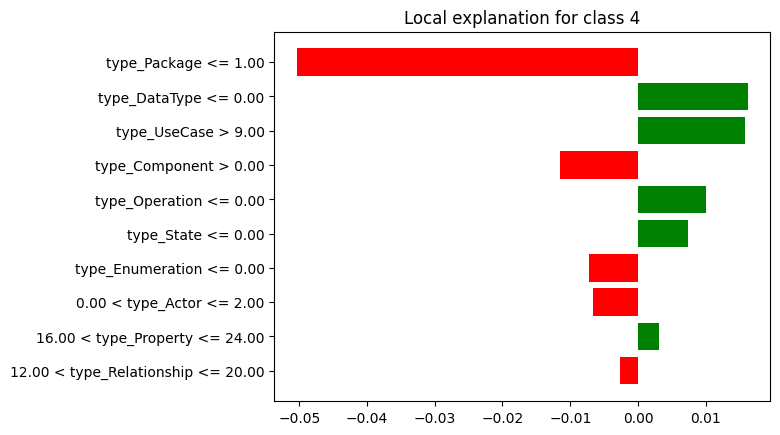

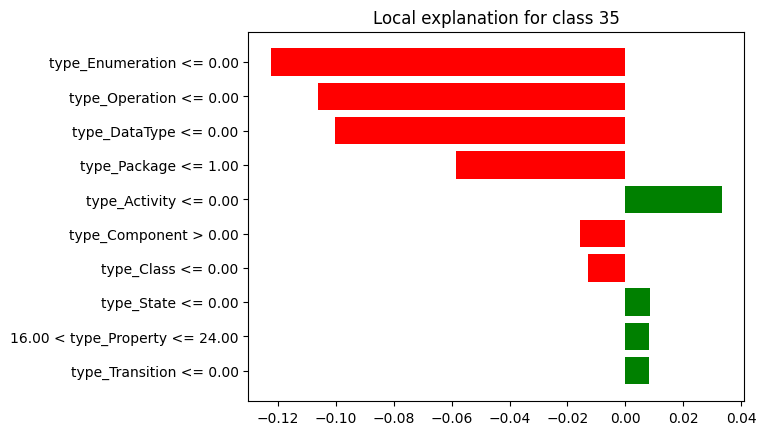

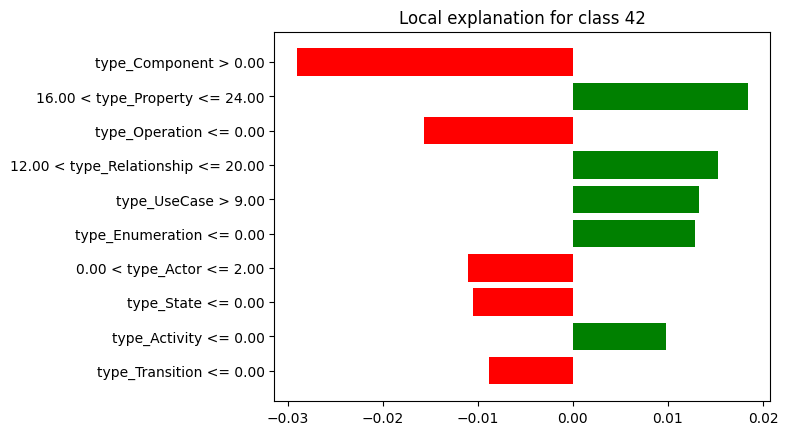

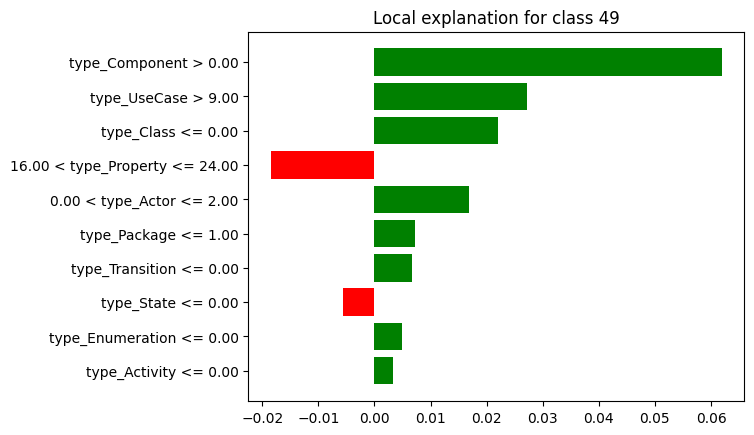

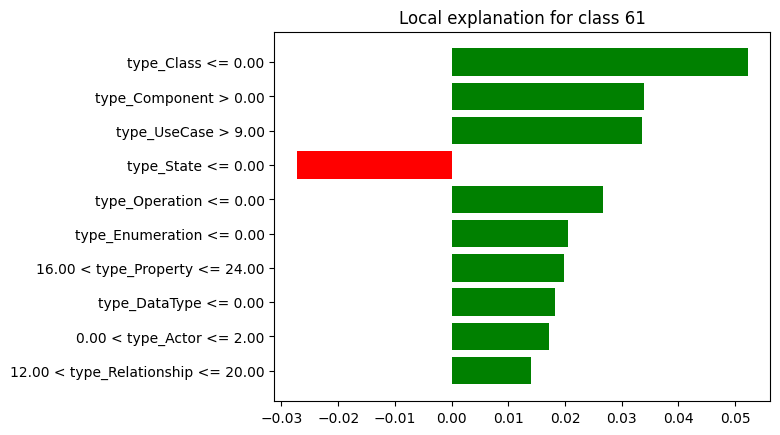

In [ ]:
for i in class_index:
  rf_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_ban = breakdown_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_ban = breakdown_df_library_ban.drop(index=[0, 14])
breakdown_df_library_ban['sign'] = breakdown_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_ban = breakdown_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_ban = shap_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_ban = shap_df_library_ban.tail(13)
shap_df_library_ban['sign'] = shap_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_ban = shap_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_ban["Feature"] = lime_df_library_ban["variable"].str.split(" ").str[0]
lime_df_library_ban["Sign"] = lime_df_library_ban["effect"].apply(evaluate_value)
lime_df_library_ban = lime_df_library_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_ban = lime_df_library_ban.drop(columns=['variable'])


breakdown_df_library_ban['Ranking'] = breakdown_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_ban = breakdown_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_ban['Ranking'] = shap_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_ban = shap_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_ban['Ranking'] = lime_df_library_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_ban = lime_df_library_ban.head(10)
lime_df_library_ban = lime_df_library_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_ban = breakdown_df_library_ban.drop(columns=['contribution'])
shap_df_library_ban = shap_df_library_ban.drop(columns=['contribution'])
lime_df_library_ban = lime_df_library_ban.drop(columns=['effect'])


breakdown_df_library_ban = breakdown_df_library_ban.head(10)
breakdown_df_library_ban = breakdown_df_library_ban.reset_index(drop=True)

shap_df_library_ban= shap_df_library_ban.head(10)
shap_df_library_ban = shap_df_library_ban.reset_index(drop=True)

lime_df_library_ban = lime_df_library_ban.reset_index(drop=True)
lime_df_library_ban.at[9, "Feature"] = "type_Relationship"
lime_df_library_ban.at[8, "Feature"] = "type_Property"
lime_df_library_ban.at[7, "Feature"] = "type_Actor"

print(breakdown_df_library_ban)
print("---------------------------------")
print(shap_df_library_ban)
print("---------------------------------")
print(lime_df_library_ban)

             Feature  Ranking      Sign
0         type_Actor        1  Negative
1     type_Component        2  Negative
2  type_Relationship        3  Positive
3         type_Class        4  Negative
4     type_Operation        5  Positive
5      type_DataType        6  Positive
6   type_Enumeration        7  Negative
7      type_Property        8  Positive
8       type_Package        9  Negative
9       type_UseCase       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1     type_Component        2  Negative
2      type_Property        3  Negative
3       type_Package        4  Negative
4       type_UseCase        5  Positive
5   type_Enumeration        6  Negative
6     type_Operation        7  Positive
7      type_DataType        8  Positive
8         type_Class        9  Negative
9  type_Relationship       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_library_ban['Feature'])
shap_features = list(shap_df_library_ban['Feature'])
lime_features = list(lime_df_library_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_ban['Feature'] = list(all_features)
df_final_lib_ban= df_final_lib_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_ban['Feature']:

    breakdown_row = breakdown_df_library_ban[breakdown_df_library_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_ban[shap_df_library_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_ban[lime_df_library_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_ban = df_final_lib_ban.loc[casos_validos]
df_final_lib_ban.set_index('Feature', inplace=True)
df_final_lib_ban

['type_Actor', 'type_Component', 'type_Relationship', 'type_Class', 'type_Operation', 'type_DataType', 'type_Enumeration', 'type_Property', 'type_Package', 'type_UseCase']
['type_Actor', 'type_Component', 'type_Property', 'type_Package', 'type_UseCase', 'type_Enumeration', 'type_Operation', 'type_DataType', 'type_Class', 'type_Relationship']
['type_Package', 'type_DataType', 'type_UseCase', 'type_Component', 'type_Operation', 'type_State', 'type_Enumeration', 'type_Actor', 'type_Property', 'type_Relationship']
['type_Enumeration', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       1  Negative       8  Negative
type_Component            2  Negative       2  Negative       4  Negative
type_Relationship         3  Positive      10  Negative      10  Negative
type_Class                4  Negative       9  Negative       -         -
type_Operation            5  Positive       7  Positive       5  Positive
type_DataType             6  Positive       8  Positive       2  Positive
type_Enumeration          7  Negative       6  Negative       7  Negative
type_Property             8  Positive       3  Negative       9  Positive
type_Package              9  Negative       4  Negative       1  Negative
type_UseCase             10  Positive       5  Positive       3  Positive
type_State                -         -       -         -       6  Positive

In [ ]:
breakdown_df_library_vid = breakdown_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_vid = breakdown_df_library_vid.drop(index=[0, 14])
breakdown_df_library_vid['sign'] = breakdown_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_vid = breakdown_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_vid = shap_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_vid = shap_df_library_vid.tail(13)
shap_df_library_vid['sign'] = shap_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_vid = shap_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_vid["Feature"] = lime_df_library_vid["variable"].str.split(" ").str[0]
lime_df_library_vid["Sign"] = lime_df_library_vid["effect"].apply(evaluate_value)
lime_df_library_vid = lime_df_library_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_vid = lime_df_library_vid.drop(columns=['variable'])


breakdown_df_library_vid['Ranking'] = breakdown_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_vid = breakdown_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_vid['Ranking'] = shap_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_vid = shap_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_vid['Ranking'] = lime_df_library_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_vid = lime_df_library_vid.head(10)
lime_df_library_vid = lime_df_library_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_vid = breakdown_df_library_vid.drop(columns=['contribution'])
shap_df_library_vid = shap_df_library_vid.drop(columns=['contribution'])
lime_df_library_vid = lime_df_library_vid.drop(columns=['effect'])


breakdown_df_library_vid = breakdown_df_library_vid.head(10)
breakdown_df_library_vid = breakdown_df_library_vid.reset_index(drop=True)

shap_df_library_vid= shap_df_library_vid.head(10)
shap_df_library_vid = shap_df_library_vid.reset_index(drop=True)

lime_df_library_vid = lime_df_library_vid.reset_index(drop=True)
lime_df_library_vid.at[8, "Feature"] = "type_Property"

print(breakdown_df_library_vid)
print("---------------------------------")
print(shap_df_library_vid)
print("---------------------------------")
print(lime_df_library_vid)

             Feature  Ranking      Sign
0         type_Class        1  Positive
1     type_Component        2  Negative
2         type_Actor        3  Negative
3     type_Operation        4  Negative
4      type_Property        5  Positive
5  type_Relationship        6  Negative
6   type_Enumeration        7  Negative
7      type_Activity        8  Negative
8      type_DataType        9  Negative
9       type_UseCase       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1     type_Operation        2  Negative
2   type_Enumeration        3  Negative
3      type_DataType        4  Negative
4       type_UseCase        5  Negative
5     type_Component        6  Negative
6      type_Property        7  Positive
7  type_Relationship        8  Positive
8      type_Activity        9  Negative
9         type_Class       10  Negative
---------------------------------
            Feature  Ranking      Sign
0  type_Enume

In [ ]:

breakdown_features = list(breakdown_df_library_vid['Feature'])
shap_features = list(shap_df_library_vid['Feature'])
lime_features = list(lime_df_library_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_vid['Feature'] = list(all_features)
df_final_lib_vid= df_final_lib_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_vid['Feature']:

    breakdown_row = breakdown_df_library_vid[breakdown_df_library_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_vid[shap_df_library_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_vid[lime_df_library_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_vid = df_final_lib_vid.loc[casos_validos]
df_final_lib_vid.set_index('Feature', inplace=True)
df_final_lib_vid

['type_Class', 'type_Component', 'type_Actor', 'type_Operation', 'type_Property', 'type_Relationship', 'type_Enumeration', 'type_Activity', 'type_DataType', 'type_UseCase']
['type_Actor', 'type_Operation', 'type_Enumeration', 'type_DataType', 'type_UseCase', 'type_Component', 'type_Property', 'type_Relationship', 'type_Activity', 'type_Class']
['type_Enumeration', 'type_Operation', 'type_DataType', 'type_Package', 'type_Activity', 'type_Component', 'type_Class', 'type_State', 'type_Property', 'type_Transition']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive      10  Negative       7  Negative
type_Component            2  Negative       6  Negative       6  Negative
type_Actor                3  Negative       1  Negative       -         -
type_Operation            4  Negative       2  Negative       2  Negative
type_Property             5  Positive       7  Positive       9  Positive
type_Relationship         6  Negative       8  Positive       -         -
type_Enumeration          7  Negative       3  Negative       1  Negative
type_Activity             8  Negative       9  Negative       5  Positive
type_DataType             9  Negative       4  Negative       3  Negative
type_UseCase             10  Negative       5  Negative       -         -
type_State                -         -       -         -       8  Positive
type_Transition           -         -       -         -      10  Positive
type_Package              -         -       -         -       4  Negative

In [ ]:
breakdown_df_library_cou = breakdown_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_cou = breakdown_df_library_cou.drop(index=[0, 14])
breakdown_df_library_cou['sign'] = breakdown_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_cou = breakdown_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_cou = shap_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_cou = shap_df_library_cou.tail(13)
shap_df_library_cou['sign'] = shap_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_cou = shap_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_cou["Feature"] = lime_df_library_cou["variable"].str.split(" ").str[0]
lime_df_library_cou["Sign"] = lime_df_library_cou["effect"].apply(evaluate_value)
lime_df_library_cou = lime_df_library_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_cou = lime_df_library_cou.drop(columns=['variable'])


breakdown_df_library_cou['Ranking'] = breakdown_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_cou = breakdown_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_cou['Ranking'] = shap_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_cou = shap_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_cou['Ranking'] = lime_df_library_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_cou = lime_df_library_cou.head(10)
lime_df_library_cou = lime_df_library_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_cou = breakdown_df_library_cou.drop(columns=['contribution'])
shap_df_library_cou = shap_df_library_cou.drop(columns=['contribution'])
lime_df_library_cou = lime_df_library_cou.drop(columns=['effect'])


breakdown_df_library_cou = breakdown_df_library_cou.head(10)
breakdown_df_library_cou = breakdown_df_library_cou.reset_index(drop=True)

shap_df_library_cou= shap_df_library_cou.head(10)
shap_df_library_cou = shap_df_library_cou.reset_index(drop=True)

lime_df_library_cou = lime_df_library_cou.reset_index(drop=True)
lime_df_library_cou.at[1, "Feature"] = "type_Property"
lime_df_library_cou.at[3, "Feature"] = "type_Relationship"
lime_df_library_cou.at[6, "Feature"] = "type_Actor"

print(breakdown_df_library_cou)
print("---------------------------------")
print(shap_df_library_cou)
print("---------------------------------")
print(lime_df_library_cou)

             Feature  Ranking      Sign
0         type_Actor        1  Negative
1       type_UseCase        2  Negative
2  type_Relationship        3  Positive
3         type_Class        4  Positive
4   type_Enumeration        5  Positive
5     type_Operation        6  Negative
6      type_Property        7  Positive
7      type_Activity        8  Positive
8      type_DataType        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Component        1  Negative
1         type_Actor        2  Negative
2       type_UseCase        3  Negative
3  type_Relationship        4  Positive
4       type_Package        5  Negative
5   type_Enumeration        6  Positive
6      type_Property        7  Negative
7      type_DataType        8  Negative
8     type_Operation        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_library_cou['Feature'])
shap_features = list(shap_df_library_cou['Feature'])
lime_features = list(lime_df_library_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_cou['Feature'] = list(all_features)
df_final_lib_cou= df_final_lib_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_cou['Feature']:

    breakdown_row = breakdown_df_library_cou[breakdown_df_library_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_cou[shap_df_library_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_cou[lime_df_library_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_cou = df_final_lib_cou.loc[casos_validos]
df_final_lib_cou.set_index('Feature', inplace=True)
df_final_lib_cou

['type_Actor', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Enumeration', 'type_Operation', 'type_Property', 'type_Activity', 'type_DataType', 'type_Package']
['type_Component', 'type_Actor', 'type_UseCase', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_Property', 'type_DataType', 'type_Operation', 'type_Activity']
['type_Component', 'type_Property', 'type_Operation', 'type_Relationship', 'type_UseCase', 'type_Enumeration', 'type_Actor', 'type_State', 'type_Activity', 'type_Transition']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       2  Negative       7  Negative
type_UseCase              2  Negative       3  Negative       5  Positive
type_Relationship         3  Positive       4  Positive       4  Positive
type_Class                4  Positive       -         -       -         -
type_Enumeration          5  Positive       6  Positive       6  Positive
type_Operation            6  Negative       9  Negative       3  Negative
type_Property             7  Positive       7  Negative       2  Positive
type_Activity             8  Positive      10  Positive       9  Positive
type_DataType             9  Negative       8  Negative       -         -
type_Package             10  Negative       5  Negative       -         -
type_Component            -         -       1  Negative       1  Negative
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -      10  Negative

In [ ]:
breakdown_df_library_emp = breakdown_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_emp = breakdown_df_library_emp.drop(index=[0, 14])
breakdown_df_library_emp['sign'] = breakdown_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_emp = breakdown_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_emp = shap_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_emp = shap_df_library_emp.tail(13)
shap_df_library_emp['sign'] = shap_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_emp = shap_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_emp["Feature"] = lime_df_library_emp["variable"].str.split(" ").str[0]
lime_df_library_emp["Sign"] = lime_df_library_emp["effect"].apply(evaluate_value)
lime_df_library_emp = lime_df_library_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_emp = lime_df_library_emp.drop(columns=['variable'])


breakdown_df_library_emp['Ranking'] = breakdown_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_emp = breakdown_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_emp['Ranking'] = shap_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_emp = shap_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_emp['Ranking'] = lime_df_library_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_emp = lime_df_library_emp.head(10)
lime_df_library_emp = lime_df_library_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_emp = breakdown_df_library_emp.drop(columns=['contribution'])
shap_df_library_emp = shap_df_library_emp.drop(columns=['contribution'])
lime_df_library_emp = lime_df_library_emp.drop(columns=['effect'])


breakdown_df_library_emp = breakdown_df_library_emp.head(10)
breakdown_df_library_emp = breakdown_df_library_emp.reset_index(drop=True)

shap_df_library_emp= shap_df_library_emp.head(10)
shap_df_library_emp = shap_df_library_emp.reset_index(drop=True)

lime_df_library_emp = lime_df_library_emp.reset_index(drop=True)
lime_df_library_emp.at[3, "Feature"] = "type_Property"
lime_df_library_emp.at[4, "Feature"] = "type_Actor"

print(breakdown_df_library_emp)
print("---------------------------------")
print(shap_df_library_emp)
print("---------------------------------")
print(lime_df_library_emp)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Negative
2         type_Actor        3  Positive
3     type_Component        4  Positive
4     type_Operation        5  Negative
5      type_Activity        6  Positive
6       type_UseCase        7  Positive
7         type_Class        8  Positive
8       type_Package        9  Positive
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Component        1  Positive
1       type_UseCase        2  Negative
2      type_Property        3  Negative
3  type_Relationship        4  Negative
4         type_Actor        5  Positive
5     type_Operation        6  Negative
6         type_Class        7  Negative
7      type_Activity        8  Positive
8      type_DataType        9  Negative
9       type_Package       10  Positive
---------------------------------
            Feature  Ranking      Sign
0    type_Com

In [ ]:

breakdown_features = list(breakdown_df_library_emp['Feature'])
shap_features = list(shap_df_library_emp['Feature'])
lime_features = list(lime_df_library_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_emp['Feature'] = list(all_features)
df_final_lib_emp= df_final_lib_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_emp['Feature']:

    breakdown_row = breakdown_df_library_emp[breakdown_df_library_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_emp[shap_df_library_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_emp[lime_df_library_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_emp = df_final_lib_emp.loc[casos_validos]
df_final_lib_emp.set_index('Feature', inplace=True)
df_final_lib_emp

['type_Property', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Operation', 'type_Activity', 'type_UseCase', 'type_Class', 'type_Package', 'type_DataType']
['type_Component', 'type_UseCase', 'type_Property', 'type_Relationship', 'type_Actor', 'type_Operation', 'type_Class', 'type_Activity', 'type_DataType', 'type_Package']
['type_Component', 'type_UseCase', 'type_Class', 'type_Property', 'type_Actor', 'type_Package', 'type_Transition', 'type_State', 'type_Enumeration', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       3  Negative       4  Negative
type_Relationship         2  Negative       4  Negative       -         -
type_Actor                3  Positive       5  Positive       5  Positive
type_Component            4  Positive       1  Positive       1  Positive
type_Operation            5  Negative       6  Negative       -         -
type_Activity             6  Positive       8  Positive      10  Positive
type_UseCase              7  Positive       2  Negative       2  Positive
type_Class                8  Positive       7  Negative       3  Positive
type_Package              9  Positive      10  Positive       6  Positive
type_DataType            10  Negative       9  Negative       -         -
type_Enumeration          -         -       -         -       9  Positive
type_State                -         -       -         -       8  Negative
type_Transition           -         -       -         -       7  Positive

In [ ]:
breakdown_df_library_lib = breakdown_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_lib = breakdown_df_library_lib.drop(index=[0, 14])
breakdown_df_library_lib['sign'] = breakdown_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_lib = breakdown_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_lib = shap_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_lib = shap_df_library_lib.tail(13)
shap_df_library_lib['sign'] = shap_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_lib = shap_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_lib["Feature"] = lime_df_library_lib["variable"].str.split(" ").str[0]
lime_df_library_lib["Sign"] = lime_df_library_lib["effect"].apply(evaluate_value)
lime_df_library_lib = lime_df_library_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_lib = lime_df_library_lib.drop(columns=['variable'])


breakdown_df_library_lib['Ranking'] = breakdown_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_lib = breakdown_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_lib['Ranking'] = shap_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_lib = shap_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_lib['Ranking'] = lime_df_library_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_lib = lime_df_library_lib.head(10)
lime_df_library_lib = lime_df_library_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_lib = breakdown_df_library_lib.drop(columns=['contribution'])
shap_df_library_lib = shap_df_library_lib.drop(columns=['contribution'])
lime_df_library_lib = lime_df_library_lib.drop(columns=['effect'])


breakdown_df_library_lib = breakdown_df_library_lib.head(10)
breakdown_df_library_lib = breakdown_df_library_lib.reset_index(drop=True)

shap_df_library_lib= shap_df_library_lib.head(10)
shap_df_library_lib = shap_df_library_lib.reset_index(drop=True)

lime_df_library_lib = lime_df_library_lib.reset_index(drop=True)
lime_df_library_lib.at[6, "Feature"] = "type_Property"
lime_df_library_lib.at[8, "Feature"] = "type_Actor"
lime_df_library_lib.at[9, "Feature"] = "type_Relationship"

print(breakdown_df_library_lib)
print("---------------------------------")
print(shap_df_library_lib)
print("---------------------------------")
print(lime_df_library_lib)

             Feature  Ranking      Sign
0         type_Actor        1  Positive
1       type_UseCase        2  Positive
2  type_Relationship        3  Positive
3     type_Operation        4  Positive
4      type_Activity        5  Positive
5     type_Component        6  Positive
6         type_Class        7  Positive
7      type_Property        8  Positive
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1      type_Property        2  Positive
2         type_Class        3  Positive
3         type_Actor        4  Positive
4     type_Component        5  Positive
5  type_Relationship        6  Positive
6     type_Operation        7  Positive
7      type_Activity        8  Positive
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_library_lib['Feature'])
shap_features = list(shap_df_library_lib['Feature'])
lime_features = list(lime_df_library_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_lib['Feature'] = list(all_features)
df_final_lib_lib= df_final_lib_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_lib['Feature']:

    breakdown_row = breakdown_df_library_lib[breakdown_df_library_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_lib[shap_df_library_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_lib[lime_df_library_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_lib = df_final_lib_lib.loc[casos_validos]
df_final_lib_lib.set_index('Feature', inplace=True)
df_final_lib_lib

['type_Actor', 'type_UseCase', 'type_Relationship', 'type_Operation', 'type_Activity', 'type_Component', 'type_Class', 'type_Property', 'type_Package', 'type_Enumeration']
['type_UseCase', 'type_Property', 'type_Class', 'type_Actor', 'type_Component', 'type_Relationship', 'type_Operation', 'type_Activity', 'type_Package', 'type_Enumeration']
['type_Class', 'type_Component', 'type_UseCase', 'type_State', 'type_Operation', 'type_Enumeration', 'type_Property', 'type_DataType', 'type_Actor', 'type_Relationship']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Positive       4  Positive       9  Positive
type_UseCase              2  Positive       1  Positive       3  Positive
type_Relationship         3  Positive       6  Positive      10  Positive
type_Operation            4  Positive       7  Positive       5  Positive
type_Activity             5  Positive       8  Positive       -         -
type_Component            6  Positive       5  Positive       2  Positive
type_Class                7  Positive       3  Positive       1  Positive
type_Property             8  Positive       2  Positive       7  Positive
type_Package              9  Positive       9  Positive       -         -
type_Enumeration         10  Positive      10  Positive       6  Positive
type_State                -         -       -         -       4  Negative
type_DataType             -         -       -         -       8  Positive

### **Results Library:**

In [ ]:
df_topfeatures_lib_ban = top5_features(df_final_lib_ban, 'Library - Class: Bank')
df_topfeatures_lib_vid = top5_features(df_final_lib_vid, 'Library - Class: ComputerVideogames')
df_topfeatures_lib_cou = top5_features(df_final_lib_cou, 'Library - Class: Course')
df_topfeatures_lib_emp = top5_features(df_final_lib_emp, 'Library - Class: Employee')
df_topfeatures_lib_lib = top5_features(df_final_lib_lib, 'Library - Class: Library')

df_topfeatures_library = pd.concat([df_topfeatures_lib_ban, df_topfeatures_lib_vid, df_topfeatures_lib_cou, df_topfeatures_lib_emp, df_topfeatures_lib_lib])
df_topfeatures_library

TOP5 Breakdown  \
Library - Class: Bank                type_Component, type_Actor, type_Class, type_R...   
Library - Class: ComputerVideogames  type_Component, type_Actor, type_Class, type_P...   
Library - Class: Course              type_Actor, type_Class, type_UseCase, type_Rel...   
Library - Class: Employee            type_Component, type_Actor, type_Property, typ...   
Library - Class: Library             type_Actor, type_UseCase, type_Relationship, t...   

                                                                             TOP5 Shap  \
Library - Class: Bank                type_Component, type_Package, type_Actor, type...   
Library - Class: ComputerVideogames  type_Actor, type_DataType, type_UseCase, type_...   
Library - Class: Course              type_Package, type_Component, type_Actor, type...   
Library - Class: Employee            type_Component, type_Actor, type_UseCase, type...   
Library - Class: Library             type_Component, type_Actor, type_Class, type_U...   

                                                                             TOP5 Lime  \
Library - Class: Bank                type_Component, type_Package, type_UseCase, ty...   
Library - Class: ComputerVideogames  type_Package, type_DataType, type_Operation, t...   
Library - Class: Course              type_Component, type_UseCase, type_Property, t...   
Library - Class: Employee            type_Component, type_Actor, type_Class, type_U...   
Library - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: Bank                           0.4             0.4        0.6  
Library - Class: ComputerVideogames             0.4             0.2        0.6  
Library - Class: Course                         0.6             0.4        0.6  
Library - Class: Employee                       0.8             0.6        0.8  
Library - Class: Library                        0.4             0.4        0.6

In [ ]:
df_topfeatures_lib_ban_rank = top5_rank(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank = top5_rank(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank = top5_rank(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank = top5_rank(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank = top5_rank(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_library = pd.concat([df_topfeatures_lib_ban_rank, df_topfeatures_lib_vid_rank, df_topfeatures_lib_cou_rank, df_topfeatures_lib_emp_rank, df_topfeatures_lib_lib_rank])
df_topfeatures_rank_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Actor, 2:type_Component, 3:type_Relatio...   
Library - Class ComputerVideogames  1:type_Class, 2:type_Component, 3:type_Actor, ...   
Library - Class Course              1:type_Actor, 2:type_UseCase, 3:type_Relations...   
Library - Class Employee            1:type_Property, 2:type_Relationship, 3:type_A...   
Library - Class Library             1:type_Actor, 2:type_UseCase, 3:type_Relations...   

                                                                            TOP5 Shap  \
Library - Class Bank                1:type_Actor, 2:type_Component, 3:type_Propert...   
Library - Class ComputerVideogames  1:type_Actor, 2:type_Operation, 3:type_Enumera...   
Library - Class Course              2:type_Actor, 3:type_UseCase, 4:type_Relations...   
Library - Class Employee            3:type_Property, 4:type_Relationship, 5:type_A...   
Library - Class Library             4:type_Actor, 1:type_UseCase, 5:type_Component...   

                                                                            TOP5 Lime  \
Library - Class Bank                4:type_Component, 5:type_Operation, 2:type_Dat...   
Library - Class ComputerVideogames  2:type_Operation, 1:type_Enumeration, 5:type_A...   
Library - Class Course              5:type_UseCase, 4:type_Relationship, 3:type_Op...   
Library - Class Employee            4:type_Property, 5:type_Actor, 1:type_Componen...   
Library - Class Library             3:type_UseCase, 5:type_Operation, 2:type_Compo...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.4             0.2        0.0  
Library - Class ComputerVideogames             0.0             0.0        0.2  
Library - Class Course                         0.0             0.0        0.4  
Library - Class Employee                       0.0             0.0        0.6  
Library - Class Library                        0.0             0.0        0.0

In [ ]:
df_topfeatures_lib_ban_sign = top5_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_sign = top5_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_sign = top5_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_sign = top5_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_sign = top5_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_sign_library = pd.concat([df_topfeatures_lib_ban_sign, df_topfeatures_lib_vid_sign, df_topfeatures_lib_cou_sign, df_topfeatures_lib_emp_sign, df_topfeatures_lib_lib_sign])
df_topfeatures_sign_library

TOP5 Breakdown  \
Library - Class Bank                type_Actor:Negative, type_Component:Negative, ...   
Library - Class ComputerVideogames  type_Class:Positive, type_Component:Negative, ...   
Library - Class Course              type_Actor:Negative, type_UseCase:Negative, ty...   
Library - Class Employee            type_Property:Negative, type_Relationship:Nega...   
Library - Class Library             type_Actor:Positive, type_UseCase:Positive, ty...   

                                                                            TOP5 Shap  \
Library - Class Bank                type_Actor:Negative, type_Component:Negative, ...   
Library - Class ComputerVideogames  type_Actor:Negative, type_Operation:Negative, ...   
Library - Class Course              type_Actor:Negative, type_UseCase:Negative, ty...   
Library - Class Employee            type_Property:Negative, type_Relationship:Nega...   
Library - Class Library             type_Actor:Positive, type_UseCase:Positive, ty...   

                                                                            TOP5 Lime  \
Library - Class Bank                type_Component:Negative, type_Operation:Positi...   
Library - Class ComputerVideogames  type_Operation:Negative, type_Enumeration:Nega...   
Library - Class Course              type_UseCase:Positive, type_Relationship:Posit...   
Library - Class Employee            type_Property:Negative, type_Actor:Positive, t...   
Library - Class Library             type_UseCase:Positive, type_Operation:Positive...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.4             0.4        0.6  
Library - Class ComputerVideogames             0.4             0.2        0.6  
Library - Class Course                         0.6             0.2        0.4  
Library - Class Employee                       0.8             0.6        0.6  
Library - Class Library                        0.4             0.4        0.6

In [ ]:
df_topfeatures_lib_ban_rank_sign = top5_rank_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank_sign = top5_rank_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank_sign = top5_rank_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank_sign = top5_rank_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank_sign = top5_rank_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_sign_library = pd.concat([df_topfeatures_lib_ban_rank_sign, df_topfeatures_lib_vid_rank_sign, df_topfeatures_lib_cou_rank_sign, df_topfeatures_lib_emp_rank_sign, df_topfeatures_lib_lib_rank_sign])
df_topfeatures_rank_sign_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Actor:Negative, 2:type_Component:Negati...   
Library - Class ComputerVideogames  1:type_Class:Positive, 2:type_Component:Negati...   
Library - Class Course              1:type_Actor:Negative, 2:type_UseCase:Negative...   
Library - Class Employee            1:type_Property:Negative, 2:type_Relationship:...   
Library - Class Library             1:type_Actor:Positive, 2:type_UseCase:Positive...   

                                                                            TOP5 Shap  \
Library - Class Bank                1:type_Actor:Negative, 2:type_Component:Negati...   
Library - Class ComputerVideogames  1:type_Actor:Negative, 2:type_Operation:Negati...   
Library - Class Course              2:type_Actor:Negative, 3:type_UseCase:Negative...   
Library - Class Employee            3:type_Property:Negative, 4:type_Relationship:...   
Library - Class Library             4:type_Actor:Positive, 1:type_UseCase:Positive...   

                                                                            TOP5 Lime  \
Library - Class Bank                4:type_Component:Negative, 5:type_Operation:Po...   
Library - Class ComputerVideogames  2:type_Operation:Negative, 1:type_Enumeration:...   
Library - Class Course              5:type_UseCase:Positive, 4:type_Relationship:P...   
Library - Class Employee            4:type_Property:Negative, 5:type_Actor:Positiv...   
Library - Class Library             3:type_UseCase:Positive, 5:type_Operation:Posi...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.4             0.2        0.0  
Library - Class ComputerVideogames             0.0             0.0        0.2  
Library - Class Course                         0.0             0.0        0.4  
Library - Class Employee                       0.0             0.0        0.4  
Library - Class Library                        0.0             0.0        0.0

### **Bank:**

In [ ]:
breakdown_df_bank_ban = rf_exp_results['breakdown_bank'][0].result
shap_df_bank_ban = rf_exp_results['shap_bank'][0].result
lime_df_bank_ban = rf_exp_results['lime_bank'][0].result

In [ ]:
breakdown_df_bank_vid = rf_exp_results['breakdown_bank'][1].result
shap_df_bank_vid = rf_exp_results['shap_bank'][1].result
lime_df_bank_vid = rf_exp_results['lime_bank'][1].result

In [ ]:
breakdown_df_bank_cou = rf_exp_results['breakdown_bank'][3].result
shap_df_bank_cou = rf_exp_results['shap_bank'][3].result
lime_df_bank_cou = rf_exp_results['lime_bank'][3].result

In [ ]:
breakdown_df_bank_emp = rf_exp_results['breakdown_bank'][4].result
shap_df_bank_emp = rf_exp_results['shap_bank'][4].result
lime_df_bank_emp = rf_exp_results['lime_bank'][4].result

In [ ]:
breakdown_df_bank_lib = rf_exp_results['breakdown_bank'][6].result
shap_df_bank_lib = rf_exp_results['shap_bank'][6].result
lime_df_bank_lib = rf_exp_results['lime_bank'][6].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_bank'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_bank'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

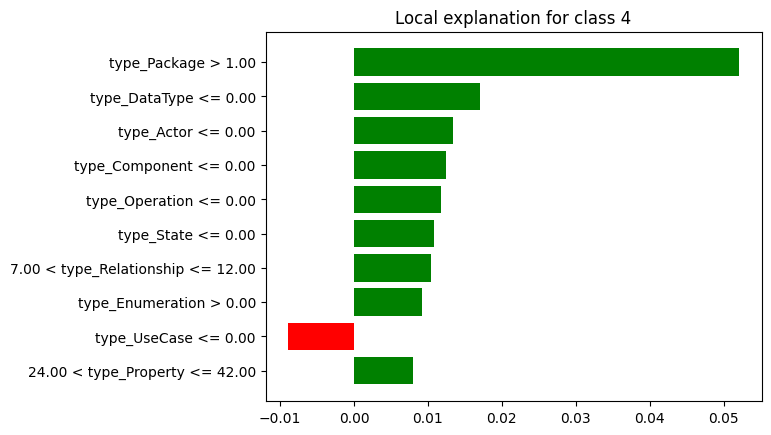

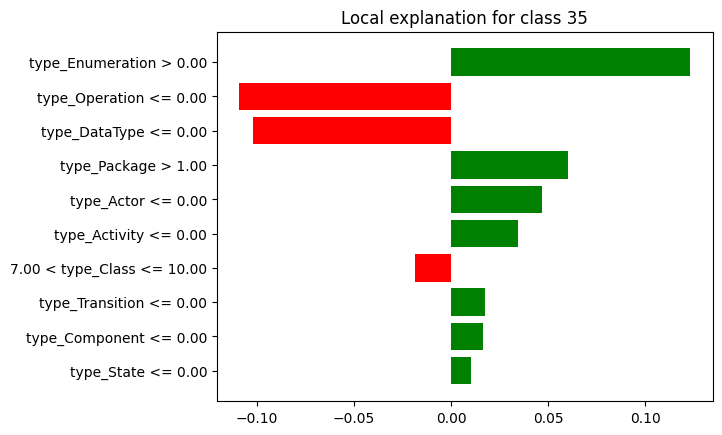

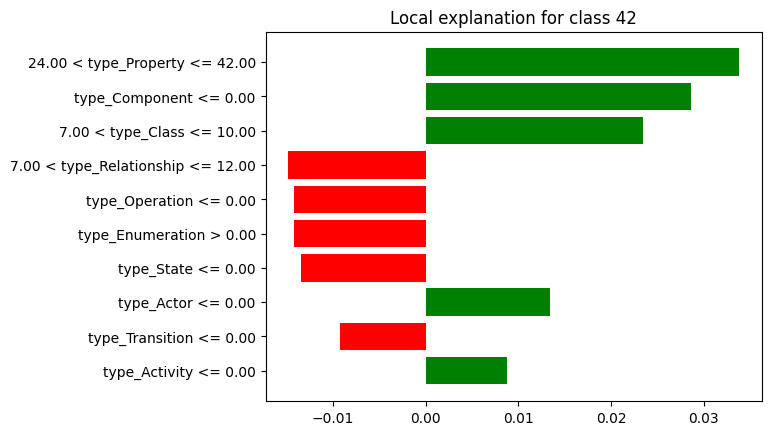

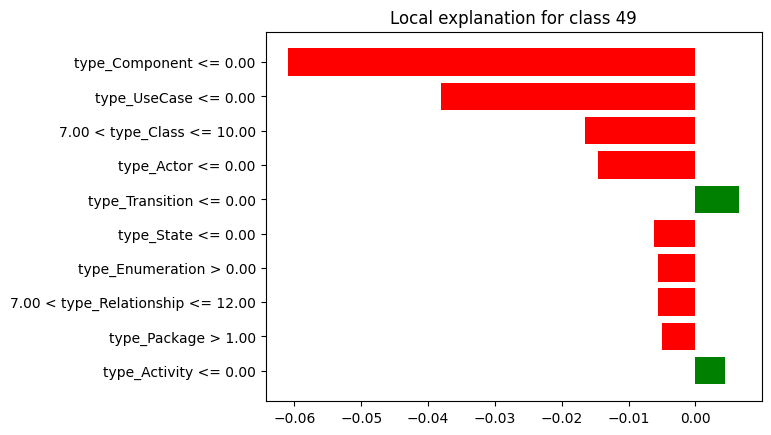

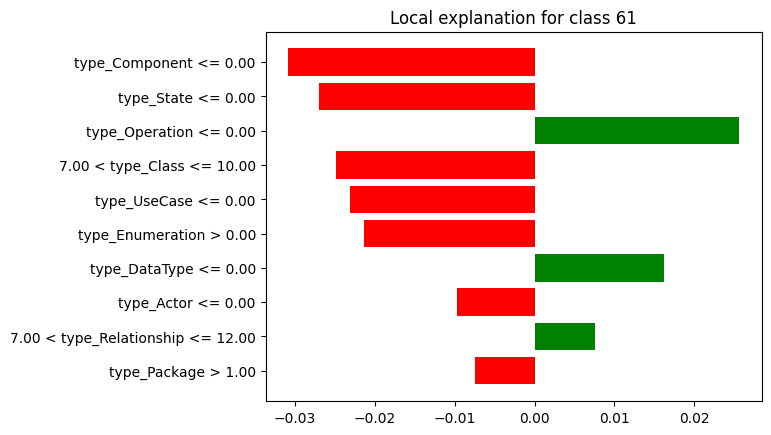

In [ ]:
for i in class_index:
  rf_exp_results['lime_bank'][i].plot()

In [ ]:
breakdown_df_bank_ban = breakdown_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_ban = breakdown_df_bank_ban.drop(index=[0, 14])
breakdown_df_bank_ban['sign'] = breakdown_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_ban = breakdown_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_ban = shap_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_ban = shap_df_bank_ban.tail(13)
shap_df_bank_ban['sign'] = shap_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_ban = shap_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_ban["Feature"] = lime_df_bank_ban["variable"].str.split(" ").str[0]
lime_df_bank_ban["Sign"] = lime_df_bank_ban["effect"].apply(evaluate_value)
lime_df_bank_ban = lime_df_bank_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['variable'])


breakdown_df_bank_ban['Ranking'] = breakdown_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_ban = breakdown_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_ban['Ranking'] = shap_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_ban = shap_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_ban['Ranking'] = lime_df_bank_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_ban = lime_df_bank_ban.head(10)
lime_df_bank_ban = lime_df_bank_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_ban = breakdown_df_bank_ban.drop(columns=['contribution'])
shap_df_bank_ban = shap_df_bank_ban.drop(columns=['contribution'])
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['effect'])


breakdown_df_bank_ban = breakdown_df_bank_ban.head(10)
breakdown_df_bank_ban = breakdown_df_bank_ban.reset_index(drop=True)

shap_df_bank_ban= shap_df_bank_ban.head(10)
shap_df_bank_ban = shap_df_bank_ban.reset_index(drop=True)

lime_df_bank_ban = lime_df_bank_ban.reset_index(drop=True)
lime_df_bank_ban.at[9, "Feature"] = "type_Property"
lime_df_bank_ban.at[6, "Feature"] = "type_Relationship"

print(breakdown_df_bank_ban)
print("---------------------------------")
print(shap_df_bank_ban)
print("---------------------------------")
print(lime_df_bank_ban)

             Feature  Ranking      Sign
0         type_Class        1  Positive
1  type_Relationship        2  Positive
2      type_Activity        3  Positive
3   type_Enumeration        4  Positive
4     type_Operation        5  Positive
5      type_Property        6  Positive
6       type_Package        7  Positive
7       type_UseCase        8  Positive
8     type_Component        9  Positive
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_Package        1  Positive
1      type_Property        2  Positive
2   type_Enumeration        3  Positive
3         type_Class        4  Positive
4     type_Operation        5  Positive
5  type_Relationship        6  Positive
6         type_Actor        7  Positive
7      type_Activity        8  Positive
8       type_UseCase        9  Positive
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_bank_ban['Feature'])
shap_features = list(shap_df_bank_ban['Feature'])
lime_features = list(lime_df_bank_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_ban['Feature'] = list(all_features)
df_final_ban_ban= df_final_ban_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_ban['Feature']:

    breakdown_row = breakdown_df_bank_ban[breakdown_df_bank_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_ban[shap_df_bank_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_ban[lime_df_bank_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_ban = df_final_ban_ban.loc[casos_validos]
df_final_ban_ban.set_index('Feature', inplace=True)
df_final_ban_ban

['type_Class', 'type_Relationship', 'type_Activity', 'type_Enumeration', 'type_Operation', 'type_Property', 'type_Package', 'type_UseCase', 'type_Component', 'type_Actor']
['type_Package', 'type_Property', 'type_Enumeration', 'type_Class', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Component']
['type_Package', 'type_DataType', 'type_Actor', 'type_Component', 'type_Operation', 'type_State', 'type_Relationship', 'type_Enumeration', 'type_UseCase', 'type_Property']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive       4  Positive       -         -
type_Relationship         2  Positive       6  Positive       7  Positive
type_Activity             3  Positive       8  Positive       -         -
type_Enumeration          4  Positive       3  Positive       8  Positive
type_Operation            5  Positive       5  Positive       5  Positive
type_Property             6  Positive       2  Positive      10  Positive
type_Package              7  Positive       1  Positive       1  Positive
type_UseCase              8  Positive       9  Positive       9  Negative
type_Component            9  Positive      10  Positive       4  Positive
type_Actor               10  Positive       7  Positive       3  Positive
type_State                -         -       -         -       6  Positive
type_DataType             -         -       -         -       2  Positive

In [ ]:
breakdown_df_bank_vid = breakdown_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_vid = breakdown_df_bank_vid.drop(index=[0, 14])
breakdown_df_bank_vid['sign'] = breakdown_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_vid = breakdown_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_vid = shap_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_vid = shap_df_bank_vid.tail(13)
shap_df_bank_vid['sign'] = shap_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_vid = shap_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_vid["Feature"] = lime_df_bank_vid["variable"].str.split(" ").str[0]
lime_df_bank_vid["Sign"] = lime_df_bank_vid["effect"].apply(evaluate_value)
lime_df_bank_vid = lime_df_bank_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['variable'])


breakdown_df_bank_vid['Ranking'] = breakdown_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_vid = breakdown_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_vid['Ranking'] = shap_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_vid = shap_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_vid['Ranking'] = lime_df_bank_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_vid = lime_df_bank_vid.head(10)
lime_df_bank_vid = lime_df_bank_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_vid = breakdown_df_bank_vid.drop(columns=['contribution'])
shap_df_bank_vid = shap_df_bank_vid.drop(columns=['contribution'])
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['effect'])


breakdown_df_bank_vid = breakdown_df_bank_vid.head(10)
breakdown_df_bank_vid = breakdown_df_bank_vid.reset_index(drop=True)

shap_df_bank_vid= shap_df_bank_vid.head(10)
shap_df_bank_vid = shap_df_bank_vid.reset_index(drop=True)

lime_df_bank_vid = lime_df_bank_vid.reset_index(drop=True)
lime_df_bank_vid.at[6, "Feature"] = "type_Class"

print(breakdown_df_bank_vid)
print("---------------------------------")
print(shap_df_bank_vid)
print("---------------------------------")
print(lime_df_bank_vid)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1   type_Enumeration        2  Positive
2  type_Relationship        3  Negative
3         type_Actor        4  Positive
4      type_DataType        5  Negative
5         type_Class        6  Negative
6       type_UseCase        7  Negative
7      type_Activity        8  Negative
8       type_Package        9  Negative
9      type_Property       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1   type_Enumeration        2  Positive
2       type_Package        3  Negative
3  type_Relationship        4  Negative
4      type_DataType        5  Negative
5         type_Actor        6  Positive
6         type_Class        7  Negative
7      type_Property        8  Negative
8      type_Activity        9  Positive
9     type_Component       10  Positive
---------------------------------
            Feature  Ranking      Sign
0  type_Enume

In [ ]:

breakdown_features = list(breakdown_df_bank_vid['Feature'])
shap_features = list(shap_df_bank_vid['Feature'])
lime_features = list(lime_df_bank_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_vid['Feature'] = list(all_features)
df_final_ban_vid= df_final_ban_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_vid['Feature']:

    breakdown_row = breakdown_df_bank_vid[breakdown_df_bank_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_vid[shap_df_bank_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_vid[lime_df_bank_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_vid = df_final_ban_vid.loc[casos_validos]
df_final_ban_vid.set_index('Feature', inplace=True)
df_final_ban_vid

['type_Operation', 'type_Enumeration', 'type_Relationship', 'type_Actor', 'type_DataType', 'type_Class', 'type_UseCase', 'type_Activity', 'type_Package', 'type_Property']
['type_Operation', 'type_Enumeration', 'type_Package', 'type_Relationship', 'type_DataType', 'type_Actor', 'type_Class', 'type_Property', 'type_Activity', 'type_Component']
['type_Enumeration', 'type_Operation', 'type_DataType', 'type_Package', 'type_Actor', 'type_Activity', 'type_Class', 'type_Transition', 'type_Component', 'type_State']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       1  Negative       2  Negative
type_Enumeration          2  Positive       2  Positive       1  Positive
type_Relationship         3  Negative       4  Negative       -         -
type_Actor                4  Positive       6  Positive       5  Positive
type_DataType             5  Negative       5  Negative       3  Negative
type_Class                6  Negative       7  Negative       7  Negative
type_UseCase              7  Negative       -         -       -         -
type_Activity             8  Negative       9  Positive       6  Positive
type_Package              9  Negative       3  Negative       4  Positive
type_Property            10  Positive       8  Negative       -         -
type_Component            -         -      10  Positive       9  Positive
type_State                -         -       -         -      10  Positive
type_Transition           -         -       -         -       8  Positive

In [ ]:
breakdown_df_bank_cou = breakdown_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_cou = breakdown_df_bank_cou.drop(index=[0, 14])
breakdown_df_bank_cou['sign'] = breakdown_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_cou = breakdown_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_cou = shap_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_cou = shap_df_bank_cou.tail(13)
shap_df_bank_cou['sign'] = shap_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_cou = shap_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_cou["Feature"] = lime_df_bank_cou["variable"].str.split(" ").str[0]
lime_df_bank_cou["Sign"] = lime_df_bank_cou["effect"].apply(evaluate_value)
lime_df_bank_cou = lime_df_bank_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['variable'])


breakdown_df_bank_cou['Ranking'] = breakdown_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_cou = breakdown_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_cou['Ranking'] = shap_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_cou = shap_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_cou['Ranking'] = lime_df_bank_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_cou = lime_df_bank_cou.head(10)
lime_df_bank_cou = lime_df_bank_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_cou = breakdown_df_bank_cou.drop(columns=['contribution'])
shap_df_bank_cou = shap_df_bank_cou.drop(columns=['contribution'])
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['effect'])


breakdown_df_bank_cou = breakdown_df_bank_cou.head(10)
breakdown_df_bank_cou = breakdown_df_bank_cou.reset_index(drop=True)

shap_df_bank_cou= shap_df_bank_cou.head(10)
shap_df_bank_cou = shap_df_bank_cou.reset_index(drop=True)

lime_df_bank_cou = lime_df_bank_cou.reset_index(drop=True)
lime_df_bank_cou.at[3, "Feature"] = "type_Relationship"
lime_df_bank_cou.at[2, "Feature"] = "type_Class"
lime_df_bank_cou.at[0, "Feature"] = "type_Property"

print(breakdown_df_bank_cou)
print("---------------------------------")
print(shap_df_bank_cou)
print("---------------------------------")
print(lime_df_bank_cou)

             Feature  Ranking      Sign
0   type_Enumeration        1  Negative
1         type_Class        2  Positive
2      type_Property        3  Positive
3       type_Package        4  Negative
4  type_Relationship        5  Negative
5     type_Component        6  Positive
6      type_DataType        7  Negative
7      type_Activity        8  Positive
8     type_Operation        9  Negative
9       type_UseCase       10  Negative
---------------------------------
            Feature  Ranking      Sign
0  type_Enumeration        1  Negative
1      type_Package        2  Negative
2     type_Property        3  Positive
3      type_UseCase        4  Negative
4    type_Component        5  Positive
5     type_DataType        6  Negative
6    type_Operation        7  Negative
7     type_Activity        8  Positive
8        type_Actor        9  Positive
9        type_Class       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property   

In [ ]:

breakdown_features = list(breakdown_df_bank_cou['Feature'])
shap_features = list(shap_df_bank_cou['Feature'])
lime_features = list(lime_df_bank_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_cou['Feature'] = list(all_features)
df_final_ban_cou= df_final_ban_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_cou['Feature']:

    breakdown_row = breakdown_df_bank_cou[breakdown_df_bank_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_cou[shap_df_bank_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_cou[lime_df_bank_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_cou = df_final_ban_cou.loc[casos_validos]
df_final_ban_cou.set_index('Feature', inplace=True)
df_final_ban_cou

['type_Enumeration', 'type_Class', 'type_Property', 'type_Package', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Activity', 'type_Operation', 'type_UseCase']
['type_Enumeration', 'type_Package', 'type_Property', 'type_UseCase', 'type_Component', 'type_DataType', 'type_Operation', 'type_Activity', 'type_Actor', 'type_Class']
['type_Property', 'type_Component', 'type_Class', 'type_Relationship', 'type_Operation', 'type_Enumeration', 'type_State', 'type_Actor', 'type_Transition', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Enumeration          1  Negative       1  Negative       6  Negative
type_Class                2  Positive      10  Positive       3  Positive
type_Property             3  Positive       3  Positive       1  Positive
type_Package              4  Negative       2  Negative       -         -
type_Relationship         5  Negative       -         -       4  Negative
type_Component            6  Positive       5  Positive       2  Positive
type_DataType             7  Negative       6  Negative       -         -
type_Activity             8  Positive       8  Positive      10  Positive
type_Operation            9  Negative       7  Negative       5  Negative
type_UseCase             10  Negative       4  Negative       -         -
type_Actor                -         -       9  Positive       8  Positive
type_State                -         -       -         -       7  Negative
type_Transition           -         -       -         -       9  Negative

In [ ]:
breakdown_df_bank_emp = breakdown_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_emp = breakdown_df_bank_emp.drop(index=[0, 14])
breakdown_df_bank_emp['sign'] = breakdown_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_emp = breakdown_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_emp = shap_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_emp = shap_df_bank_emp.tail(13)
shap_df_bank_emp['sign'] = shap_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_emp = shap_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_emp["Feature"] = lime_df_bank_emp["variable"].str.split(" ").str[0]
lime_df_bank_emp["Sign"] = lime_df_bank_emp["effect"].apply(evaluate_value)
lime_df_bank_emp = lime_df_bank_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['variable'])


breakdown_df_bank_emp['Ranking'] = breakdown_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_emp = breakdown_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_emp['Ranking'] = shap_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_emp = shap_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_emp['Ranking'] = lime_df_bank_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_emp = lime_df_bank_emp.head(10)
lime_df_bank_emp = lime_df_bank_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_emp = breakdown_df_bank_emp.drop(columns=['contribution'])
shap_df_bank_emp = shap_df_bank_emp.drop(columns=['contribution'])
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['effect'])


breakdown_df_bank_emp = breakdown_df_bank_emp.head(10)
breakdown_df_bank_emp = breakdown_df_bank_emp.reset_index(drop=True)

shap_df_bank_emp= shap_df_bank_emp.head(10)
shap_df_bank_emp = shap_df_bank_emp.reset_index(drop=True)

lime_df_bank_emp = lime_df_bank_emp.reset_index(drop=True)
lime_df_bank_emp.at[2, "Feature"] = "type_Class"
lime_df_bank_emp.at[7, "Feature"] = "type_Relationship"

print(breakdown_df_bank_emp)
print("---------------------------------")
print(shap_df_bank_emp)
print("---------------------------------")
print(lime_df_bank_emp)

             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1   type_Enumeration        2  Negative
2     type_Operation        3  Negative
3     type_Component        4  Negative
4      type_Activity        5  Positive
5  type_Relationship        6  Negative
6         type_Actor        7  Negative
7       type_Package        8  Negative
8         type_Class        9  Negative
9      type_Property       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1     type_Component        2  Negative
2   type_Enumeration        3  Negative
3       type_Package        4  Negative
4         type_Actor        5  Negative
5     type_Operation        6  Negative
6      type_Property        7  Negative
7  type_Relationship        8  Negative
8         type_Class        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_bank_emp['Feature'])
shap_features = list(shap_df_bank_emp['Feature'])
lime_features = list(lime_df_bank_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_emp['Feature'] = list(all_features)
df_final_ban_emp= df_final_ban_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_emp['Feature']:

    breakdown_row = breakdown_df_bank_emp[breakdown_df_bank_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_emp[shap_df_bank_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_emp[lime_df_bank_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_emp = df_final_ban_emp.loc[casos_validos]
df_final_ban_emp.set_index('Feature', inplace=True)
df_final_ban_emp

['type_UseCase', 'type_Enumeration', 'type_Operation', 'type_Component', 'type_Activity', 'type_Relationship', 'type_Actor', 'type_Package', 'type_Class', 'type_Property']
['type_UseCase', 'type_Component', 'type_Enumeration', 'type_Package', 'type_Actor', 'type_Operation', 'type_Property', 'type_Relationship', 'type_Class', 'type_Activity']
['type_Component', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Transition', 'type_State', 'type_Enumeration', 'type_Relationship', 'type_Package', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Negative       1  Negative       2  Negative
type_Enumeration          2  Negative       3  Negative       7  Negative
type_Operation            3  Negative       6  Negative       -         -
type_Component            4  Negative       2  Negative       1  Negative
type_Activity             5  Positive      10  Positive      10  Positive
type_Relationship         6  Negative       8  Negative       8  Negative
type_Actor                7  Negative       5  Negative       4  Negative
type_Package              8  Negative       4  Negative       9  Negative
type_Class                9  Negative       9  Negative       3  Negative
type_Property            10  Negative       7  Negative       -         -
type_State                -         -       -         -       6  Negative
type_Transition           -         -       -         -       5  Positive

In [ ]:
breakdown_df_bank_lib = breakdown_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_lib = breakdown_df_bank_lib.drop(index=[0, 14])
breakdown_df_bank_lib['sign'] = breakdown_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_lib = breakdown_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_lib = shap_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_lib = shap_df_bank_lib.tail(13)
shap_df_bank_lib['sign'] = shap_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_lib = shap_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_lib["Feature"] = lime_df_bank_lib["variable"].str.split(" ").str[0]
lime_df_bank_lib["Sign"] = lime_df_bank_lib["effect"].apply(evaluate_value)
lime_df_bank_lib = lime_df_bank_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['variable'])


breakdown_df_bank_lib['Ranking'] = breakdown_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_lib = breakdown_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_lib['Ranking'] = shap_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_lib = shap_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_lib['Ranking'] = lime_df_bank_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_lib = lime_df_bank_lib.head(10)
lime_df_bank_lib = lime_df_bank_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_lib = breakdown_df_bank_lib.drop(columns=['contribution'])
shap_df_bank_lib = shap_df_bank_lib.drop(columns=['contribution'])
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['effect'])


breakdown_df_bank_lib = breakdown_df_bank_lib.head(10)
breakdown_df_bank_lib = breakdown_df_bank_lib.reset_index(drop=True)

shap_df_bank_lib= shap_df_bank_lib.head(10)
shap_df_bank_lib = shap_df_bank_lib.reset_index(drop=True)

lime_df_bank_lib = lime_df_bank_lib.reset_index(drop=True)
lime_df_bank_lib.at[8, "Feature"] = "type_Relationship"
lime_df_bank_lib.at[3, "Feature"] = "type_Class"

print(breakdown_df_bank_lib)
print("---------------------------------")
print(shap_df_bank_lib)
print("---------------------------------")
print(lime_df_bank_lib)

             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1   type_Enumeration        2  Negative
2         type_Actor        3  Negative
3         type_Class        4  Negative
4     type_Component        5  Negative
5       type_Package        6  Negative
6       type_UseCase        7  Negative
7      type_Property        8  Negative
8      type_Activity        9  Negative
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_UseCase        2  Negative
2  type_Relationship        3  Positive
3     type_Component        4  Negative
4   type_Enumeration        5  Negative
5         type_Actor        6  Negative
6       type_Package        7  Negative
7      type_Activity        8  Negative
8     type_Operation        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_bank_lib['Feature'])
shap_features = list(shap_df_bank_lib['Feature'])
lime_features = list(lime_df_bank_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_lib['Feature'] = list(all_features)
df_final_ban_lib= df_final_ban_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_lib['Feature']:

    breakdown_row = breakdown_df_bank_lib[breakdown_df_bank_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_lib[shap_df_bank_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_lib[lime_df_bank_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_lib = df_final_ban_lib.loc[casos_validos]
df_final_ban_lib.set_index('Feature', inplace=True)
df_final_ban_lib

['type_Relationship', 'type_Enumeration', 'type_Actor', 'type_Class', 'type_Component', 'type_Package', 'type_UseCase', 'type_Property', 'type_Activity', 'type_DataType']
['type_Class', 'type_UseCase', 'type_Relationship', 'type_Component', 'type_Enumeration', 'type_Actor', 'type_Package', 'type_Activity', 'type_Operation', 'type_DataType']
['type_Component', 'type_State', 'type_Operation', 'type_Class', 'type_UseCase', 'type_Enumeration', 'type_DataType', 'type_Actor', 'type_Relationship', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Positive       3  Positive       9  Positive
type_Enumeration          2  Negative       5  Negative       6  Negative
type_Actor                3  Negative       6  Negative       8  Negative
type_Class                4  Negative       1  Negative       4  Negative
type_Component            5  Negative       4  Negative       1  Negative
type_Package              6  Negative       7  Negative      10  Negative
type_UseCase              7  Negative       2  Negative       5  Negative
type_Property             8  Negative       -         -       -         -
type_Activity             9  Negative       8  Negative       -         -
type_DataType            10  Positive      10  Positive       7  Positive
type_Operation            -         -       9  Positive       3  Positive
type_State                -         -       -         -       2  Negative

### **Results Bank:**

In [ ]:
df_topfeatures_ban_ban = top5_features(df_final_ban_ban, 'Bank - Class: Bank')
df_topfeatures_ban_vid = top5_features(df_final_ban_vid, 'Bank - Class: ComputerVideogames')
df_topfeatures_ban_cou = top5_features(df_final_ban_cou, 'Bank - Class: Course')
df_topfeatures_ban_emp = top5_features(df_final_ban_emp, 'Bank - Class: Employee')
df_topfeatures_ban_lib = top5_features(df_final_ban_lib, 'Bank - Class: Library')

df_topfeatures_bank = pd.concat([df_topfeatures_ban_ban, df_topfeatures_ban_vid, df_topfeatures_ban_cou, df_topfeatures_ban_emp, df_topfeatures_ban_lib])
df_topfeatures_bank

TOP5 Breakdown  \
Bank - Class: Bank                type_Class, type_Relationship, type_Operation,...   
Bank - Class: ComputerVideogames  type_Actor, type_DataType, type_Relationship, ...   
Bank - Class: Course              type_Package, type_Class, type_Property, type_...   
Bank - Class: Employee            type_Component, type_UseCase, type_Operation, ...   
Bank - Class: Library             type_Component, type_Actor, type_Class, type_R...   

                                                                          TOP5 Shap  \
Bank - Class: Bank                type_Package, type_Class, type_Property, type_...   
Bank - Class: ComputerVideogames  type_Package, type_DataType, type_Relationship...   
Bank - Class: Course              type_Package, type_Component, type_UseCase, ty...   
Bank - Class: Employee            type_Component, type_Package, type_Actor, type...   
Bank - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                                                          TOP5 Lime  \
Bank - Class: Bank                type_Package, type_Component, type_Actor, type...   
Bank - Class: ComputerVideogames  type_Package, type_Actor, type_DataType, type_...   
Bank - Class: Course              type_Component, type_Class, type_Property, typ...   
Bank - Class: Employee            type_Component, type_Actor, type_Class, type_U...   
Bank - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class: Bank                           0.6             0.2        0.4  
Bank - Class: ComputerVideogames             0.8             0.8        0.8  
Bank - Class: Course                         0.6             0.6        0.4  
Bank - Class: Employee                       0.6             0.4        0.6  
Bank - Class: Library                        0.8             0.4        0.6

In [ ]:
df_topfeatures_ban_ban_rank = top5_rank(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank = top5_rank(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank = top5_rank(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank = top5_rank(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank = top5_rank(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_bank = pd.concat([df_topfeatures_ban_ban_rank, df_topfeatures_ban_vid_rank, df_topfeatures_ban_cou_rank, df_topfeatures_ban_emp_rank, df_topfeatures_ban_lib_rank])
df_topfeatures_rank_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_Class, 2:type_Relationship, 3:type_Acti...   
Bank - Class ComputerVideogames  1:type_Operation, 2:type_Enumeration, 3:type_R...   
Bank - Class Course              1:type_Enumeration, 2:type_Class, 3:type_Prope...   
Bank - Class Employee            1:type_UseCase, 2:type_Enumeration, 3:type_Ope...   
Bank - Class Library             1:type_Relationship, 2:type_Enumeration, 3:typ...   

                                                                         TOP5 Shap  \
Bank - Class Bank                4:type_Class, 3:type_Enumeration, 5:type_Opera...   
Bank - Class ComputerVideogames  1:type_Operation, 2:type_Enumeration, 4:type_R...   
Bank - Class Course              1:type_Enumeration, 3:type_Property, 2:type_Pa...   
Bank - Class Employee            1:type_UseCase, 3:type_Enumeration, 2:type_Com...   
Bank - Class Library             3:type_Relationship, 5:type_Enumeration, 1:typ...   

                                                                         TOP5 Lime  \
Bank - Class Bank                5:type_Operation, 1:type_Package, 4:type_Compo...   
Bank - Class ComputerVideogames  2:type_Operation, 1:type_Enumeration, 5:type_A...   
Bank - Class Course              3:type_Class, 1:type_Property, 4:type_Relation...   
Bank - Class Employee            2:type_UseCase, 1:type_Component, 4:type_Actor...   
Bank - Class Library             4:type_Class, 1:type_Component, 5:type_UseCase...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.2             0.2        0.4  
Bank - Class ComputerVideogames             0.6             0.0        0.0  
Bank - Class Course                         0.4             0.0        0.0  
Bank - Class Employee                       0.2             0.0        0.0  
Bank - Class Library                        0.0             0.2        0.0

In [ ]:
df_topfeatures_ban_ban_sign = top5_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_sign = top5_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_sign = top5_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_sign = top5_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_sign = top5_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_sign_bank = pd.concat([df_topfeatures_ban_ban_sign, df_topfeatures_ban_vid_sign, df_topfeatures_ban_cou_sign, df_topfeatures_ban_emp_sign, df_topfeatures_ban_lib_sign])
df_topfeatures_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                type_Class:Positive, type_Relationship:Positiv...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Enumeration:Posi...   
Bank - Class Course              type_Enumeration:Negative, type_Class:Positive...   
Bank - Class Employee            type_UseCase:Negative, type_Enumeration:Negati...   
Bank - Class Library             type_Relationship:Positive, type_Enumeration:N...   

                                                                         TOP5 Shap  \
Bank - Class Bank                type_Class:Positive, type_Enumeration:Positive...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Enumeration:Posi...   
Bank - Class Course              type_Enumeration:Negative, type_Property:Posit...   
Bank - Class Employee            type_UseCase:Negative, type_Enumeration:Negati...   
Bank - Class Library             type_Relationship:Positive, type_Enumeration:N...   

                                                                         TOP5 Lime  \
Bank - Class Bank                type_Operation:Positive, type_Package:Positive...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Enumeration:Posi...   
Bank - Class Course              type_Class:Positive, type_Property:Positive, t...   
Bank - Class Employee            type_UseCase:Negative, type_Component:Negative...   
Bank - Class Library             type_Class:Negative, type_Component:Negative, ...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.6             0.2        0.4  
Bank - Class ComputerVideogames             0.8             0.8        0.6  
Bank - Class Course                         0.6             0.6        0.4  
Bank - Class Employee                       0.6             0.4        0.6  
Bank - Class Library                        0.8             0.4        0.6

In [ ]:
df_topfeatures_ban_ban_rank_sign = top5_rank_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank_sign = top5_rank_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank_sign = top5_rank_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank_sign = top5_rank_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank_sign = top5_rank_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_sign_bank = pd.concat([df_topfeatures_ban_ban_rank_sign, df_topfeatures_ban_vid_rank_sign, df_topfeatures_ban_cou_rank_sign, df_topfeatures_ban_emp_rank_sign, df_topfeatures_ban_lib_rank_sign])
df_topfeatures_rank_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_Class:Positive, 2:type_Relationship:Pos...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Enumeration:...   
Bank - Class Course              1:type_Enumeration:Negative, 2:type_Class:Posi...   
Bank - Class Employee            1:type_UseCase:Negative, 2:type_Enumeration:Ne...   
Bank - Class Library             1:type_Relationship:Positive, 2:type_Enumerati...   

                                                                         TOP5 Shap  \
Bank - Class Bank                4:type_Class:Positive, 3:type_Enumeration:Posi...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Enumeration:...   
Bank - Class Course              1:type_Enumeration:Negative, 3:type_Property:P...   
Bank - Class Employee            1:type_UseCase:Negative, 3:type_Enumeration:Ne...   
Bank - Class Library             3:type_Relationship:Positive, 5:type_Enumerati...   

                                                                         TOP5 Lime  \
Bank - Class Bank                5:type_Operation:Positive, 1:type_Package:Posi...   
Bank - Class ComputerVideogames  2:type_Operation:Negative, 1:type_Enumeration:...   
Bank - Class Course              3:type_Class:Positive, 1:type_Property:Positiv...   
Bank - Class Employee            2:type_UseCase:Negative, 1:type_Component:Nega...   
Bank - Class Library             4:type_Class:Negative, 1:type_Component:Negati...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.2             0.2        0.4  
Bank - Class ComputerVideogames             0.6             0.0        0.0  
Bank - Class Course                         0.4             0.0        0.0  
Bank - Class Employee                       0.2             0.0        0.0  
Bank - Class Library                        0.0             0.2        0.0

### **Employee:**

In [ ]:
breakdown_df_employee_ban = rf_exp_results['breakdown_employee'][0].result
shap_df_employee_ban = rf_exp_results['shap_employee'][0].result
lime_df_employee_ban = rf_exp_results['lime_employee'][0].result

In [ ]:
breakdown_df_employee_vid = rf_exp_results['breakdown_employee'][1].result
shap_df_employee_vid = rf_exp_results['shap_employee'][1].result
lime_df_employee_vid = rf_exp_results['lime_employee'][1].result

In [ ]:
breakdown_df_employee_cou = rf_exp_results['breakdown_employee'][3].result
shap_df_employee_cou = rf_exp_results['shap_employee'][3].result
lime_df_employee_cou = rf_exp_results['lime_employee'][3].result

In [ ]:
breakdown_df_employee_emp = rf_exp_results['breakdown_employee'][4].result
shap_df_employee_emp = rf_exp_results['shap_employee'][4].result
lime_df_employee_emp = rf_exp_results['lime_employee'][4].result

In [ ]:
breakdown_df_employee_lib = rf_exp_results['breakdown_employee'][6].result
shap_df_employee_lib = rf_exp_results['shap_employee'][6].result
lime_df_employee_lib = rf_exp_results['lime_employee'][6].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_employee'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_employee'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

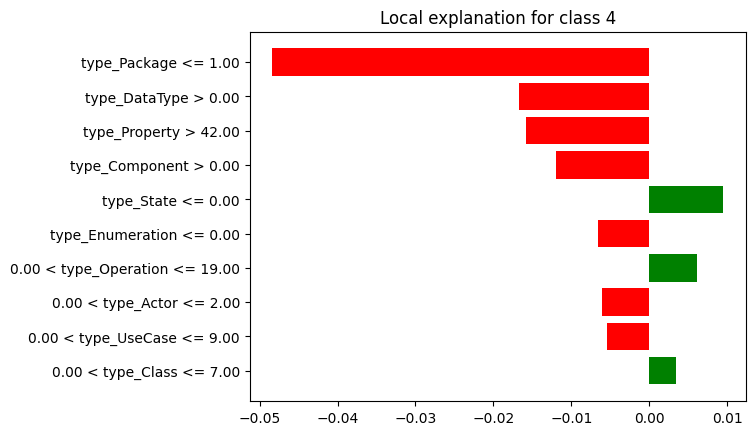

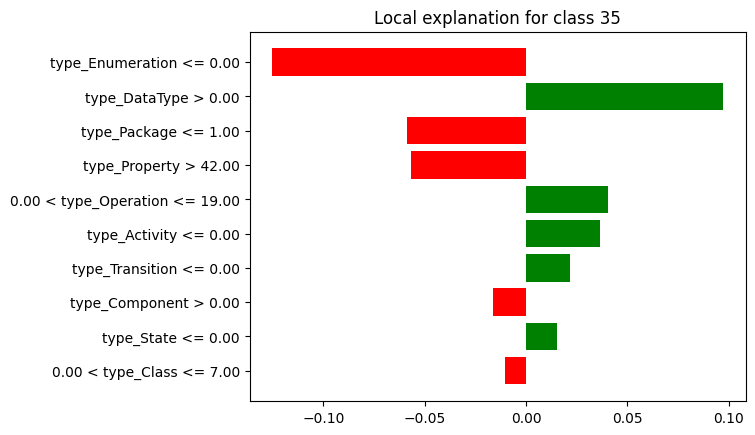

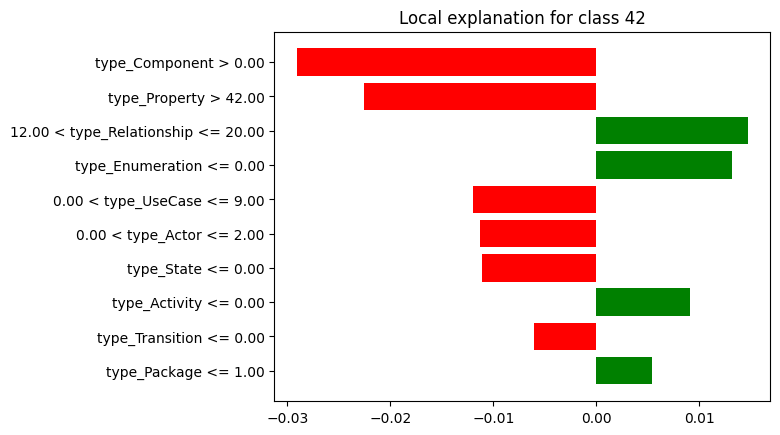

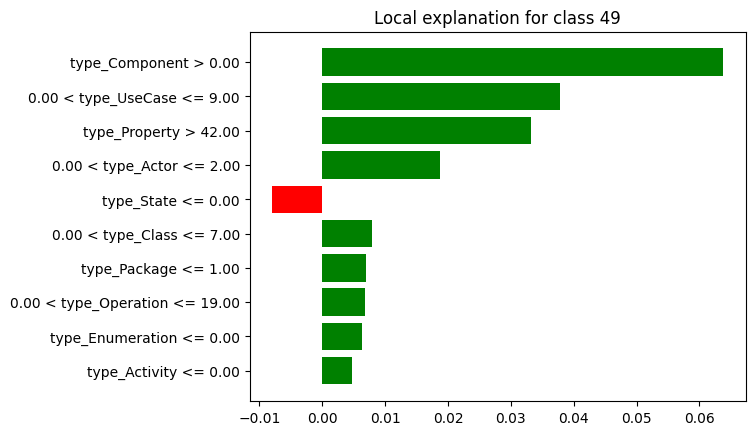

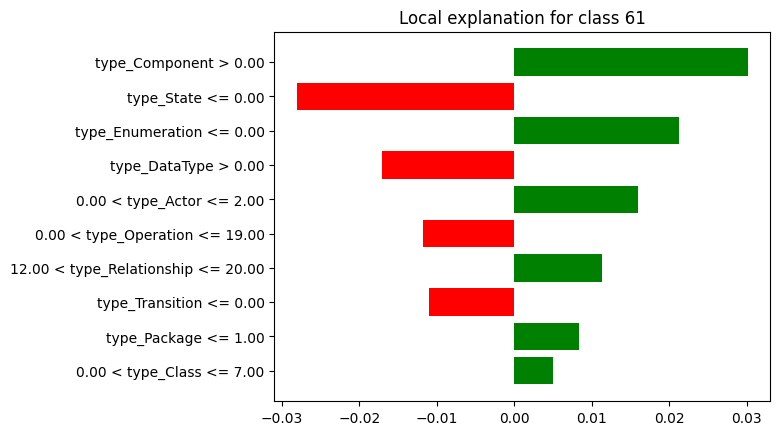

In [ ]:
for i in class_index:
  rf_exp_results['lime_employee'][i].plot()

In [ ]:
breakdown_df_employee_ban = breakdown_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_ban = breakdown_df_employee_ban.drop(index=[0, 14])
breakdown_df_employee_ban['sign'] = breakdown_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_ban = breakdown_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_ban = shap_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_ban = shap_df_employee_ban.tail(13)
shap_df_employee_ban['sign'] = shap_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_ban = shap_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_ban["Feature"] = lime_df_employee_ban["variable"].str.split(" ").str[0]
lime_df_employee_ban["Sign"] = lime_df_employee_ban["effect"].apply(evaluate_value)
lime_df_employee_ban = lime_df_employee_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['variable'])


breakdown_df_employee_ban['Ranking'] = breakdown_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_ban = breakdown_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_ban['Ranking'] = shap_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_ban = shap_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_ban['Ranking'] = lime_df_employee_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_ban = lime_df_employee_ban.head(10)
lime_df_employee_ban = lime_df_employee_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_ban = breakdown_df_employee_ban.drop(columns=['contribution'])
shap_df_employee_ban = shap_df_employee_ban.drop(columns=['contribution'])
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['effect'])


breakdown_df_employee_ban = breakdown_df_employee_ban.head(10)
breakdown_df_employee_ban = breakdown_df_employee_ban.reset_index(drop=True)

shap_df_employee_ban= shap_df_employee_ban.head(10)
shap_df_employee_ban = shap_df_employee_ban.reset_index(drop=True)

lime_df_employee_ban = lime_df_employee_ban.reset_index(drop=True)
lime_df_employee_ban.at[6, "Feature"] = "type_Operation"
lime_df_employee_ban.at[7, "Feature"] = "type_Actor"
lime_df_employee_ban.at[8, "Feature"] = "type_UseCase"
lime_df_employee_ban.at[9, "Feature"] = "type_Class"

print(breakdown_df_employee_ban)
print("---------------------------------")
print(shap_df_employee_ban)
print("---------------------------------")
print(lime_df_employee_ban)

             Feature  Ranking      Sign
0     type_Component        1  Negative
1       type_UseCase        2  Negative
2      type_DataType        3  Negative
3     type_Operation        4  Negative
4   type_Enumeration        5  Negative
5      type_Activity        6  Negative
6  type_Relationship        7  Negative
7      type_Property        8  Negative
8         type_Actor        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1  type_Relationship        2  Negative
2       type_Package        3  Negative
3   type_Enumeration        4  Negative
4      type_DataType        5  Negative
5         type_Class        6  Negative
6      type_Property        7  Negative
7         type_Actor        8  Negative
8       type_UseCase        9  Negative
9     type_Component       10  Negative
---------------------------------
            Feature  Ranking      Sign
0      type_P

In [ ]:

breakdown_features = list(breakdown_df_employee_ban['Feature'])
shap_features = list(shap_df_employee_ban['Feature'])
lime_features = list(lime_df_employee_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_ban['Feature'] = list(all_features)
df_final_emp_ban= df_final_emp_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_ban['Feature']:

    breakdown_row = breakdown_df_employee_ban[breakdown_df_employee_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_ban[shap_df_employee_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_ban[lime_df_employee_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_ban = df_final_emp_ban.loc[casos_validos]
df_final_emp_ban.set_index('Feature', inplace=True)
df_final_emp_ban

['type_Component', 'type_UseCase', 'type_DataType', 'type_Operation', 'type_Enumeration', 'type_Activity', 'type_Relationship', 'type_Property', 'type_Actor', 'type_Package']
['type_Operation', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_DataType', 'type_Class', 'type_Property', 'type_Actor', 'type_UseCase', 'type_Component']
['type_Package', 'type_DataType', 'type_Property', 'type_Component', 'type_State', 'type_Enumeration', 'type_Operation', 'type_Actor', 'type_UseCase', 'type_Class']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Component            1  Negative      10  Negative       4  Negative
type_UseCase              2  Negative       9  Negative       9  Negative
type_DataType             3  Negative       5  Negative       2  Negative
type_Operation            4  Negative       1  Negative       7  Positive
type_Enumeration          5  Negative       4  Negative       6  Negative
type_Activity             6  Negative       -         -       -         -
type_Relationship         7  Negative       2  Negative       -         -
type_Property             8  Negative       7  Negative       3  Negative
type_Actor                9  Negative       8  Negative       8  Negative
type_Package             10  Negative       3  Negative       1  Negative
type_Class                -         -       6  Negative      10  Positive
type_State                -         -       -         -       5  Positive

In [ ]:
breakdown_df_employee_vid = breakdown_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_vid = breakdown_df_employee_vid.drop(index=[0, 14])
breakdown_df_employee_vid['sign'] = breakdown_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_vid = breakdown_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_vid = shap_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_vid = shap_df_employee_vid.tail(13)
shap_df_employee_vid['sign'] = shap_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_vid = shap_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_vid["Feature"] = lime_df_employee_vid["variable"].str.split(" ").str[0]
lime_df_employee_vid["Sign"] = lime_df_employee_vid["effect"].apply(evaluate_value)
lime_df_employee_vid = lime_df_employee_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['variable'])


breakdown_df_employee_vid['Ranking'] = breakdown_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_vid = breakdown_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_vid['Ranking'] = shap_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_vid = shap_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_vid['Ranking'] = lime_df_employee_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_vid = lime_df_employee_vid.head(10)
lime_df_employee_vid = lime_df_employee_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_vid = breakdown_df_employee_vid.drop(columns=['contribution'])
shap_df_employee_vid = shap_df_employee_vid.drop(columns=['contribution'])
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['effect'])


breakdown_df_employee_vid = breakdown_df_employee_vid.head(10)
breakdown_df_employee_vid = breakdown_df_employee_vid.reset_index(drop=True)

shap_df_employee_vid= shap_df_employee_vid.head(10)
shap_df_employee_vid = shap_df_employee_vid.reset_index(drop=True)

lime_df_employee_vid = lime_df_employee_vid.reset_index(drop=True)
lime_df_employee_vid.at[4, "Feature"] = "type_Operation"
lime_df_employee_vid.at[9, "Feature"] = "type_Class"

print(breakdown_df_employee_vid)
print("---------------------------------")
print(shap_df_employee_vid)
print("---------------------------------")
print(lime_df_employee_vid)

             Feature  Ranking      Sign
0     type_Component        1  Negative
1     type_Operation        2  Positive
2      type_DataType        3  Positive
3         type_Actor        4  Negative
4      type_Property        5  Negative
5   type_Enumeration        6  Negative
6       type_UseCase        7  Negative
7  type_Relationship        8  Negative
8       type_Package        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1      type_Property        2  Negative
2     type_Component        3  Negative
3      type_DataType        4  Positive
4     type_Operation        5  Positive
5   type_Enumeration        6  Negative
6       type_Package        7  Negative
7  type_Relationship        8  Negative
8      type_Activity        9  Positive
9       type_UseCase       10  Negative
---------------------------------
            Feature  Ranking      Sign
0  type_Enume

In [ ]:

breakdown_features = list(breakdown_df_employee_vid['Feature'])
shap_features = list(shap_df_employee_vid['Feature'])
lime_features = list(lime_df_employee_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_vid['Feature'] = list(all_features)
df_final_emp_vid= df_final_emp_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_vid['Feature']:

    breakdown_row = breakdown_df_employee_vid[breakdown_df_employee_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_vid[shap_df_employee_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_vid[lime_df_employee_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_vid = df_final_emp_vid.loc[casos_validos]
df_final_emp_vid.set_index('Feature', inplace=True)
df_final_emp_vid

['type_Component', 'type_Operation', 'type_DataType', 'type_Actor', 'type_Property', 'type_Enumeration', 'type_UseCase', 'type_Relationship', 'type_Package', 'type_Activity']
['type_Actor', 'type_Property', 'type_Component', 'type_DataType', 'type_Operation', 'type_Enumeration', 'type_Package', 'type_Relationship', 'type_Activity', 'type_UseCase']
['type_Enumeration', 'type_DataType', 'type_Package', 'type_Property', 'type_Operation', 'type_Activity', 'type_Transition', 'type_Component', 'type_State', 'type_Class']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Component            1  Negative       3  Negative       8  Negative
type_Operation            2  Positive       5  Positive       5  Positive
type_DataType             3  Positive       4  Positive       2  Positive
type_Actor                4  Negative       1  Negative       -         -
type_Property             5  Negative       2  Negative       4  Negative
type_Enumeration          6  Negative       6  Negative       1  Negative
type_UseCase              7  Negative      10  Negative       -         -
type_Relationship         8  Negative       8  Negative       -         -
type_Package              9  Negative       7  Negative       3  Negative
type_Activity            10  Positive       9  Positive       6  Positive
type_State                -         -       -         -       9  Positive
type_Transition           -         -       -         -       7  Positive
type_Class                -         -       -         -      10  Negative

In [ ]:
breakdown_df_employee_cou = breakdown_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_cou = breakdown_df_employee_cou.drop(index=[0, 14])
breakdown_df_employee_cou['sign'] = breakdown_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_cou = breakdown_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_cou = shap_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_cou = shap_df_employee_cou.tail(13)
shap_df_employee_cou['sign'] = shap_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_cou = shap_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_cou["Feature"] = lime_df_employee_cou["variable"].str.split(" ").str[0]
lime_df_employee_cou["Sign"] = lime_df_employee_cou["effect"].apply(evaluate_value)
lime_df_employee_cou = lime_df_employee_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['variable'])


breakdown_df_employee_cou['Ranking'] = breakdown_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_cou = breakdown_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_cou['Ranking'] = shap_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_cou = shap_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_cou['Ranking'] = lime_df_employee_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_cou = lime_df_employee_cou.head(10)
lime_df_employee_cou = lime_df_employee_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_cou = breakdown_df_employee_cou.drop(columns=['contribution'])
shap_df_employee_cou = shap_df_employee_cou.drop(columns=['contribution'])
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['effect'])


breakdown_df_employee_cou = breakdown_df_employee_cou.head(10)
breakdown_df_employee_cou = breakdown_df_employee_cou.reset_index(drop=True)

shap_df_employee_cou= shap_df_employee_cou.head(10)
shap_df_employee_cou = shap_df_employee_cou.reset_index(drop=True)

lime_df_employee_cou = lime_df_employee_cou.reset_index(drop=True)
lime_df_employee_cou.at[2, "Feature"] = "type_Relationship"
lime_df_employee_cou.at[4, "Feature"] = "type_UseCase"
lime_df_employee_cou.at[5, "Feature"] = "type_Actor"

print(breakdown_df_employee_cou)
print("---------------------------------")
print(shap_df_employee_cou)
print("---------------------------------")
print(lime_df_employee_cou)

             Feature  Ranking      Sign
0         type_Actor        1  Negative
1       type_UseCase        2  Negative
2     type_Operation        3  Positive
3         type_Class        4  Positive
4      type_Property        5  Negative
5  type_Relationship        6  Positive
6      type_DataType        7  Negative
7   type_Enumeration        8  Positive
8     type_Component        9  Negative
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Component        1  Negative
1       type_UseCase        2  Negative
2      type_Property        3  Negative
3         type_Actor        4  Negative
4  type_Relationship        5  Positive
5         type_Class        6  Positive
6      type_DataType        7  Negative
7      type_Activity        8  Negative
8   type_Enumeration        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_employee_cou['Feature'])
shap_features = list(shap_df_employee_cou['Feature'])
lime_features = list(lime_df_employee_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_cou['Feature'] = list(all_features)
df_final_emp_cou= df_final_emp_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_cou['Feature']:

    breakdown_row = breakdown_df_employee_cou[breakdown_df_employee_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_cou[shap_df_employee_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_cou[lime_df_employee_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_cou = df_final_emp_cou.loc[casos_validos]
df_final_emp_cou.set_index('Feature', inplace=True)
df_final_emp_cou

['type_Actor', 'type_UseCase', 'type_Operation', 'type_Class', 'type_Property', 'type_Relationship', 'type_DataType', 'type_Enumeration', 'type_Component', 'type_Package']
['type_Component', 'type_UseCase', 'type_Property', 'type_Actor', 'type_Relationship', 'type_Class', 'type_DataType', 'type_Activity', 'type_Enumeration', 'type_Package']
['type_Component', 'type_Property', 'type_Relationship', 'type_Enumeration', 'type_UseCase', 'type_Actor', 'type_State', 'type_Activity', 'type_Transition', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       4  Negative       6  Negative
type_UseCase              2  Negative       2  Negative       5  Negative
type_Operation            3  Positive       -         -       -         -
type_Class                4  Positive       6  Positive       -         -
type_Property             5  Negative       3  Negative       2  Negative
type_Relationship         6  Positive       5  Positive       3  Positive
type_DataType             7  Negative       7  Negative       -         -
type_Enumeration          8  Positive       9  Positive       4  Positive
type_Component            9  Negative       1  Negative       1  Negative
type_Package             10  Positive      10  Positive      10  Positive
type_Activity             -         -       8  Negative       8  Positive
type_State                -         -       -         -       7  Negative
type_Transition           -         -       -         -       9  Negative

In [ ]:
breakdown_df_employee_emp = breakdown_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_emp = breakdown_df_employee_emp.drop(index=[0, 14])
breakdown_df_employee_emp['sign'] = breakdown_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_emp = breakdown_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_emp = shap_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_emp = shap_df_employee_emp.tail(13)
shap_df_employee_emp['sign'] = shap_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_emp = shap_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_emp["Feature"] = lime_df_employee_emp["variable"].str.split(" ").str[0]
lime_df_employee_emp["Sign"] = lime_df_employee_emp["effect"].apply(evaluate_value)
lime_df_employee_emp = lime_df_employee_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['variable'])


breakdown_df_employee_emp['Ranking'] = breakdown_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_emp = breakdown_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_emp['Ranking'] = shap_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_emp = shap_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_emp['Ranking'] = lime_df_employee_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_emp = lime_df_employee_emp.head(10)
lime_df_employee_emp = lime_df_employee_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_emp = breakdown_df_employee_emp.drop(columns=['contribution'])
shap_df_employee_emp = shap_df_employee_emp.drop(columns=['contribution'])
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['effect'])


breakdown_df_employee_emp = breakdown_df_employee_emp.head(10)
breakdown_df_employee_emp = breakdown_df_employee_emp.reset_index(drop=True)

shap_df_employee_emp= shap_df_employee_emp.head(10)
shap_df_employee_emp = shap_df_employee_emp.reset_index(drop=True)

lime_df_employee_emp = lime_df_employee_emp.reset_index(drop=True)
lime_df_employee_emp.at[1, "Feature"] = "type_UseCase"
lime_df_employee_emp.at[3, "Feature"] = "type_Actor"
lime_df_employee_emp.at[5, "Feature"] = "type_Class"
lime_df_employee_emp.at[7, "Feature"] = "type_Operation"

print(breakdown_df_employee_emp)
print("---------------------------------")
print(shap_df_employee_emp)
print("---------------------------------")
print(lime_df_employee_emp)

             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1      type_DataType        2  Positive
2      type_Property        3  Positive
3         type_Class        4  Positive
4     type_Operation        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Positive
7      type_Activity        8  Positive
8       type_UseCase        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1     type_Component        2  Positive
2         type_Actor        3  Positive
3      type_Property        4  Positive
4     type_Operation        5  Positive
5         type_Class        6  Positive
6      type_DataType        7  Positive
7      type_Activity        8  Positive
8  type_Relationship        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
            Feature  Ranking      Sign
0    type_Com

In [ ]:

breakdown_features = list(breakdown_df_employee_emp['Feature'])
shap_features = list(shap_df_employee_emp['Feature'])
lime_features = list(lime_df_employee_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_emp['Feature'] = list(all_features)
df_final_emp_emp= df_final_emp_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_emp['Feature']:

    breakdown_row = breakdown_df_employee_emp[breakdown_df_employee_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_emp[shap_df_employee_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_emp[lime_df_employee_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_emp = df_final_emp_emp.loc[casos_validos]
df_final_emp_emp.set_index('Feature', inplace=True)
df_final_emp_emp

['type_Relationship', 'type_DataType', 'type_Property', 'type_Class', 'type_Operation', 'type_Actor', 'type_Component', 'type_Activity', 'type_UseCase', 'type_Enumeration']
['type_UseCase', 'type_Component', 'type_Actor', 'type_Property', 'type_Operation', 'type_Class', 'type_DataType', 'type_Activity', 'type_Relationship', 'type_Enumeration']
['type_Component', 'type_UseCase', 'type_Property', 'type_Actor', 'type_State', 'type_Class', 'type_Package', 'type_Operation', 'type_Enumeration', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Positive       9  Positive       -         -
type_DataType             2  Positive       7  Positive       -         -
type_Property             3  Positive       4  Positive       3  Positive
type_Class                4  Positive       6  Positive       6  Positive
type_Operation            5  Positive       5  Positive       8  Positive
type_Actor                6  Positive       3  Positive       4  Positive
type_Component            7  Positive       2  Positive       1  Positive
type_Activity             8  Positive       8  Positive      10  Positive
type_UseCase              9  Positive       1  Positive       2  Positive
type_Enumeration         10  Positive      10  Positive       9  Positive
type_State                -         -       -         -       5  Negative
type_Package              -         -       -         -       7  Positive

In [ ]:
breakdown_df_employee_lib = breakdown_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_lib = breakdown_df_employee_lib.drop(index=[0, 14])
breakdown_df_employee_lib['sign'] = breakdown_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_lib = breakdown_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_lib = shap_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_lib = shap_df_employee_lib.tail(13)
shap_df_employee_lib['sign'] = shap_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_lib = shap_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_lib["Feature"] = lime_df_employee_lib["variable"].str.split(" ").str[0]
lime_df_employee_lib["Sign"] = lime_df_employee_lib["effect"].apply(evaluate_value)
lime_df_employee_lib = lime_df_employee_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['variable'])


breakdown_df_employee_lib['Ranking'] = breakdown_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_lib = breakdown_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_lib['Ranking'] = shap_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_lib = shap_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_lib['Ranking'] = lime_df_employee_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_lib = lime_df_employee_lib.head(10)
lime_df_employee_lib = lime_df_employee_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_lib = breakdown_df_employee_lib.drop(columns=['contribution'])
shap_df_employee_lib = shap_df_employee_lib.drop(columns=['contribution'])
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['effect'])


breakdown_df_employee_lib = breakdown_df_employee_lib.head(10)
breakdown_df_employee_lib = breakdown_df_employee_lib.reset_index(drop=True)

shap_df_employee_lib= shap_df_employee_lib.head(10)
shap_df_employee_lib = shap_df_employee_lib.reset_index(drop=True)

lime_df_employee_lib = lime_df_employee_lib.reset_index(drop=True)
lime_df_employee_lib.at[4, "Feature"] = "type_Actor"
lime_df_employee_lib.at[5, "Feature"] = "type_Operation"
lime_df_employee_lib.at[6, "Feature"] = "type_Relationship"
lime_df_employee_lib.at[9, "Feature"] = "type_Class"

print(breakdown_df_employee_lib)
print("---------------------------------")
print(shap_df_employee_lib)
print("---------------------------------")
print(lime_df_employee_lib)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Negative
2         type_Actor        3  Positive
3      type_DataType        4  Negative
4     type_Component        5  Positive
5  type_Relationship        6  Positive
6     type_Operation        7  Negative
7       type_UseCase        8  Negative
8      type_Activity        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Negative
1      type_Property        2  Negative
2     type_Operation        3  Negative
3      type_DataType        4  Negative
4       type_UseCase        5  Negative
5     type_Component        6  Positive
6         type_Actor        7  Positive
7  type_Relationship        8  Positive
8   type_Enumeration        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_C

In [ ]:

breakdown_features = list(breakdown_df_employee_lib['Feature'])
shap_features = list(shap_df_employee_lib['Feature'])
lime_features = list(lime_df_employee_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_lib['Feature'] = list(all_features)
df_final_emp_lib= df_final_emp_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_lib['Feature']:

    breakdown_row = breakdown_df_employee_lib[breakdown_df_employee_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_lib[shap_df_employee_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_lib[lime_df_employee_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_lib = df_final_emp_lib.loc[casos_validos]
df_final_emp_lib.set_index('Feature', inplace=True)
df_final_emp_lib

['type_Property', 'type_Class', 'type_Actor', 'type_DataType', 'type_Component', 'type_Relationship', 'type_Operation', 'type_UseCase', 'type_Activity', 'type_Enumeration']
['type_Class', 'type_Property', 'type_Operation', 'type_DataType', 'type_UseCase', 'type_Component', 'type_Actor', 'type_Relationship', 'type_Enumeration', 'type_Activity']
['type_Component', 'type_State', 'type_Enumeration', 'type_DataType', 'type_Actor', 'type_Operation', 'type_Relationship', 'type_Transition', 'type_Package', 'type_Class']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       -         -
type_Class                2  Negative       1  Negative      10  Positive
type_Actor                3  Positive       7  Positive       5  Positive
type_DataType             4  Negative       4  Negative       4  Negative
type_Component            5  Positive       6  Positive       1  Positive
type_Relationship         6  Positive       8  Positive       7  Positive
type_Operation            7  Negative       3  Negative       6  Negative
type_UseCase              8  Negative       5  Negative       -         -
type_Activity             9  Positive      10  Positive       -         -
type_Enumeration         10  Positive       9  Positive       3  Positive
type_State                -         -       -         -       2  Negative
type_Transition           -         -       -         -       8  Negative
type_Package              -         -       -         -       9  Positive

### **Results Employee:**

In [ ]:
df_topfeatures_emp_ban = top5_features(df_final_emp_ban, 'Employee - Class: Bank')
df_topfeatures_emp_vid = top5_features(df_final_emp_vid, 'Employee - Class: ComputerVideogames')
df_topfeatures_emp_cou = top5_features(df_final_emp_cou, 'Employee - Class: Course')
df_topfeatures_emp_emp = top5_features(df_final_emp_emp, 'Employee - Class: Employee')
df_topfeatures_emp_lib = top5_features(df_final_emp_lib, 'Employee - Class: Library')

df_topfeatures_employee = pd.concat([df_topfeatures_emp_ban, df_topfeatures_emp_vid, df_topfeatures_emp_cou, df_topfeatures_emp_emp, df_topfeatures_emp_lib])
df_topfeatures_employee

TOP5 Breakdown  \
Employee - Class: Bank                type_Component, type_UseCase, type_DataType, t...   
Employee - Class: ComputerVideogames  type_Component, type_Actor, type_DataType, typ...   
Employee - Class: Course              type_Actor, type_Class, type_UseCase, type_Pro...   
Employee - Class: Employee            type_Class, type_DataType, type_Property, type...   
Employee - Class: Library             type_Component, type_Actor, type_Class, type_D...   

                                                                              TOP5 Shap  \
Employee - Class: Bank                type_Package, type_DataType, type_Relationship...   
Employee - Class: ComputerVideogames  type_Component, type_Actor, type_DataType, typ...   
Employee - Class: Course              type_Component, type_Actor, type_UseCase, type...   
Employee - Class: Employee            type_Component, type_Actor, type_UseCase, type...   
Employee - Class: Library             type_Class, type_DataType, type_UseCase, type_...   

                                                                              TOP5 Lime  \
Employee - Class: Bank                type_Component, type_Package, type_DataType, t...   
Employee - Class: ComputerVideogames  type_Package, type_DataType, type_Property, ty...   
Employee - Class: Course              type_Component, type_UseCase, type_Property, t...   
Employee - Class: Employee            type_Component, type_Actor, type_UseCase, type...   
Employee - Class: Library             type_Component, type_Actor, type_DataType, typ...   

                                      Breakdown-Shap  Breakdown-Lime  \
Employee - Class: Bank                           0.6             0.4   
Employee - Class: ComputerVideogames             1.0             0.6   
Employee - Class: Course                         0.6             0.4   
Employee - Class: Employee                       0.4             0.2   
Employee - Class: Library                        0.6             0.6   

                                      Lime-Shap  
Employee - Class: Bank                      0.4  
Employee - Class: ComputerVideogames        0.6  
Employee - Class: Course                    0.8  
Employee - Class: Employee                  0.8  
Employee - Class: Library                   0.2

In [ ]:
df_topfeatures_emp_ban_rank = top5_rank(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank = top5_rank(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank = top5_rank(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank = top5_rank(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank = top5_rank(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_employee = pd.concat([df_topfeatures_emp_ban_rank, df_topfeatures_emp_vid_rank, df_topfeatures_emp_cou_rank, df_topfeatures_emp_emp_rank, df_topfeatures_emp_lib_rank])
df_topfeatures_rank_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Component, 2:type_UseCase, 3:type_DataT...   
Employee - Class ComputerVideogames  1:type_Component, 2:type_Operation, 3:type_Dat...   
Employee - Class Course              1:type_Actor, 2:type_UseCase, 3:type_Operation...   
Employee - Class Employee            1:type_Relationship, 2:type_DataType, 3:type_P...   
Employee - Class Library             1:type_Property, 2:type_Class, 3:type_Actor, 4...   

                                                                             TOP5 Shap  \
Employee - Class Bank                5:type_DataType, 1:type_Operation, 4:type_Enum...   
Employee - Class ComputerVideogames  3:type_Component, 5:type_Operation, 4:type_Dat...   
Employee - Class Course              4:type_Actor, 2:type_UseCase, 3:type_Property,...   
Employee - Class Employee            4:type_Property, 5:type_Operation, 3:type_Acto...   
Employee - Class Library             2:type_Property, 1:type_Class, 4:type_DataType...   

                                                                             TOP5 Lime  \
Employee - Class Bank                4:type_Component, 2:type_DataType, 3:type_Prop...   
Employee - Class ComputerVideogames  5:type_Operation, 2:type_DataType, 4:type_Prop...   
Employee - Class Course              5:type_UseCase, 2:type_Property, 3:type_Relati...   
Employee - Class Employee            3:type_Property, 4:type_Actor, 1:type_Componen...   
Employee - Class Library             5:type_Actor, 4:type_DataType, 1:type_Componen...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.0             0.0        0.0  
Employee - Class ComputerVideogames             0.0             0.0        0.2  
Employee - Class Course                         0.2             0.0        0.2  
Employee - Class Employee                       0.2             0.2        0.0  
Employee - Class Library                        0.2             0.2        0.2

In [ ]:
df_topfeatures_emp_ban_sign = top5_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_sign = top5_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_sign = top5_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_sign = top5_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_sign = top5_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_sign_employee = pd.concat([df_topfeatures_emp_ban_sign, df_topfeatures_emp_vid_sign, df_topfeatures_emp_cou_sign, df_topfeatures_emp_emp_sign, df_topfeatures_emp_lib_sign])
df_topfeatures_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                type_Component:Negative, type_UseCase:Negative...   
Employee - Class ComputerVideogames  type_Component:Negative, type_Operation:Positi...   
Employee - Class Course              type_Actor:Negative, type_UseCase:Negative, ty...   
Employee - Class Employee            type_Relationship:Positive, type_DataType:Posi...   
Employee - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                             TOP5 Shap  \
Employee - Class Bank                type_DataType:Negative, type_Operation:Negativ...   
Employee - Class ComputerVideogames  type_Component:Negative, type_Operation:Positi...   
Employee - Class Course              type_Actor:Negative, type_UseCase:Negative, ty...   
Employee - Class Employee            type_Property:Positive, type_Operation:Positiv...   
Employee - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                             TOP5 Lime  \
Employee - Class Bank                type_Component:Negative, type_DataType:Negativ...   
Employee - Class ComputerVideogames  type_Operation:Positive, type_DataType:Positiv...   
Employee - Class Course              type_UseCase:Negative, type_Property:Negative,...   
Employee - Class Employee            type_Property:Positive, type_Actor:Positive, t...   
Employee - Class Library             type_Actor:Positive, type_DataType:Negative, t...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.6             0.4        0.4  
Employee - Class ComputerVideogames             1.0             0.6        0.6  
Employee - Class Course                         0.6             0.4        0.8  
Employee - Class Employee                       0.4             0.2        0.8  
Employee - Class Library                        0.6             0.6        0.2

In [ ]:
df_topfeatures_emp_ban_rank_sign = top5_rank_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank_sign = top5_rank_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank_sign = top5_rank_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank_sign = top5_rank_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank_sign = top5_rank_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_sign_employee = pd.concat([df_topfeatures_emp_ban_rank_sign, df_topfeatures_emp_vid_rank_sign, df_topfeatures_emp_cou_rank_sign, df_topfeatures_emp_emp_rank_sign, df_topfeatures_emp_lib_rank_sign])
df_topfeatures_rank_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Component:Negative, 2:type_UseCase:Nega...   
Employee - Class ComputerVideogames  1:type_Component:Negative, 2:type_Operation:Po...   
Employee - Class Course              1:type_Actor:Negative, 2:type_UseCase:Negative...   
Employee - Class Employee            1:type_Relationship:Positive, 2:type_DataType:...   
Employee - Class Library             1:type_Property:Negative, 2:type_Class:Negativ...   

                                                                             TOP5 Shap  \
Employee - Class Bank                5:type_DataType:Negative, 1:type_Operation:Neg...   
Employee - Class ComputerVideogames  3:type_Component:Negative, 5:type_Operation:Po...   
Employee - Class Course              4:type_Actor:Negative, 2:type_UseCase:Negative...   
Employee - Class Employee            4:type_Property:Positive, 5:type_Operation:Pos...   
Employee - Class Library             2:type_Property:Negative, 1:type_Class:Negativ...   

                                                                             TOP5 Lime  \
Employee - Class Bank                4:type_Component:Negative, 2:type_DataType:Neg...   
Employee - Class ComputerVideogames  5:type_Operation:Positive, 2:type_DataType:Pos...   
Employee - Class Course              5:type_UseCase:Negative, 2:type_Property:Negat...   
Employee - Class Employee            3:type_Property:Positive, 4:type_Actor:Positiv...   
Employee - Class Library             5:type_Actor:Positive, 4:type_DataType:Negativ...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.0             0.0        0.0  
Employee - Class ComputerVideogames             0.0             0.0        0.2  
Employee - Class Course                         0.2             0.0        0.2  
Employee - Class Employee                       0.2             0.2        0.0  
Employee - Class Library                        0.2             0.2        0.2

## KNN:

In [ ]:
exp_list_knn = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_knn, X_train,
        y_train,
        predict_function=pf,
        label=f'KNNClassifier: class {class_value}',
        verbose=False
    )
    exp_list_knn += [e]

exp_list_knn

In [ ]:
inst_computervideogames = X_test.loc[inst_vid_knn]
inst_course = X_test.loc[inst_cou_knn]
inst_library = X_test.loc[inst_lib_knn]
inst_bank = X_test.loc[inst_ban_knn]
inst_employee = X_test.loc[inst_emp_knn]

In [ ]:
knn_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_knn]
    knn_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_knn]
    knn_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_knn)]
    knn_exp_results[f"lime_{instance}"] = lime_exp

### **Computer-Videogames:**

In [ ]:
breakdown_df_computervideogames_ban = knn_exp_results['breakdown_computervideogames'][0].result
shap_df_computervideogames_ban = knn_exp_results['shap_computervideogames'][0].result
lime_df_computervideogames_ban = knn_exp_results['lime_computervideogames'][0].result

In [ ]:
breakdown_df_computervideogames_vid = knn_exp_results['breakdown_computervideogames'][1].result
shap_df_computervideogames_vid = knn_exp_results['shap_computervideogames'][1].result
lime_df_computervideogames_vid = knn_exp_results['lime_computervideogames'][1].result

In [ ]:
breakdown_df_computervideogames_cou = knn_exp_results['breakdown_computervideogames'][3].result
shap_df_computervideogames_cou = knn_exp_results['shap_computervideogames'][3].result
lime_df_computervideogames_cou = knn_exp_results['lime_computervideogames'][3].result

In [ ]:
breakdown_df_computervideogames_emp = knn_exp_results['breakdown_computervideogames'][4].result
shap_df_computervideogames_emp = knn_exp_results['shap_computervideogames'][4].result
lime_df_computervideogames_emp = knn_exp_results['lime_computervideogames'][4].result

In [ ]:
breakdown_df_computervideogames_lib = knn_exp_results['breakdown_computervideogames'][6].result
shap_df_computervideogames_lib = knn_exp_results['shap_computervideogames'][6].result
lime_df_computervideogames_lib = knn_exp_results['lime_computervideogames'][6].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_computervideogames'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_computervideogames'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

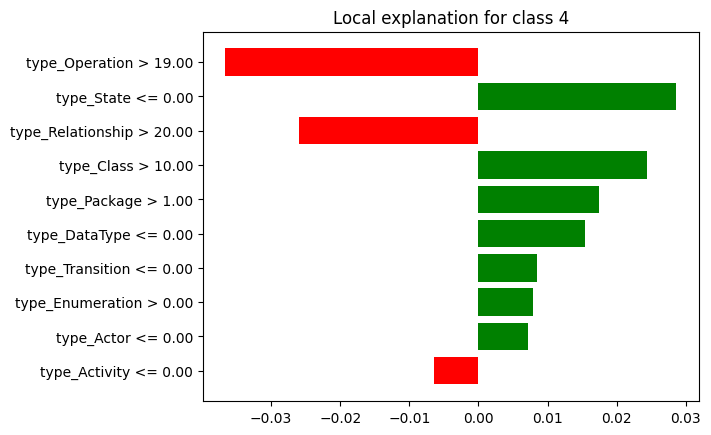

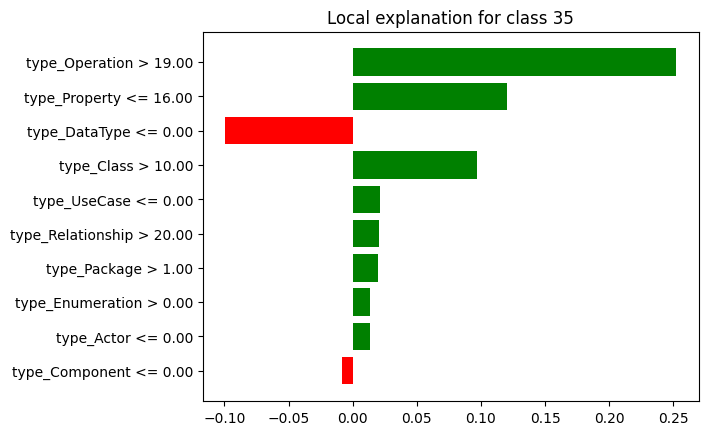

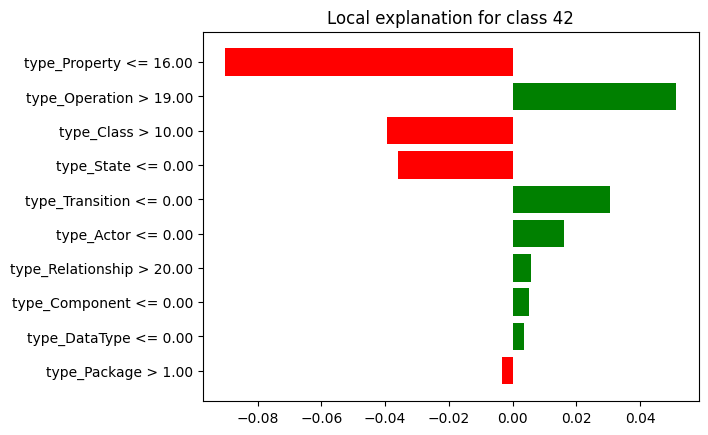

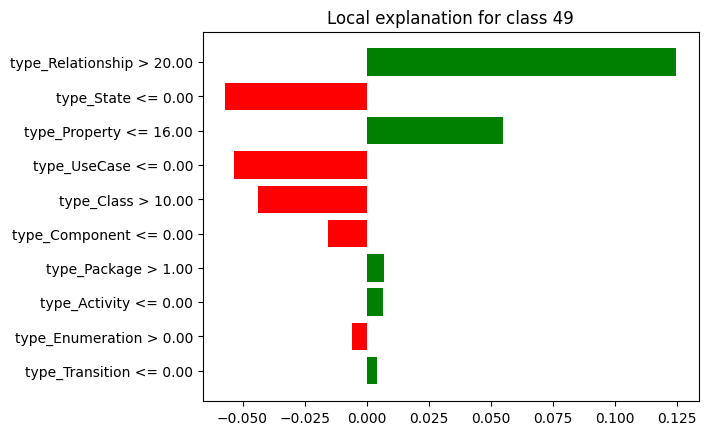

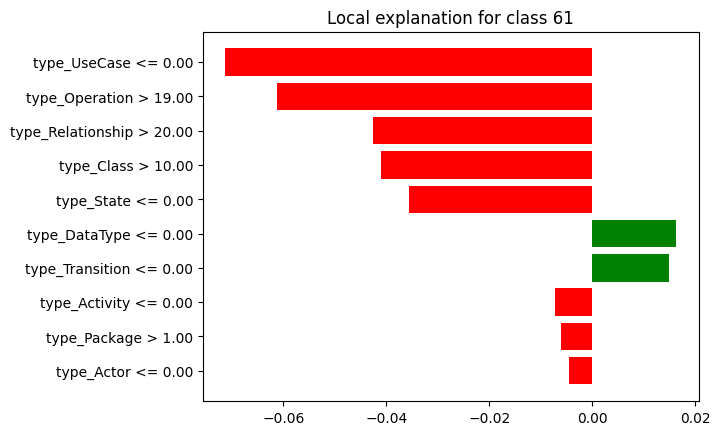

In [ ]:
for i in class_index:
  knn_exp_results['lime_computervideogames'][i].plot()

In [ ]:
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(index=[0, 14])
breakdown_df_computervideogames_ban['sign'] = breakdown_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_ban = shap_df_computervideogames_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_ban = shap_df_computervideogames_ban.tail(13)
shap_df_computervideogames_ban['sign'] = shap_df_computervideogames_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_ban = shap_df_computervideogames_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_ban["Feature"] = lime_df_computervideogames_ban["variable"].str.split(" ").str[0]
lime_df_computervideogames_ban["Sign"] = lime_df_computervideogames_ban["effect"].apply(evaluate_value)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['variable'])


breakdown_df_computervideogames_ban['Ranking'] = breakdown_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_ban['Ranking'] = shap_df_computervideogames_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_ban = shap_df_computervideogames_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_ban['Ranking'] = lime_df_computervideogames_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_ban = lime_df_computervideogames_ban.head(10)
lime_df_computervideogames_ban = lime_df_computervideogames_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.drop(columns=['contribution'])
shap_df_computervideogames_ban = shap_df_computervideogames_ban.drop(columns=['contribution'])
lime_df_computervideogames_ban = lime_df_computervideogames_ban.drop(columns=['effect'])


breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.head(10)
breakdown_df_computervideogames_ban = breakdown_df_computervideogames_ban.reset_index(drop=True)

shap_df_computervideogames_ban= shap_df_computervideogames_ban.head(10)
shap_df_computervideogames_ban = shap_df_computervideogames_ban.reset_index(drop=True)

lime_df_computervideogames_ban = lime_df_computervideogames_ban.reset_index(drop=True)

print(breakdown_df_computervideogames_ban)
print("---------------------------------")
print(shap_df_computervideogames_ban)
print("---------------------------------")
print(lime_df_computervideogames_ban)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Positive
2  type_Relationship        3  Negative
3      type_DataType        4  Positive
4       type_Package        5  Negative
5       type_UseCase        6  Negative
6         type_Actor        7  Positive
7      type_Activity        8  Positive
8   type_Enumeration        9  Positive
9         type_State       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Negative
2  type_Relationship        3  Negative
3       type_Package        4  Negative
4      type_DataType        5  Positive
5   type_Enumeration        6  Positive
6         type_Class        7  Negative
7         type_Actor        8  Positive
8     type_Component        9  Positive
9       type_UseCase       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_ban['Feature'])
shap_features = list(shap_df_computervideogames_ban['Feature'])
lime_features = list(lime_df_computervideogames_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_ban['Feature'] = list(all_features)
df_final_vid_ban= df_final_vid_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_ban['Feature']:

    breakdown_row = breakdown_df_computervideogames_ban[breakdown_df_computervideogames_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_ban[shap_df_computervideogames_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_ban[lime_df_computervideogames_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_ban.loc[df_final_vid_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_ban = df_final_vid_ban.loc[casos_validos]
df_final_vid_ban.set_index('Feature', inplace=True)
df_final_vid_ban

['type_Property', 'type_Class', 'type_Relationship', 'type_DataType', 'type_Package', 'type_UseCase', 'type_Actor', 'type_Activity', 'type_Enumeration', 'type_State']
['type_Operation', 'type_Property', 'type_Relationship', 'type_Package', 'type_DataType', 'type_Enumeration', 'type_Class', 'type_Actor', 'type_Component', 'type_UseCase']
['type_Operation', 'type_State', 'type_Relationship', 'type_Class', 'type_Package', 'type_DataType', 'type_Transition', 'type_Enumeration', 'type_Actor', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       -         -
type_Class                2  Positive       7  Negative       4  Positive
type_Relationship         3  Negative       3  Negative       3  Negative
type_DataType             4  Positive       5  Positive       6  Positive
type_Package              5  Negative       4  Negative       5  Positive
type_UseCase              6  Negative      10  Positive       -         -
type_Actor                7  Positive       8  Positive       9  Positive
type_Activity             8  Positive       -         -      10  Negative
type_Enumeration          9  Positive       6  Positive       8  Positive
type_State               10  Positive       -         -       2  Positive
type_Operation            -         -       1  Negative       1  Negative
type_Component            -         -       9  Positive       -         -
type_Transition           -         -       -         -       7  Positive

In [ ]:
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(index=[0, 14])
breakdown_df_computervideogames_vid['sign'] = breakdown_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_vid = shap_df_computervideogames_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_vid = shap_df_computervideogames_vid.tail(13)
shap_df_computervideogames_vid['sign'] = shap_df_computervideogames_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_vid = shap_df_computervideogames_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_vid["Feature"] = lime_df_computervideogames_vid["variable"].str.split(" ").str[0]
lime_df_computervideogames_vid["Sign"] = lime_df_computervideogames_vid["effect"].apply(evaluate_value)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['variable'])


breakdown_df_computervideogames_vid['Ranking'] = breakdown_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_vid['Ranking'] = shap_df_computervideogames_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_vid = shap_df_computervideogames_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_vid['Ranking'] = lime_df_computervideogames_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_vid = lime_df_computervideogames_vid.head(10)
lime_df_computervideogames_vid = lime_df_computervideogames_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.drop(columns=['contribution'])
shap_df_computervideogames_vid = shap_df_computervideogames_vid.drop(columns=['contribution'])
lime_df_computervideogames_vid = lime_df_computervideogames_vid.drop(columns=['effect'])


breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.head(10)
breakdown_df_computervideogames_vid = breakdown_df_computervideogames_vid.reset_index(drop=True)

shap_df_computervideogames_vid= shap_df_computervideogames_vid.head(10)
shap_df_computervideogames_vid = shap_df_computervideogames_vid.reset_index(drop=True)

lime_df_computervideogames_vid = lime_df_computervideogames_vid.reset_index(drop=True)

print(breakdown_df_computervideogames_vid)
print("---------------------------------")
print(shap_df_computervideogames_vid)
print("---------------------------------")
print(lime_df_computervideogames_vid)

             Feature  Ranking      Sign
0      type_Property        1  Positive
1     type_Operation        2  Positive
2  type_Relationship        3  Positive
3       type_Package        4  Positive
4       type_UseCase        5  Positive
5         type_Class        9      Null
6         type_Actor        9      Null
7    type_Transition        9      Null
8         type_State        9      Null
9   type_Enumeration        9      Null
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1      type_Property        2  Positive
2         type_Class        3  Positive
3  type_Relationship        4  Positive
4   type_Enumeration        5  Positive
5       type_UseCase        6  Positive
6       type_Package        7  Positive
7      type_DataType        8  Negative
8         type_Actor        9  Positive
9    type_Transition       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_vid['Feature'])
shap_features = list(shap_df_computervideogames_vid['Feature'])
lime_features = list(lime_df_computervideogames_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_vid['Feature'] = list(all_features)
df_final_vid_vid= df_final_vid_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_vid['Feature']:

    breakdown_row = breakdown_df_computervideogames_vid[breakdown_df_computervideogames_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_vid[shap_df_computervideogames_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_vid[lime_df_computervideogames_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_vid.loc[df_final_vid_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_vid = df_final_vid_vid.loc[casos_validos]
df_final_vid_vid.set_index('Feature', inplace=True)
df_final_vid_vid

['type_Property', 'type_Operation', 'type_Relationship', 'type_Package', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Transition', 'type_State', 'type_Enumeration']
['type_Operation', 'type_Property', 'type_Class', 'type_Relationship', 'type_Enumeration', 'type_UseCase', 'type_Package', 'type_DataType', 'type_Actor', 'type_Transition']
['type_Operation', 'type_Property', 'type_DataType', 'type_Class', 'type_UseCase', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_Actor', 'type_Component']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Positive       2  Positive       2  Positive
type_Operation            2  Positive       1  Positive       1  Positive
type_Relationship         3  Positive       4  Positive       6  Positive
type_Package              4  Positive       7  Positive       7  Positive
type_UseCase              5  Positive       6  Positive       5  Positive
type_Enumeration          9      Null       5  Positive       8  Positive
type_Transition           9      Null      10  Positive       -         -
type_State                9      Null       -         -       -         -
type_Class                9      Null       3  Positive       4  Positive
type_Actor                9      Null       9  Positive       9  Positive
type_DataType             -         -       8  Negative       3  Negative
type_Component            -         -       -         -      10  Negative

In [ ]:
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(index=[0, 14])
breakdown_df_computervideogames_cou['sign'] = breakdown_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_cou = shap_df_computervideogames_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_cou = shap_df_computervideogames_cou.tail(13)
shap_df_computervideogames_cou['sign'] = shap_df_computervideogames_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_cou = shap_df_computervideogames_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_cou["Feature"] = lime_df_computervideogames_cou["variable"].str.split(" ").str[0]
lime_df_computervideogames_cou["Sign"] = lime_df_computervideogames_cou["effect"].apply(evaluate_value)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['variable'])


breakdown_df_computervideogames_cou['Ranking'] = breakdown_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_cou['Ranking'] = shap_df_computervideogames_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_cou = shap_df_computervideogames_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_cou['Ranking'] = lime_df_computervideogames_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_cou = lime_df_computervideogames_cou.head(10)
lime_df_computervideogames_cou = lime_df_computervideogames_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.drop(columns=['contribution'])
shap_df_computervideogames_cou = shap_df_computervideogames_cou.drop(columns=['contribution'])
lime_df_computervideogames_cou = lime_df_computervideogames_cou.drop(columns=['effect'])


breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.head(10)
breakdown_df_computervideogames_cou = breakdown_df_computervideogames_cou.reset_index(drop=True)

shap_df_computervideogames_cou= shap_df_computervideogames_cou.head(10)
shap_df_computervideogames_cou = shap_df_computervideogames_cou.reset_index(drop=True)

lime_df_computervideogames_cou = lime_df_computervideogames_cou.reset_index(drop=True)

print(breakdown_df_computervideogames_cou)
print("---------------------------------")
print(shap_df_computervideogames_cou)
print("---------------------------------")
print(lime_df_computervideogames_cou)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1  type_Relationship        2  Negative
2         type_Class        3  Negative
3       type_Package        4  Negative
4      type_Property        5  Negative
5      type_DataType        6  Positive
6         type_Actor        7  Positive
7   type_Enumeration        8  Positive
8       type_UseCase        9  Positive
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1      type_Property        2  Negative
2  type_Relationship        3  Negative
3         type_Class        4  Negative
4   type_Enumeration        5  Negative
5       type_UseCase        6  Negative
6      type_Activity        7  Negative
7      type_DataType        8  Positive
8       type_Package        9  Positive
9     type_Component       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_cou['Feature'])
shap_features = list(shap_df_computervideogames_cou['Feature'])
lime_features = list(lime_df_computervideogames_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_cou['Feature'] = list(all_features)
df_final_vid_cou= df_final_vid_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_cou['Feature']:

    breakdown_row = breakdown_df_computervideogames_cou[breakdown_df_computervideogames_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_cou[shap_df_computervideogames_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_cou[lime_df_computervideogames_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_cou.loc[df_final_vid_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_cou = df_final_vid_cou.loc[casos_validos]
df_final_vid_cou.set_index('Feature', inplace=True)
df_final_vid_cou

['type_Operation', 'type_Relationship', 'type_Class', 'type_Package', 'type_Property', 'type_DataType', 'type_Actor', 'type_Enumeration', 'type_UseCase', 'type_Component']
['type_Operation', 'type_Property', 'type_Relationship', 'type_Class', 'type_Enumeration', 'type_UseCase', 'type_Activity', 'type_DataType', 'type_Package', 'type_Component']
['type_Property', 'type_Operation', 'type_Class', 'type_State', 'type_Transition', 'type_Actor', 'type_Relationship', 'type_Component', 'type_DataType', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       1  Positive       2  Positive
type_Relationship         2  Negative       3  Negative       7  Positive
type_Class                3  Negative       4  Negative       3  Negative
type_Package              4  Negative       9  Positive      10  Negative
type_Property             5  Negative       2  Negative       1  Negative
type_DataType             6  Positive       8  Positive       9  Positive
type_Actor                7  Positive       -         -       6  Positive
type_Enumeration          8  Positive       5  Negative       -         -
type_UseCase              9  Positive       6  Negative       -         -
type_Component           10  Positive      10  Positive       8  Positive
type_Activity             -         -       7  Negative       -         -
type_State                -         -       -         -       4  Negative
type_Transition           -         -       -         -       5  Positive

In [ ]:
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(index=[0, 14])
breakdown_df_computervideogames_emp['sign'] = breakdown_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_emp = shap_df_computervideogames_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_emp = shap_df_computervideogames_emp.tail(13)
shap_df_computervideogames_emp['sign'] = shap_df_computervideogames_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_emp = shap_df_computervideogames_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_emp["Feature"] = lime_df_computervideogames_emp["variable"].str.split(" ").str[0]
lime_df_computervideogames_emp["Sign"] = lime_df_computervideogames_emp["effect"].apply(evaluate_value)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['variable'])


breakdown_df_computervideogames_emp['Ranking'] = breakdown_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_emp['Ranking'] = shap_df_computervideogames_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_emp = shap_df_computervideogames_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_emp['Ranking'] = lime_df_computervideogames_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_emp = lime_df_computervideogames_emp.head(10)
lime_df_computervideogames_emp = lime_df_computervideogames_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.drop(columns=['contribution'])
shap_df_computervideogames_emp = shap_df_computervideogames_emp.drop(columns=['contribution'])
lime_df_computervideogames_emp = lime_df_computervideogames_emp.drop(columns=['effect'])


breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.head(10)
breakdown_df_computervideogames_emp = breakdown_df_computervideogames_emp.reset_index(drop=True)

shap_df_computervideogames_emp= shap_df_computervideogames_emp.head(10)
shap_df_computervideogames_emp = shap_df_computervideogames_emp.reset_index(drop=True)

lime_df_computervideogames_emp = lime_df_computervideogames_emp.reset_index(drop=True)

print(breakdown_df_computervideogames_emp)
print("---------------------------------")
print(shap_df_computervideogames_emp)
print("---------------------------------")
print(lime_df_computervideogames_emp)

             Feature  Ranking      Sign
0         type_Class        1  Negative
1       type_Package        2  Positive
2  type_Relationship        3  Positive
3       type_UseCase        4  Negative
4      type_Activity        5  Positive
5     type_Component        6  Negative
6         type_Actor        7  Positive
7      type_Property        8  Negative
8   type_Enumeration        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Negative
2         type_Class        3  Negative
3  type_Relationship        4  Positive
4       type_UseCase        5  Negative
5       type_Package        6  Positive
6      type_Activity        7  Positive
7     type_Component        8  Negative
8         type_Actor        9  Positive
9   type_Enumeration       10  Negative
---------------------------------
             Feature  Ranking      Sign
0  type_Rela

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_emp['Feature'])
shap_features = list(shap_df_computervideogames_emp['Feature'])
lime_features = list(lime_df_computervideogames_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_emp['Feature'] = list(all_features)
df_final_vid_emp= df_final_vid_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_emp['Feature']:

    breakdown_row = breakdown_df_computervideogames_emp[breakdown_df_computervideogames_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_emp[shap_df_computervideogames_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_emp[lime_df_computervideogames_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_emp.loc[df_final_vid_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_emp = df_final_vid_emp.loc[casos_validos]
df_final_vid_emp.set_index('Feature', inplace=True)
df_final_vid_emp

['type_Class', 'type_Package', 'type_Relationship', 'type_UseCase', 'type_Activity', 'type_Component', 'type_Actor', 'type_Property', 'type_Enumeration', 'type_DataType']
['type_Operation', 'type_Property', 'type_Class', 'type_Relationship', 'type_UseCase', 'type_Package', 'type_Activity', 'type_Component', 'type_Actor', 'type_Enumeration']
['type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_Class', 'type_Component', 'type_Package', 'type_Activity', 'type_Enumeration', 'type_Transition']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Negative       3  Negative       5  Negative
type_Package              2  Positive       6  Positive       7  Positive
type_Relationship         3  Positive       4  Positive       1  Positive
type_UseCase              4  Negative       5  Negative       4  Negative
type_Activity             5  Positive       7  Positive       8  Positive
type_Component            6  Negative       8  Negative       6  Negative
type_Actor                7  Positive       9  Positive       -         -
type_Property             8  Negative       2  Negative       3  Positive
type_Enumeration          9  Negative      10  Negative       9  Negative
type_DataType            10  Negative       -         -       -         -
type_Operation            -         -       1  Negative       -         -
type_State                -         -       -         -       2  Negative
type_Transition           -         -       -         -      10  Positive

In [ ]:
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(index=[0, 14])
breakdown_df_computervideogames_lib['sign'] = breakdown_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_computervideogames_lib = shap_df_computervideogames_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_computervideogames_lib = shap_df_computervideogames_lib.tail(13)
shap_df_computervideogames_lib['sign'] = shap_df_computervideogames_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_computervideogames_lib = shap_df_computervideogames_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_computervideogames_lib["Feature"] = lime_df_computervideogames_lib["variable"].str.split(" ").str[0]
lime_df_computervideogames_lib["Sign"] = lime_df_computervideogames_lib["effect"].apply(evaluate_value)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['variable'])


breakdown_df_computervideogames_lib['Ranking'] = breakdown_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_computervideogames_lib['Ranking'] = shap_df_computervideogames_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_computervideogames_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_computervideogames_lib = shap_df_computervideogames_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_computervideogames_lib['Ranking'] = lime_df_computervideogames_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_computervideogames_lib = lime_df_computervideogames_lib.head(10)
lime_df_computervideogames_lib = lime_df_computervideogames_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.drop(columns=['contribution'])
shap_df_computervideogames_lib = shap_df_computervideogames_lib.drop(columns=['contribution'])
lime_df_computervideogames_lib = lime_df_computervideogames_lib.drop(columns=['effect'])


breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.head(10)
breakdown_df_computervideogames_lib = breakdown_df_computervideogames_lib.reset_index(drop=True)

shap_df_computervideogames_lib= shap_df_computervideogames_lib.head(10)
shap_df_computervideogames_lib = shap_df_computervideogames_lib.reset_index(drop=True)

lime_df_computervideogames_lib = lime_df_computervideogames_lib.reset_index(drop=True)

print(breakdown_df_computervideogames_lib)
print("---------------------------------")
print(shap_df_computervideogames_lib)
print("---------------------------------")
print(lime_df_computervideogames_lib)

             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1      type_Property        2  Negative
2         type_Class        3  Negative
3  type_Relationship        4  Negative
4         type_Actor        5  Positive
5     type_Component        6  Negative
6      type_Activity        7  Positive
7       type_Package        8  Negative
8    type_Transition        9  Negative
9         type_State       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1  type_Relationship        2  Negative
2       type_UseCase        3  Negative
3         type_Class        4  Negative
4     type_Component        5  Negative
5         type_Actor        6  Positive
6      type_Property        7  Positive
7      type_DataType        8  Positive
8   type_Enumeration        9  Positive
9         type_State       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_computervideogames_lib['Feature'])
shap_features = list(shap_df_computervideogames_lib['Feature'])
lime_features = list(lime_df_computervideogames_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_vid_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_vid_lib['Feature'] = list(all_features)
df_final_vid_lib= df_final_vid_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_vid_lib['Feature']:

    breakdown_row = breakdown_df_computervideogames_lib[breakdown_df_computervideogames_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_computervideogames_lib[shap_df_computervideogames_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_computervideogames_lib[lime_df_computervideogames_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_vid_lib.loc[df_final_vid_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_vid_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_vid_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_vid_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_vid_lib = df_final_vid_lib.loc[casos_validos]
df_final_vid_lib.set_index('Feature', inplace=True)
df_final_vid_lib

['type_UseCase', 'type_Property', 'type_Class', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Activity', 'type_Package', 'type_Transition', 'type_State']
['type_Operation', 'type_Relationship', 'type_UseCase', 'type_Class', 'type_Component', 'type_Actor', 'type_Property', 'type_DataType', 'type_Enumeration', 'type_State']
['type_UseCase', 'type_Operation', 'type_Relationship', 'type_Class', 'type_State', 'type_DataType', 'type_Transition', 'type_Activity', 'type_Package', 'type_Actor']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Negative       3  Negative       1  Negative
type_Property             2  Negative       7  Positive       -         -
type_Class                3  Negative       4  Negative       4  Negative
type_Relationship         4  Negative       2  Negative       3  Negative
type_Actor                5  Positive       6  Positive      10  Negative
type_Component            6  Negative       5  Negative       -         -
type_Activity             7  Positive       -         -       8  Negative
type_Package              8  Negative       -         -       9  Negative
type_Transition           9  Negative       -         -       7  Positive
type_State               10  Negative      10  Negative       5  Negative
type_Enumeration          -         -       9  Positive       -         -
type_Operation            -         -       1  Negative       2  Negative
type_DataType             -         -       8  Positive       6  Positive

### **Results Computer-Videogames:**

In [ ]:
df_topfeatures_vid_ban = top5_features(df_final_vid_ban, 'ComputerVideogames - Class: Bank')
df_topfeatures_vid_vid = top5_features(df_final_vid_vid, 'ComputerVideogames - Class: ComputerVideogames')
df_topfeatures_vid_cou = top5_features(df_final_vid_cou, 'ComputerVideogames - Class: Course')
df_topfeatures_vid_emp = top5_features(df_final_vid_emp, 'ComputerVideogames - Class: Employee')
df_topfeatures_vid_lib = top5_features(df_final_vid_lib, 'ComputerVideogames - Class: Library')

df_topfeatures_computervideogames = pd.concat([df_topfeatures_vid_ban, df_topfeatures_vid_vid, df_topfeatures_vid_cou, df_topfeatures_vid_emp, df_topfeatures_vid_lib])
df_topfeatures_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class: Bank                type_Package, type_Class, type_DataType, type_...   
ComputerVideogames - Class: ComputerVideogames  type_Package, type_UseCase, type_Property, typ...   
ComputerVideogames - Class: Course              type_Package, type_Class, type_Property, type_...   
ComputerVideogames - Class: Employee            type_Package, type_Class, type_UseCase, type_R...   
ComputerVideogames - Class: Library             type_Actor, type_Class, type_UseCase, type_Pro...   

                                                                                        TOP5 Shap  \
ComputerVideogames - Class: Bank                type_Package, type_DataType, type_Property, ty...   
ComputerVideogames - Class: ComputerVideogames  type_Class, type_Property, type_Relationship, ...   
ComputerVideogames - Class: Course              type_Class, type_Property, type_Relationship, ...   
ComputerVideogames - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
ComputerVideogames - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                                                                        TOP5 Lime  \
ComputerVideogames - Class: Bank                type_Package, type_Class, type_State, type_Rel...   
ComputerVideogames - Class: ComputerVideogames  type_Class, type_DataType, type_UseCase, type_...   
ComputerVideogames - Class: Course              type_Class, type_Property, type_State, type_Op...   
ComputerVideogames - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
ComputerVideogames - Class: Library             type_Class, type_UseCase, type_State, type_Rel...   

                                                Breakdown-Shap  \
ComputerVideogames - Class: Bank                           0.8   
ComputerVideogames - Class: ComputerVideogames             0.6   
ComputerVideogames - Class: Course                         0.8   
ComputerVideogames - Class: Employee                       0.6   
ComputerVideogames - Class: Library                        0.6   

                                                Breakdown-Lime  Lime-Shap  
ComputerVideogames - Class: Bank                           0.6        0.6  
ComputerVideogames - Class: ComputerVideogames             0.6        0.6  
ComputerVideogames - Class: Course                         0.6        0.6  
ComputerVideogames - Class: Employee                       0.6        0.8  
ComputerVideogames - Class: Library                        0.6        0.8

In [ ]:
df_topfeatures_vid_ban_rank = top5_rank(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank = top5_rank(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank = top5_rank(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank = top5_rank(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank = top5_rank(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_computervideogames = pd.concat([df_topfeatures_vid_ban_rank, df_topfeatures_vid_vid_rank, df_topfeatures_vid_cou_rank, df_topfeatures_vid_emp_rank, df_topfeatures_vid_lib_rank])
df_topfeatures_rank_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Property, 2:type_Class, 3:type_Relation...   
ComputerVideogames - Class ComputerVideogames  1:type_Property, 2:type_Operation, 3:type_Rela...   
ComputerVideogames - Class Course              1:type_Operation, 2:type_Relationship, 3:type_...   
ComputerVideogames - Class Employee            1:type_Class, 2:type_Package, 3:type_Relations...   
ComputerVideogames - Class Library             1:type_UseCase, 2:type_Property, 3:type_Class,...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                2:type_Property, 3:type_Relationship, 5:type_D...   
ComputerVideogames - Class ComputerVideogames  2:type_Property, 1:type_Operation, 4:type_Rela...   
ComputerVideogames - Class Course              1:type_Operation, 3:type_Relationship, 4:type_...   
ComputerVideogames - Class Employee            3:type_Class, 4:type_Relationship, 5:type_UseC...   
ComputerVideogames - Class Library             3:type_UseCase, 4:type_Class, 2:type_Relations...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                4:type_Class, 3:type_Relationship, 5:type_Pack...   
ComputerVideogames - Class ComputerVideogames  2:type_Property, 1:type_Operation, 5:type_UseC...   
ComputerVideogames - Class Course              2:type_Operation, 3:type_Class, 1:type_Propert...   
ComputerVideogames - Class Employee            5:type_Class, 1:type_Relationship, 4:type_UseC...   
ComputerVideogames - Class Library             1:type_UseCase, 4:type_Class, 3:type_Relations...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.2             0.4   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.2             0.2   
ComputerVideogames - Class Employee                       0.0             0.2   
ComputerVideogames - Class Library                        0.0             0.2   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.4  
ComputerVideogames - Class ComputerVideogames        0.4  
ComputerVideogames - Class Course                    0.0  
ComputerVideogames - Class Employee                  0.0  
ComputerVideogames - Class Library                   0.2

In [ ]:
df_topfeatures_vid_ban_sign = top5_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_sign = top5_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_sign = top5_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_sign = top5_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_sign = top5_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_sign, df_topfeatures_vid_vid_sign, df_topfeatures_vid_cou_sign, df_topfeatures_vid_emp_sign, df_topfeatures_vid_lib_sign])
df_topfeatures_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                type_Property:Negative, type_Class:Positive, t...   
ComputerVideogames - Class ComputerVideogames  type_Property:Positive, type_Operation:Positiv...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Relationship:Neg...   
ComputerVideogames - Class Employee            type_Class:Negative, type_Package:Positive, ty...   
ComputerVideogames - Class Library             type_UseCase:Negative, type_Property:Negative,...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                type_Property:Negative, type_Relationship:Nega...   
ComputerVideogames - Class ComputerVideogames  type_Property:Positive, type_Operation:Positiv...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Relationship:Neg...   
ComputerVideogames - Class Employee            type_Class:Negative, type_Relationship:Positiv...   
ComputerVideogames - Class Library             type_UseCase:Negative, type_Class:Negative, ty...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                type_Class:Positive, type_Relationship:Negativ...   
ComputerVideogames - Class ComputerVideogames  type_Property:Positive, type_Operation:Positiv...   
ComputerVideogames - Class Course              type_Operation:Positive, type_Class:Negative, ...   
ComputerVideogames - Class Employee            type_Class:Negative, type_Relationship:Positiv...   
ComputerVideogames - Class Library             type_UseCase:Negative, type_Class:Negative, ty...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.8             0.4   
ComputerVideogames - Class ComputerVideogames             0.6             0.6   
ComputerVideogames - Class Course                         0.8             0.6   
ComputerVideogames - Class Employee                       0.6             0.6   
ComputerVideogames - Class Library                        0.6             0.6   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.4  
ComputerVideogames - Class ComputerVideogames        0.6  
ComputerVideogames - Class Course                    0.6  
ComputerVideogames - Class Employee                  0.6  
ComputerVideogames - Class Library                   0.8

In [ ]:
df_topfeatures_vid_ban_rank_sign = top5_rank_sign(df_final_vid_ban, 'ComputerVideogames - Class Bank')
df_topfeatures_vid_vid_rank_sign = top5_rank_sign(df_final_vid_vid, 'ComputerVideogames - Class ComputerVideogames')
df_topfeatures_vid_cou_rank_sign = top5_rank_sign(df_final_vid_cou, 'ComputerVideogames - Class Course')
df_topfeatures_vid_emp_rank_sign = top5_rank_sign(df_final_vid_emp, 'ComputerVideogames - Class Employee')
df_topfeatures_vid_lib_rank_sign = top5_rank_sign(df_final_vid_lib, 'ComputerVideogames - Class Library')

df_topfeatures_rank_sign_computervideogames = pd.concat([df_topfeatures_vid_ban_rank_sign, df_topfeatures_vid_vid_rank_sign, df_topfeatures_vid_cou_rank_sign, df_topfeatures_vid_emp_rank_sign, df_topfeatures_vid_lib_rank_sign])
df_topfeatures_rank_sign_computervideogames

TOP5 Breakdown  \
ComputerVideogames - Class Bank                1:type_Property:Negative, 2:type_Class:Positiv...   
ComputerVideogames - Class ComputerVideogames  1:type_Property:Positive, 2:type_Operation:Pos...   
ComputerVideogames - Class Course              1:type_Operation:Positive, 2:type_Relationship...   
ComputerVideogames - Class Employee            1:type_Class:Negative, 2:type_Package:Positive...   
ComputerVideogames - Class Library             1:type_UseCase:Negative, 2:type_Property:Negat...   

                                                                                       TOP5 Shap  \
ComputerVideogames - Class Bank                2:type_Property:Negative, 3:type_Relationship:...   
ComputerVideogames - Class ComputerVideogames  2:type_Property:Positive, 1:type_Operation:Pos...   
ComputerVideogames - Class Course              1:type_Operation:Positive, 3:type_Relationship...   
ComputerVideogames - Class Employee            3:type_Class:Negative, 4:type_Relationship:Pos...   
ComputerVideogames - Class Library             3:type_UseCase:Negative, 4:type_Class:Negative...   

                                                                                       TOP5 Lime  \
ComputerVideogames - Class Bank                4:type_Class:Positive, 3:type_Relationship:Neg...   
ComputerVideogames - Class ComputerVideogames  2:type_Property:Positive, 1:type_Operation:Pos...   
ComputerVideogames - Class Course              2:type_Operation:Positive, 3:type_Class:Negati...   
ComputerVideogames - Class Employee            5:type_Class:Negative, 1:type_Relationship:Pos...   
ComputerVideogames - Class Library             1:type_UseCase:Negative, 4:type_Class:Negative...   

                                               Breakdown-Shap  Breakdown-Lime  \
ComputerVideogames - Class Bank                           0.2             0.2   
ComputerVideogames - Class ComputerVideogames             0.0             0.2   
ComputerVideogames - Class Course                         0.2             0.2   
ComputerVideogames - Class Employee                       0.0             0.2   
ComputerVideogames - Class Library                        0.0             0.2   

                                               Lime-Shap  
ComputerVideogames - Class Bank                      0.4  
ComputerVideogames - Class ComputerVideogames        0.4  
ComputerVideogames - Class Course                    0.0  
ComputerVideogames - Class Employee                  0.0  
ComputerVideogames - Class Library                   0.2

### **Course:**

In [ ]:
breakdown_df_course_ban = knn_exp_results['breakdown_course'][0].result
shap_df_course_ban = knn_exp_results['shap_course'][0].result
lime_df_course_ban = knn_exp_results['lime_course'][0].result

In [ ]:
breakdown_df_course_vid = knn_exp_results['breakdown_course'][1].result
shap_df_course_vid = knn_exp_results['shap_course'][1].result
lime_df_course_vid = knn_exp_results['lime_course'][1].result

In [ ]:
breakdown_df_course_cou = knn_exp_results['breakdown_course'][3].result
shap_df_course_cou = knn_exp_results['shap_course'][3].result
lime_df_course_cou = knn_exp_results['lime_course'][3].result

In [ ]:
breakdown_df_course_emp = knn_exp_results['breakdown_course'][4].result
shap_df_course_emp = knn_exp_results['shap_course'][4].result
lime_df_course_emp = knn_exp_results['lime_course'][4].result

In [ ]:
breakdown_df_course_lib = knn_exp_results['breakdown_course'][6].result
shap_df_course_lib = knn_exp_results['shap_course'][6].result
lime_df_course_lib = knn_exp_results['lime_course'][6].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_course'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_course'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

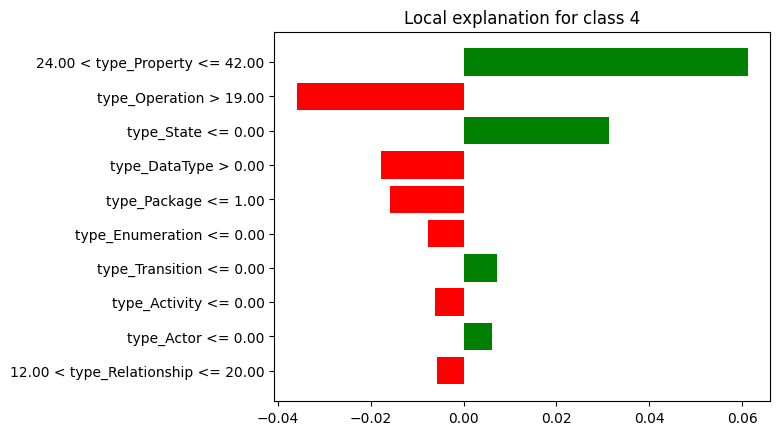

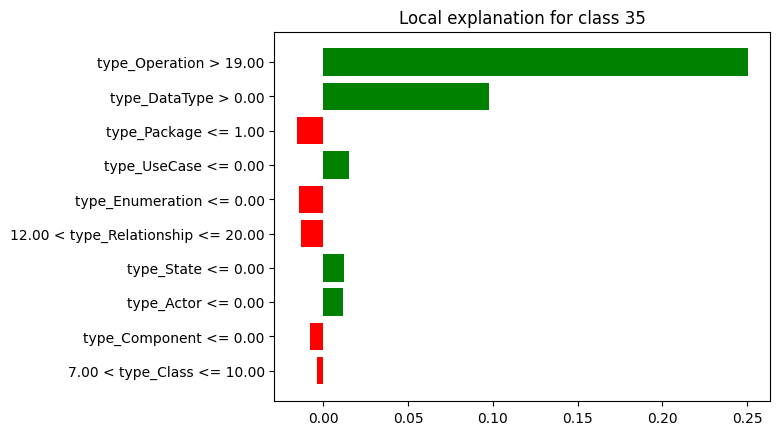

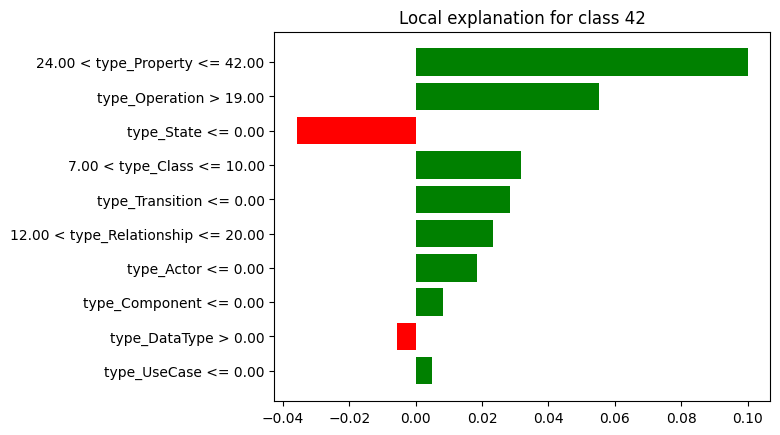

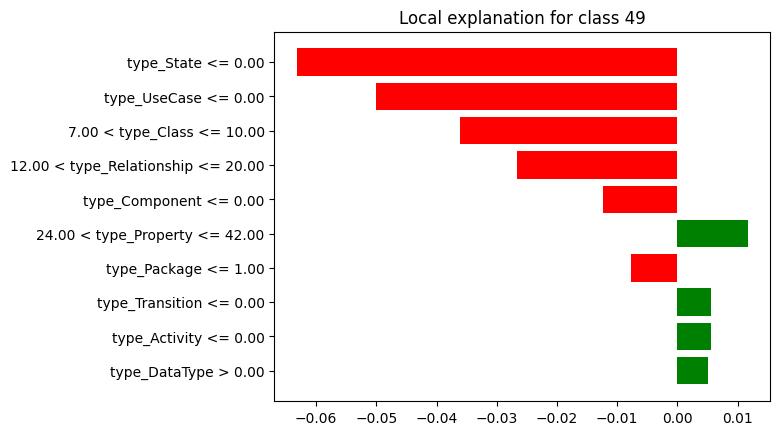

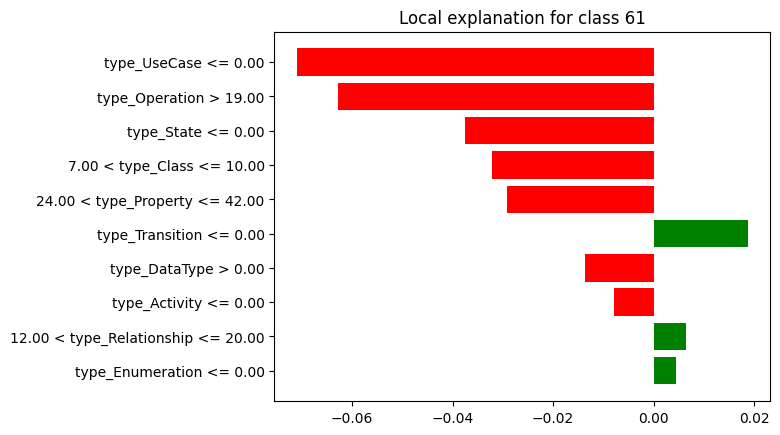

In [ ]:
for i in class_index:
  knn_exp_results['lime_course'][i].plot()

In [ ]:
breakdown_df_course_ban = breakdown_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_ban = breakdown_df_course_ban.drop(index=[0, 14])
breakdown_df_course_ban['sign'] = breakdown_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_ban = breakdown_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_ban = shap_df_course_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_ban = shap_df_course_ban.tail(13)
shap_df_course_ban['sign'] = shap_df_course_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_ban = shap_df_course_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_ban["Feature"] = lime_df_course_ban["variable"].str.split(" ").str[0]
lime_df_course_ban["Sign"] = lime_df_course_ban["effect"].apply(evaluate_value)
lime_df_course_ban = lime_df_course_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_ban = lime_df_course_ban.drop(columns=['variable'])


breakdown_df_course_ban['Ranking'] = breakdown_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_ban = breakdown_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_ban['Ranking'] = shap_df_course_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_ban = shap_df_course_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_ban['Ranking'] = lime_df_course_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_ban = lime_df_course_ban.head(10)
lime_df_course_ban = lime_df_course_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_ban = breakdown_df_course_ban.drop(columns=['contribution'])
shap_df_course_ban = shap_df_course_ban.drop(columns=['contribution'])
lime_df_course_ban = lime_df_course_ban.drop(columns=['effect'])


breakdown_df_course_ban = breakdown_df_course_ban.head(10)
breakdown_df_course_ban = breakdown_df_course_ban.reset_index(drop=True)

shap_df_course_ban= shap_df_course_ban.head(10)
shap_df_course_ban = shap_df_course_ban.reset_index(drop=True)

lime_df_course_ban = lime_df_course_ban.reset_index(drop=True)
lime_df_course_ban.at[0, "Feature"] = "type_Property"
lime_df_course_ban.at[9, "Feature"] = "type_Relationship"

print(breakdown_df_course_ban)
print("---------------------------------")
print(shap_df_course_ban)
print("---------------------------------")
print(lime_df_course_ban)

             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1         type_Class        2  Positive
2     type_Operation        3  Negative
3      type_DataType        4  Negative
4      type_Property        5  Negative
5       type_UseCase        6  Negative
6       type_Package        7  Negative
7      type_Activity        8  Positive
8     type_Component        9  Positive
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1     type_Operation        2  Negative
2      type_Property        3  Positive
3      type_DataType        4  Negative
4   type_Enumeration        5  Negative
5         type_Class        6  Positive
6       type_Package        7  Negative
7      type_Activity        8  Positive
8         type_Actor        9  Positive
9       type_UseCase       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_course_ban['Feature'])
shap_features = list(shap_df_course_ban['Feature'])
lime_features = list(lime_df_course_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_ban['Feature'] = list(all_features)
df_final_cou_ban= df_final_cou_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_ban['Feature']:

    breakdown_row = breakdown_df_course_ban[breakdown_df_course_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_ban[shap_df_course_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_ban[lime_df_course_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_ban.loc[df_final_cou_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_ban = df_final_cou_ban.loc[casos_validos]
df_final_cou_ban.set_index('Feature', inplace=True)
df_final_cou_ban

['type_Relationship', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_UseCase', 'type_Package', 'type_Activity', 'type_Component', 'type_Actor']
['type_Relationship', 'type_Operation', 'type_Property', 'type_DataType', 'type_Enumeration', 'type_Class', 'type_Package', 'type_Activity', 'type_Actor', 'type_UseCase']
['type_Property', 'type_Operation', 'type_State', 'type_DataType', 'type_Package', 'type_Enumeration', 'type_Transition', 'type_Activity', 'type_Actor', 'type_Relationship']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       1  Negative      10  Negative
type_Class                2  Positive       6  Positive       -         -
type_Operation            3  Negative       2  Negative       2  Negative
type_DataType             4  Negative       4  Negative       4  Negative
type_Property             5  Negative       3  Positive       1  Positive
type_UseCase              6  Negative      10  Negative       -         -
type_Package              7  Negative       7  Negative       5  Negative
type_Activity             8  Positive       8  Positive       8  Negative
type_Component            9  Positive       -         -       -         -
type_Actor               10  Positive       9  Positive       9  Positive
type_Enumeration          -         -       5  Negative       6  Negative
type_State                -         -       -         -       3  Positive
type_Transition           -         -       -         -       7  Positive

In [ ]:
breakdown_df_course_vid = breakdown_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_vid = breakdown_df_course_vid.drop(index=[0, 14])
breakdown_df_course_vid['sign'] = breakdown_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_vid = breakdown_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_vid = shap_df_course_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_vid = shap_df_course_vid.tail(13)
shap_df_course_vid['sign'] = shap_df_course_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_vid = shap_df_course_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_vid["Feature"] = lime_df_course_vid["variable"].str.split(" ").str[0]
lime_df_course_vid["Sign"] = lime_df_course_vid["effect"].apply(evaluate_value)
lime_df_course_vid = lime_df_course_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_vid = lime_df_course_vid.drop(columns=['variable'])


breakdown_df_course_vid['Ranking'] = breakdown_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_vid = breakdown_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_vid['Ranking'] = shap_df_course_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_vid = shap_df_course_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_vid['Ranking'] = lime_df_course_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_vid = lime_df_course_vid.head(10)
lime_df_course_vid = lime_df_course_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_vid = breakdown_df_course_vid.drop(columns=['contribution'])
shap_df_course_vid = shap_df_course_vid.drop(columns=['contribution'])
lime_df_course_vid = lime_df_course_vid.drop(columns=['effect'])


breakdown_df_course_vid = breakdown_df_course_vid.head(10)
breakdown_df_course_vid = breakdown_df_course_vid.reset_index(drop=True)

shap_df_course_vid= shap_df_course_vid.head(10)
shap_df_course_vid = shap_df_course_vid.reset_index(drop=True)

lime_df_course_vid = lime_df_course_vid.reset_index(drop=True)
lime_df_course_vid.at[5, "Feature"] = "type_Relationship"
lime_df_course_vid.at[9, "Feature"] = "type_Class"

print(breakdown_df_course_vid)
print("---------------------------------")
print(shap_df_course_vid)
print("---------------------------------")
print(lime_df_course_vid)

             Feature  Ranking      Sign
0     type_Operation        1  Positive
1  type_Relationship        2  Negative
2      type_Property        3  Negative
3       type_UseCase        4  Negative
4         type_Class        5  Negative
5         type_Actor        9      Null
6    type_Transition        9      Null
7         type_State        9      Null
8     type_Component        9      Null
9      type_Activity        9      Null
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Negative
2     type_Operation        3  Positive
3         type_Class        4  Negative
4       type_UseCase        5  Positive
5   type_Enumeration        6  Negative
6         type_Actor        7  Positive
7       type_Package        8  Negative
8      type_Activity        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_course_vid['Feature'])
shap_features = list(shap_df_course_vid['Feature'])
lime_features = list(lime_df_course_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_vid['Feature'] = list(all_features)
df_final_cou_vid= df_final_cou_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_vid['Feature']:

    breakdown_row = breakdown_df_course_vid[breakdown_df_course_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_vid[shap_df_course_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_vid[lime_df_course_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_vid.loc[df_final_cou_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_vid = df_final_cou_vid.loc[casos_validos]
df_final_cou_vid.set_index('Feature', inplace=True)
df_final_cou_vid

['type_Operation', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Transition', 'type_State', 'type_Component', 'type_Activity']
['type_Property', 'type_Relationship', 'type_Operation', 'type_Class', 'type_UseCase', 'type_Enumeration', 'type_Actor', 'type_Package', 'type_Activity', 'type_DataType']
['type_Operation', 'type_DataType', 'type_Package', 'type_UseCase', 'type_Enumeration', 'type_Relationship', 'type_State', 'type_Actor', 'type_Component', 'type_Class']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Activity', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       3  Positive       1  Positive
type_Relationship         2  Negative       2  Negative       6  Negative
type_Property             3  Negative       1  Negative       -         -
type_UseCase              4  Negative       5  Positive       4  Positive
type_Class                5  Negative       4  Negative      10  Negative
type_Transition           9      Null       -         -       -         -
type_State                9      Null       -         -       7  Positive
type_Activity             9      Null       9  Positive       -         -
type_Actor                9      Null       7  Positive       8  Positive
type_Component            9      Null       -         -       9  Negative
type_Enumeration          -         -       6  Negative       5  Negative
type_DataType             -         -      10  Positive       2  Positive
type_Package              -         -       8  Negative       3  Negative

In [ ]:
breakdown_df_course_cou = breakdown_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_cou = breakdown_df_course_cou.drop(index=[0, 14])
breakdown_df_course_cou['sign'] = breakdown_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_cou = breakdown_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_cou = shap_df_course_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_cou = shap_df_course_cou.tail(13)
shap_df_course_cou['sign'] = shap_df_course_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_cou = shap_df_course_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_cou["Feature"] = lime_df_course_cou["variable"].str.split(" ").str[0]
lime_df_course_cou["Sign"] = lime_df_course_cou["effect"].apply(evaluate_value)
lime_df_course_cou = lime_df_course_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_cou = lime_df_course_cou.drop(columns=['variable'])


breakdown_df_course_cou['Ranking'] = breakdown_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_cou = breakdown_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_cou['Ranking'] = shap_df_course_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_cou = shap_df_course_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_cou['Ranking'] = lime_df_course_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_cou = lime_df_course_cou.head(10)
lime_df_course_cou = lime_df_course_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_cou = breakdown_df_course_cou.drop(columns=['contribution'])
shap_df_course_cou = shap_df_course_cou.drop(columns=['contribution'])
lime_df_course_cou = lime_df_course_cou.drop(columns=['effect'])


breakdown_df_course_cou = breakdown_df_course_cou.head(10)
breakdown_df_course_cou = breakdown_df_course_cou.reset_index(drop=True)

shap_df_course_cou= shap_df_course_cou.head(10)
shap_df_course_cou = shap_df_course_cou.reset_index(drop=True)

lime_df_course_cou = lime_df_course_cou.reset_index(drop=True)
lime_df_course_cou.at[0, "Feature"] = "type_Property"
lime_df_course_cou.at[3, "Feature"] = "type_Class"
lime_df_course_cou.at[5, "Feature"] = "type_Relationship"

print(breakdown_df_course_cou)
print("---------------------------------")
print(shap_df_course_cou)
print("---------------------------------")
print(lime_df_course_cou)

             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1     type_Operation        2  Positive
2         type_Class        3  Positive
3      type_DataType        4  Positive
4      type_Property        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Positive
7    type_Transition        8  Positive
8   type_Enumeration        9  Negative
9         type_State       11      Null
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Positive
1      type_Property        2  Positive
2  type_Relationship        3  Positive
3      type_DataType        4  Positive
4         type_Class        5  Positive
5       type_UseCase        6  Positive
6         type_Actor        7  Positive
7     type_Component        8  Positive
8       type_Package        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_course_cou['Feature'])
shap_features = list(shap_df_course_cou['Feature'])
lime_features = list(lime_df_course_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_cou['Feature'] = list(all_features)
df_final_cou_cou= df_final_cou_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_cou['Feature']:

    breakdown_row = breakdown_df_course_cou[breakdown_df_course_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_cou[shap_df_course_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_cou[lime_df_course_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_cou.loc[df_final_cou_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_cou = df_final_cou_cou.loc[casos_validos]
df_final_cou_cou.set_index('Feature', inplace=True)
df_final_cou_cou

['type_Relationship', 'type_Operation', 'type_Class', 'type_DataType', 'type_Property', 'type_Actor', 'type_Component', 'type_Transition', 'type_Enumeration', 'type_State']
['type_Operation', 'type_Property', 'type_Relationship', 'type_DataType', 'type_Class', 'type_UseCase', 'type_Actor', 'type_Component', 'type_Package', 'type_Activity']
['type_Property', 'type_Operation', 'type_State', 'type_Class', 'type_Transition', 'type_Relationship', 'type_Actor', 'type_Component', 'type_DataType', 'type_UseCase']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Activity', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Positive       3  Positive       6  Positive
type_Operation            2  Positive       1  Positive       2  Positive
type_Class                3  Positive       5  Positive       4  Positive
type_DataType             4  Positive       4  Positive       9  Negative
type_Property             5  Positive       2  Positive       1  Positive
type_Actor                6  Positive       7  Positive       7  Positive
type_Component            7  Positive       8  Positive       8  Positive
type_Transition           8  Positive       -         -       5  Positive
type_Enumeration          9  Negative       -         -       -         -
type_State               11      Null       -         -       3  Negative
type_UseCase              -         -       6  Positive      10  Positive
type_Activity             -         -      10  Positive       -         -
type_Package              -         -       9  Positive       -         -

In [ ]:
breakdown_df_course_emp = breakdown_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_emp = breakdown_df_course_emp.drop(index=[0, 14])
breakdown_df_course_emp['sign'] = breakdown_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_emp = breakdown_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_emp = shap_df_course_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_emp = shap_df_course_emp.tail(13)
shap_df_course_emp['sign'] = shap_df_course_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_emp = shap_df_course_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_emp["Feature"] = lime_df_course_emp["variable"].str.split(" ").str[0]
lime_df_course_emp["Sign"] = lime_df_course_emp["effect"].apply(evaluate_value)
lime_df_course_emp = lime_df_course_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_emp = lime_df_course_emp.drop(columns=['variable'])


breakdown_df_course_emp['Ranking'] = breakdown_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_emp = breakdown_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_emp['Ranking'] = shap_df_course_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_emp = shap_df_course_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_emp['Ranking'] = lime_df_course_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_emp = lime_df_course_emp.head(10)
lime_df_course_emp = lime_df_course_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_emp = breakdown_df_course_emp.drop(columns=['contribution'])
shap_df_course_emp = shap_df_course_emp.drop(columns=['contribution'])
lime_df_course_emp = lime_df_course_emp.drop(columns=['effect'])


breakdown_df_course_emp = breakdown_df_course_emp.head(10)
breakdown_df_course_emp = breakdown_df_course_emp.reset_index(drop=True)

shap_df_course_emp= shap_df_course_emp.head(10)
shap_df_course_emp = shap_df_course_emp.reset_index(drop=True)

lime_df_course_emp = lime_df_course_emp.reset_index(drop=True)
lime_df_course_emp.at[2, "Feature"] = "type_Class"
lime_df_course_emp.at[3, "Feature"] = "type_Relationship"
lime_df_course_emp.at[5, "Feature"] = "type_Property"

print(breakdown_df_course_emp)
print("---------------------------------")
print(shap_df_course_emp)
print("---------------------------------")
print(lime_df_course_emp)

             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1     type_Operation        2  Positive
2  type_Relationship        3  Negative
3      type_DataType        4  Negative
4     type_Component        5  Negative
5         type_Actor        6  Negative
6         type_Class        7  Positive
7      type_Property        8  Negative
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1         type_Class        2  Negative
2      type_Property        3  Negative
3     type_Operation        4  Positive
4       type_UseCase        5  Negative
5         type_Actor        6  Negative
6      type_DataType        7  Negative
7     type_Component        8  Negative
8      type_Activity        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_course_emp['Feature'])
shap_features = list(shap_df_course_emp['Feature'])
lime_features = list(lime_df_course_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_emp['Feature'] = list(all_features)
df_final_cou_emp= df_final_cou_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_emp['Feature']:

    breakdown_row = breakdown_df_course_emp[breakdown_df_course_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_emp[shap_df_course_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_emp[lime_df_course_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_emp.loc[df_final_cou_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_emp = df_final_cou_emp.loc[casos_validos]
df_final_cou_emp.set_index('Feature', inplace=True)
df_final_cou_emp

['type_UseCase', 'type_Operation', 'type_Relationship', 'type_DataType', 'type_Component', 'type_Actor', 'type_Class', 'type_Property', 'type_Package', 'type_Enumeration']
['type_Relationship', 'type_Class', 'type_Property', 'type_Operation', 'type_UseCase', 'type_Actor', 'type_DataType', 'type_Component', 'type_Activity', 'type_Enumeration']
['type_State', 'type_UseCase', 'type_Class', 'type_Relationship', 'type_Component', 'type_Property', 'type_Package', 'type_Transition', 'type_Activity', 'type_DataType']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Negative       5  Negative       2  Negative
type_Operation            2  Positive       4  Positive       -         -
type_Relationship         3  Negative       1  Negative       4  Negative
type_DataType             4  Negative       7  Negative      10  Positive
type_Component            5  Negative       8  Negative       5  Negative
type_Actor                6  Negative       6  Negative       -         -
type_Class                7  Positive       2  Negative       3  Negative
type_Property             8  Negative       3  Negative       6  Positive
type_Package              9  Positive       -         -       7  Negative
type_Enumeration         10  Positive      10  Positive       -         -
type_Activity             -         -       9  Positive       9  Positive
type_State                -         -       -         -       1  Negative
type_Transition           -         -       -         -       8  Positive

In [ ]:
breakdown_df_course_lib = breakdown_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_course_lib = breakdown_df_course_lib.drop(index=[0, 14])
breakdown_df_course_lib['sign'] = breakdown_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_course_lib = breakdown_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_course_lib = shap_df_course_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_course_lib = shap_df_course_lib.tail(13)
shap_df_course_lib['sign'] = shap_df_course_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_course_lib = shap_df_course_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_course_lib["Feature"] = lime_df_course_lib["variable"].str.split(" ").str[0]
lime_df_course_lib["Sign"] = lime_df_course_lib["effect"].apply(evaluate_value)
lime_df_course_lib = lime_df_course_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_course_lib = lime_df_course_lib.drop(columns=['variable'])


breakdown_df_course_lib['Ranking'] = breakdown_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_course_lib = breakdown_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_course_lib['Ranking'] = shap_df_course_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_course_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_course_lib = shap_df_course_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_course_lib['Ranking'] = lime_df_course_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_course_lib = lime_df_course_lib.head(10)
lime_df_course_lib = lime_df_course_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_course_lib = breakdown_df_course_lib.drop(columns=['contribution'])
shap_df_course_lib = shap_df_course_lib.drop(columns=['contribution'])
lime_df_course_lib = lime_df_course_lib.drop(columns=['effect'])


breakdown_df_course_lib = breakdown_df_course_lib.head(10)
breakdown_df_course_lib = breakdown_df_course_lib.reset_index(drop=True)

shap_df_course_lib= shap_df_course_lib.head(10)
shap_df_course_lib = shap_df_course_lib.reset_index(drop=True)

lime_df_course_lib = lime_df_course_lib.reset_index(drop=True)
lime_df_course_lib.at[3, "Feature"] = "type_Class"
lime_df_course_lib.at[4, "Feature"] = "type_Property"
lime_df_course_lib.at[8, "Feature"] = "type_Relationship"

print(breakdown_df_course_lib)
print("---------------------------------")
print(shap_df_course_lib)
print("---------------------------------")
print(lime_df_course_lib)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1  type_Relationship        2  Positive
2         type_Actor        3  Positive
3     type_Component        4  Negative
4      type_DataType        5  Negative
5         type_Class        6  Negative
6       type_Package        7  Positive
7      type_Activity        8  Positive
8       type_UseCase        9  Negative
9    type_Transition       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1      type_Property        2  Negative
2     type_Operation        3  Negative
3         type_Class        4  Negative
4  type_Relationship        5  Positive
5      type_DataType        6  Negative
6     type_Component        7  Negative
7         type_Actor        8  Positive
8       type_Package        9  Positive
9         type_State       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_course_lib['Feature'])
shap_features = list(shap_df_course_lib['Feature'])
lime_features = list(lime_df_course_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_cou_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_cou_lib['Feature'] = list(all_features)
df_final_cou_lib= df_final_cou_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_cou_lib['Feature']:

    breakdown_row = breakdown_df_course_lib[breakdown_df_course_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_course_lib[shap_df_course_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_course_lib[lime_df_course_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_cou_lib.loc[df_final_cou_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_cou_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_cou_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_cou_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_cou_lib = df_final_cou_lib.loc[casos_validos]
df_final_cou_lib.set_index('Feature', inplace=True)
df_final_cou_lib

['type_Operation', 'type_Relationship', 'type_Actor', 'type_Component', 'type_DataType', 'type_Class', 'type_Package', 'type_Activity', 'type_UseCase', 'type_Transition']
['type_UseCase', 'type_Property', 'type_Operation', 'type_Class', 'type_Relationship', 'type_DataType', 'type_Component', 'type_Actor', 'type_Package', 'type_State']
['type_UseCase', 'type_Operation', 'type_State', 'type_Class', 'type_Property', 'type_Transition', 'type_DataType', 'type_Activity', 'type_Relationship', 'type_Enumeration']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       3  Negative       2  Negative
type_Relationship         2  Positive       5  Positive       9  Positive
type_Actor                3  Positive       8  Positive       -         -
type_Component            4  Negative       7  Negative       -         -
type_DataType             5  Negative       6  Negative       7  Negative
type_Class                6  Negative       4  Negative       4  Negative
type_Package              7  Positive       9  Positive       -         -
type_Activity             8  Positive       -         -       8  Negative
type_UseCase              9  Negative       1  Negative       1  Negative
type_Transition          10  Negative       -         -       6  Positive
type_State                -         -      10  Negative       3  Negative
type_Property             -         -       2  Negative       5  Negative
type_Enumeration          -         -       -         -      10  Positive

### **Results Course:**

In [ ]:
df_topfeatures_cou_ban = top5_features(df_final_cou_ban, 'Course - Class: Bank')
df_topfeatures_cou_vid = top5_features(df_final_cou_vid, 'Course - Class: ComputerVideogames')
df_topfeatures_cou_cou = top5_features(df_final_cou_cou, 'Course - Class: Course')
df_topfeatures_cou_emp = top5_features(df_final_cou_emp, 'Course - Class: Employee')
df_topfeatures_cou_lib = top5_features(df_final_cou_lib, 'Course - Class: Library')

df_topfeatures_course = pd.concat([df_topfeatures_cou_ban, df_topfeatures_cou_vid, df_topfeatures_cou_cou, df_topfeatures_cou_emp, df_topfeatures_cou_lib])
df_topfeatures_course

TOP5 Breakdown  \
Course - Class: Bank                type_Class, type_DataType, type_Property, type...   
Course - Class: ComputerVideogames  type_Class, type_UseCase, type_Property, type_...   
Course - Class: Course              type_Class, type_DataType, type_Property, type...   
Course - Class: Employee            type_Component, type_DataType, type_UseCase, t...   
Course - Class: Library             type_Component, type_Actor, type_DataType, typ...   

                                                                            TOP5 Shap  \
Course - Class: Bank                type_DataType, type_Property, type_Relationshi...   
Course - Class: ComputerVideogames  type_Class, type_UseCase, type_Property, type_...   
Course - Class: Course              type_Class, type_DataType, type_Property, type...   
Course - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
Course - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                                                            TOP5 Lime  \
Course - Class: Bank                type_Package, type_DataType, type_Property, ty...   
Course - Class: ComputerVideogames  type_Package, type_DataType, type_UseCase, typ...   
Course - Class: Course              type_Class, type_Property, type_State, type_Op...   
Course - Class: Employee            type_Component, type_Class, type_UseCase, type...   
Course - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class: Bank                           0.8             0.6        0.6  
Course - Class: ComputerVideogames             1.0             0.4        0.4  
Course - Class: Course                         1.0             0.6        0.6  
Course - Class: Employee                       0.6             0.6        0.6  
Course - Class: Library                        0.4             0.2        0.8

In [ ]:
df_topfeatures_cou_ban_rank = top5_rank(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank = top5_rank(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank = top5_rank(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank = top5_rank(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank = top5_rank(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_course = pd.concat([df_topfeatures_cou_ban_rank, df_topfeatures_cou_vid_rank, df_topfeatures_cou_cou_rank, df_topfeatures_cou_emp_rank, df_topfeatures_cou_lib_rank])
df_topfeatures_rank_course

TOP5 Breakdown  \
Course - Class Bank                1:type_Relationship, 2:type_Class, 3:type_Oper...   
Course - Class ComputerVideogames  1:type_Operation, 2:type_Relationship, 3:type_...   
Course - Class Course              1:type_Relationship, 2:type_Operation, 3:type_...   
Course - Class Employee            1:type_UseCase, 2:type_Operation, 3:type_Relat...   
Course - Class Library             1:type_Operation, 2:type_Relationship, 3:type_...   

                                                                           TOP5 Shap  \
Course - Class Bank                1:type_Relationship, 2:type_Operation, 4:type_...   
Course - Class ComputerVideogames  3:type_Operation, 2:type_Relationship, 1:type_...   
Course - Class Course              3:type_Relationship, 1:type_Operation, 5:type_...   
Course - Class Employee            5:type_UseCase, 4:type_Operation, 1:type_Relat...   
Course - Class Library             3:type_Operation, 5:type_Relationship, 4:type_...   

                                                                           TOP5 Lime  \
Course - Class Bank                2:type_Operation, 4:type_DataType, 1:type_Prop...   
Course - Class ComputerVideogames  1:type_Operation, 4:type_UseCase, 5:type_Enume...   
Course - Class Course              2:type_Operation, 4:type_Class, 1:type_Propert...   
Course - Class Employee            2:type_UseCase, 4:type_Relationship, 5:type_Co...   
Course - Class Library             2:type_Operation, 4:type_Class, 1:type_UseCase...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.4             0.2        0.4  
Course - Class ComputerVideogames             0.2             0.4        0.0  
Course - Class Course                         0.2             0.2        0.0  
Course - Class Employee                       0.0             0.2        0.0  
Course - Class Library                        0.0             0.0        0.4

In [ ]:
df_topfeatures_cou_ban_sign = top5_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_sign = top5_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_sign = top5_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_sign = top5_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_sign = top5_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_sign_course = pd.concat([df_topfeatures_cou_ban_sign, df_topfeatures_cou_vid_sign, df_topfeatures_cou_cou_sign, df_topfeatures_cou_emp_sign, df_topfeatures_cou_lib_sign])
df_topfeatures_sign_course

TOP5 Breakdown  \
Course - Class Bank                type_Relationship:Negative, type_Class:Positiv...   
Course - Class ComputerVideogames  type_Operation:Positive, type_Relationship:Neg...   
Course - Class Course              type_Relationship:Positive, type_Operation:Pos...   
Course - Class Employee            type_UseCase:Negative, type_Operation:Positive...   
Course - Class Library             type_Operation:Negative, type_Relationship:Pos...   

                                                                           TOP5 Shap  \
Course - Class Bank                type_Relationship:Negative, type_Operation:Neg...   
Course - Class ComputerVideogames  type_Operation:Positive, type_Relationship:Neg...   
Course - Class Course              type_Relationship:Positive, type_Operation:Pos...   
Course - Class Employee            type_UseCase:Negative, type_Operation:Positive...   
Course - Class Library             type_Operation:Negative, type_Relationship:Pos...   

                                                                           TOP5 Lime  \
Course - Class Bank                type_Operation:Negative, type_DataType:Negativ...   
Course - Class ComputerVideogames  type_Operation:Positive, type_UseCase:Positive...   
Course - Class Course              type_Operation:Positive, type_Class:Positive, ...   
Course - Class Employee            type_UseCase:Negative, type_Relationship:Negat...   
Course - Class Library             type_Operation:Negative, type_Class:Negative, ...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.6             0.4        0.6  
Course - Class ComputerVideogames             0.8             0.2        0.4  
Course - Class Course                         1.0             0.6        0.6  
Course - Class Employee                       0.6             0.6        0.6  
Course - Class Library                        0.4             0.2        0.8

In [ ]:
df_topfeatures_cou_ban_rank_sign = top5_rank_sign(df_final_cou_ban, 'Course - Class Bank')
df_topfeatures_cou_vid_rank_sign = top5_rank_sign(df_final_cou_vid, 'Course - Class ComputerVideogames')
df_topfeatures_cou_cou_rank_sign = top5_rank_sign(df_final_cou_cou, 'Course - Class Course')
df_topfeatures_cou_emp_rank_sign = top5_rank_sign(df_final_cou_emp, 'Course - Class Employee')
df_topfeatures_cou_lib_rank_sign = top5_rank_sign(df_final_cou_lib, 'Course - Class Library')

df_topfeatures_rank_sign_course = pd.concat([df_topfeatures_cou_ban_rank_sign, df_topfeatures_cou_vid_rank_sign, df_topfeatures_cou_cou_rank_sign, df_topfeatures_cou_emp_rank_sign, df_topfeatures_cou_lib_rank_sign])
df_topfeatures_rank_sign_course

TOP5 Breakdown  \
Course - Class Bank                1:type_Relationship:Negative, 2:type_Class:Pos...   
Course - Class ComputerVideogames  1:type_Operation:Positive, 2:type_Relationship...   
Course - Class Course              1:type_Relationship:Positive, 2:type_Operation...   
Course - Class Employee            1:type_UseCase:Negative, 2:type_Operation:Posi...   
Course - Class Library             1:type_Operation:Negative, 2:type_Relationship...   

                                                                           TOP5 Shap  \
Course - Class Bank                1:type_Relationship:Negative, 2:type_Operation...   
Course - Class ComputerVideogames  3:type_Operation:Positive, 2:type_Relationship...   
Course - Class Course              3:type_Relationship:Positive, 1:type_Operation...   
Course - Class Employee            5:type_UseCase:Negative, 4:type_Operation:Posi...   
Course - Class Library             3:type_Operation:Negative, 5:type_Relationship...   

                                                                           TOP5 Lime  \
Course - Class Bank                2:type_Operation:Negative, 4:type_DataType:Neg...   
Course - Class ComputerVideogames  1:type_Operation:Positive, 4:type_UseCase:Posi...   
Course - Class Course              2:type_Operation:Positive, 4:type_Class:Positi...   
Course - Class Employee            2:type_UseCase:Negative, 4:type_Relationship:N...   
Course - Class Library             2:type_Operation:Negative, 4:type_Class:Negati...   

                                   Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Course - Class Bank                           0.4             0.2        0.4  
Course - Class ComputerVideogames             0.2             0.2        0.0  
Course - Class Course                         0.2             0.2        0.0  
Course - Class Employee                       0.0             0.2        0.0  
Course - Class Library                        0.0             0.0        0.4

### **Library:**

In [ ]:
breakdown_df_library_ban = knn_exp_results['breakdown_library'][0].result
shap_df_library_ban = knn_exp_results['shap_library'][0].result
lime_df_library_ban = knn_exp_results['lime_library'][0].result

In [ ]:
breakdown_df_library_vid = knn_exp_results['breakdown_library'][1].result
shap_df_library_vid = knn_exp_results['shap_library'][1].result
lime_df_library_vid = knn_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_cou = knn_exp_results['breakdown_library'][3].result
shap_df_library_cou = knn_exp_results['shap_library'][3].result
lime_df_library_cou = knn_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_emp = knn_exp_results['breakdown_library'][4].result
shap_df_library_emp = knn_exp_results['shap_library'][4].result
lime_df_library_emp = knn_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_lib = knn_exp_results['breakdown_library'][6].result
shap_df_library_lib = knn_exp_results['shap_library'][6].result
lime_df_library_lib = knn_exp_results['lime_library'][6].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

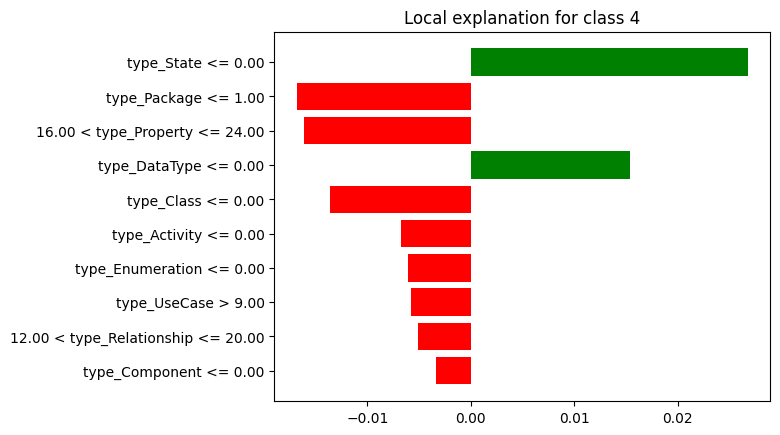

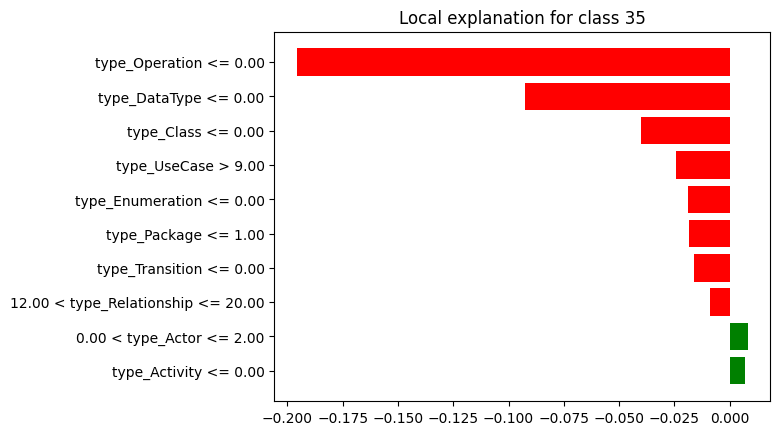

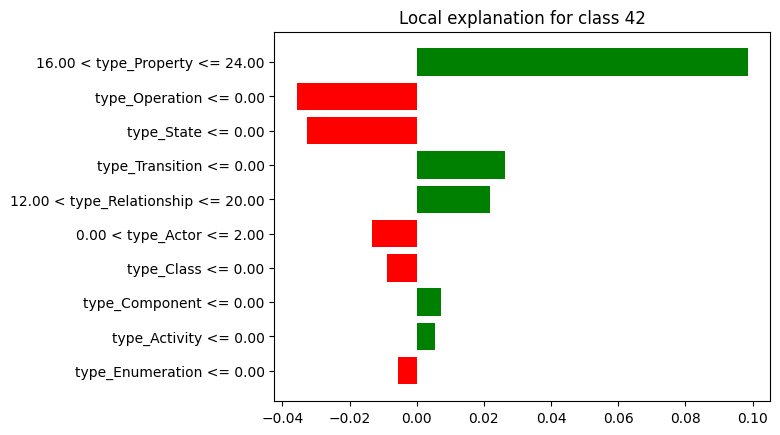

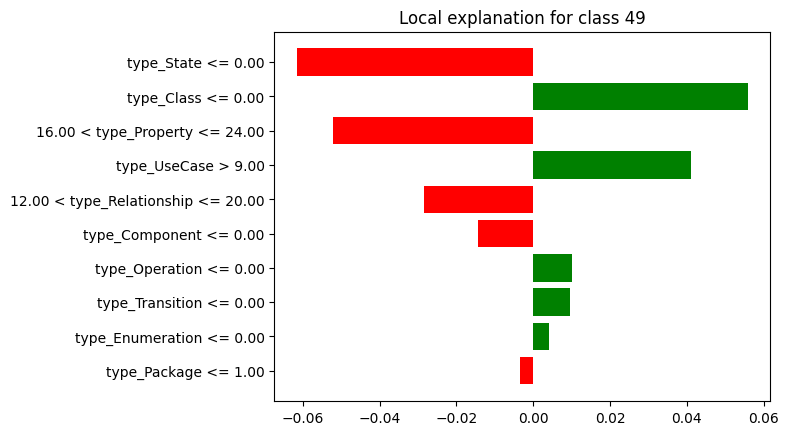

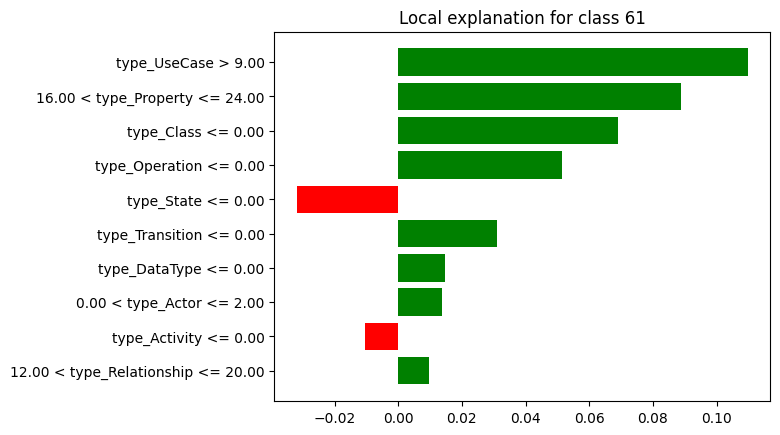

In [ ]:
for i in class_index:
  knn_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_ban = breakdown_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_ban = breakdown_df_library_ban.drop(index=[0, 14])
breakdown_df_library_ban['sign'] = breakdown_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_ban = breakdown_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_ban = shap_df_library_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_ban = shap_df_library_ban.tail(13)
shap_df_library_ban['sign'] = shap_df_library_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_ban = shap_df_library_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_ban["Feature"] = lime_df_library_ban["variable"].str.split(" ").str[0]
lime_df_library_ban["Sign"] = lime_df_library_ban["effect"].apply(evaluate_value)
lime_df_library_ban = lime_df_library_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_ban = lime_df_library_ban.drop(columns=['variable'])


breakdown_df_library_ban['Ranking'] = breakdown_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_ban = breakdown_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_ban['Ranking'] = shap_df_library_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_ban = shap_df_library_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_ban['Ranking'] = lime_df_library_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_ban = lime_df_library_ban.head(10)
lime_df_library_ban = lime_df_library_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_ban = breakdown_df_library_ban.drop(columns=['contribution'])
shap_df_library_ban = shap_df_library_ban.drop(columns=['contribution'])
lime_df_library_ban = lime_df_library_ban.drop(columns=['effect'])


breakdown_df_library_ban = breakdown_df_library_ban.head(10)
breakdown_df_library_ban = breakdown_df_library_ban.reset_index(drop=True)

shap_df_library_ban= shap_df_library_ban.head(10)
shap_df_library_ban = shap_df_library_ban.reset_index(drop=True)

lime_df_library_ban = lime_df_library_ban.reset_index(drop=True)
lime_df_library_ban.at[2, "Feature"] = "type_Property"
lime_df_library_ban.at[8, "Feature"] = "type_Relationship"

print(breakdown_df_library_ban)
print("---------------------------------")
print(shap_df_library_ban)
print("---------------------------------")
print(lime_df_library_ban)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1      type_Activity        2  Positive
2         type_Class        3  Positive
3         type_Actor        4  Negative
4  type_Relationship        5  Positive
5      type_DataType        6  Positive
6       type_Package        7  Negative
7     type_Operation        8  Negative
8     type_Component        9  Negative
9       type_UseCase       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Negative
2         type_Class        3  Negative
3     type_Operation        4  Positive
4       type_UseCase        5  Positive
5       type_Package        6  Negative
6   type_Enumeration        7  Negative
7      type_DataType        8  Positive
8      type_Activity        9  Negative
9         type_Actor       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_library_ban['Feature'])
shap_features = list(shap_df_library_ban['Feature'])
lime_features = list(lime_df_library_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_ban['Feature'] = list(all_features)
df_final_lib_ban= df_final_lib_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_ban['Feature']:

    breakdown_row = breakdown_df_library_ban[breakdown_df_library_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_ban[shap_df_library_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_ban[lime_df_library_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_ban.loc[df_final_lib_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_ban = df_final_lib_ban.loc[casos_validos]
df_final_lib_ban.set_index('Feature', inplace=True)
df_final_lib_ban

['type_Property', 'type_Activity', 'type_Class', 'type_Actor', 'type_Relationship', 'type_DataType', 'type_Package', 'type_Operation', 'type_Component', 'type_UseCase']
['type_Property', 'type_Relationship', 'type_Class', 'type_Operation', 'type_UseCase', 'type_Package', 'type_Enumeration', 'type_DataType', 'type_Activity', 'type_Actor']
['type_State', 'type_Package', 'type_Property', 'type_DataType', 'type_Class', 'type_Activity', 'type_Enumeration', 'type_UseCase', 'type_Relationship', 'type_Component']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       1  Negative       3  Negative
type_Activity             2  Positive       9  Negative       6  Negative
type_Class                3  Positive       3  Negative       5  Negative
type_Actor                4  Negative      10  Negative       -         -
type_Relationship         5  Positive       2  Negative       9  Negative
type_DataType             6  Positive       8  Positive       4  Positive
type_Package              7  Negative       6  Negative       2  Negative
type_Operation            8  Negative       4  Positive       -         -
type_Component            9  Negative       -         -      10  Negative
type_UseCase             10  Positive       5  Positive       8  Negative
type_Enumeration          -         -       7  Negative       7  Negative
type_State                -         -       -         -       1  Positive

In [ ]:
breakdown_df_library_vid = breakdown_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_vid = breakdown_df_library_vid.drop(index=[0, 14])
breakdown_df_library_vid['sign'] = breakdown_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_vid = breakdown_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_vid = shap_df_library_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_vid = shap_df_library_vid.tail(13)
shap_df_library_vid['sign'] = shap_df_library_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_vid = shap_df_library_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_vid["Feature"] = lime_df_library_vid["variable"].str.split(" ").str[0]
lime_df_library_vid["Sign"] = lime_df_library_vid["effect"].apply(evaluate_value)
lime_df_library_vid = lime_df_library_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_vid = lime_df_library_vid.drop(columns=['variable'])


breakdown_df_library_vid['Ranking'] = breakdown_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_vid = breakdown_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_vid['Ranking'] = shap_df_library_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_vid = shap_df_library_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_vid['Ranking'] = lime_df_library_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_vid = lime_df_library_vid.head(10)
lime_df_library_vid = lime_df_library_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_vid = breakdown_df_library_vid.drop(columns=['contribution'])
shap_df_library_vid = shap_df_library_vid.drop(columns=['contribution'])
lime_df_library_vid = lime_df_library_vid.drop(columns=['effect'])


breakdown_df_library_vid = breakdown_df_library_vid.head(10)
breakdown_df_library_vid = breakdown_df_library_vid.reset_index(drop=True)

shap_df_library_vid= shap_df_library_vid.head(10)
shap_df_library_vid = shap_df_library_vid.reset_index(drop=True)

lime_df_library_vid = lime_df_library_vid.reset_index(drop=True)
lime_df_library_vid.at[7, "Feature"] = "type_Relationship"
lime_df_library_vid.at[8, "Feature"] = "type_Actor"

print(breakdown_df_library_vid)
print("---------------------------------")
print(shap_df_library_vid)
print("---------------------------------")
print(lime_df_library_vid)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Positive
2     type_Operation        3  Negative
3  type_Relationship        4  Positive
4         type_Actor        5  Negative
5      type_DataType        6  Negative
6       type_UseCase        7  Negative
7   type_Enumeration        8  Negative
8      type_Activity        9  Positive
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1       type_UseCase        2  Negative
2  type_Relationship        3  Negative
3         type_Class        4  Positive
4      type_Property        5  Positive
5      type_DataType        6  Negative
6   type_Enumeration        7  Negative
7      type_Activity        8  Positive
8         type_Actor        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_library_vid['Feature'])
shap_features = list(shap_df_library_vid['Feature'])
lime_features = list(lime_df_library_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_vid['Feature'] = list(all_features)
df_final_lib_vid= df_final_lib_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_vid['Feature']:

    breakdown_row = breakdown_df_library_vid[breakdown_df_library_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_vid[shap_df_library_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_vid[lime_df_library_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_vid.loc[df_final_lib_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_vid = df_final_lib_vid.loc[casos_validos]
df_final_lib_vid.set_index('Feature', inplace=True)
df_final_lib_vid

['type_Property', 'type_Class', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_DataType', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_Package']
['type_Operation', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Property', 'type_DataType', 'type_Enumeration', 'type_Activity', 'type_Actor', 'type_Package']
['type_Operation', 'type_DataType', 'type_Class', 'type_UseCase', 'type_Enumeration', 'type_Package', 'type_Transition', 'type_Relationship', 'type_Actor', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       5  Positive       -         -
type_Class                2  Positive       4  Positive       3  Negative
type_Operation            3  Negative       1  Negative       1  Negative
type_Relationship         4  Positive       3  Negative       8  Negative
type_Actor                5  Negative       9  Negative       9  Positive
type_DataType             6  Negative       6  Negative       2  Negative
type_UseCase              7  Negative       2  Negative       4  Negative
type_Enumeration          8  Negative       7  Negative       5  Negative
type_Activity             9  Positive       8  Positive      10  Positive
type_Package             10  Negative      10  Negative       6  Negative
type_Transition           -         -       -         -       7  Negative

In [ ]:
breakdown_df_library_cou = breakdown_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_cou = breakdown_df_library_cou.drop(index=[0, 14])
breakdown_df_library_cou['sign'] = breakdown_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_cou = breakdown_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_cou = shap_df_library_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_cou = shap_df_library_cou.tail(13)
shap_df_library_cou['sign'] = shap_df_library_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_cou = shap_df_library_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_cou["Feature"] = lime_df_library_cou["variable"].str.split(" ").str[0]
lime_df_library_cou["Sign"] = lime_df_library_cou["effect"].apply(evaluate_value)
lime_df_library_cou = lime_df_library_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_cou = lime_df_library_cou.drop(columns=['variable'])


breakdown_df_library_cou['Ranking'] = breakdown_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_cou = breakdown_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_cou['Ranking'] = shap_df_library_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_cou = shap_df_library_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_cou['Ranking'] = lime_df_library_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_cou = lime_df_library_cou.head(10)
lime_df_library_cou = lime_df_library_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_cou = breakdown_df_library_cou.drop(columns=['contribution'])
shap_df_library_cou = shap_df_library_cou.drop(columns=['contribution'])
lime_df_library_cou = lime_df_library_cou.drop(columns=['effect'])


breakdown_df_library_cou = breakdown_df_library_cou.head(10)
breakdown_df_library_cou = breakdown_df_library_cou.reset_index(drop=True)

shap_df_library_cou= shap_df_library_cou.head(10)
shap_df_library_cou = shap_df_library_cou.reset_index(drop=True)

lime_df_library_cou = lime_df_library_cou.reset_index(drop=True)
lime_df_library_cou.at[0, "Feature"] = "type_Property"
lime_df_library_cou.at[4, "Feature"] = "type_Relationship"
lime_df_library_cou.at[5, "Feature"] = "type_Actor"

print(breakdown_df_library_cou)
print("---------------------------------")
print(shap_df_library_cou)
print("---------------------------------")
print(lime_df_library_cou)

             Feature  Ranking      Sign
0         type_Class        1  Negative
1      type_Property        2  Positive
2  type_Relationship        3  Positive
3       type_Package        4  Negative
4   type_Enumeration        5  Negative
5      type_DataType        6  Negative
6     type_Operation        7  Negative
7       type_UseCase        8  Negative
8      type_Activity        9  Negative
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1     type_Operation        2  Negative
2         type_Class        3  Negative
3         type_Actor        4  Negative
4  type_Relationship        5  Positive
5      type_Activity        6  Positive
6      type_DataType        7  Negative
7     type_Component        8  Negative
8      type_Property        9  Negative
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_library_cou['Feature'])
shap_features = list(shap_df_library_cou['Feature'])
lime_features = list(lime_df_library_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_cou['Feature'] = list(all_features)
df_final_lib_cou= df_final_lib_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_cou['Feature']:

    breakdown_row = breakdown_df_library_cou[breakdown_df_library_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_cou[shap_df_library_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_cou[lime_df_library_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_cou.loc[df_final_lib_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_cou = df_final_lib_cou.loc[casos_validos]
df_final_lib_cou.set_index('Feature', inplace=True)
df_final_lib_cou

['type_Class', 'type_Property', 'type_Relationship', 'type_Package', 'type_Enumeration', 'type_DataType', 'type_Operation', 'type_UseCase', 'type_Activity', 'type_Actor']
['type_UseCase', 'type_Operation', 'type_Class', 'type_Actor', 'type_Relationship', 'type_Activity', 'type_DataType', 'type_Component', 'type_Property', 'type_Package']
['type_Property', 'type_Operation', 'type_State', 'type_Transition', 'type_Relationship', 'type_Actor', 'type_Class', 'type_Component', 'type_Activity', 'type_Enumeration']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Negative       3  Negative       7  Negative
type_Property             2  Positive       9  Negative       1  Positive
type_Relationship         3  Positive       5  Positive       5  Positive
type_Package              4  Negative      10  Negative       -         -
type_Enumeration          5  Negative       -         -      10  Negative
type_DataType             6  Negative       7  Negative       -         -
type_Operation            7  Negative       2  Negative       2  Negative
type_UseCase              8  Negative       1  Negative       -         -
type_Activity             9  Negative       6  Positive       9  Positive
type_Actor               10  Positive       4  Negative       6  Negative
type_Component            -         -       8  Negative       8  Positive
type_State                -         -       -         -       3  Negative
type_Transition           -         -       -         -       4  Positive

In [ ]:
breakdown_df_library_emp = breakdown_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_emp = breakdown_df_library_emp.drop(index=[0, 14])
breakdown_df_library_emp['sign'] = breakdown_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_emp = breakdown_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_emp = shap_df_library_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_emp = shap_df_library_emp.tail(13)
shap_df_library_emp['sign'] = shap_df_library_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_emp = shap_df_library_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_emp["Feature"] = lime_df_library_emp["variable"].str.split(" ").str[0]
lime_df_library_emp["Sign"] = lime_df_library_emp["effect"].apply(evaluate_value)
lime_df_library_emp = lime_df_library_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_emp = lime_df_library_emp.drop(columns=['variable'])


breakdown_df_library_emp['Ranking'] = breakdown_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_emp = breakdown_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_emp['Ranking'] = shap_df_library_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_emp = shap_df_library_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_emp['Ranking'] = lime_df_library_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_emp = lime_df_library_emp.head(10)
lime_df_library_emp = lime_df_library_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_emp = breakdown_df_library_emp.drop(columns=['contribution'])
shap_df_library_emp = shap_df_library_emp.drop(columns=['contribution'])
lime_df_library_emp = lime_df_library_emp.drop(columns=['effect'])


breakdown_df_library_emp = breakdown_df_library_emp.head(10)
breakdown_df_library_emp = breakdown_df_library_emp.reset_index(drop=True)

shap_df_library_emp= shap_df_library_emp.head(10)
shap_df_library_emp = shap_df_library_emp.reset_index(drop=True)

lime_df_library_emp = lime_df_library_emp.reset_index(drop=True)
lime_df_library_emp.at[4, "Feature"] = "type_Relationship"
lime_df_library_emp.at[2, "Feature"] = "type_Property"

print(breakdown_df_library_emp)
print("---------------------------------")
print(shap_df_library_emp)
print("---------------------------------")
print(lime_df_library_emp)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1       type_UseCase        2  Positive
2  type_Relationship        3  Negative
3     type_Operation        4  Negative
4       type_Package        5  Positive
5         type_Actor        6  Positive
6         type_Class        7  Positive
7     type_Component        8  Negative
8      type_Activity        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Negative
2         type_Class        3  Positive
3         type_Actor        4  Positive
4       type_UseCase        5  Negative
5     type_Operation        6  Negative
6     type_Component        7  Negative
7   type_Enumeration        8  Positive
8      type_Activity        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         ty

In [ ]:

breakdown_features = list(breakdown_df_library_emp['Feature'])
shap_features = list(shap_df_library_emp['Feature'])
lime_features = list(lime_df_library_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_emp['Feature'] = list(all_features)
df_final_lib_emp= df_final_lib_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_emp['Feature']:

    breakdown_row = breakdown_df_library_emp[breakdown_df_library_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_emp[shap_df_library_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_emp[lime_df_library_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_emp.loc[df_final_lib_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_emp = df_final_lib_emp.loc[casos_validos]
df_final_lib_emp.set_index('Feature', inplace=True)
df_final_lib_emp

['type_Property', 'type_UseCase', 'type_Relationship', 'type_Operation', 'type_Package', 'type_Actor', 'type_Class', 'type_Component', 'type_Activity', 'type_Enumeration']
['type_Property', 'type_Relationship', 'type_Class', 'type_Actor', 'type_UseCase', 'type_Operation', 'type_Component', 'type_Enumeration', 'type_Activity', 'type_DataType']
['type_State', 'type_Class', 'type_Property', 'type_UseCase', 'type_Relationship', 'type_Component', 'type_Operation', 'type_Transition', 'type_Enumeration', 'type_Package']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       1  Negative       3  Negative
type_UseCase              2  Positive       5  Negative       4  Positive
type_Relationship         3  Negative       2  Negative       5  Negative
type_Operation            4  Negative       6  Negative       7  Positive
type_Package              5  Positive       -         -      10  Negative
type_Actor                6  Positive       4  Positive       -         -
type_Class                7  Positive       3  Positive       2  Positive
type_Component            8  Negative       7  Negative       6  Negative
type_Activity             9  Positive       9  Negative       -         -
type_Enumeration         10  Positive       8  Positive       9  Positive
type_DataType             -         -      10  Negative       -         -
type_State                -         -       -         -       1  Negative
type_Transition           -         -       -         -       8  Positive

In [ ]:
breakdown_df_library_lib = breakdown_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_library_lib = breakdown_df_library_lib.drop(index=[0, 14])
breakdown_df_library_lib['sign'] = breakdown_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_library_lib = breakdown_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_library_lib = shap_df_library_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_library_lib = shap_df_library_lib.tail(13)
shap_df_library_lib['sign'] = shap_df_library_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_library_lib = shap_df_library_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_library_lib["Feature"] = lime_df_library_lib["variable"].str.split(" ").str[0]
lime_df_library_lib["Sign"] = lime_df_library_lib["effect"].apply(evaluate_value)
lime_df_library_lib = lime_df_library_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_library_lib = lime_df_library_lib.drop(columns=['variable'])


breakdown_df_library_lib['Ranking'] = breakdown_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_library_lib = breakdown_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_library_lib['Ranking'] = shap_df_library_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_library_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_library_lib = shap_df_library_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_library_lib['Ranking'] = lime_df_library_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_library_lib = lime_df_library_lib.head(10)
lime_df_library_lib = lime_df_library_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_library_lib = breakdown_df_library_lib.drop(columns=['contribution'])
shap_df_library_lib = shap_df_library_lib.drop(columns=['contribution'])
lime_df_library_lib = lime_df_library_lib.drop(columns=['effect'])


breakdown_df_library_lib = breakdown_df_library_lib.head(10)
breakdown_df_library_lib = breakdown_df_library_lib.reset_index(drop=True)

shap_df_library_lib= shap_df_library_lib.head(10)
shap_df_library_lib = shap_df_library_lib.reset_index(drop=True)

lime_df_library_lib = lime_df_library_lib.reset_index(drop=True)
lime_df_library_lib.at[1, "Feature"] = "type_Property"
lime_df_library_lib.at[7, "Feature"] = "type_Actor"
lime_df_library_lib.at[9, "Feature"] = "type_Relationship"

print(breakdown_df_library_lib)
print("---------------------------------")
print(shap_df_library_lib)
print("---------------------------------")
print(lime_df_library_lib)

             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1         type_Class        2  Positive
2  type_Relationship        3  Positive
3     type_Operation        4  Positive
4      type_Property        5  Positive
5         type_Actor        6  Positive
6      type_DataType        7  Positive
7       type_Package        8  Positive
8   type_Enumeration        9  Positive
9         type_State       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Positive
1       type_UseCase        2  Positive
2  type_Relationship        3  Positive
3         type_Class        4  Positive
4     type_Operation        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Negative
7      type_Activity        8  Positive
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_library_lib['Feature'])
shap_features = list(shap_df_library_lib['Feature'])
lime_features = list(lime_df_library_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_lib_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_lib_lib['Feature'] = list(all_features)
df_final_lib_lib= df_final_lib_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_lib_lib['Feature']:

    breakdown_row = breakdown_df_library_lib[breakdown_df_library_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_library_lib[shap_df_library_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_library_lib[lime_df_library_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_lib_lib.loc[df_final_lib_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_lib_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_lib_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_lib_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_lib_lib = df_final_lib_lib.loc[casos_validos]
df_final_lib_lib.set_index('Feature', inplace=True)
df_final_lib_lib

['type_UseCase', 'type_Class', 'type_Relationship', 'type_Operation', 'type_Property', 'type_Actor', 'type_DataType', 'type_Package', 'type_Enumeration', 'type_State']
['type_Property', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Operation', 'type_Actor', 'type_Component', 'type_Activity', 'type_Package', 'type_Enumeration']
['type_UseCase', 'type_Property', 'type_Class', 'type_Operation', 'type_State', 'type_Transition', 'type_DataType', 'type_Actor', 'type_Activity', 'type_Relationship']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       2  Positive       1  Positive
type_Class                2  Positive       4  Positive       3  Positive
type_Relationship         3  Positive       3  Positive      10  Positive
type_Operation            4  Positive       5  Positive       4  Positive
type_Property             5  Positive       1  Positive       2  Positive
type_Actor                6  Positive       6  Positive       8  Positive
type_DataType             7  Positive       -         -       7  Positive
type_Package              8  Positive       9  Positive       -         -
type_Enumeration          9  Positive      10  Positive       -         -
type_State               10  Positive       -         -       5  Negative
type_Activity             -         -       8  Positive       9  Negative
type_Component            -         -       7  Negative       -         -
type_Transition           -         -       -         -       6  Positive

### **Results Library:**

In [ ]:
df_topfeatures_lib_ban = top5_features(df_final_lib_ban, 'Library - Class: Bank')
df_topfeatures_lib_vid = top5_features(df_final_lib_vid, 'Library - Class: ComputerVideogames')
df_topfeatures_lib_cou = top5_features(df_final_lib_cou, 'Library - Class: Course')
df_topfeatures_lib_emp = top5_features(df_final_lib_emp, 'Library - Class: Employee')
df_topfeatures_lib_lib = top5_features(df_final_lib_lib, 'Library - Class: Library')

df_topfeatures_library = pd.concat([df_topfeatures_lib_ban, df_topfeatures_lib_vid, df_topfeatures_lib_cou, df_topfeatures_lib_emp, df_topfeatures_lib_lib])
df_topfeatures_library

TOP5 Breakdown  \
Library - Class: Bank                type_Actor, type_Class, type_Property, type_Re...   
Library - Class: ComputerVideogames  type_Actor, type_Class, type_Property, type_Re...   
Library - Class: Course              type_Package, type_Class, type_Property, type_...   
Library - Class: Employee            type_Package, type_UseCase, type_Property, typ...   
Library - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                                                             TOP5 Shap  \
Library - Class: Bank                type_Class, type_UseCase, type_Property, type_...   
Library - Class: ComputerVideogames  type_Class, type_UseCase, type_Property, type_...   
Library - Class: Course              type_Actor, type_Class, type_UseCase, type_Rel...   
Library - Class: Employee            type_Actor, type_Class, type_UseCase, type_Pro...   
Library - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                                                             TOP5 Lime  \
Library - Class: Bank                type_Package, type_Class, type_DataType, type_...   
Library - Class: ComputerVideogames  type_Class, type_DataType, type_UseCase, type_...   
Library - Class: Course              type_Property, type_State, type_Relationship, ...   
Library - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
Library - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: Bank                           0.6             0.4        0.4  
Library - Class: ComputerVideogames             0.8             0.4        0.6  
Library - Class: Course                         0.4             0.4        0.4  
Library - Class: Employee                       0.6             0.6        0.8  
Library - Class: Library                        1.0             0.8        0.8

In [ ]:
df_topfeatures_lib_ban_rank = top5_rank(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank = top5_rank(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank = top5_rank(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank = top5_rank(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank = top5_rank(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_library = pd.concat([df_topfeatures_lib_ban_rank, df_topfeatures_lib_vid_rank, df_topfeatures_lib_cou_rank, df_topfeatures_lib_emp_rank, df_topfeatures_lib_lib_rank])
df_topfeatures_rank_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Property, 2:type_Activity, 3:type_Class...   
Library - Class ComputerVideogames  1:type_Property, 2:type_Class, 3:type_Operatio...   
Library - Class Course              1:type_Class, 2:type_Property, 3:type_Relation...   
Library - Class Employee            1:type_Property, 2:type_UseCase, 3:type_Relati...   
Library - Class Library             1:type_UseCase, 2:type_Class, 3:type_Relations...   

                                                                            TOP5 Shap  \
Library - Class Bank                1:type_Property, 3:type_Class, 2:type_Relation...   
Library - Class ComputerVideogames  5:type_Property, 4:type_Class, 1:type_Operatio...   
Library - Class Course              3:type_Class, 5:type_Relationship, 2:type_Oper...   
Library - Class Employee            1:type_Property, 5:type_UseCase, 2:type_Relati...   
Library - Class Library             2:type_UseCase, 4:type_Class, 3:type_Relations...   

                                                                            TOP5 Lime  \
Library - Class Bank                3:type_Property, 5:type_Class, 4:type_DataType...   
Library - Class ComputerVideogames  3:type_Class, 1:type_Operation, 2:type_DataTyp...   
Library - Class Course              1:type_Property, 5:type_Relationship, 2:type_O...   
Library - Class Employee            3:type_Property, 4:type_UseCase, 5:type_Relati...   
Library - Class Library             1:type_UseCase, 3:type_Class, 4:type_Operation...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.4             0.0        0.0  
Library - Class ComputerVideogames             0.0             0.0        0.2  
Library - Class Course                         0.0             0.0        0.4  
Library - Class Employee                       0.2             0.0        0.0  
Library - Class Library                        0.2             0.4        0.0

In [ ]:
df_topfeatures_lib_ban_sign = top5_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_sign = top5_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_sign = top5_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_sign = top5_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_sign = top5_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_sign_library = pd.concat([df_topfeatures_lib_ban_sign, df_topfeatures_lib_vid_sign, df_topfeatures_lib_cou_sign, df_topfeatures_lib_emp_sign, df_topfeatures_lib_lib_sign])
df_topfeatures_sign_library

TOP5 Breakdown  \
Library - Class Bank                type_Property:Negative, type_Activity:Positive...   
Library - Class ComputerVideogames  type_Property:Negative, type_Class:Positive, t...   
Library - Class Course              type_Class:Negative, type_Property:Positive, t...   
Library - Class Employee            type_Property:Negative, type_UseCase:Positive,...   
Library - Class Library             type_UseCase:Positive, type_Class:Positive, ty...   

                                                                            TOP5 Shap  \
Library - Class Bank                type_Property:Negative, type_Class:Negative, t...   
Library - Class ComputerVideogames  type_Property:Positive, type_Class:Positive, t...   
Library - Class Course              type_Class:Negative, type_Relationship:Positiv...   
Library - Class Employee            type_Property:Negative, type_UseCase:Negative,...   
Library - Class Library             type_UseCase:Positive, type_Class:Positive, ty...   

                                                                            TOP5 Lime  \
Library - Class Bank                type_Property:Negative, type_Class:Negative, t...   
Library - Class ComputerVideogames  type_Class:Negative, type_Operation:Negative, ...   
Library - Class Course              type_Property:Positive, type_Relationship:Posi...   
Library - Class Employee            type_Property:Negative, type_UseCase:Positive,...   
Library - Class Library             type_UseCase:Positive, type_Class:Positive, ty...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.2             0.2        0.4  
Library - Class ComputerVideogames             0.4             0.2        0.4  
Library - Class Course                         0.4             0.4        0.4  
Library - Class Employee                       0.4             0.6        0.6  
Library - Class Library                        1.0             0.8        0.8

In [ ]:
df_topfeatures_lib_ban_rank_sign = top5_rank_sign(df_final_lib_ban, 'Library - Class Bank')
df_topfeatures_lib_vid_rank_sign = top5_rank_sign(df_final_lib_vid, 'Library - Class ComputerVideogames')
df_topfeatures_lib_cou_rank_sign = top5_rank_sign(df_final_lib_cou, 'Library - Class Course')
df_topfeatures_lib_emp_rank_sign = top5_rank_sign(df_final_lib_emp, 'Library - Class Employee')
df_topfeatures_lib_lib_rank_sign = top5_rank_sign(df_final_lib_lib, 'Library - Class Library')

df_topfeatures_rank_sign_library = pd.concat([df_topfeatures_lib_ban_rank_sign, df_topfeatures_lib_vid_rank_sign, df_topfeatures_lib_cou_rank_sign, df_topfeatures_lib_emp_rank_sign, df_topfeatures_lib_lib_rank_sign])
df_topfeatures_rank_sign_library

TOP5 Breakdown  \
Library - Class Bank                1:type_Property:Negative, 2:type_Activity:Posi...   
Library - Class ComputerVideogames  1:type_Property:Negative, 2:type_Class:Positiv...   
Library - Class Course              1:type_Class:Negative, 2:type_Property:Positiv...   
Library - Class Employee            1:type_Property:Negative, 2:type_UseCase:Posit...   
Library - Class Library             1:type_UseCase:Positive, 2:type_Class:Positive...   

                                                                            TOP5 Shap  \
Library - Class Bank                1:type_Property:Negative, 3:type_Class:Negativ...   
Library - Class ComputerVideogames  5:type_Property:Positive, 4:type_Class:Positiv...   
Library - Class Course              3:type_Class:Negative, 5:type_Relationship:Pos...   
Library - Class Employee            1:type_Property:Negative, 5:type_UseCase:Negat...   
Library - Class Library             2:type_UseCase:Positive, 4:type_Class:Positive...   

                                                                            TOP5 Lime  \
Library - Class Bank                3:type_Property:Negative, 5:type_Class:Negativ...   
Library - Class ComputerVideogames  3:type_Class:Negative, 1:type_Operation:Negati...   
Library - Class Course              1:type_Property:Positive, 5:type_Relationship:...   
Library - Class Employee            3:type_Property:Negative, 4:type_UseCase:Posit...   
Library - Class Library             1:type_UseCase:Positive, 3:type_Class:Positive...   

                                    Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class Bank                           0.2             0.0        0.0  
Library - Class ComputerVideogames             0.0             0.0        0.2  
Library - Class Course                         0.0             0.0        0.4  
Library - Class Employee                       0.2             0.0        0.0  
Library - Class Library                        0.2             0.4        0.0

### **Bank:**

In [ ]:
breakdown_df_bank_ban = knn_exp_results['breakdown_bank'][0].result
shap_df_bank_ban = knn_exp_results['shap_bank'][0].result
lime_df_bank_ban = knn_exp_results['lime_bank'][0].result

In [ ]:
breakdown_df_bank_vid = knn_exp_results['breakdown_bank'][1].result
shap_df_bank_vid = knn_exp_results['shap_bank'][1].result
lime_df_bank_vid = knn_exp_results['lime_bank'][1].result

In [ ]:
breakdown_df_bank_cou = knn_exp_results['breakdown_bank'][3].result
shap_df_bank_cou = knn_exp_results['shap_bank'][3].result
lime_df_bank_cou = knn_exp_results['lime_bank'][3].result

In [ ]:
breakdown_df_bank_emp = knn_exp_results['breakdown_bank'][4].result
shap_df_bank_emp = knn_exp_results['shap_bank'][4].result
lime_df_bank_emp = knn_exp_results['lime_bank'][4].result

In [ ]:
breakdown_df_bank_lib = knn_exp_results['breakdown_bank'][6].result
shap_df_bank_lib = knn_exp_results['shap_bank'][6].result
lime_df_bank_lib = knn_exp_results['lime_bank'][6].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_bank'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_bank'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

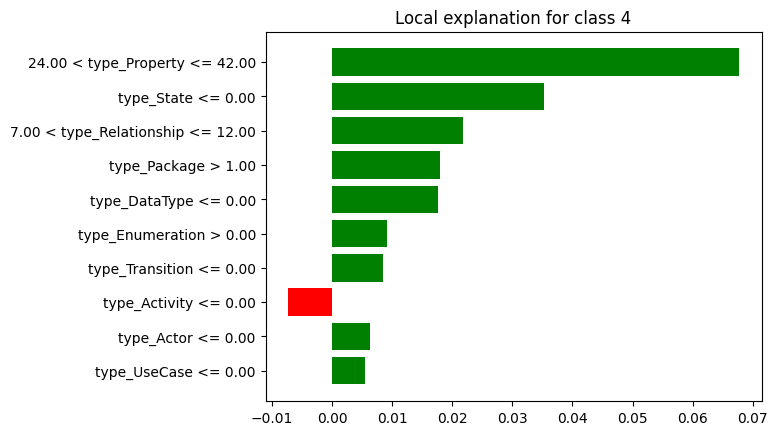

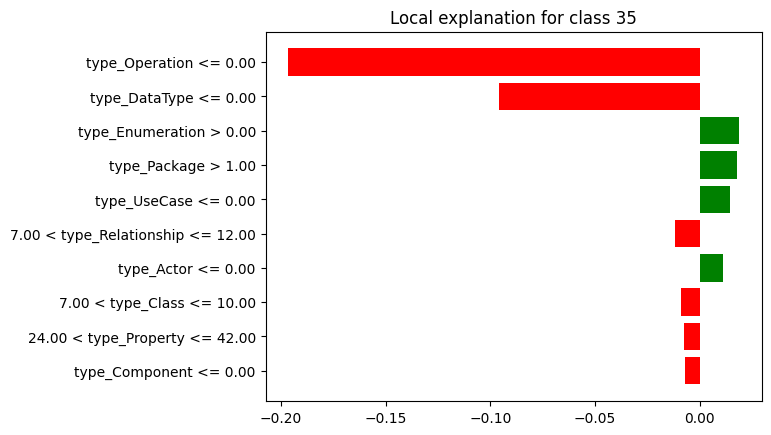

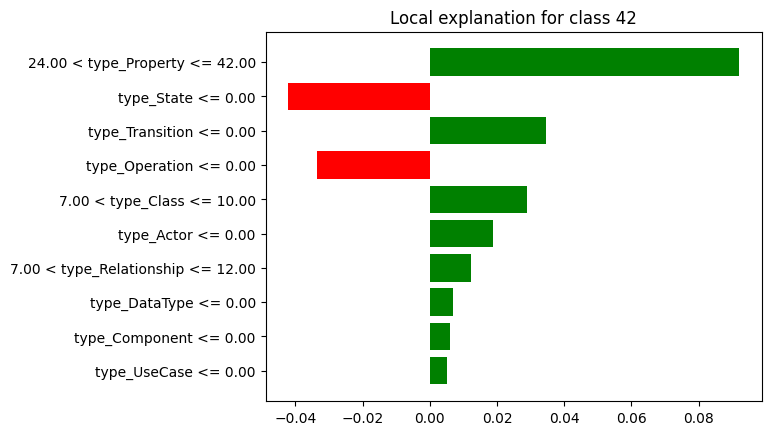

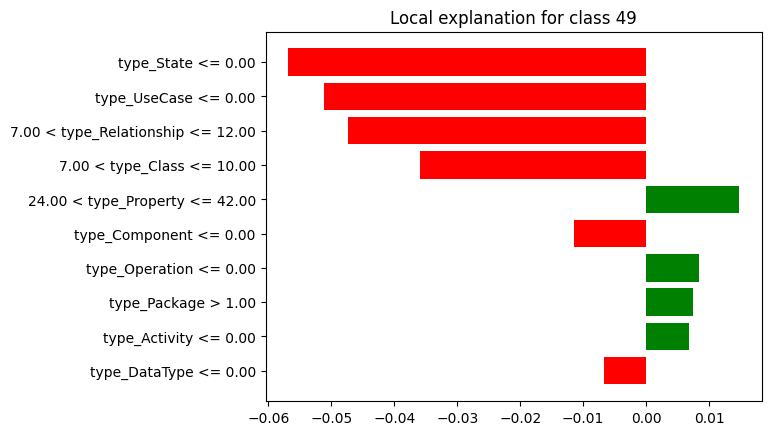

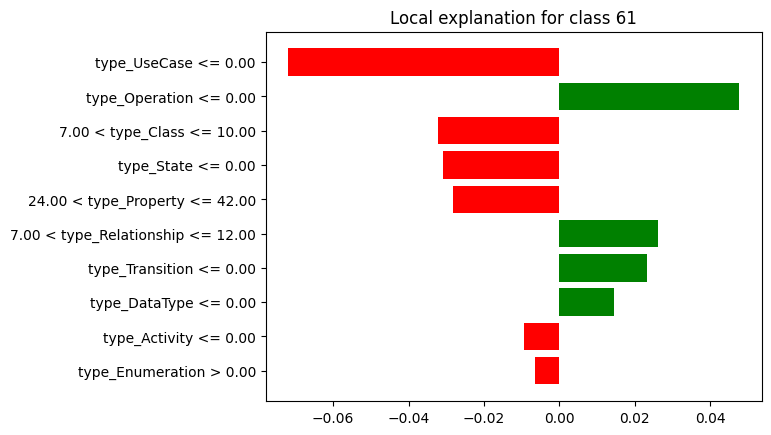

In [ ]:
for i in class_index:
  knn_exp_results['lime_bank'][i].plot()

In [ ]:
breakdown_df_bank_ban = breakdown_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_ban = breakdown_df_bank_ban.drop(index=[0, 14])
breakdown_df_bank_ban['sign'] = breakdown_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_ban = breakdown_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_ban = shap_df_bank_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_ban = shap_df_bank_ban.tail(13)
shap_df_bank_ban['sign'] = shap_df_bank_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_ban = shap_df_bank_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_ban["Feature"] = lime_df_bank_ban["variable"].str.split(" ").str[0]
lime_df_bank_ban["Sign"] = lime_df_bank_ban["effect"].apply(evaluate_value)
lime_df_bank_ban = lime_df_bank_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['variable'])


breakdown_df_bank_ban['Ranking'] = breakdown_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_ban = breakdown_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_ban['Ranking'] = shap_df_bank_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_ban = shap_df_bank_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_ban['Ranking'] = lime_df_bank_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_ban = lime_df_bank_ban.head(10)
lime_df_bank_ban = lime_df_bank_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_ban = breakdown_df_bank_ban.drop(columns=['contribution'])
shap_df_bank_ban = shap_df_bank_ban.drop(columns=['contribution'])
lime_df_bank_ban = lime_df_bank_ban.drop(columns=['effect'])


breakdown_df_bank_ban = breakdown_df_bank_ban.head(10)
breakdown_df_bank_ban = breakdown_df_bank_ban.reset_index(drop=True)

shap_df_bank_ban= shap_df_bank_ban.head(10)
shap_df_bank_ban = shap_df_bank_ban.reset_index(drop=True)

lime_df_bank_ban = lime_df_bank_ban.reset_index(drop=True)
lime_df_bank_ban.at[0, "Feature"] = "type_Property"
lime_df_bank_ban.at[2, "Feature"] = "type_Relationship"

print(breakdown_df_bank_ban)
print("---------------------------------")
print(shap_df_bank_ban)
print("---------------------------------")
print(lime_df_bank_ban)

             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1  type_Relationship        2  Positive
2       type_Package        3  Positive
3      type_Property        4  Positive
4   type_Enumeration        5  Positive
5     type_Operation        6  Positive
6         type_Actor        7  Positive
7      type_Activity        8  Positive
8      type_DataType        9  Positive
9    type_Transition       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Positive
1     type_Operation        2  Positive
2         type_Class        3  Positive
3  type_Relationship        4  Positive
4       type_UseCase        5  Positive
5       type_Package        6  Positive
6         type_Actor        7  Positive
7   type_Enumeration        8  Positive
8      type_DataType        9  Positive
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_bank_ban['Feature'])
shap_features = list(shap_df_bank_ban['Feature'])
lime_features = list(lime_df_bank_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_ban['Feature'] = list(all_features)
df_final_ban_ban= df_final_ban_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_ban['Feature']:

    breakdown_row = breakdown_df_bank_ban[breakdown_df_bank_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_ban[shap_df_bank_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_ban[lime_df_bank_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_ban.loc[df_final_ban_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_ban = df_final_ban_ban.loc[casos_validos]
df_final_ban_ban.set_index('Feature', inplace=True)
df_final_ban_ban

['type_UseCase', 'type_Relationship', 'type_Package', 'type_Property', 'type_Enumeration', 'type_Operation', 'type_Actor', 'type_Activity', 'type_DataType', 'type_Transition']
['type_Property', 'type_Operation', 'type_Class', 'type_Relationship', 'type_UseCase', 'type_Package', 'type_Actor', 'type_Enumeration', 'type_DataType', 'type_Activity']
['type_Property', 'type_State', 'type_Relationship', 'type_Package', 'type_DataType', 'type_Enumeration', 'type_Transition', 'type_Activity', 'type_Actor', 'type_UseCase']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       5  Positive      10  Positive
type_Relationship         2  Positive       4  Positive       3  Positive
type_Package              3  Positive       6  Positive       4  Positive
type_Property             4  Positive       1  Positive       1  Positive
type_Enumeration          5  Positive       8  Positive       6  Positive
type_Operation            6  Positive       2  Positive       -         -
type_Actor                7  Positive       7  Positive       9  Positive
type_Activity             8  Positive      10  Positive       8  Negative
type_DataType             9  Positive       9  Positive       5  Positive
type_Transition          10  Positive       -         -       7  Positive
type_Class                -         -       3  Positive       -         -
type_State                -         -       -         -       2  Positive

In [ ]:
breakdown_df_bank_vid = breakdown_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_vid = breakdown_df_bank_vid.drop(index=[0, 14])
breakdown_df_bank_vid['sign'] = breakdown_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_vid = breakdown_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_vid = shap_df_bank_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_vid = shap_df_bank_vid.tail(13)
shap_df_bank_vid['sign'] = shap_df_bank_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_vid = shap_df_bank_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_vid["Feature"] = lime_df_bank_vid["variable"].str.split(" ").str[0]
lime_df_bank_vid["Sign"] = lime_df_bank_vid["effect"].apply(evaluate_value)
lime_df_bank_vid = lime_df_bank_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['variable'])


breakdown_df_bank_vid['Ranking'] = breakdown_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_vid = breakdown_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_vid['Ranking'] = shap_df_bank_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_vid = shap_df_bank_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_vid['Ranking'] = lime_df_bank_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_vid = lime_df_bank_vid.head(10)
lime_df_bank_vid = lime_df_bank_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_vid = breakdown_df_bank_vid.drop(columns=['contribution'])
shap_df_bank_vid = shap_df_bank_vid.drop(columns=['contribution'])
lime_df_bank_vid = lime_df_bank_vid.drop(columns=['effect'])


breakdown_df_bank_vid = breakdown_df_bank_vid.head(10)
breakdown_df_bank_vid = breakdown_df_bank_vid.reset_index(drop=True)

shap_df_bank_vid= shap_df_bank_vid.head(10)
shap_df_bank_vid = shap_df_bank_vid.reset_index(drop=True)

lime_df_bank_vid = lime_df_bank_vid.reset_index(drop=True)
lime_df_bank_vid.at[5, "Feature"] = "type_Relationship"
lime_df_bank_vid.at[7, "Feature"] = "type_Class"
lime_df_bank_vid.at[8, "Feature"] = "type_Property"

print(breakdown_df_bank_vid)
print("---------------------------------")
print(shap_df_bank_vid)
print("---------------------------------")
print(lime_df_bank_vid)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Positive
2       type_UseCase        3  Negative
3      type_DataType        4  Negative
4   type_Enumeration        5  Positive
5         type_Class        6  Negative
6  type_Relationship        7  Negative
7       type_Package        8  Positive
8    type_Transition        9  Positive
9         type_Actor       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1         type_Class        2  Negative
2      type_Property        3  Negative
3      type_DataType        4  Negative
4  type_Relationship        5  Positive
5       type_UseCase        6  Negative
6   type_Enumeration        7  Positive
7       type_Package        8  Negative
8         type_Actor        9  Positive
9      type_Activity       10  Negative
---------------------------------
             Feature  Ranking      Sign
0     type_O

In [ ]:

breakdown_features = list(breakdown_df_bank_vid['Feature'])
shap_features = list(shap_df_bank_vid['Feature'])
lime_features = list(lime_df_bank_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_vid['Feature'] = list(all_features)
df_final_ban_vid= df_final_ban_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_vid['Feature']:

    breakdown_row = breakdown_df_bank_vid[breakdown_df_bank_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_vid[shap_df_bank_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_vid[lime_df_bank_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_vid.loc[df_final_ban_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_vid = df_final_ban_vid.loc[casos_validos]
df_final_ban_vid.set_index('Feature', inplace=True)
df_final_ban_vid

['type_Operation', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Enumeration', 'type_Class', 'type_Relationship', 'type_Package', 'type_Transition', 'type_Actor']
['type_Operation', 'type_Class', 'type_Property', 'type_DataType', 'type_Relationship', 'type_UseCase', 'type_Enumeration', 'type_Package', 'type_Actor', 'type_Activity']
['type_Operation', 'type_DataType', 'type_Enumeration', 'type_Package', 'type_UseCase', 'type_Relationship', 'type_Actor', 'type_Class', 'type_Property', 'type_Component']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Activity', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       1  Negative       1  Negative
type_Property             2  Positive       3  Negative       9  Negative
type_UseCase              3  Negative       6  Negative       5  Positive
type_DataType             4  Negative       4  Negative       2  Negative
type_Enumeration          5  Positive       7  Positive       3  Positive
type_Class                6  Negative       2  Negative       8  Negative
type_Relationship         7  Negative       5  Positive       6  Negative
type_Package              8  Positive       8  Negative       4  Positive
type_Transition           9  Positive       -         -       -         -
type_Actor               10  Positive       9  Positive       7  Positive
type_Activity             -         -      10  Negative       -         -
type_Component            -         -       -         -      10  Negative

In [ ]:
breakdown_df_bank_cou = breakdown_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_cou = breakdown_df_bank_cou.drop(index=[0, 14])
breakdown_df_bank_cou['sign'] = breakdown_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_cou = breakdown_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_cou = shap_df_bank_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_cou = shap_df_bank_cou.tail(13)
shap_df_bank_cou['sign'] = shap_df_bank_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_cou = shap_df_bank_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_cou["Feature"] = lime_df_bank_cou["variable"].str.split(" ").str[0]
lime_df_bank_cou["Sign"] = lime_df_bank_cou["effect"].apply(evaluate_value)
lime_df_bank_cou = lime_df_bank_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['variable'])


breakdown_df_bank_cou['Ranking'] = breakdown_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_cou = breakdown_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_cou['Ranking'] = shap_df_bank_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_cou = shap_df_bank_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_cou['Ranking'] = lime_df_bank_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_cou = lime_df_bank_cou.head(10)
lime_df_bank_cou = lime_df_bank_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_cou = breakdown_df_bank_cou.drop(columns=['contribution'])
shap_df_bank_cou = shap_df_bank_cou.drop(columns=['contribution'])
lime_df_bank_cou = lime_df_bank_cou.drop(columns=['effect'])


breakdown_df_bank_cou = breakdown_df_bank_cou.head(10)
breakdown_df_bank_cou = breakdown_df_bank_cou.reset_index(drop=True)

shap_df_bank_cou= shap_df_bank_cou.head(10)
shap_df_bank_cou = shap_df_bank_cou.reset_index(drop=True)

lime_df_bank_cou = lime_df_bank_cou.reset_index(drop=True)
lime_df_bank_cou.at[0, "Feature"] = "type_Property"
lime_df_bank_cou.at[4, "Feature"] = "type_Class"
lime_df_bank_cou.at[6, "Feature"] = "type_Relationship"

print(breakdown_df_bank_cou)
print("---------------------------------")
print(shap_df_bank_cou)
print("---------------------------------")
print(lime_df_bank_cou)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Positive
2   type_Enumeration        3  Negative
3         type_Class        4  Negative
4         type_Actor        5  Positive
5  type_Relationship        6  Positive
6      type_DataType        7  Negative
7       type_UseCase        8  Positive
8         type_State        9  Positive
9    type_Transition       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Positive
2         type_Actor        3  Negative
3  type_Relationship        4  Negative
4       type_Package        5  Negative
5      type_DataType        6  Negative
6         type_Class        7  Positive
7   type_Enumeration        8  Negative
8     type_Component        9  Positive
9       type_UseCase       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_bank_cou['Feature'])
shap_features = list(shap_df_bank_cou['Feature'])
lime_features = list(lime_df_bank_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_cou['Feature'] = list(all_features)
df_final_ban_cou= df_final_ban_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_cou['Feature']:

    breakdown_row = breakdown_df_bank_cou[breakdown_df_bank_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_cou[shap_df_bank_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_cou[lime_df_bank_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_cou.loc[df_final_ban_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_cou = df_final_ban_cou.loc[casos_validos]
df_final_ban_cou.set_index('Feature', inplace=True)
df_final_ban_cou

['type_Operation', 'type_Property', 'type_Enumeration', 'type_Class', 'type_Actor', 'type_Relationship', 'type_DataType', 'type_UseCase', 'type_State', 'type_Transition']
['type_Operation', 'type_Property', 'type_Actor', 'type_Relationship', 'type_Package', 'type_DataType', 'type_Class', 'type_Enumeration', 'type_Component', 'type_UseCase']
['type_Property', 'type_State', 'type_Transition', 'type_Operation', 'type_Class', 'type_Actor', 'type_Relationship', 'type_DataType', 'type_Component', 'type_UseCase']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       1  Negative       4  Negative
type_Property             2  Positive       2  Positive       1  Positive
type_Enumeration          3  Negative       8  Negative       -         -
type_Class                4  Negative       7  Positive       5  Positive
type_Actor                5  Positive       3  Negative       6  Positive
type_Relationship         6  Positive       4  Negative       7  Positive
type_DataType             7  Negative       6  Negative       8  Positive
type_UseCase              8  Positive      10  Positive      10  Positive
type_State                9  Positive       -         -       2  Negative
type_Transition          10  Positive       -         -       3  Positive
type_Component            -         -       9  Positive       9  Positive
type_Package              -         -       5  Negative       -         -

In [ ]:
breakdown_df_bank_emp = breakdown_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_emp = breakdown_df_bank_emp.drop(index=[0, 14])
breakdown_df_bank_emp['sign'] = breakdown_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_emp = breakdown_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_emp = shap_df_bank_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_emp = shap_df_bank_emp.tail(13)
shap_df_bank_emp['sign'] = shap_df_bank_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_emp = shap_df_bank_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_emp["Feature"] = lime_df_bank_emp["variable"].str.split(" ").str[0]
lime_df_bank_emp["Sign"] = lime_df_bank_emp["effect"].apply(evaluate_value)
lime_df_bank_emp = lime_df_bank_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['variable'])


breakdown_df_bank_emp['Ranking'] = breakdown_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_emp = breakdown_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_emp['Ranking'] = shap_df_bank_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_emp = shap_df_bank_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_emp['Ranking'] = lime_df_bank_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_emp = lime_df_bank_emp.head(10)
lime_df_bank_emp = lime_df_bank_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_emp = breakdown_df_bank_emp.drop(columns=['contribution'])
shap_df_bank_emp = shap_df_bank_emp.drop(columns=['contribution'])
lime_df_bank_emp = lime_df_bank_emp.drop(columns=['effect'])


breakdown_df_bank_emp = breakdown_df_bank_emp.head(10)
breakdown_df_bank_emp = breakdown_df_bank_emp.reset_index(drop=True)

shap_df_bank_emp= shap_df_bank_emp.head(10)
shap_df_bank_emp = shap_df_bank_emp.reset_index(drop=True)

lime_df_bank_emp = lime_df_bank_emp.reset_index(drop=True)
lime_df_bank_emp.at[2, "Feature"] = "type_Relationship"
lime_df_bank_emp.at[3, "Feature"] = "type_Class"
lime_df_bank_emp.at[4, "Feature"] = "type_Property"

print(breakdown_df_bank_emp)
print("---------------------------------")
print(shap_df_bank_emp)
print("---------------------------------")
print(lime_df_bank_emp)

            Feature  Ranking      Sign
0  type_Enumeration        1  Negative
1      type_Package        2  Negative
2      type_UseCase        3  Positive
3        type_Class        4  Negative
4     type_Property        5  Negative
5    type_Operation        6  Negative
6        type_Actor        7  Positive
7     type_DataType        8  Positive
8     type_Activity        9  Positive
9        type_State       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1         type_Class        2  Negative
2  type_Relationship        3  Negative
3      type_Property        4  Negative
4       type_UseCase        5  Negative
5   type_Enumeration        6  Negative
6         type_Actor        7  Negative
7     type_Component        8  Negative
8       type_Package        9  Negative
9      type_DataType       10  Negative
---------------------------------
             Feature  Ranking      Sign
0         type_State   

In [ ]:

breakdown_features = list(breakdown_df_bank_emp['Feature'])
shap_features = list(shap_df_bank_emp['Feature'])
lime_features = list(lime_df_bank_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_emp['Feature'] = list(all_features)
df_final_ban_emp= df_final_ban_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_emp['Feature']:

    breakdown_row = breakdown_df_bank_emp[breakdown_df_bank_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_emp[shap_df_bank_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_emp[lime_df_bank_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_emp.loc[df_final_ban_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_emp = df_final_ban_emp.loc[casos_validos]
df_final_ban_emp.set_index('Feature', inplace=True)
df_final_ban_emp

['type_Enumeration', 'type_Package', 'type_UseCase', 'type_Class', 'type_Property', 'type_Operation', 'type_Actor', 'type_DataType', 'type_Activity', 'type_State']
['type_Operation', 'type_Class', 'type_Relationship', 'type_Property', 'type_UseCase', 'type_Enumeration', 'type_Actor', 'type_Component', 'type_Package', 'type_DataType']
['type_State', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Property', 'type_Component', 'type_Operation', 'type_Package', 'type_Activity', 'type_DataType']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Enumeration          1  Negative       6  Negative       -         -
type_Package              2  Negative       9  Negative       8  Positive
type_UseCase              3  Positive       5  Negative       2  Negative
type_Class                4  Negative       2  Negative       4  Negative
type_Property             5  Negative       4  Negative       5  Positive
type_Operation            6  Negative       1  Negative       7  Positive
type_Actor                7  Positive       7  Negative       -         -
type_DataType             8  Positive      10  Negative      10  Negative
type_Activity             9  Positive       -         -       9  Positive
type_State               10  Positive       -         -       1  Negative
type_Relationship         -         -       3  Negative       3  Negative
type_Component            -         -       8  Negative       6  Negative

In [ ]:
breakdown_df_bank_lib = breakdown_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_bank_lib = breakdown_df_bank_lib.drop(index=[0, 14])
breakdown_df_bank_lib['sign'] = breakdown_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_bank_lib = breakdown_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_bank_lib = shap_df_bank_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_bank_lib = shap_df_bank_lib.tail(13)
shap_df_bank_lib['sign'] = shap_df_bank_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_bank_lib = shap_df_bank_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_bank_lib["Feature"] = lime_df_bank_lib["variable"].str.split(" ").str[0]
lime_df_bank_lib["Sign"] = lime_df_bank_lib["effect"].apply(evaluate_value)
lime_df_bank_lib = lime_df_bank_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['variable'])


breakdown_df_bank_lib['Ranking'] = breakdown_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_bank_lib = breakdown_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_bank_lib['Ranking'] = shap_df_bank_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_bank_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_bank_lib = shap_df_bank_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_bank_lib['Ranking'] = lime_df_bank_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_bank_lib = lime_df_bank_lib.head(10)
lime_df_bank_lib = lime_df_bank_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_bank_lib = breakdown_df_bank_lib.drop(columns=['contribution'])
shap_df_bank_lib = shap_df_bank_lib.drop(columns=['contribution'])
lime_df_bank_lib = lime_df_bank_lib.drop(columns=['effect'])


breakdown_df_bank_lib = breakdown_df_bank_lib.head(10)
breakdown_df_bank_lib = breakdown_df_bank_lib.reset_index(drop=True)

shap_df_bank_lib= shap_df_bank_lib.head(10)
shap_df_bank_lib = shap_df_bank_lib.reset_index(drop=True)

lime_df_bank_lib = lime_df_bank_lib.reset_index(drop=True)
lime_df_bank_lib.at[2, "Feature"] = "type_Class"
lime_df_bank_lib.at[4, "Feature"] = "type_Property"
lime_df_bank_lib.at[5, "Feature"] = "type_Relationship"

print(breakdown_df_bank_lib)
print("---------------------------------")
print(shap_df_bank_lib)
print("---------------------------------")
print(lime_df_bank_lib)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1         type_Class        2  Negative
2  type_Relationship        3  Positive
3         type_Actor        4  Positive
4     type_Component        5  Negative
5     type_Operation        6  Negative
6       type_Package        7  Positive
7   type_Enumeration        8  Negative
8      type_Activity        9  Positive
9         type_State       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1      type_Property        2  Negative
2         type_Class        3  Negative
3  type_Relationship        4  Positive
4     type_Component        5  Negative
5         type_Actor        6  Positive
6      type_Activity        7  Negative
7   type_Enumeration        8  Negative
8      type_DataType        9  Positive
9       type_Package       10  Negative
---------------------------------
             Feature  Ranking      Sign
0       type

In [ ]:

breakdown_features = list(breakdown_df_bank_lib['Feature'])
shap_features = list(shap_df_bank_lib['Feature'])
lime_features = list(lime_df_bank_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_ban_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_ban_lib['Feature'] = list(all_features)
df_final_ban_lib= df_final_ban_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_ban_lib['Feature']:

    breakdown_row = breakdown_df_bank_lib[breakdown_df_bank_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_bank_lib[shap_df_bank_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_bank_lib[lime_df_bank_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_ban_lib.loc[df_final_ban_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_ban_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_ban_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_ban_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_ban_lib = df_final_ban_lib.loc[casos_validos]
df_final_ban_lib.set_index('Feature', inplace=True)
df_final_ban_lib

['type_Property', 'type_Class', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Operation', 'type_Package', 'type_Enumeration', 'type_Activity', 'type_State']
['type_UseCase', 'type_Property', 'type_Class', 'type_Relationship', 'type_Component', 'type_Actor', 'type_Activity', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_UseCase', 'type_Operation', 'type_Class', 'type_State', 'type_Property', 'type_Relationship', 'type_Transition', 'type_DataType', 'type_Activity', 'type_Enumeration']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       2  Negative       5  Negative
type_Class                2  Negative       3  Negative       3  Negative
type_Relationship         3  Positive       4  Positive       6  Positive
type_Actor                4  Positive       6  Positive       -         -
type_Component            5  Negative       5  Negative       -         -
type_Operation            6  Negative       -         -       2  Positive
type_Package              7  Positive      10  Negative       -         -
type_Enumeration          8  Negative       8  Negative      10  Negative
type_Activity             9  Positive       7  Negative       9  Negative
type_State               10  Negative       -         -       4  Negative
type_DataType             -         -       9  Positive       8  Positive
type_UseCase              -         -       1  Negative       1  Negative
type_Transition           -         -       -         -       7  Positive

### **Results Bank:**

In [ ]:
df_topfeatures_ban_ban = top5_features(df_final_ban_ban, 'Bank - Class: Bank')
df_topfeatures_ban_vid = top5_features(df_final_ban_vid, 'Bank - Class: ComputerVideogames')
df_topfeatures_ban_cou = top5_features(df_final_ban_cou, 'Bank - Class: Course')
df_topfeatures_ban_emp = top5_features(df_final_ban_emp, 'Bank - Class: Employee')
df_topfeatures_ban_lib = top5_features(df_final_ban_lib, 'Bank - Class: Library')

df_topfeatures_bank = pd.concat([df_topfeatures_ban_ban, df_topfeatures_ban_vid, df_topfeatures_ban_cou, df_topfeatures_ban_emp, df_topfeatures_ban_lib])
df_topfeatures_bank

TOP5 Breakdown  \
Bank - Class: Bank                type_Package, type_UseCase, type_Property, typ...   
Bank - Class: ComputerVideogames  type_DataType, type_UseCase, type_Property, ty...   
Bank - Class: Course              type_Actor, type_Class, type_Property, type_Op...   
Bank - Class: Employee            type_Package, type_Class, type_UseCase, type_P...   
Bank - Class: Library             type_Component, type_Actor, type_Class, type_P...   

                                                                          TOP5 Shap  \
Bank - Class: Bank                type_Class, type_UseCase, type_Property, type_...   
Bank - Class: ComputerVideogames  type_Class, type_DataType, type_Property, type...   
Bank - Class: Course              type_Package, type_Actor, type_Property, type_...   
Bank - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
Bank - Class: Library             type_Component, type_Class, type_UseCase, type...   

                                                                          TOP5 Lime  \
Bank - Class: Bank                type_Package, type_DataType, type_Property, ty...   
Bank - Class: ComputerVideogames  type_Package, type_DataType, type_UseCase, typ...   
Bank - Class: Course              type_Class, type_Property, type_State, type_Op...   
Bank - Class: Employee            type_Class, type_UseCase, type_Property, type_...   
Bank - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class: Bank                           0.6             0.6        0.4  
Bank - Class: ComputerVideogames             0.6             0.8        0.4  
Bank - Class: Course                         0.6             0.6        0.4  
Bank - Class: Employee                       0.6             0.6        0.8  
Bank - Class: Library                        0.8             0.4        0.6

In [ ]:
df_topfeatures_ban_ban_rank = top5_rank(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank = top5_rank(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank = top5_rank(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank = top5_rank(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank = top5_rank(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_bank = pd.concat([df_topfeatures_ban_ban_rank, df_topfeatures_ban_vid_rank, df_topfeatures_ban_cou_rank, df_topfeatures_ban_emp_rank, df_topfeatures_ban_lib_rank])
df_topfeatures_rank_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_UseCase, 2:type_Relationship, 3:type_Pa...   
Bank - Class ComputerVideogames  1:type_Operation, 2:type_Property, 3:type_UseC...   
Bank - Class Course              1:type_Operation, 2:type_Property, 3:type_Enum...   
Bank - Class Employee            1:type_Enumeration, 2:type_Package, 3:type_Use...   
Bank - Class Library             1:type_Property, 2:type_Class, 3:type_Relation...   

                                                                         TOP5 Shap  \
Bank - Class Bank                5:type_UseCase, 4:type_Relationship, 1:type_Pr...   
Bank - Class ComputerVideogames  1:type_Operation, 3:type_Property, 4:type_Data...   
Bank - Class Course              1:type_Operation, 2:type_Property, 3:type_Acto...   
Bank - Class Employee            5:type_UseCase, 2:type_Class, 4:type_Property,...   
Bank - Class Library             2:type_Property, 3:type_Class, 4:type_Relation...   

                                                                         TOP5 Lime  \
Bank - Class Bank                3:type_Relationship, 4:type_Package, 1:type_Pr...   
Bank - Class ComputerVideogames  1:type_Operation, 5:type_UseCase, 2:type_DataT...   
Bank - Class Course              4:type_Operation, 1:type_Property, 5:type_Clas...   
Bank - Class Employee            2:type_UseCase, 4:type_Class, 5:type_Property,...   
Bank - Class Library             5:type_Property, 3:type_Class, 2:type_Operatio...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.0             0.0        0.2  
Bank - Class ComputerVideogames             0.4             0.2        0.2  
Bank - Class Course                         0.4             0.0        0.0  
Bank - Class Employee                       0.0             0.4        0.2  
Bank - Class Library                        0.2             0.0        0.4

In [ ]:
df_topfeatures_ban_ban_sign = top5_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_sign = top5_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_sign = top5_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_sign = top5_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_sign = top5_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_sign_bank = pd.concat([df_topfeatures_ban_ban_sign, df_topfeatures_ban_vid_sign, df_topfeatures_ban_cou_sign, df_topfeatures_ban_emp_sign, df_topfeatures_ban_lib_sign])
df_topfeatures_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                type_UseCase:Positive, type_Relationship:Posit...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Property:Positiv...   
Bank - Class Course              type_Operation:Negative, type_Property:Positiv...   
Bank - Class Employee            type_Enumeration:Negative, type_Package:Negati...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                         TOP5 Shap  \
Bank - Class Bank                type_UseCase:Positive, type_Relationship:Posit...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_Property:Negativ...   
Bank - Class Course              type_Operation:Negative, type_Property:Positiv...   
Bank - Class Employee            type_UseCase:Negative, type_Class:Negative, ty...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                                                         TOP5 Lime  \
Bank - Class Bank                type_Relationship:Positive, type_Package:Posit...   
Bank - Class ComputerVideogames  type_Operation:Negative, type_UseCase:Positive...   
Bank - Class Course              type_Operation:Negative, type_Property:Positiv...   
Bank - Class Employee            type_UseCase:Negative, type_Class:Negative, ty...   
Bank - Class Library             type_Property:Negative, type_Class:Negative, t...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.6             0.6        0.4  
Bank - Class ComputerVideogames             0.4             0.6        0.4  
Bank - Class Course                         0.4             0.4        0.4  
Bank - Class Employee                       0.4             0.2        0.6  
Bank - Class Library                        0.8             0.4        0.6

In [ ]:
df_topfeatures_ban_ban_rank_sign = top5_rank_sign(df_final_ban_ban, 'Bank - Class Bank')
df_topfeatures_ban_vid_rank_sign = top5_rank_sign(df_final_ban_vid, 'Bank - Class ComputerVideogames')
df_topfeatures_ban_cou_rank_sign = top5_rank_sign(df_final_ban_cou, 'Bank - Class Course')
df_topfeatures_ban_emp_rank_sign = top5_rank_sign(df_final_ban_emp, 'Bank - Class Employee')
df_topfeatures_ban_lib_rank_sign = top5_rank_sign(df_final_ban_lib, 'Bank - Class Library')

df_topfeatures_rank_sign_bank = pd.concat([df_topfeatures_ban_ban_rank_sign, df_topfeatures_ban_vid_rank_sign, df_topfeatures_ban_cou_rank_sign, df_topfeatures_ban_emp_rank_sign, df_topfeatures_ban_lib_rank_sign])
df_topfeatures_rank_sign_bank

TOP5 Breakdown  \
Bank - Class Bank                1:type_UseCase:Positive, 2:type_Relationship:P...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 2:type_Property:Pos...   
Bank - Class Course              1:type_Operation:Negative, 2:type_Property:Pos...   
Bank - Class Employee            1:type_Enumeration:Negative, 2:type_Package:Ne...   
Bank - Class Library             1:type_Property:Negative, 2:type_Class:Negativ...   

                                                                         TOP5 Shap  \
Bank - Class Bank                5:type_UseCase:Positive, 4:type_Relationship:P...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 3:type_Property:Neg...   
Bank - Class Course              1:type_Operation:Negative, 2:type_Property:Pos...   
Bank - Class Employee            5:type_UseCase:Negative, 2:type_Class:Negative...   
Bank - Class Library             2:type_Property:Negative, 3:type_Class:Negativ...   

                                                                         TOP5 Lime  \
Bank - Class Bank                3:type_Relationship:Positive, 4:type_Package:P...   
Bank - Class ComputerVideogames  1:type_Operation:Negative, 5:type_UseCase:Posi...   
Bank - Class Course              4:type_Operation:Negative, 1:type_Property:Pos...   
Bank - Class Employee            2:type_UseCase:Negative, 4:type_Class:Negative...   
Bank - Class Library             5:type_Property:Negative, 3:type_Class:Negativ...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Bank - Class Bank                           0.0             0.0        0.2  
Bank - Class ComputerVideogames             0.4             0.2        0.2  
Bank - Class Course                         0.4             0.0        0.0  
Bank - Class Employee                       0.0             0.2        0.2  
Bank - Class Library                        0.2             0.0        0.4

### **Employee:**

In [ ]:
breakdown_df_employee_ban = knn_exp_results['breakdown_employee'][0].result
shap_df_employee_ban = knn_exp_results['shap_employee'][0].result
lime_df_employee_ban = knn_exp_results['lime_employee'][0].result

In [ ]:
breakdown_df_employee_vid = knn_exp_results['breakdown_employee'][1].result
shap_df_employee_vid = knn_exp_results['shap_employee'][1].result
lime_df_employee_vid = knn_exp_results['lime_employee'][1].result

In [ ]:
breakdown_df_employee_cou = knn_exp_results['breakdown_employee'][3].result
shap_df_employee_cou = knn_exp_results['shap_employee'][3].result
lime_df_employee_cou = knn_exp_results['lime_employee'][3].result

In [ ]:
breakdown_df_employee_emp = knn_exp_results['breakdown_employee'][4].result
shap_df_employee_emp = knn_exp_results['shap_employee'][4].result
lime_df_employee_emp = knn_exp_results['lime_employee'][4].result

In [ ]:
breakdown_df_employee_lib = knn_exp_results['breakdown_employee'][6].result
shap_df_employee_lib = knn_exp_results['shap_employee'][6].result
lime_df_employee_lib = knn_exp_results['lime_employee'][6].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_employee'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_employee'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

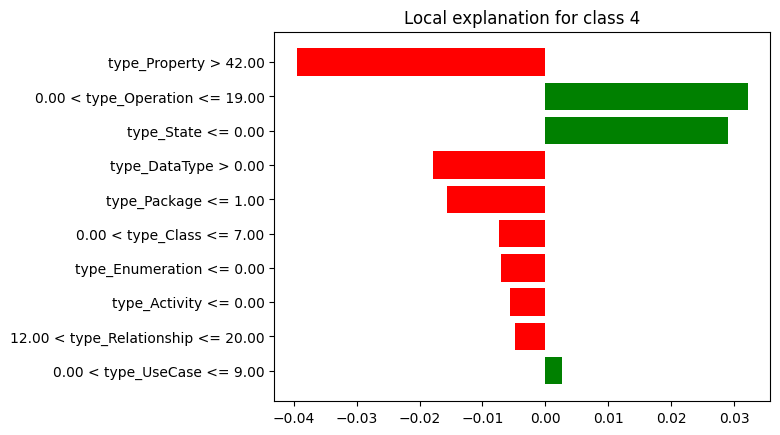

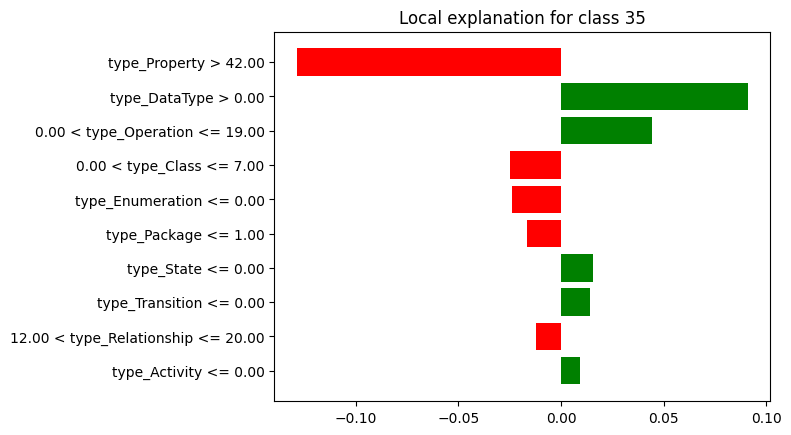

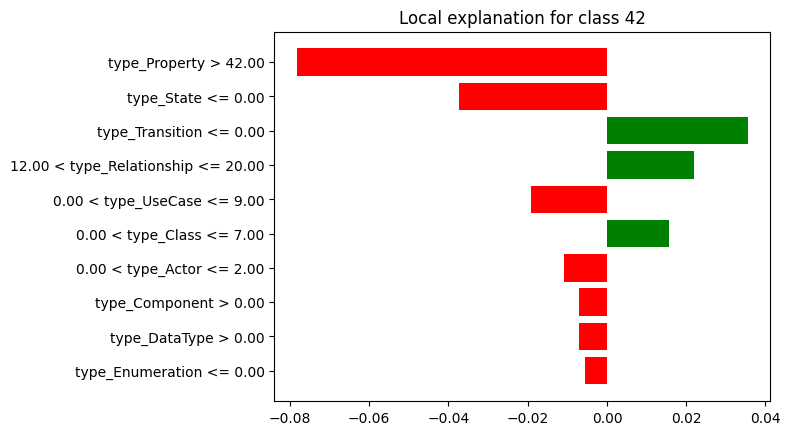

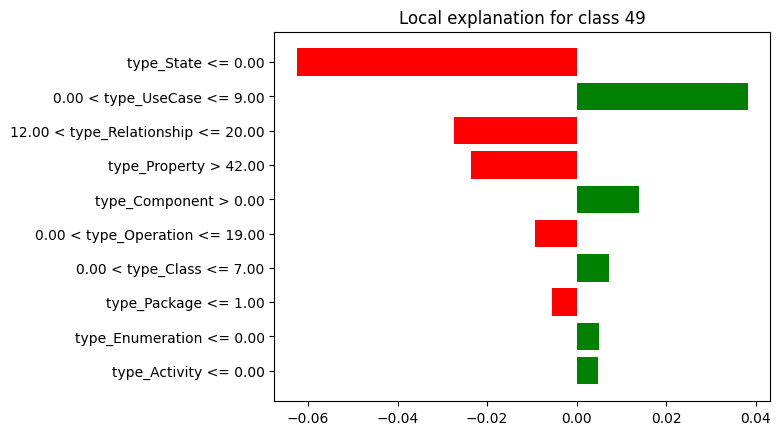

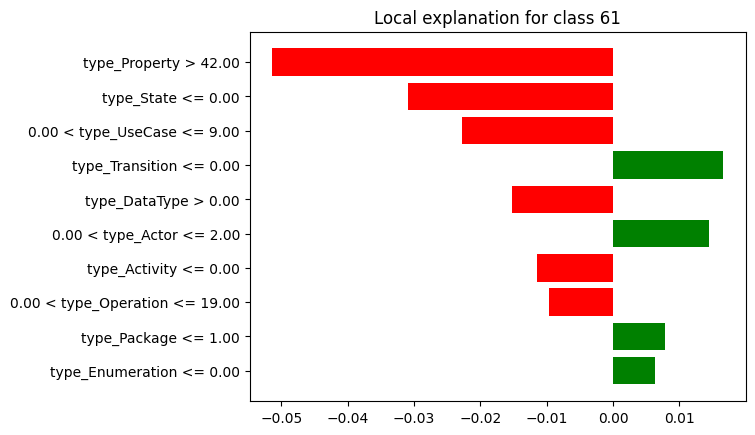

In [ ]:
for i in class_index:
  knn_exp_results['lime_employee'][i].plot()

In [ ]:
breakdown_df_employee_ban = breakdown_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_ban = breakdown_df_employee_ban.drop(index=[0, 14])
breakdown_df_employee_ban['sign'] = breakdown_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_ban = breakdown_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_ban = shap_df_employee_ban.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_ban = shap_df_employee_ban.tail(13)
shap_df_employee_ban['sign'] = shap_df_employee_ban['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_ban = shap_df_employee_ban.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_ban["Feature"] = lime_df_employee_ban["variable"].str.split(" ").str[0]
lime_df_employee_ban["Sign"] = lime_df_employee_ban["effect"].apply(evaluate_value)
lime_df_employee_ban = lime_df_employee_ban.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['variable'])


breakdown_df_employee_ban['Ranking'] = breakdown_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_ban = breakdown_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_ban['Ranking'] = shap_df_employee_ban['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_ban.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_ban = shap_df_employee_ban[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_ban['Ranking'] = lime_df_employee_ban['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_ban = lime_df_employee_ban.head(10)
lime_df_employee_ban = lime_df_employee_ban[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_ban = breakdown_df_employee_ban.drop(columns=['contribution'])
shap_df_employee_ban = shap_df_employee_ban.drop(columns=['contribution'])
lime_df_employee_ban = lime_df_employee_ban.drop(columns=['effect'])


breakdown_df_employee_ban = breakdown_df_employee_ban.head(10)
breakdown_df_employee_ban = breakdown_df_employee_ban.reset_index(drop=True)

shap_df_employee_ban= shap_df_employee_ban.head(10)
shap_df_employee_ban = shap_df_employee_ban.reset_index(drop=True)

lime_df_employee_ban = lime_df_employee_ban.reset_index(drop=True)
lime_df_employee_ban.at[1, "Feature"] = "type_Operation"
lime_df_employee_ban.at[5, "Feature"] = "type_Class"
lime_df_employee_ban.at[8, "Feature"] = "type_Relationship"
lime_df_employee_ban.at[9, "Feature"] = "type_UseCase"

print(breakdown_df_employee_ban)
print("---------------------------------")
print(shap_df_employee_ban)
print("---------------------------------")
print(lime_df_employee_ban)

             Feature  Ranking      Sign
0         type_Class        1  Negative
1  type_Relationship        2  Negative
2      type_Property        3  Negative
3     type_Component        4  Positive
4      type_DataType        5  Positive
5         type_Actor        6  Negative
6       type_UseCase        7  Positive
7   type_Enumeration        8  Positive
8      type_Activity        9  Negative
9         type_State       10  Positive
---------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1  type_Relationship        2  Negative
2      type_Property        3  Negative
3         type_Class        4  Negative
4       type_UseCase        5  Negative
5     type_Component        6  Negative
6         type_Actor        7  Negative
7       type_Package        8  Negative
8   type_Enumeration        9  Negative
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_employee_ban['Feature'])
shap_features = list(shap_df_employee_ban['Feature'])
lime_features = list(lime_df_employee_ban['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_ban = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_ban['Feature'] = list(all_features)
df_final_emp_ban= df_final_emp_ban[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_ban['Feature']:

    breakdown_row = breakdown_df_employee_ban[breakdown_df_employee_ban['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_ban[shap_df_employee_ban['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_ban[lime_df_employee_ban['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_ban.loc[df_final_emp_ban['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_ban[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_ban.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_ban.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_ban = df_final_emp_ban.loc[casos_validos]
df_final_emp_ban.set_index('Feature', inplace=True)
df_final_emp_ban

['type_Class', 'type_Relationship', 'type_Property', 'type_Component', 'type_DataType', 'type_Actor', 'type_UseCase', 'type_Enumeration', 'type_Activity', 'type_State']
['type_Operation', 'type_Relationship', 'type_Property', 'type_Class', 'type_UseCase', 'type_Component', 'type_Actor', 'type_Package', 'type_Enumeration', 'type_DataType']
['type_Property', 'type_Operation', 'type_State', 'type_DataType', 'type_Package', 'type_Class', 'type_Enumeration', 'type_Activity', 'type_Relationship', 'type_UseCase']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Negative       4  Negative       6  Negative
type_Relationship         2  Negative       2  Negative       9  Negative
type_Property             3  Negative       3  Negative       1  Negative
type_Component            4  Positive       6  Negative       -         -
type_DataType             5  Positive      10  Positive       4  Negative
type_Actor                6  Negative       7  Negative       -         -
type_UseCase              7  Positive       5  Negative      10  Positive
type_Enumeration          8  Positive       9  Negative       7  Negative
type_Activity             9  Negative       -         -       8  Negative
type_State               10  Positive       -         -       3  Positive
type_Operation            -         -       1  Negative       2  Positive
type_Package              -         -       8  Negative       5  Negative

In [ ]:
breakdown_df_employee_vid = breakdown_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_vid = breakdown_df_employee_vid.drop(index=[0, 14])
breakdown_df_employee_vid['sign'] = breakdown_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_vid = breakdown_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_vid = shap_df_employee_vid.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_vid = shap_df_employee_vid.tail(13)
shap_df_employee_vid['sign'] = shap_df_employee_vid['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_vid = shap_df_employee_vid.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_vid["Feature"] = lime_df_employee_vid["variable"].str.split(" ").str[0]
lime_df_employee_vid["Sign"] = lime_df_employee_vid["effect"].apply(evaluate_value)
lime_df_employee_vid = lime_df_employee_vid.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['variable'])


breakdown_df_employee_vid['Ranking'] = breakdown_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_vid = breakdown_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_vid['Ranking'] = shap_df_employee_vid['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_vid.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_vid = shap_df_employee_vid[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_vid['Ranking'] = lime_df_employee_vid['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_vid = lime_df_employee_vid.head(10)
lime_df_employee_vid = lime_df_employee_vid[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_vid = breakdown_df_employee_vid.drop(columns=['contribution'])
shap_df_employee_vid = shap_df_employee_vid.drop(columns=['contribution'])
lime_df_employee_vid = lime_df_employee_vid.drop(columns=['effect'])


breakdown_df_employee_vid = breakdown_df_employee_vid.head(10)
breakdown_df_employee_vid = breakdown_df_employee_vid.reset_index(drop=True)

shap_df_employee_vid= shap_df_employee_vid.head(10)
shap_df_employee_vid = shap_df_employee_vid.reset_index(drop=True)

lime_df_employee_vid = lime_df_employee_vid.reset_index(drop=True)
lime_df_employee_vid.at[2, "Feature"] = "type_Operation"
lime_df_employee_vid.at[3, "Feature"] = "type_Class"
lime_df_employee_vid.at[8, "Feature"] = "type_Relationship"

print(breakdown_df_employee_vid)
print("---------------------------------")
print(shap_df_employee_vid)
print("---------------------------------")
print(lime_df_employee_vid)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1     type_Operation        2  Positive
2      type_DataType        3  Positive
3         type_Actor        4  Negative
4       type_UseCase        5  Positive
5  type_Relationship        6  Positive
6         type_Class        7  Negative
7   type_Enumeration        8  Negative
8       type_Package        9  Negative
9      type_Activity       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1     type_Operation        2  Positive
2         type_Class        3  Positive
3       type_Package        4  Negative
4     type_Component        5  Negative
5   type_Enumeration        6  Negative
6  type_Relationship        7  Negative
7       type_UseCase        8  Negative
8         type_Actor        9  Positive
9      type_DataType       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_employee_vid['Feature'])
shap_features = list(shap_df_employee_vid['Feature'])
lime_features = list(lime_df_employee_vid['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_vid = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_vid['Feature'] = list(all_features)
df_final_emp_vid= df_final_emp_vid[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_vid['Feature']:

    breakdown_row = breakdown_df_employee_vid[breakdown_df_employee_vid['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_vid[shap_df_employee_vid['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_vid[lime_df_employee_vid['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_vid.loc[df_final_emp_vid['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_vid[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_vid.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_vid.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_vid = df_final_emp_vid.loc[casos_validos]
df_final_emp_vid.set_index('Feature', inplace=True)
df_final_emp_vid

['type_Property', 'type_Operation', 'type_DataType', 'type_Actor', 'type_UseCase', 'type_Relationship', 'type_Class', 'type_Enumeration', 'type_Package', 'type_Activity']
['type_Property', 'type_Operation', 'type_Class', 'type_Package', 'type_Component', 'type_Enumeration', 'type_Relationship', 'type_UseCase', 'type_Actor', 'type_DataType']
['type_Property', 'type_DataType', 'type_Operation', 'type_Class', 'type_Enumeration', 'type_Package', 'type_State', 'type_Transition', 'type_Relationship', 'type_Activity']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Component', 'type_Package']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       1  Negative       1  Negative
type_Operation            2  Positive       2  Positive       3  Positive
type_DataType             3  Positive      10  Positive       2  Positive
type_Actor                4  Negative       9  Positive       -         -
type_UseCase              5  Positive       8  Negative       -         -
type_Relationship         6  Positive       7  Negative       9  Negative
type_Class                7  Negative       3  Positive       4  Negative
type_Enumeration          8  Negative       6  Negative       5  Negative
type_Package              9  Negative       4  Negative       6  Negative
type_Activity            10  Positive       -         -      10  Positive
type_Component            -         -       5  Negative       -         -
type_State                -         -       -         -       7  Positive
type_Transition           -         -       -         -       8  Positive

In [ ]:
breakdown_df_employee_cou = breakdown_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_cou = breakdown_df_employee_cou.drop(index=[0, 14])
breakdown_df_employee_cou['sign'] = breakdown_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_cou = breakdown_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_cou = shap_df_employee_cou.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_cou = shap_df_employee_cou.tail(13)
shap_df_employee_cou['sign'] = shap_df_employee_cou['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_cou = shap_df_employee_cou.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_cou["Feature"] = lime_df_employee_cou["variable"].str.split(" ").str[0]
lime_df_employee_cou["Sign"] = lime_df_employee_cou["effect"].apply(evaluate_value)
lime_df_employee_cou = lime_df_employee_cou.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['variable'])


breakdown_df_employee_cou['Ranking'] = breakdown_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_cou = breakdown_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_cou['Ranking'] = shap_df_employee_cou['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_cou.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_cou = shap_df_employee_cou[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_cou['Ranking'] = lime_df_employee_cou['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_cou = lime_df_employee_cou.head(10)
lime_df_employee_cou = lime_df_employee_cou[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_cou = breakdown_df_employee_cou.drop(columns=['contribution'])
shap_df_employee_cou = shap_df_employee_cou.drop(columns=['contribution'])
lime_df_employee_cou = lime_df_employee_cou.drop(columns=['effect'])


breakdown_df_employee_cou = breakdown_df_employee_cou.head(10)
breakdown_df_employee_cou = breakdown_df_employee_cou.reset_index(drop=True)

shap_df_employee_cou= shap_df_employee_cou.head(10)
shap_df_employee_cou = shap_df_employee_cou.reset_index(drop=True)

lime_df_employee_cou = lime_df_employee_cou.reset_index(drop=True)
lime_df_employee_cou.at[3, "Feature"] = "type_Relationship"
lime_df_employee_cou.at[4, "Feature"] = "type_UseCase"
lime_df_employee_cou.at[5, "Feature"] = "type_Class"
lime_df_employee_cou.at[6, "Feature"] = "type_Actor"

print(breakdown_df_employee_cou)
print("---------------------------------")
print(shap_df_employee_cou)
print("---------------------------------")
print(lime_df_employee_cou)

             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Positive
2       type_UseCase        3  Negative
3         type_Class        4  Positive
4     type_Operation        5  Positive
5      type_DataType        6  Negative
6         type_Actor        7  Negative
7     type_Component        8  Negative
8      type_Activity        9  Negative
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Negative
1  type_Relationship        2  Positive
2     type_Operation        3  Positive
3       type_UseCase        4  Negative
4         type_Class        5  Positive
5         type_Actor        6  Negative
6     type_Component        7  Positive
7      type_Activity        8  Negative
8      type_DataType        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0      type_

In [ ]:

breakdown_features = list(breakdown_df_employee_cou['Feature'])
shap_features = list(shap_df_employee_cou['Feature'])
lime_features = list(lime_df_employee_cou['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_cou = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_cou['Feature'] = list(all_features)
df_final_emp_cou= df_final_emp_cou[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_cou['Feature']:

    breakdown_row = breakdown_df_employee_cou[breakdown_df_employee_cou['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_cou[shap_df_employee_cou['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_cou[lime_df_employee_cou['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_cou.loc[df_final_emp_cou['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_cou[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_cou.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_cou.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_cou = df_final_emp_cou.loc[casos_validos]
df_final_emp_cou.set_index('Feature', inplace=True)
df_final_emp_cou

['type_Property', 'type_Relationship', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Actor', 'type_Component', 'type_Activity', 'type_Enumeration']
['type_Property', 'type_Relationship', 'type_Operation', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_Activity', 'type_DataType', 'type_Package']
['type_Property', 'type_State', 'type_Transition', 'type_Relationship', 'type_UseCase', 'type_Class', 'type_Actor', 'type_Component', 'type_DataType', 'type_Enumeration']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Property             1  Negative       1  Negative       1  Negative
type_Relationship         2  Positive       2  Positive       4  Positive
type_UseCase              3  Negative       4  Negative       5  Negative
type_Class                4  Positive       5  Positive       6  Positive
type_Operation            5  Positive       3  Positive       -         -
type_DataType             6  Negative       9  Positive       9  Negative
type_Actor                7  Negative       6  Negative       7  Negative
type_Component            8  Negative       7  Positive       8  Negative
type_Activity             9  Negative       8  Negative       -         -
type_Enumeration         10  Positive       -         -      10  Negative
type_Package              -         -      10  Positive       -         -
type_State                -         -       -         -       2  Negative
type_Transition           -         -       -         -       3  Positive

In [ ]:
breakdown_df_employee_emp = breakdown_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_emp = breakdown_df_employee_emp.drop(index=[0, 14])
breakdown_df_employee_emp['sign'] = breakdown_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_emp = breakdown_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_emp = shap_df_employee_emp.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_emp = shap_df_employee_emp.tail(13)
shap_df_employee_emp['sign'] = shap_df_employee_emp['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_emp = shap_df_employee_emp.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_emp["Feature"] = lime_df_employee_emp["variable"].str.split(" ").str[0]
lime_df_employee_emp["Sign"] = lime_df_employee_emp["effect"].apply(evaluate_value)
lime_df_employee_emp = lime_df_employee_emp.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['variable'])


breakdown_df_employee_emp['Ranking'] = breakdown_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_emp = breakdown_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_emp['Ranking'] = shap_df_employee_emp['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_emp.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_emp = shap_df_employee_emp[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_emp['Ranking'] = lime_df_employee_emp['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_emp = lime_df_employee_emp.head(10)
lime_df_employee_emp = lime_df_employee_emp[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_emp = breakdown_df_employee_emp.drop(columns=['contribution'])
shap_df_employee_emp = shap_df_employee_emp.drop(columns=['contribution'])
lime_df_employee_emp = lime_df_employee_emp.drop(columns=['effect'])


breakdown_df_employee_emp = breakdown_df_employee_emp.head(10)
breakdown_df_employee_emp = breakdown_df_employee_emp.reset_index(drop=True)

shap_df_employee_emp= shap_df_employee_emp.head(10)
shap_df_employee_emp = shap_df_employee_emp.reset_index(drop=True)

lime_df_employee_emp = lime_df_employee_emp.reset_index(drop=True)
lime_df_employee_emp.at[1, "Feature"] = "type_UseCase"
lime_df_employee_emp.at[2, "Feature"] = "type_Relationship"
lime_df_employee_emp.at[5, "Feature"] = "type_Operation"
lime_df_employee_emp.at[6, "Feature"] = "type_Class"

print(breakdown_df_employee_emp)
print("---------------------------------")
print(shap_df_employee_emp)
print("---------------------------------")
print(lime_df_employee_emp)

            Feature  Ranking      Sign
0    type_Operation        1  Positive
1      type_UseCase        2  Positive
2        type_Actor        3  Positive
3        type_Class        4  Positive
4     type_Property        5  Positive
5    type_Component        6  Positive
6     type_DataType        7  Positive
7        type_State        8  Positive
8  type_Enumeration       11      Null
9   type_Transition       11      Null
---------------------------------
             Feature  Ranking      Sign
0      type_Property        1  Positive
1     type_Operation        2  Positive
2       type_UseCase        3  Positive
3         type_Actor        4  Positive
4         type_Class        5  Positive
5     type_Component        6  Positive
6  type_Relationship        7  Positive
7      type_DataType        8  Positive
8   type_Enumeration        9  Positive
9       type_Package       10  Positive
---------------------------------
             Feature  Ranking      Sign
0         type_State   

In [ ]:

breakdown_features = list(breakdown_df_employee_emp['Feature'])
shap_features = list(shap_df_employee_emp['Feature'])
lime_features = list(lime_df_employee_emp['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_emp = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_emp['Feature'] = list(all_features)
df_final_emp_emp= df_final_emp_emp[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_emp['Feature']:

    breakdown_row = breakdown_df_employee_emp[breakdown_df_employee_emp['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_emp[shap_df_employee_emp['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_emp[lime_df_employee_emp['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_emp.loc[df_final_emp_emp['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_emp[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_emp.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_emp.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_emp = df_final_emp_emp.loc[casos_validos]
df_final_emp_emp.set_index('Feature', inplace=True)
df_final_emp_emp

['type_Operation', 'type_UseCase', 'type_Actor', 'type_Class', 'type_Property', 'type_Component', 'type_DataType', 'type_State', 'type_Enumeration', 'type_Transition']
['type_Property', 'type_Operation', 'type_UseCase', 'type_Actor', 'type_Class', 'type_Component', 'type_Relationship', 'type_DataType', 'type_Enumeration', 'type_Package']
['type_State', 'type_UseCase', 'type_Relationship', 'type_Property', 'type_Component', 'type_Operation', 'type_Class', 'type_Package', 'type_Enumeration', 'type_Activity']
['type_Enumeration', 'type_Transition', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_DataType', 'type_UseCase', 'type_Activity', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Positive       2  Positive       6  Negative
type_UseCase              2  Positive       3  Positive       2  Positive
type_Actor                3  Positive       4  Positive       -         -
type_Class                4  Positive       5  Positive       7  Positive
type_Property             5  Positive       1  Positive       4  Negative
type_Component            6  Positive       6  Positive       5  Positive
type_DataType             7  Positive       8  Positive       -         -
type_State                8  Positive       -         -       1  Negative
type_Enumeration         11      Null       9  Positive       9  Positive
type_Transition          11      Null       -         -       -         -
type_Relationship         -         -       7  Positive       3  Negative
type_Package              -         -      10  Positive       8  Negative
type_Activity             -         -       -         -      10  Positive

In [ ]:
breakdown_df_employee_lib = breakdown_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_employee_lib = breakdown_df_employee_lib.drop(index=[0, 14])
breakdown_df_employee_lib['sign'] = breakdown_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
breakdown_df_employee_lib = breakdown_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_employee_lib = shap_df_employee_lib.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_employee_lib = shap_df_employee_lib.tail(13)
shap_df_employee_lib['sign'] = shap_df_employee_lib['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
shap_df_employee_lib = shap_df_employee_lib.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_employee_lib["Feature"] = lime_df_employee_lib["variable"].str.split(" ").str[0]
lime_df_employee_lib["Sign"] = lime_df_employee_lib["effect"].apply(evaluate_value)
lime_df_employee_lib = lime_df_employee_lib.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['variable'])


breakdown_df_employee_lib['Ranking'] = breakdown_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
breakdown_df_employee_lib = breakdown_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

shap_df_employee_lib['Ranking'] = shap_df_employee_lib['contribution'].abs().rank(ascending=False).astype(int)
shap_df_employee_lib.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
shap_df_employee_lib = shap_df_employee_lib[['Feature', 'Ranking', 'contribution', 'Sign']]

lime_df_employee_lib['Ranking'] = lime_df_employee_lib['effect'].abs().rank(ascending=False).astype(int)
lime_df_employee_lib = lime_df_employee_lib.head(10)
lime_df_employee_lib = lime_df_employee_lib[['Feature', 'Ranking', 'effect', 'Sign']]


breakdown_df_employee_lib = breakdown_df_employee_lib.drop(columns=['contribution'])
shap_df_employee_lib = shap_df_employee_lib.drop(columns=['contribution'])
lime_df_employee_lib = lime_df_employee_lib.drop(columns=['effect'])


breakdown_df_employee_lib = breakdown_df_employee_lib.head(10)
breakdown_df_employee_lib = breakdown_df_employee_lib.reset_index(drop=True)

shap_df_employee_lib= shap_df_employee_lib.head(10)
shap_df_employee_lib = shap_df_employee_lib.reset_index(drop=True)

lime_df_employee_lib = lime_df_employee_lib.reset_index(drop=True)
lime_df_employee_lib.at[2, "Feature"] = "type_UseCase"
lime_df_employee_lib.at[5, "Feature"] = "type_Actor"
lime_df_employee_lib.at[7, "Feature"] = "type_Operation"

print(breakdown_df_employee_lib)
print("---------------------------------")
print(shap_df_employee_lib)
print("---------------------------------")
print(lime_df_employee_lib)

             Feature  Ranking      Sign
0     type_Operation        1  Negative
1      type_Property        2  Negative
2         type_Actor        3  Positive
3  type_Relationship        4  Positive
4     type_Component        5  Positive
5         type_Class        6  Negative
6      type_Activity        7  Positive
7      type_DataType        8  Negative
8       type_Package        9  Positive
9   type_Enumeration       10  Positive
---------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Negative
1      type_Property        2  Negative
2     type_Operation        3  Negative
3         type_Class        4  Negative
4  type_Relationship        5  Positive
5         type_Actor        6  Positive
6     type_Component        7  Positive
7       type_Package        8  Negative
8      type_DataType        9  Negative
9      type_Activity       10  Positive
---------------------------------
            Feature  Ranking      Sign
0     type_Pr

In [ ]:

breakdown_features = list(breakdown_df_employee_lib['Feature'])
shap_features = list(shap_df_employee_lib['Feature'])
lime_features = list(lime_df_employee_lib['Feature'])
all_features = list(set(breakdown_features + shap_features + lime_features))
all_features = all_features[::-1]

df_final_emp_lib = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_emp_lib['Feature'] = list(all_features)
df_final_emp_lib= df_final_emp_lib[['Feature', 'Breakdown', 'Shap', 'Lime']]

print(breakdown_features)
print(shap_features)
print(lime_features)
print(all_features)

for feature in df_final_emp_lib['Feature']:

    breakdown_row = breakdown_df_employee_lib[breakdown_df_employee_lib['Feature'] == feature]
    if not breakdown_row.empty:

        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = signo_breakdown
    else:

        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


    shap_row = shap_df_employee_lib[shap_df_employee_lib['Feature'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = signo_shap
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Shap', 'Sign')] = '-'


    lime_row = lime_df_employee_lib[lime_df_employee_lib['Feature'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Sign']
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = signo_lime
    else:
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_emp_lib.loc[df_final_emp_lib['Feature'] == feature, ('Lime', 'Sign')] = '-'

ranking_breakdown = df_final_emp_lib[('Breakdown', 'Ranking')]
valores_validos = ranking_breakdown[ranking_breakdown != '-']
casos_no_validos = ranking_breakdown[ranking_breakdown == '-'].index
casos_validos = []
casos_no_validos_restantes = list(casos_no_validos)
casos_validos.extend(valores_validos.sort_values().index.tolist())

for caso in casos_no_validos:
    valor_shap = df_final_emp_lib.at[caso, ('Shap', 'Ranking')]
    if valor_shap != '-':
        casos_validos.extend([caso])
        casos_no_validos_restantes.remove(caso)

for caso in casos_no_validos_restantes:
    valor_lime = df_final_emp_lib.at[caso, ('Lime', 'Ranking')]
    if valor_lime != '-':
        casos_validos.extend([caso])

df_final_emp_lib = df_final_emp_lib.loc[casos_validos]
df_final_emp_lib.set_index('Feature', inplace=True)
df_final_emp_lib

['type_Operation', 'type_Property', 'type_Actor', 'type_Relationship', 'type_Component', 'type_Class', 'type_Activity', 'type_DataType', 'type_Package', 'type_Enumeration']
['type_UseCase', 'type_Property', 'type_Operation', 'type_Class', 'type_Relationship', 'type_Actor', 'type_Component', 'type_Package', 'type_DataType', 'type_Activity']
['type_Property', 'type_State', 'type_UseCase', 'type_Transition', 'type_DataType', 'type_Actor', 'type_Activity', 'type_Operation', 'type_Package', 'type_Enumeration']
['type_Enumeration', 'type_Activity', 'type_Operation', 'type_Relationship', 'type_State', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Transition', 'type_Class', 'type_Actor', 'type_Package', 'type_Component']


Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       3  Negative       8  Negative
type_Property             2  Negative       2  Negative       1  Negative
type_Actor                3  Positive       6  Positive       6  Positive
type_Relationship         4  Positive       5  Positive       -         -
type_Component            5  Positive       7  Positive       -         -
type_Class                6  Negative       4  Negative       -         -
type_Activity             7  Positive      10  Positive       7  Negative
type_DataType             8  Negative       9  Negative       5  Negative
type_Package              9  Positive       8  Negative       9  Positive
type_Enumeration         10  Positive       -         -      10  Positive
type_UseCase              -         -       1  Negative       3  Negative
type_State                -         -       -         -       2  Negative
type_Transition           -         -       -         -       4  Positive

### **Results Employee:**

In [ ]:
df_topfeatures_emp_ban = top5_features(df_final_emp_ban, 'Employee - Class: Bank')
df_topfeatures_emp_vid = top5_features(df_final_emp_vid, 'Employee - Class: ComputerVideogames')
df_topfeatures_emp_cou = top5_features(df_final_emp_cou, 'Employee - Class: Course')
df_topfeatures_emp_emp = top5_features(df_final_emp_emp, 'Employee - Class: Employee')
df_topfeatures_emp_lib = top5_features(df_final_emp_lib, 'Employee - Class: Library')

df_topfeatures_employee = pd.concat([df_topfeatures_emp_ban, df_topfeatures_emp_vid, df_topfeatures_emp_cou, df_topfeatures_emp_emp, df_topfeatures_emp_lib])
df_topfeatures_employee

TOP5 Breakdown  \
Employee - Class: Bank                type_Component, type_Class, type_DataType, typ...   
Employee - Class: ComputerVideogames  type_Actor, type_DataType, type_UseCase, type_...   
Employee - Class: Course              type_Class, type_UseCase, type_Property, type_...   
Employee - Class: Employee            type_Actor, type_Class, type_UseCase, type_Pro...   
Employee - Class: Library             type_Component, type_Actor, type_Property, typ...   

                                                                              TOP5 Shap  \
Employee - Class: Bank                type_Class, type_UseCase, type_Property, type_...   
Employee - Class: ComputerVideogames  type_Package, type_Component, type_Class, type...   
Employee - Class: Course              type_Class, type_UseCase, type_Property, type_...   
Employee - Class: Employee            type_Actor, type_Class, type_UseCase, type_Pro...   
Employee - Class: Library             type_Class, type_UseCase, type_Property, type_...   

                                                                              TOP5 Lime  \
Employee - Class: Bank                type_Package, type_DataType, type_Property, ty...   
Employee - Class: ComputerVideogames  type_Class, type_DataType, type_Property, type...   
Employee - Class: Course              type_UseCase, type_Property, type_State, type_...   
Employee - Class: Employee            type_Component, type_UseCase, type_Property, t...   
Employee - Class: Library             type_DataType, type_UseCase, type_Property, ty...   

                                      Breakdown-Shap  Breakdown-Lime  \
Employee - Class: Bank                           0.6             0.4   
Employee - Class: ComputerVideogames             0.4             0.6   
Employee - Class: Course                         1.0             0.6   
Employee - Class: Employee                       1.0             0.4   
Employee - Class: Library                        0.6             0.2   

                                      Lime-Shap  
Employee - Class: Bank                      0.4  
Employee - Class: ComputerVideogames        0.6  
Employee - Class: Course                    0.6  
Employee - Class: Employee                  0.4  
Employee - Class: Library                   0.4

In [ ]:
df_topfeatures_emp_ban_rank = top5_rank(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank = top5_rank(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank = top5_rank(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank = top5_rank(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank = top5_rank(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_employee = pd.concat([df_topfeatures_emp_ban_rank, df_topfeatures_emp_vid_rank, df_topfeatures_emp_cou_rank, df_topfeatures_emp_emp_rank, df_topfeatures_emp_lib_rank])
df_topfeatures_rank_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Class, 2:type_Relationship, 3:type_Prop...   
Employee - Class ComputerVideogames  1:type_Property, 2:type_Operation, 3:type_Data...   
Employee - Class Course              1:type_Property, 2:type_Relationship, 3:type_U...   
Employee - Class Employee            1:type_Operation, 2:type_UseCase, 3:type_Actor...   
Employee - Class Library             1:type_Operation, 2:type_Property, 3:type_Acto...   

                                                                             TOP5 Shap  \
Employee - Class Bank                4:type_Class, 2:type_Relationship, 3:type_Prop...   
Employee - Class ComputerVideogames  1:type_Property, 2:type_Operation, 3:type_Clas...   
Employee - Class Course              1:type_Property, 2:type_Relationship, 4:type_U...   
Employee - Class Employee            2:type_Operation, 3:type_UseCase, 4:type_Actor...   
Employee - Class Library             3:type_Operation, 2:type_Property, 5:type_Rela...   

                                                                             TOP5 Lime  \
Employee - Class Bank                1:type_Property, 4:type_DataType, 3:type_State...   
Employee - Class ComputerVideogames  1:type_Property, 3:type_Operation, 2:type_Data...   
Employee - Class Course              1:type_Property, 4:type_Relationship, 5:type_U...   
Employee - Class Employee            2:type_UseCase, 4:type_Property, 5:type_Compon...   
Employee - Class Library             1:type_Property, 5:type_DataType, 3:type_UseCa...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.4             0.0        0.0  
Employee - Class ComputerVideogames             0.4             0.2        0.2  
Employee - Class Course                         0.4             0.2        0.2  
Employee - Class Employee                       0.0             0.2        0.0  
Employee - Class Library                        0.2             0.0        0.0

In [ ]:
df_topfeatures_emp_ban_sign = top5_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_sign = top5_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_sign = top5_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_sign = top5_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_sign = top5_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_sign_employee = pd.concat([df_topfeatures_emp_ban_sign, df_topfeatures_emp_vid_sign, df_topfeatures_emp_cou_sign, df_topfeatures_emp_emp_sign, df_topfeatures_emp_lib_sign])
df_topfeatures_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                type_Class:Negative, type_Relationship:Negativ...   
Employee - Class ComputerVideogames  type_Property:Negative, type_Operation:Positiv...   
Employee - Class Course              type_Property:Negative, type_Relationship:Posi...   
Employee - Class Employee            type_Operation:Positive, type_UseCase:Positive...   
Employee - Class Library             type_Operation:Negative, type_Property:Negativ...   

                                                                             TOP5 Shap  \
Employee - Class Bank                type_Class:Negative, type_Relationship:Negativ...   
Employee - Class ComputerVideogames  type_Property:Negative, type_Operation:Positiv...   
Employee - Class Course              type_Property:Negative, type_Relationship:Posi...   
Employee - Class Employee            type_Operation:Positive, type_UseCase:Positive...   
Employee - Class Library             type_Operation:Negative, type_Property:Negativ...   

                                                                             TOP5 Lime  \
Employee - Class Bank                type_Property:Negative, type_DataType:Negative...   
Employee - Class ComputerVideogames  type_Property:Negative, type_Operation:Positiv...   
Employee - Class Course              type_Property:Negative, type_Relationship:Posi...   
Employee - Class Employee            type_UseCase:Positive, type_Property:Negative,...   
Employee - Class Library             type_Property:Negative, type_DataType:Negative...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.6             0.2        0.2  
Employee - Class ComputerVideogames             0.4             0.6        0.4  
Employee - Class Course                         1.0             0.6        0.6  
Employee - Class Employee                       1.0             0.2        0.2  
Employee - Class Library                        0.6             0.2        0.4

In [ ]:
df_topfeatures_emp_ban_rank_sign = top5_rank_sign(df_final_emp_ban, 'Employee - Class Bank')
df_topfeatures_emp_vid_rank_sign = top5_rank_sign(df_final_emp_vid, 'Employee - Class ComputerVideogames')
df_topfeatures_emp_cou_rank_sign = top5_rank_sign(df_final_emp_cou, 'Employee - Class Course')
df_topfeatures_emp_emp_rank_sign = top5_rank_sign(df_final_emp_emp, 'Employee - Class Employee')
df_topfeatures_emp_lib_rank_sign = top5_rank_sign(df_final_emp_lib, 'Employee - Class Library')

df_topfeatures_rank_sign_employee = pd.concat([df_topfeatures_emp_ban_rank_sign, df_topfeatures_emp_vid_rank_sign, df_topfeatures_emp_cou_rank_sign, df_topfeatures_emp_emp_rank_sign, df_topfeatures_emp_lib_rank_sign])
df_topfeatures_rank_sign_employee

TOP5 Breakdown  \
Employee - Class Bank                1:type_Class:Negative, 2:type_Relationship:Neg...   
Employee - Class ComputerVideogames  1:type_Property:Negative, 2:type_Operation:Pos...   
Employee - Class Course              1:type_Property:Negative, 2:type_Relationship:...   
Employee - Class Employee            1:type_Operation:Positive, 2:type_UseCase:Posi...   
Employee - Class Library             1:type_Operation:Negative, 2:type_Property:Neg...   

                                                                             TOP5 Shap  \
Employee - Class Bank                4:type_Class:Negative, 2:type_Relationship:Neg...   
Employee - Class ComputerVideogames  1:type_Property:Negative, 2:type_Operation:Pos...   
Employee - Class Course              1:type_Property:Negative, 2:type_Relationship:...   
Employee - Class Employee            2:type_Operation:Positive, 3:type_UseCase:Posi...   
Employee - Class Library             3:type_Operation:Negative, 2:type_Property:Neg...   

                                                                             TOP5 Lime  \
Employee - Class Bank                1:type_Property:Negative, 4:type_DataType:Nega...   
Employee - Class ComputerVideogames  1:type_Property:Negative, 3:type_Operation:Pos...   
Employee - Class Course              1:type_Property:Negative, 4:type_Relationship:...   
Employee - Class Employee            2:type_UseCase:Positive, 4:type_Property:Negat...   
Employee - Class Library             1:type_Property:Negative, 5:type_DataType:Nega...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Employee - Class Bank                           0.4             0.0        0.0  
Employee - Class ComputerVideogames             0.4             0.2        0.2  
Employee - Class Course                         0.4             0.2        0.2  
Employee - Class Employee                       0.0             0.2        0.0  
Employee - Class Library                        0.2             0.0        0.0